# 2023/3/13
* move analysis and test module from transformer(stable).ipynb to here

# 2023/3/14
* add bleu plot
# 2023/4/29
* fix bug: model.eval()
* add beam search

# hyper-parameter
# Must change the origin_cuda and used_cuda for correct using

In [1]:
import torch

n_tokens = 37000
bos_id = 0
eos_id = 1
pad_id = 2

# below two hypeparameter is not need
# seq_len = 512
# batch_size = 8

d_model = 512
nhead = 8
dff = 2048
N = 6 # num of encoder/decoder layers
p_drop = 0.1

epsilon = 0.1

gpu_num = 1
warmup_steps = 4000*8//gpu_num

origin_cuda = "cuda:3" #training cuda
used_cuda = "cuda:0" # test cuda
device = torch.device(used_cuda if torch.cuda.is_available() else "cpu")


save_path = "checkpoint.tar"

# other parameter in train() and spm.SentencePieceTrainer.train()


/data2/zrs/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load tokenizer 

In [2]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_file("tokenizer.json")

# Load model

In [3]:
from torch import nn
import torch
import math
import os
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoderLayer, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerDecoder


def generate_square_subsequent_mask(sz: int):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = p_drop, max_len: int = 40000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self,ntoken=n_tokens,d_model=d_model):
        super().__init__()
        
        self.d_model = d_model
        
        self.emb = nn.Embedding(ntoken,d_model,padding_idx=pad_id)
        self.pos_encoding = PositionalEncoding(d_model)
        
        encoder_layer = TransformerEncoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.encoder = TransformerEncoder(encoder_layer,N)
        
        decoder_layer = TransformerDecoderLayer(d_model=d_model,nhead=nhead,dim_feedforward=dff,
                                               dropout=p_drop,activation='gelu')
        self.decoder = TransformerDecoder(decoder_layer,N)
    
    def forward(self,src,tgt,tgt_mask,src_key_padding_mask,tgt_key_padding_mask):
        # src:[S,B] tgt:[T,B] tgt_mask:[T,T] src_key_padding_mask:[N,S] tgt_key_padding_mask:[N,T]
        # E=d_model
        src_emb = self.emb(src)*math.sqrt(self.d_model)  #src:[S,B] -> src_emb:[S,B,E]
        tgt_emb = self.emb(tgt)*math.sqrt(self.d_model)  #tgt:[T,B] -> tgt_emb:[T,B,E]
        src_emb = self.pos_encoding(src_emb)
        tgt_emb = self.pos_encoding(tgt_emb)
        
        # emb = embedding*sqrt(d_model) + PosEmbedding : [S,B,E]
        # tgt_mask:[T,T]
        
        src_hidden = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask) #[S,B,E]
        
        tgt_hidden = self.decoder(tgt_emb,src_hidden,tgt_mask=tgt_mask,\
                                  memory_key_padding_mask=src_key_padding_mask,\
                                  tgt_key_padding_mask=tgt_key_padding_mask) #[T,B,E]
                                 
        
        return F.linear(tgt_hidden,self.emb.weight) # Tying Weight [T,B,ntokens]
    
transformer_model = TransformerModel()
transformer_model.to(device)
if os.path.exists(save_path):

    data = torch.load(save_path, map_location={origin_cuda: used_cuda})
    transformer_model.load_state_dict(data['modules'][0])

# evaluate(transformer_model,batch_generator(dataset=test_de_en_pairs,gpu_num=gpu_num))

# Load best BLEU model

In [4]:
# transformer_model.load_state_dict(torch.load('best_bleu.pt', map_location={origin_cuda: used_cuda}))

# Vision

total steps: 18000000


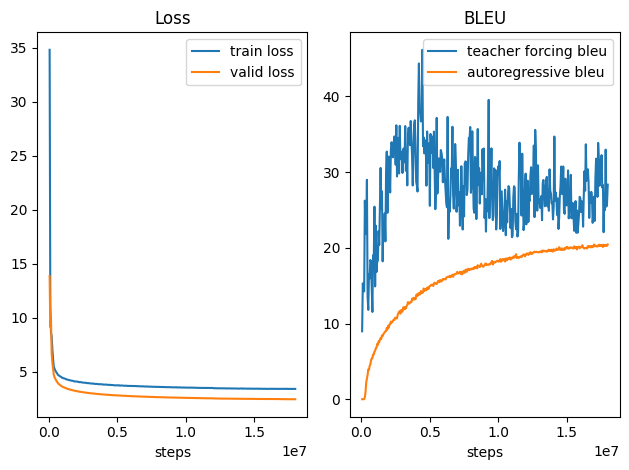

In [5]:
import matplotlib.pyplot as plt
import os

def paint():
    
    if os.path.exists(save_path):
        
        load_info = torch.load(save_path, map_location={origin_cuda: used_cuda}) #map_location={'cuda:3': 'cuda:1'}
        
        loss_list = load_info["train_loss_list"]
        valid_list = load_info["val_loss_list"]
        
        val_bleu_list = load_info["val_bleu_list"]
        val_auto_bleu_list = load_info["val_auto_bleu_list"]
        
        step_list = load_info["step_list"]
        steps = step_list[-1]

    else :
        return "Not exist checkpoint"
    
    print("total steps:",steps)
    
    plt.subplot(121)
    plt.title("Loss")
    plt.xlabel("steps")
    # plt.ylabel("loss")
    plt.plot(step_list,loss_list)
    plt.plot(step_list,valid_list) # [10:]
    plt.legend(["train loss","valid loss"])


    plt.tight_layout()
    
    plt.subplot(122)
    plt.title("BLEU")
    plt.xlabel("steps")
    # plt.ylabel("loss")
    plt.plot(step_list,val_bleu_list)
    plt.plot(step_list,val_auto_bleu_list)
    plt.legend(["teacher forcing bleu","autoregressive bleu"])


    plt.tight_layout()

paint()

In [5]:
#     if os.path.exists(save_path):
        
#         load_info = torch.load(save_path, map_location={origin_cuda: used_cuda}) #map_location={'cuda:3': 'cuda:1'}
        
#         loss_list = load_info["train_loss_list"]
#         valid_list = load_info["val_loss_list"]
        
#         val_bleu_list = load_info["val_bleu_list"]
#         val_auto_bleu_list = load_info["val_auto_bleu_list"]
        
#         step_list = load_info["step_list"]
#         steps = step_list[-1]
#         for step in step_list:
#             print(step)

# Test

In [31]:
transformer_model.eval()


TransformerModel(
  (emb): Embedding(37000, 512, padding_idx=2)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_featur

In [6]:
from datasets import load_dataset
test_dataset = load_dataset("wmt14", 'de-en', split='test')

test_de_en_pairs = []
for i in range(len(test_dataset)):
    test_de_en_pairs.append((test_dataset[i]['translation']['de'],test_dataset[i]['translation']['en']))
    


Found cached dataset wmt14 (/data2/zrs/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


# Greedy Search

In [32]:
import numpy as np
def translate(src,references):
    
    # src:str
    output = tokenizer.encode(src)
    
    src_ids = [output.ids] #[1,S] 
#     src_padding_mask = [1-np.array(output.attention_mask)] #[1,S]
    src_padding_mask = np.array([1-np.array(output.attention_mask)])
    tgt_ids = [[bos_id]] #[1,1] i.e [1,T]
    
    while tgt_ids[0][-1] != eos_id:
        if len(tgt_ids[0]) > len(output.ids) +50:
            break
        pred= transformer_model(torch.LongTensor(src_ids).t().contiguous().to(device),
                                torch.LongTensor(tgt_ids).t().contiguous().to(device),
                                generate_square_subsequent_mask(len(tgt_ids[0])).to(device),
                                torch.LongTensor(src_padding_mask).to(device),None)
        # [T,1,E]
        
        next_token = pred.argmax(dim=-1)[-1]
        #                      [T,1]
        
        # tgt_ids :<bos>       A         :[T]
        # pred    :  A    <next token>   :[T]
        
        tgt_ids[0].append(next_token.item())
    
    # src_ids:[S] tgt_ids=[T]
    tgt = tokenizer.decode(tgt_ids[0])
    print("\nsrc:",src)
    print("\npred:",tgt)
    #  candidate [allB,T(str)] # references [allB,1,T(str)]
    
    output = tokenizer.encode(tgt)
    candidate = [output.tokens]
    bleu = bleu_score(candidate,references)*100
    print(f"\nbleu:{bleu}")
    return bleu

# Beam search

In [33]:
def beam_search(model, src, references,beam_size=4,length_penalty=0.6):
    import numpy as np
    model.eval()
    # src:str
    output = tokenizer.encode(src)
    
    src_ids = [output.ids] #[1,S] 
    src_padding_mask = np.array([1-np.array(output.attention_mask)]) #[1,S]
    tgt_ids = [bos_id] #[1] i.e List[int] 
    
    # src_ids:[1,S]
    # tgt_ids:[1]
    tgts = [(tgt_ids,0)] # tgts:tuple(List[int],float) i.e. (seq,log_prob of seq)
    
    # length_penalty
    def lp(Y):
        return ((5+len(Y))**length_penalty)/((5+1)**length_penalty)
    
    max_length = len(output.ids)+50
    
    with torch.no_grad():
        
        for loop_time in range(max_length):
            
            
            # candidates of Y_ids and its log_prob
            tmp_tgts = []
                    
            for Y_ids,log_prob_Y in tgts:
                
                if Y_ids[-1] == eos_id:
                    tmp_tgts.append((Y_ids,log_prob_Y))
                    continue
                    
                
                # get topk next tokens
                
                # src_ids:[1,S]->[S,1] Y_ids:[T]->[1,T]->[T,1]
                # padding_mask:[1,S]
                pred = model(torch.LongTensor(src_ids).t().contiguous().to(device),
                                        torch.LongTensor([Y_ids]).t().contiguous().to(device),
                                        generate_square_subsequent_mask(len(Y_ids)).to(device),
                                        torch.LongTensor(src_padding_mask).to(device),None)
                #pred: [T,1,ntokens] -> [ntokens] 
                pred = pred[-1,0,:]
                
                log_prob = torch.nn.functional.log_softmax(pred,dim=-1)
                # log_prob:[ntokens]
                log_probs,indexs = log_prob.topk(k=beam_size)
                # [beam_size]
                for log_prob_y,index in zip(log_probs,indexs):
                    next_token = index.item()
                    new_Y_ids = Y_ids + [next_token]
                    new_log_prob_Y = log_prob_Y + log_prob_y
                    tmp_tgts.append((new_Y_ids,new_log_prob_Y))
            
            tmp_tgts.sort(key=lambda x:x[1]/lp(x[0]),reverse=True)
            tgts.clear()
            for i in range(beam_size):
                tgts.append(tmp_tgts[i])
#                 print(tmp_tgts[i])
#             print('='*60)
        tgt_ids = tgts[0][0]
        
        # tgt_ids:[T]
        tgt = tokenizer.decode(tgt_ids)
        print("\nsrc:",src)
        print("\npred:",tgt)

        output = tokenizer.encode(tgt)
        candidate = [output.tokens] #  candidate [allB(1),T(str)] # references [allB(1),1,T(str)]
        bleu = bleu_score(candidate,references)*100
        print(f"\nbleu:{bleu}")
        return bleu      

# Greedy search de -> en

In [34]:
# from torchtext.data.metrics import bleu_score

# total_bleu = 0.0
# for i in range(len(test_de_en_pairs)):
# #     print("="*40)
# #     print("test"+str(i+1)+":")
#     output = tokenizer.encode(test_de_en_pairs[i][1])
#     total_bleu += translate(test_de_en_pairs[i][0],references=[[output.tokens]])
# #     print("ans:",test_de_en_pairs[i][1])

# print(total_bleu/len(test_de_en_pairs))
# print(total_bleu)


# Greedy search en -> de

In [35]:
from torchtext.data.metrics import bleu_score

total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
    print("="*40)
    print("test"+str(i+1)+":")
    output = tokenizer.encode(test_de_en_pairs[i][0])
    total_bleu += translate(test_de_en_pairs[i][1],references=[[output.tokens]])
    print("ans:",test_de_en_pairs[i][0])

print(total_bleu/len(test_de_en_pairs))
print(total_bleu)


test1:

src: Gutach: Increased safety for pedestrians

pred:  Gutach: Erhöhung der Sicherheit für Fußgänger

bleu:52.53819823265076
ans: Gutach: Noch mehr Sicherheit für Fußgänger
test2:

src: They are not even 100 metres apart: On Tuesday, the new B 33 pedestrian lights in Dorfparkplatz in Gutach became operational - within view of the existing Town Hall traffic lights.

pred:  Sie sind nicht einmal 100 Meter voneinander entfernt: Am Dienstag wurde die neue Fußgängerbeleuchtung in Gutach in Dorfplatz - im Rathaus mit Blick auf die bestehenden Verkehrslampen.

bleu:20.127006516042677
ans: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.
test3:

src: Two sets of lights so close to one another: intentional or just a silly error?

pred:  Zwei Lichter so nah aneinander: Absicht oder einfach nur ein dummer Fehler?

bleu:0.0
ans: Zwei Anlagen so nah bei


src: Arnold explained the technology used by the new system: It is fitted with two radar sensors.

pred:  Arnold erklärte die Technik des neuen Radarsystems: Es ist mit zwei Sensoren ausgestattet.

bleu:43.69493126869202
ans: Arnold erklärte die Technik der neuen Anlage: Diese ist mit zwei Radarsensoren ausgestattet.
test20:

src: If the pedestrian presses the button at the traffic lights, the top radar sensor checks the traffic status.

pred:  Wenn die Fußgänger die Taste am Verkehrsradar drücken, kontrolliert der Top-Sensor den Verkehrsstatus.

bleu:0.0
ans: Drückt der Fußgänger den Ampelknopf, testet der obere Radarsensor die Verkehrslage.
test21:

src: If the street is clear, the pedestrian obtains a green light immediately, if not, there is a delay of around 15 seconds.

pred:  Wenn die Straße klar ist, erhält die Fußgänger sofort ein grünes Licht, wenn nicht, es gibt eine Verzögerung von etwa 15 Sekunden.

bleu:23.705267906188965
ans: Ist die Straße frei, kommt unmittelbar Grün 


src: Wrapped in cellophane or in girdles, they stumble on dangerously high heels across the set, either delivering monologues at the top of their voices or lying completely silent on the stage.

pred:  Die in Zellophane oder in Gürtel gehackt, stolpern sie gefährlich hoch über den Heels, was Monologen entweder an der Spitze ihrer Stimmen liegt oder auf der Bühne völlig still.

bleu:7.7605465975097045
ans: Eingezwängt in Zellophan oder Mieder, staksen sie auf gefährlich hohen Stöckeln durch die Inszenierung, entweder monologisieren sie lautstark oder liegen völlig verstummt auf dem Bühnenboden.
test37:

src: However, the source text makes barely any reference to this intense delivery.

pred:  Der Quelltext enthält jedoch kaum einen Hinweis auf diese intensive Lieferung.

bleu:0.0
ans: Der Text vermittelt sich auf diese angestrengte Weise jedoch kaum.
test38:

src: The best moments of the evening is when the singing starts - tracks range from Deep Purple to traditional folk songs.

pred


src: The technology is there to do it.

pred:  Die Technologie ist da, um sie zu erreichen.

bleu:0.0
ans: Die Technologie dafür ist da.
test54:

src: The push comes as the country's Highway Trust Fund, financed with taxes Americans pay at the gas pump, is broke.

pred:  Der Pumpzug kommt, wenn der Trust Highway Fund des Landes finanziert wird, mit Amerikanern zahlen Steuern an der Gaspumpe, ist brach.

bleu:0.0
ans: Die Initiative kommt zu einem Zeitpunkt, da der Highway Trust Fund, der aus den Steuern finanziert wird, die US-Amerikaner an der Zapfsäule entrichten, pleite ist.
test55:

src: Americans don't buy as much gas as they used to.

pred:  Die Amerikaner kaufen nicht so viel Gas wie früher.

bleu:21.09926450777269
ans: Doch in Amerika wird nicht mehr so viel getankt wie früher.
test56:

src: Cars get many more miles to the gallon.

pred:  Carson bringt viele Meilen mehr zum Gallon.

bleu:0.0
ans: Autos verbrauchen weniger Benzin.
test57:

src: The federal tax itself, 18.4 cent


src: The most eager is Oregon, which is enlisting 5,000 drivers in the country's biggest experiment.

pred:  Das eifrigste ist Oregon, das 5.000 Fahrer in den größten Experimenten des Landes aufhält.

bleu:30.405598878860474
ans: Am engagiertesten ist Oregon, das derzeit 5.000 Fahrer für das größte Experiment des Landes anwirbt.
test74:

src: Those drivers will soon pay the mileage fees instead of gas taxes to the state.

pred:  Diese Fahrer werden bald die Meilengebühren bezahlen, anstatt Steuern an den Staat zu erheben.

bleu:40.985468029098115
ans: Diese Fahrer werden bald die Meilengebühren statt der Mineralölsteuer an den Bundesstaat zahlen.
test75:

src: Nevada has already completed a pilot.

pred:  Nevada hat bereits einen Pilot abgeschlossen.

bleu:39.93879083371094
ans: Nevada hat bereits ein Pilotprojekt abgeschlossen.
test76:

src: New York City is looking into one.

pred:  New York City sucht sich nach einem.

bleu:28.266577416207756
ans: New York City erwägt ebenfalls ein


src: There are a lot less expensive and less intrusive ways to do this.

pred:  Es gibt viel weniger teure und weniger aufdringliche Möglichkeiten, dies zu tun.

bleu:0.0
ans: Es gibt wesentlich billigere und weniger intrusive Möglichkeiten, dies umzusetzen.
test94:

src: In Oregon, planners are experimenting with giving drivers different choices.

pred:  In Oregon experimentieren Planer mit verschiedenen Treibern.

bleu:26.421989465547313
ans: In Oregon experimentieren die Planer damit, Autofahrern eine Reihe von Auswahlmöglichkeiten zu geben.
test95:

src: They can choose a device with or without GPS.

pred:  Sie können ein Gerät mit oder ohne GPS auswählen.

bleu:48.87164429580987
ans: Sie können sich für ein Gerät mit oder ohne GPS entscheiden.
test96:

src: Or they can choose not to have a device at all, opting instead to pay a flat fee based on the average number of miles driven by all state residents.

pred:  Oder sie können sich entscheiden, überhaupt kein Gerät zu haben, stat


src: Two fire fighters equipped with respiratory gear prepared to enter the building following the initial inspection of the situation by Hans Kammerer.

pred:  Zwei Feuerwehrleute, die mit Atemzug ausgerüstet sind, bereit, nach der ersten Inspektion der Situation durch Hans Kammerer in das Gebäude zu gelangen.

bleu:16.454944014549255
ans: Zwei Atemschutzträger der Wehr machten sich nach der ersten Überprüfung der Sachlage durch Hans Kammerer bereit, das Gebäude zu betreten.
test112:

src: After a short time they managed to find the first person and direct them out of the building.

pred:  Nach kurzer Zeit gelang es ihnen, die erste Person zu finden und sie aus dem Gebäude zu leiten.

bleu:51.233500242233276
ans: Nach kurzer Zeit gelang es, die erste Person zu finden und ins Freie zu geleiten.
test113:

src: The second person had to be carried.

pred:  Die zweite Person musste befördert werden.

bleu:59.69492197036743
ans: Die zweite Person musste getragen werden.
test114:

src: This


src: He also stated that an increasing number of employed persons are looking after the long-term care and support of relatives.

pred:  Er erklärte auch, dass immer mehr Personen für die Langzeitpflege und Betreuung von Angehörigen zuständig sind.

bleu:0.0
ans: Außerdem führte er an, dass sich immer mehr Beschäftigte um die Pflege und Betreuung ihrer Angehörigen kümmerten.
test134:

src: "Without support from their employer, the resulting burden placed on employees could result in the termination of the employment contract," said Wolf.

pred:  "Mit der Unterstützung durch ihren Arbeitgeber könnte die daraus resultierende Belastung für die Arbeitnehmer zur Kündigung des Arbeitsvertrags führen", sagte Wolf.

bleu:32.51656101546191
ans: "Ohne die Unterstützung der Arbeitgeber kann die daraus resultierende Belastung der Beschäftigten zu einer Beendigung des Arbeitsverhältnisses führen", sagte Wolf.
test135:

src: However, nobody can afford to lose qualified workers," he added.

pred:  N


src: According to Alexander Misok of the Bräunlingen Municipal Planning and Building Control Authority, the ongoing procedure plans to involve the Regional Memorial Authority in the planning stage and to draw up a renovation concept for the old wall.

pred:  Nach Alexander Mislingen von der Gemeinde Bräunok plant das laufende Verfahren, die Regionale Planungs- und Kontrollbehörde für Denkmalpflege in die Planungsphase einzubeziehen und ein Konzept für die Renovierung der alten Mauer zu erarbeiten.

bleu:0.0
ans: Das weitere Vorgehen sieht vor, so Alexander Misok vom Bräunlinger Stadtbauamt, das Landesdenkmalamt in die Planungen mit einzubeziehen und ein Sanierungskonzept für die alte Mauer zu erstellen.
test152:

src: A cost calculation is to be performed by a team of professionals, which will then be submitted to the Town Council, which will make a decision and determine the ongoing procedure.

pred:  Eine Kostenberechnung wird von einem Team von Fachleuten durchgeführt, das dann dem


src: On the basis of an expert study, this government is urging the reorganisation of the five music colleges in Baden-Wuerttemberg.

pred:  Auf der Grundlage einer Expertenstudie fordert diese Regierung die Neuorganisation der fünf Musikhochschulen in Baden-Württemberg.

bleu:56.49268627166748
ans: Diese forciert auf der Basis einer Expertenstudie eine Neuordnung der fünf Musikhochschulen in Baden-Württemberg.
test168:

src: In accordance with these plans, the jazz and pop courses, among others, are to be relocated from the Stuttgart Music College to the Mannheim Music College.

pred:  Entsprechend diesen Plänen sollen die Pop- und Jazzkurse u.a. vom Musikhochschule Stuttgart zum Musikhochschule Stuttgart verlegt werden.

bleu:16.4755180478096
ans: Danach soll unter anderem der Studiengang Jazz und Pop von der Musikhochschule Stuttgart an die Musikhochschule Mannheim verlagert werden.
test169:

src: US borders: "Super tunnel" for drug smuggling discovered

pred:  Grenzüberschreitunge


src: Two of the suspects were detained in conjunction with the cocaine find.

pred:  Zwei der Verdächtigen wurden in Verbindung mit der Kokain gefunden.

bleu:37.685777603851314
ans: Zwei der Verdächtigen wurden in Zusammenhang mit dem Kokain-Fund festgenommen.
test186:

src: The third, a Mexican, was detained due to the seizure of the marijuana.

pred:  Der dritte, ein mexikanischer, wurde wegen der Beschlagnahme der Marihuana inhaftiert.

bleu:0.0
ans: Der Dritte, ein Mexikaner, wurde wegen des beschlagnahmten Marihuanas gefasst.
test187:

src: All three face a maximum penalty of life imprisonment, according to the authorities.

pred:  Alle drei haben laut den Behörden eine maximale lebenslange Haftstrafe.

bleu:0.0
ans: Allen dreien droht als Höchststrafe lebenslanger Freiheitsentzug, wie Beamte sagten.
test188:

src: Since 2006, eight tunnels of this type have been discovered, the press conference in San Diego continued.

pred:  Seit 2006 wurden acht Tunnel dieser Art entdeckt, di


src: On 21 June, in conjunction with the Schwarzwaldverein [Black Forest Association] Mid-Summer Festival, on 12 July in the Arena, accompanied by fireworks, and on 13 December as the first concert put on by the Stadtmusik (Town Musical Society) in the new Festival Hall.

pred:  Am 21. Juni, zusammen mit dem Schwarzwald Festival Association [Black Forest-Summer-Festival] am 12. Juli in der Stadt, begleitet von Feuerwerken und am 13. Dezember als erstes Konzert der Stadtmusikverein (Town Society) in der neuen Arena.

bleu:36.6258829832077
ans: Am 21. Juni zusammen mit der Sonnwendfeier des Schwarzwaldvereins, am 12. Juli in der Arena mit Feuerwerk und am 13. Dezember als erstes Konzert der Stadtmusik in der neuen Festhalle.
test209:

src: This venue will be completed and inaugurated in the anniversary year, with the official date set for the last weekend in September, on 27 and 28 September.

pred:  Dieser Veranstaltungsort wird im Jubiläum des Jahres eröffnet und abgeschlossen, mit de


src: In particular, safety at railway crossings is to be increased - collisions between trains and other vehicles frequently occur at these across the country.

pred:  Insbesondere die Sicherheit bei den Bahnübergängen soll erhöht werden - Kollisionen zwischen den Zügen und anderen Fahrzeugen treten häufig im ganzen Land auf.

bleu:0.0
ans: Besonders soll dabei die Sicherheit an Bahnübergängen erhöht werden - regelmäßig kommt es bundesweit zu Kollisionen von Zügen mit anderen Fahrzeuge.
test227:

src: If the municipalities agree to the reconstruction measures, they will be required to contribute one third of the costs, with the remainder divided between Deutsche Bahn and the Federal Government.

pred:  Wenn die Gemeinden den Wiederaufbaumaßnahmen zustimmen, werden sie einen Teil der Kosten tragen müssen, wobei die restlichen Gemeinden zwischen der Deutschen Bahn und der Bundesregierung gespalten sind.

bleu:0.0
ans: Stimmen die Gemeinden den Umbaumaßnahmen zu, müssen sie sich mit eine


src: The reconstruction of the railway crossing at the Trautwein tannery could, on the other hand, bring with it an entirely different problem with regard to access to the steep "Geroltzhäuser Weg".

pred:  Der Wiederaufbau der steilen Bahnüberfahrt am Weg Trautwein könnte dagegen ein völlig anderes Problem mit sich bringen, was den Zugang zur "Geroltzhäuser" betrifft.

bleu:27.34955905187617
ans: Der Umbau des Bahnübergangs bei der Gerberei Trautwein könnte dagegen ein ganz anderes Problem nach sich ziehen, das die Zufahrt in den stark ansteigenden "Geroltzhäuser Weg" betrifft.
test240:

src: The Administrative Department had Deutsche Bahn's reconstruction plans investigated by the Breinlinger Engineering Office, as they had doubts as to whether the planned connection of the Geroltzhäuser Weg will be straightforward.

pred:  Die Verwaltungsabteilung hatte die Wiederaufbaupläne der Deutschen Bahn vom Bretzer Weglinger Engineering Office untersucht, da sie Zweifel daran hatten, ob die 


src: Or instead conduct research into the origin of the cosmos?

pred:  Oder statt dessen die Erforschung der Herkunft des Kosmos?

bleu:0.0
ans: Oder lieber den Ursprung des Kosmos erforschen?
test257:

src: Or search for planets similar to the Earth and thus perhaps discover extraterrestrial life?

pred:  Oder suchen Sie nach Planeten, die der Erde ähneln und entdecken Sie damit vielleicht extraterrestrisches Leben?

bleu:0.0
ans: Oder nach erdähnlichen Planeten fahnden und damit vielleicht außerirdisches Leben entdecken?
test258:

src: These are the questions currently being asked by those responsible at the European Space Agency, ESA.

pred:  Dies sind die Fragen, die derzeit von den Verantwortlichen der Europäischen Weltraumorganisation ESA gestellt werden.

bleu:0.0
ans: Diese Fragen stellen sich gerade die Verantwortlichen der europäischen Raumfahrtagentur Esa.
test259:

src: For their "Cosmic Vision" programme, they are looking for ideas for two major space projects, which sho


src: It is possible to investigate these processes in our solar system, to serve as an example to be applied elsewhere.

pred:  Es ist möglich, diese Prozesse in unserem Sonnensystem zu untersuchen, um als Beispiel dafür zu dienen, dass sie anderswo angewendet werden.

bleu:0.0
ans: In unserem Sonnensystem lassen sich diese Vorgänge exemplarisch untersuchen.
test278:

src: With the "Solar Orbiter", the ESA has already approved an M-class mission (for which the budget stands at around half a million Euro) to address this matter.

pred:  Mit der "Solar Orbiter" hat die ESA bereits eine M-Klasse-Mission (für die der Haushalt bei etwa einer halben Million Euro liegt) genehmigt, um sich mit dieser Angelegenheit zu befassen.

bleu:29.64302897453308
ans: Mit dem "Solar Orbiter" hat die Esa bereits eine Mission der M-Klasse (dort liegt das Budget bei etwa einer halben Milliarde Euro) für diese Frage bewilligt.
test279:

src: The probe is to be launched in 2017 and will closely observe the sur


src: Of the 30 proposals, only two will remain at the end of the selection procedure.

pred:  Von den 30 Vorschlägen bleiben nur zwei am Ende des Auswahlverfahrens.

bleu:50.38876574747042
ans: Von den 30 Vorschlägen werden am Ende des Auswahlverfahrens nur zwei übrig bleiben.
test296:

src: The proposal with the best chance of approval as an L-mission, in the opinion of many experts, is "E-Lisa", a demanding concept that aims to prove the existence of gravitational waves.

pred:  Der Vorschlag mit der besten Aussicht auf Zustimmung als L-Mission ist nach Ansicht vieler Experten "E-Lisa", ein anspruchsvolles Konzept, das darauf abzielt, die Existenz von Gravitationswellen zu beweisen.

bleu:42.483189702034
ans: Die besten Chancen auf eine Bewilligung als L-Mission hat nach Meinung vieler Experten "E-Lisa", ein anspruchsvolles Konzept zum Nachweis von Gravitationswellen.
test297:

src: Many physicians perceive this to entail changes in the structure of space-time, which Albert Einstein


src: The charges filed by the US justice department include espionage and theft of government property.

pred:  Die von der US-Justizministerin erhobenen Anklagen beinhalten Spionage und Diebstahl von Eigentum der Regierung.

bleu:37.006402015686035
ans: Die vom US-Justizministerium erhobene Anklage umfasst Spionage und Diebstahl von Staatseigentum.
test311:

src: Hans-Peter Friedrich, German interior minister, told Zeit Online: "If Mr Snowden is ready to speak to German officials, we will find ways to make this possible."

pred:  Hans-Peter Friedrich Snowden, deutscher Innenminister, sagte: "Wenn Herr Zeit Online bereit ist, mit deutschen Beamten zu sprechen, werden wir Wege finden, dies zu ermöglichen."

bleu:28.961551189422607
ans: Der deutsche Innenminister Hans-Peter Friedrich sagte gegenüber Zeit Online: „Wenn Herr Snowden bereit ist, mit deutschen Vertretern zu sprechen, dann finden wir Wege, das zu ermöglichen.“
test312:

src: Relations between the US and Germany have come und


src: Frontier said it will charge $25 if the fee is paid in advance, $100 if travelers wait to pay until they're at the gate.

pred:  Frontier sagte, es wird $25 berechnet, wenn die Gebühr im Voraus bezahlt wird, $100, wenn Reisende warten, bis sie am Tor zu zahlen.

bleu:19.78687072709534
ans: Frontier erklärte, man berechne 25 US-Dollar, wenn die Gebühr im Voraus bezahlt werde, und 100 US-Dollar bei Reisenden, die erst am Flugsteig zahlten.
test327:

src: Frontier spokeswoman Kate O'Malley said the $100 fee is to get travelers to take care of the charge in advance.

pred:  Die Stadt ist eine Stadt in der Provinz Kalley .

bleu:0.0
ans: Frontier-Sprecherin Kate O'Malley sagte, die Gebühr von 100 US-Dollar ziele darauf ab, Reisende zu bewegen, sich im Vorfeld um die Zahlung zu kümmern.
test328:

src: "We don't want to charge that," she said.

pred:  "Wir wollen das nicht verrechnen", sagte sie.

bleu:0.0
ans: „Wir möchten diese Summe nicht berechnen“, erklärte sie.
test329:

src: Airl


src: Sorensen, a former executive with Midwest Airlines, flew Spirit recently and wondered what he'd find at the gate as passengers encountered Spirit's unusual carry-on bag fee.

pred:  Spirit, ein ehemaliger Exekutivdirektor mit Spirit Airlines, flog vor kurzem und fragte sich, was er am Tor als ungewöhnliche Passagiere mit dem Midwest-Tasche-Tasche-Gebühr zu tragen hatte.

bleu:0.0
ans: Sorensen, der früher eine Führungsposition bei Midwest Airlines innehatte, ist kürzlich mit Spirit geflogen und war neugierig, was ihm am Flugsteig erwarten würde, wenn Passagiere mit der ungewöhnlichen Handgepäckgebühr des Unternehmens konfrontiert würden.
test346:

src: "The boarding process was the smoothest I had seen in my airline career," he said.

pred:  "Der Flugbetrieb war der reibungsloseste, den ich in meiner Karriere gesehen hatte", sagte er.

bleu:13.68748283462988
ans: „Der Boarding-Prozess gehörte zu den reibungslosesten, die ich in meiner Laufbahn in der Luftfahrt erlebt habe“, sagte


src: At least 40 women attended the last women's breakfast of the year, in the Evangelical Parish of Bisingen.

pred:  Mindestens 40 Frauen nahmen am letzten Frühstück des Jahres teil, im Evangelischen Parish von Bisingen.

bleu:17.03898865339063
ans: Gut 40 Frauen besuchten das letzte Frauenfrühstück dieses Jahres in der evangelischen Kirchengemeinde Bisingen.
test366:

src: The theme of the day in the parish hall was "Sayings from the Bible" and "Expressions from the Middle Ages".

pred:  Das Thema des Tages in der Pfarrhalle war "Sayings from the Bibel" und "Expressions" aus dem Mittelalter.

bleu:22.41905778646469
ans: Thema des Tages im Gemeindehaus waren "Sprichwörter aus der Bibel" und "Redewendungen aus dem Mittelalter".
test367:

src: Zita Köhler, the Chairperson of the Parish Council, agreed to give a talk on Biblical proverbs after breakfast.

pred:  Zita Köhler, der Vorsitzende des Parish Council, hat sich bereit erklärt, nach dem Frühstück einen Vortrag über Bibelproverbs


src: Also involved in the project are the Chamber of Industry and Commerce in Neubrandenburg and the German Hotel and Restaurant Association (Deutsche Hotel- und Gaststätte, Dehoga) of Mecklenburg-Western Pomerania.

pred:  Zu den Projektbeteiligten gehören die Industrie- und Handelskammer in Neubrandenburg und die Bundes- und Gaststätte Dehoga, Hotel- und Restaurant Mecklenburg-Western.

bleu:37.439846269426184
ans: An dem Projekt sind auch die Industrie- und Handelskammer in Neubrandenburg sowie der Deutsche Hotel- und Gaststättenverband (Dehoga) Mecklenburg-Vorpommern beteiligt.
test383:

src: NSA Blames "Internal Error," Not Hackers, For Website Crash

pred:  NSA "Internal Error Hackers", nicht die Website, Crash Blames

bleu:0.0
ans: NSA erklärt, ein „interner Fehler“ und nicht Hacker seien Schuld am Crash der Website
test384:

src: The shadowy National Security Agency said late Friday that it was a glitch that brought down its public website for a few hours, not hackers as some 


src: Stating a reason for this, Felder-Bauer said: "We have barely any skilled workers in the fields of skilled crafts and trades, healthcare and geriatric care."

pred:  Aus diesem Grund sagte Felderauer-Bauer: "Wir haben kaum qualifizierte Fachkräfte in den Bereichen Handwerk und Gesundheitswesen, Geriatrie und geriatrische Pflege."

bleu:24.54361319541931
ans: Ein Grund hierfür ist laut Felder-Bauer: "Wir haben kaum Fachkräfte im Handwerk, im Gesundheitswesen und in der Altenpflege".
test400:

src: Seasonal job offers for staff in hotel and restaurant businesses have been coming in since September.

pred:  Seit September kommen in den Unternehmen und im Restaurant die Saison-Personal-Angebote für die Mitarbeiter des Hotels.

bleu:0.0
ans: Jahreszeitenbedingt laufen seit September auch wieder Stellenangebote für Personal im Hotel- und Gaststättengewerbe ein.
test401:

src: The Winter season within the industry begins in mid-December.

pred:  Die Winterzeit beginnt Mitte Dezember.

b


src: Chief Executive Officer Pierre Beaudoin was confident Bombardier would meet its 300 firm order target by the time the first jet is put into commercial use.

pred:  Pierre Beaudoin, Chief Executive Officer, war zuversichtlich, dass Bombardier sein 300-Ziel-Firmenauftrag bis zum ersten Mal in den kommerziellen Einsatz kommen würde.

bleu:23.078571259975433
ans: Vorstandsvorsitzender Pierre Beaudoin gibt sich zuversichtlich, dass Bombardier sein Ziel von 300 verbindlichen Bestellungen zu Beginn der kommerziellen Nutzung des Jets erreichen werde.
test417:

src: Executives also reassured analysts and media on Thursday the program was progressing according to schedule.

pred:  Die Führungskräfte und Analysten des Programms haben am Donnerstag auch die Medien beruhigt und konnten sich nach Zeitplan weiterentwickeln.

bleu:0.0
ans: Die Unternehmensführung versicherte am Donnerstag gegenüber Analysten und Medien außerdem, das Programm liege im Terminplan.
test418:

src: "The test plane di


src: Aerospace revenue fell 13 percent to $2 billion.

pred:  Der Umsatz im Bereich der Luft- und Raumfahrt sank um 13 Prozent auf 2 Milliarden Dollar.

bleu:39.410048723220825
ans: Der Umsatz in der Luft- und Raumfahrtsparte fiel um 13 Prozent auf zwei Milliarden Dollar.
test435:

src: Bombardier, the world's largest trainmaker, said revenue in that division rose nearly 11 percent to $2.1 billion.

pred:  Bombardier, der weltweit größte Zugführer, sagte in dieser Division, dass die Einnahmen um fast 11 Prozent auf 1,2 Milliarden Dollar gestiegen sind.

bleu:29.905490016156232
ans: Bombardier, der weltweit größte Eisenbahnhersteller, gab bekannt, dass der Umsatz in dieser Sparte um knapp elf Prozent auf 2,1 Milliarden Dollar gestiegen ist.
test436:

src: The order backlog in the transportation unit was $32.6 billion as of September 30, up marginally from December 31.

pred:  Der Auftragsrückstand in der Transporteinheit betrug ab 30. September 32,6 Milliarden Dollar, geringfügig vom 3


src: The shots were said to have been fired near a security inspection area.

pred:  Die Aufnahmen sollen in der Nähe eines Sicherheitsbereichs abgefeuert worden sein.

bleu:0.0
ans: Die Schüsse sollen nahe eines Sicherheitskontrollbereichs gefallen sein.
test456:

src: Airport building evacuated

pred:  Flughafengebäude

bleu:0.0
ans: Flughafen-Gebäude evakuiert
test457:

src: Television footage revealed how numerous ambulances and police cars arrived at a terminal.

pred:  Fernsehen zeigte, wie viele Krankenwagen und Polizeikräfte an einem Terminal angekommen sind.

bleu:0.0
ans: Auf Fernsehbildern war zu sehen, wie zahlreiche Kranken- und Polizeiwagen vor einem Terminal vorfuhren.
test458:

src: One hundred people were brought out of the building to safety.

pred:  Einhundert Menschen wurden aus dem Gebäude zur Sicherheit gebracht.

bleu:49.735674262046814
ans: Hunderte Menschen wurden aus dem Gebäude in Sicherheit gebracht.
test459:

src: Users on Twitter published photos of a SWA


src: All four suspects were being watched by police at the time as part of a major investigation into a heroin and cocaine racket operating across Lancashire, Cumbria, Merseyside, Berkshire and West Yorkshire.

pred:  Alle vier Verdächtigen wurden damals von der Polizei im Rahmen einer umfassenden Untersuchung über Heroin und Kokain-Rack-Rack-Betrieb in Lancashire, Cumbrash, Yorkshire, West Merseyside und Berkshire beobachtet.

bleu:44.51599419116974
ans: Alle vier Verdächtigen wurden damals von der Polizei im Rahmen eines großen Ermittlungsverfahrens zum Heroin- und Kokainhandel in Lancashire, Cumbria, Merseyside, Berkshire und West Yorkshire überwacht.
test477:

src: They and 32 other men were later jailed after police seized heroin and cocaine worth £1.5million along with more than £200,000 in cash during a series of raids.

pred:  Sie und 32 andere Männer wurden später nach der Polizei beschlagnahmt und Kokain im Wert von £1,5 Millionen zusammen mit mehr als £200.000 in bar währen


src: Prosecuting, Anne Whyte said: "If anyone should know not to the break the law, it is a criminal solicitor."

pred:  Annete, der Staatsanwalt, sagte: "Wenn jemand das Gesetz nicht durchbrechen sollte, ist es ein strafrechtlicher Anwalt."

bleu:0.0
ans: Staatsanwältin Anne Whyte sagte: „Ein Strafrechtsanwalt sollte besser als alle anderen wissen, dass man das Gesetz nicht bricht.“
test491:

src: Mr Ditta is accused of abusing his position as a criminal solicitor, having become too involved with specific clients.

pred:  Herr Ditta wird beschuldigt, seine Position als krimineller Anwalt zu missbrauchen, da er sich zu sehr mit spezifischen Mandanten beschäftigt.

bleu:29.620590806007385
ans: Ditta wird des Missbrauchs seiner Position als Strafverteidiger angeklagt, da er sich zu sehr mit bestimmten Mandanten eingelassen hat.
test492:

src: The relationship we are talking about is not simply a drug dealer, but a drug dealer providing his own lawyer with drugs.

pred:  Die Beziehung, ü


src: Thirty five other men involved in the racket were jailed for a total of 153 years for drugs offences.

pred:  Dreißig weitere Männer, die an den Kiefergelenkvergehen beteiligt waren, wurden für insgesamt 153 Jahre für Drogen verurteilt.

bleu:0.0
ans: Fünfunddreißig weitere am Drogenhandel beteiligte´Personen wurden zu Gesamtstrafen von 153 Jahren wegen Drogendelikten verurteilt.
test508:

src: On his website Ditta gave a question and answer session about himself in which he says his fantasy job would be a lawyer representing clients on Death Row in America, his ultimate dinner guest as being Mohammed Ali and inequality as his motivation for work.

pred:  Auf seiner Website gab Mohammed Ali Ditta eine Frage und Antwort auf seine Frage, in der er sagt, dass sein Job ein Anwalt sein würde, der Kunden in Amerika zu vertreten, sein ultimatives Abendessen als Gast und seine Motivation für Ungleichheit Arbeit.

bleu:18.16827732791243
ans: Auf seiner Website veröffentlichte Ditta einen 


src: The extremely constructive discussions between the six committees and the full-time members of the pastoral care team addressed topics ranging from perceptions and expectations regarding the 2015 reforms, to concrete proposals regarding the future composition and size of the Parish Council.

pred:  Die äußerst konstruktiven Diskussionen zwischen den sechs Ausschüssen und den Vollzeitmitgliedern des Parish-Personalteams haben Themen angesprochen, die von der Wahrnehmung und den Erwartungen im Hinblick auf die Reformen bis 2015 reichen, bis hin zu konkreten Vorschlägen zur künftigen Größe und Zusammensetzung des Parish-Rates.

bleu:9.36448946595192
ans: Von den Vorstellungen und Erwartungen an die Neuerungen 2015 bis hin zu konkreten Vorschlägen über die künftige Zusammensetzung und die Größe des Pfarrgemeinderats reichten die äußerst konstruktiven Gespräche der sechs Gremien mit den Hauptamtlichen des Seelsorgeteams.
test523:

src: Regional Dean Georg Schmitt explained the newly d


src: The citizens of Pfullendorf will have to adjust to high electricity costs.

pred:  Die Bürger von Pfullendorf müssen sich an hohe Stromkosten anpassen.

bleu:0.0
ans: Die Bürger Pfullendorfs müssen sich auf höhere Stromkosten einstellen.
test540:

src: As Managing Director of the municipal energy company, Jörg-Arne Bias, confirmed to the SÜDKURIER, families of four in Pfullendorf will be on the receiving end of a price increase of EUR 70 to 90 per year.

pred:  Als Geschäftsführer des kommunalen Energieunternehmens Jörg-Arne Bullorf bestätigte die SÜDURIERK vier Familien in Pfendorf am Ende einer Preissteigerung von 70 bis 90 EUR pro Jahr.

bleu:14.320501478123472
ans: Wie der Geschäftsführer der Stadtwerke, Jörg-Arne Bias, gegenüber dem SÜDKURIER bestätigte, kommen auf eine vierköpfige Pfullendorfer Familie 70 bis 90 Euro Mehrkosten pro Jahr zu.
test541:

src: One major reason for the upcoming price increase is the rise of the so-called EEC Levy from 5.277 to 6.3 Cents per kilow


src: He was spared a driving ban on account of the special circumstances - but was not spared a fine.

pred:  Er hat aufgrund der besonderen Umstände ein Fahrverbot verschont - aber nicht verschont.

bleu:0.0
ans: Ein Fahrverbot blieb ihm wegen der besonderen Situation erspart - die Geldstrafe aber nicht.
test560:

src: Town Council delighted with solid budget

pred:  Rat der Städte mit einem soliden Haushalt

bleu:0.0
ans: Gemeinderat freut sich über soliden Haushalt
test561:

src: Every time discussion in Town Council meetings turns to the budget, Mayor Ralph Gerster has good reason to smile.

pred:  Jedes Mal, wenn die Diskussionen in den Ratstagungen zum Haushalt kommen, hat Bürgermeister Ralph Gerster gute Gründe, zu lächeln.

bleu:23.337389528751373
ans: Immer wenn es in Gemeinderatssitzungen um den Haushalt geht, hat Bürgermeister Ralph Gerster gut lachen.
test562:

src: The municipality coffers in Herdwangen-Schönach are well stocked and the administration has been debt-free s


src: "We have to address the subject of municipal rates, as there are investments to be made in the coming years for which we could do with subsidies," commented Gerster regarding this matter.

pred:  "Wir müssen uns mit dem Thema kommunaler Sätze befassen, da in den kommenden Jahren Investitionen getätigt werden müssen, für die wir mit Subventionen arbeiten könnten", sagte Gerster zu diesem Thema.

bleu:25.10853111743927
ans: "Das Thema Hebesätze müssen wir uns anschauen, da in den kommenden Jahren Investitionen anstehen, für die wir gerne Zuschüsse hätten", kündigte Gerster in diesem Zusammenhang an.
test582:

src: Nagold: Hugo Wermter - a choir member for 60 years

pred:  Hugo Nagter: Wermold - ein Chormitglied seit 60 Jahren.

bleu:0.0
ans: Nagold: Hugo Wermter seit 60 Jahren im Chor
test583:

src: Having been a singer for 60 years, Hubert Wermter's story with the Cäcilia Male Choral Society is almost twice as long as that of the Autumn Festival, during which he was ceremonially h


src: The Choral Division of the Baisingen Sports Club returned to its home ground with "Was isch der Schwob?" by Hans Süssmuth and Robert Pappert's "Bierlied", while the Vollmaringen Music Society provided the crowning musical conclusion.

pred:  Die Choraliszenerie des Baising Club kehrte mit "Was ist der Vollmob" von Hans Süsslied und Robert Pappers "Bier der Musik", während die Musikgesellschaft Schwingen die musikalische Schlussfolgerung lieferte.

bleu:16.545572663421655
ans: Die Sängerabteilung des Baisinger Sportvereins kam mit "Was isch der Schwob?" von Hans Süssmuth und Robert Papperts "Bierlied" wieder zurück in heimische Gefilde, wo der Vollmaringer Musikverein den krönenden musikalischen Abschluss bot.
test596:

src: For children, there was a small auxiliary programme - "Oma Hanne" (Grandma Hanne), a.k.a Hannelore Stollsteimer, performed a 'Kasperl' theater (similar to Punch and Judy) and read some stories, which kept the children entertained throughout the afternoon.

pre


src: "This law is draconian and very punitive and we reject it," said Cyrus Kamau, managing director for Capital Group - home to CapitalFM, one of Kenya's most respected independent radio stations and news websites.

pred:  "Dieses Gesetz ist drakonisch und sehr strafbar und wir lehnen es ab", sagte Cyrus Kamau, Geschäftsführer der Capital Group, Hauptstadt für Kenia - Heimat einer der unabhängigen Nachrichten- und Radiosender von Kenia.

bleu:41.87397845011836
ans: „Das Gesetz ist drakonisch und sehr strafend und wir lehnen es ab“, sagte Cyrus Kamau, Geschäftsführer der Capital Group, zu der auch CapitalFM gehört, eine der angesehensten unabhängigen Radiostationen und Nachrichten-Websites Kenias.
test615:

src: He said the new media tribunal "will always be biased because it's an extension of the government," and that restrictions on content and advertising would damage Kenya's place in the global economy.

pred:  Er sagte, das neue Mediengericht sei immer "willig, weil es eine Erwei


src: In May they voted to overturn cuts ordered by the national salaries commission and reinstate their hefty salaries of around 532,000 shillings a month tax-free - ranked among the highest in the world.

pred:  Im Mai stimmten sie für eine Senkung der Gehälter der nationalen Kommission und ordneten ihre starken Gehälter wieder an, um 532.000 Gehälter pro Monat - die beste steuerfreie Rangfolge der Welt.

bleu:16.962017230760416
ans: Im Mai stimmten sie ab, die von der nationalen Vergütungskommission angeordneten Kürzungen rückgängig zu machen und setzten ihre deftigen Gehälter von etwa 532.000 Schilling steuerfrei pro Monat wieder in Kraft – sie zählen zu den weltweit höchsten.
test630:

src: Bad-Dürrheim: A dream comes true for the FC

pred:  Badr-Dürheim: Ein Traum für den FC kommt wahr.

bleu:30.277031660079956
ans: Bad-Dürrheim: Ein Traum wird wahr für den FC
test631:

src: The official inaugural ceremony for the astro-turf sports field did not wane in significance for the town 


src: In October 2012, the Town Council decided to cover the remaining EUR 356,000 of the total cost of EUR 560,000, summarised Klumpp.

pred:  Im Oktober 2012 beschloss der Stadtrat, die restlichen 356.000 Euro, die insgesamt 560.000 Euro betragen, zusammenzufassen.

bleu:0.0
ans: Der Gemeinderat beschloss im Oktober 2012 die Übernahme der restlichen 356 000 Euro an den Gesamtkosten von 560 000 Euro, fasste Klumpp zusammen.
test647:

src: Work began on the 68 x 108 metre astro-turf pitch on 4 June.

pred:  Am 4. Juni begann die Arbeit an dem 68 x 108 Meter Astro-Turf-Pitch.

bleu:0.0
ans: Der Baubeginn des 68 mal 108 Meter großen Kunstrasenplatzes erfolgte am 4. Juni.
test648:

src: During the construction phase, which lasted over three months, 3,000 cubic metres of earth were removed, of which half was used for the laying of a dirt bike track.

pred:  Während der Bauphase, die über drei Monate dauerte, wurden 3.000 Kubikmeter Erde entfernt, von denen die Hälfte für die Verlegung eine


src: Car driver seriously injured in accident

pred:  Fahrer von schweren Unfallschäden

bleu:0.0
ans: Autofahrer bei Unfall schwer verletzt
test666:

src: A 37-year-old car driver from Aachen was seriously injured in an accident on Thursday evening.

pred:  Ein 37-jähriger Autofahrer aus Aachen wurde am Donnerstagabend bei einem Unfall schwer verletzt.

bleu:0.0
ans: Bei einem Unfall am Donnerstagabend ist ein 37-jähriger Pkw-Fahrer aus Aachen schwer verletzt worden.
test667:

src: According to information from the police, a 41-year-old from Müsch was travelling in his car on the Kempener bypass in the direction of Grefrath, at around 9.15 p.m..

pred:  Nach Informationen der Polizei reiste ein 41-jähriger Müscher aus Kempen in seinem Auto auf der Umgehungsstraße in Richtung Grefrath um 21.15 Uhr.

bleu:24.572697525162113
ans: Nach Angaben der Polizei war eine 41-Jährige aus Müsch gegen 21.15 Uhr mit ihrem Wagen auf dem Kempener Außenring in Richtung Grefrath unterwegs.
test668:

src


src: "Experience has also shown that these individual announcements are relatively seldom taken notice of, and at the same time, all other information regarding changes to departure gates or flight times are somewhat lost among them," said Kleeman while chatting to the radio broadcaster.

pred:  "Die Erfahrung hat auch gezeigt, dass diese einzelnen Ankündigungen relativ selten beachtet werden und gleichzeitig alle anderen Informationen über die Abflug- oder Abflugzeiten etwas verloren sind", sagte Kleeman, während die Tore zum Radiogerät landen.

bleu:13.33993452182841
ans: "Es hat sich auch in der Erfahrung gezeigt, dass diese individuellen Durchsagen relativ wenig wahrgenommen wurden, gleichzeitig aber auch alle anderen Informationen zu geänderten Flugsteigen oder Abflugzeiten hier ein bisschen untergehen", so Kleemann im Gespräch mit dem Radiosender.
test687:

src: Highland Games in Kaltenhof

pred:  Kaltenhof Spiele im Hochland

bleu:0.0
ans: Highlander-Games auf dem Kaltenhof
tes


src: However, their repertoire also includes emotive waltzes and a full big band sound.

pred:  Das Repertoire umfasst aber auch Walzereien und eine große Soundband.

bleu:0.0
ans: Zu ihrem Repertoire gehören aber auch gefühlvolle Walzer und ein satter Big-Band-Sound.
test712:

src: Heinz Koch from Weilen unter den Rinnen will also be there, better known as the 'singing inn keeper and black sausage baron".

pred:  Dort wird auch Heinz Koch aus den Rinnen unter den Gasthäusern, besser bekannt als die "Schwarze Gasthöfe und die schwarze Wurstbaron.

bleu:13.633231818675995
ans: Mit dabei sein wird der als singender Wirt und Schwarzwurstbaron bekannte Heinz Koch aus Weilen unter den Rinnen.
test713:

src: In the past, he has appeared at the Christmas market in Dornhan and the Narrenzunft (Fool's Guild event).

pred:  In der Vergangenheit ist er auf dem Weihnachtsmarkt in Dornarr und der Guildool Nenzhan (Funft's Veranstaltung) zu Gast.

bleu:0.0
ans: In Dornhan ist er beim Weihnachtsmark


src: According to information from the Vegetarian Association, around 800,000 Germans currently have a vegan diet, i.e. a 100% vegetable diet.

pred:  Nach Angaben der Vegetarian Association haben derzeit rund 800.000 Deutschen eine vegane Ernährung, d.h. eine 100% pflanzliche Ernährung.

bleu:0.0
ans: Nach Angaben des Vebu ernähren sich derzeit in Deutschland rund 800 000 Menschen vegan, also rein pflanzlich.
test734:

src: Sleepless in New York

pred:  Sleepless in New York

bleu:31.559845805168152
ans: Schlaflos in New York
test735:

src: On the way to their host families in Weymouth, Massachusetts, the pupils of the Schwarzwald Grammar School got to know the American city of New York.

pred:  Auf dem Weg zu ihren Familien in Weymouth, Schwarzwald, Massachusetts, haben die Schüler der Grammar School die amerikanische Stadt New York kennen gelernt.

bleu:37.92646578246151
ans: Auf dem Weg zu ihren Gastfamilien in Weymouth, Massachusetts, lernten die Schüler des Schwarzwald-Gymnasium


src: One that invites you to linger a while and to come again.

pred:  Ein, das Sie einlädt, um eine Weile zu lauschen und wieder zu kommen.

bleu:0.0
ans: Eins, das zum Verweilen und Wiederkommen einlädt.
test751:

src: One that wants to get its name out there.

pred:  Man möchte seinen Namen dort herausholen.

bleu:0.0
ans: Eins, das den Namen zum Programm machen möchte.
test752:

src: According to dictionaries, déjà vu is defined as a psychological phenomenon, which expresses itself in the feeling of having already experienced or seen a new situation.

pred:  Dem Autor zufolge wird déjà vu als psychologisches Phänomen definiert, das sich in dem Gefühl ausdrückt, bereits gesehen oder eine neue Situation erlebt zu haben.

bleu:31.598432611486153
ans: Als Déjà Vu bezeichnet man laut Lexikon ein psychologisches Phänomen, das sich in dem Gefühl äußert, eine neue Situation schon einmal erlebt oder gesehen zu haben.
test753:

src: In the case of a visit to the café of the same name at the


src: The two 33-year-olds found it "beautiful, successful and funny".

pred:  Die 33-jährigen fanden es "beautiful, lustig und erfolgreich".

bleu:0.0
ans: "Schön, erfolgreich und witzig", fanden die beiden 33-Jährigen.
test776:

src: But it was not for everyone.

pred:  Aber es war nicht für alle.

bleu:0.0
ans: Aber eben nicht Jedermanns Sache.
test777:

src: Perhaps this is why Daniel Büttner is not a vocal fan of evening events: "You just cannot please everyone".

pred:  Vielleicht ist Daniel Büttner nicht ein Sänger von Abendveranstaltungen: "Sie können nicht einfach alle bitten".

bleu:20.363022203703057
ans: Vielleicht ist Daniel Büttner auch deswegen kein ausgesprochener Fan von Event-Abenden: "Man kann's ja nun mal nicht allen Recht machen".
test778:

src: And with an event, I am always only appealing to those who have expressed an interest in the special event.

pred:  Und mit einer Veranstaltung appelliere ich immer nur an diejenigen, die Interesse an der Sonderveranstaltun


src: The "Friedrich-Wilhelm" MGV meets for its regular choir rehearsals in the clubhouse every Tuesday at 19:45.

pred:  Der "Friedrich-Wilhelm MGV" trifft sich jeden Dienstag um 19:45 Uhr für seine regelmäßigen Choraufführungen im Clubhaus.

bleu:31.676341819725163
ans: Der MGV "Friedrich-Wilhelm" trifft sich zu seinen regelmäßigen Chorproben immer dienstags um 19.45 Uhr im Vereinslokal.
test796:

src: "New voices that love to sing are more than welcome any time," said Schlotmann.

pred:  "Neue Stimmen, die Liebe zum Singen sind mehr als jede Zeit willkommen", sagte Schlotmann.

bleu:27.96635925769806
ans: "Neue sangesfreudige Stimmen sind uns jederzeit herzlich willkommen", so Schlotmann.
test797:

src: UN hails new goals to tackle poverty

pred:  Die UNO verfolgt neue Ziele zur Bekämpfung der Armut.

bleu:0.0
ans: UN verkündet neue Ziele bei der Armutsbekämpfung
test798:

src: The United Nations is to start work immediately on a new set of goals to replace the millennium developmen


src: "In addition, we will have to wait and see whether reinforcements from the first team will be there," explained the SG coach.

pred:  "In der zweiten Runde werden wir warten müssen, ob die Verstärkung des ersten Teams dort sein wird", erläutert der Trainer SG.

bleu:0.0
ans: "Zudem gilt es abzuwarten, ob dann noch Verstärkung aus der Ersten dabei ist", verdeutlicht der SG-Coach.
test814:

src: In any case, if they are to finally get back on the winning track, Malmon's team will have to improve on recent performances.

pred:  Auf jeden Fall muss das Team von Malmon, wenn sie endlich wieder auf die Strecke kommen wollen, die jüngsten Leistungen verbessern.

bleu:0.0
ans: Um endlich wieder in die Erfolgsspur zurückzukehren, muss sich das Malmon-Team im Vergleich zu den vergangenen Auftritten auf jeden Fall steigern.
test815:

src: There have been major problems, primarily in terms of covering and counter attacking.

pred:  Es gab große Probleme, vor allem im Hinblick auf die Bekämpf


src: Assaults on the former rebels then escalated as government forces attacked Renamo bases and attempted to kill Afonso Dhlakama, the group's leader, Fernando Mazanga, Renamo's spokesman, told the Financial Times.

pred:  Die Angriffe auf die ehemaligen Rebellen eskalierten dann, als die Regierungstruppen Renamo Donshamoo angriffen und versuchte, Renamo Danghama, den Fraktionsvorsitzenden, Fernando Mazamoa, zu töten, sagte der Financial Times.

bleu:25.22543513588209
ans: Die Übergriffe auf die früheren Rebellen eskalierten, als Regierungstruppen Renamo-Stützpunkte attackierten und versuchten, Afonso Dhlakama zu töten, den Anführer der Gruppe, erklärte Renamos Sprecher gegenüber der Financial Times.
test830:

src: The government blames Renamo for triggering the clashes, accusing it of attacking soldiers.

pred:  Die Renamo-Regierung ist dafür verantwortlich, dass sie die Konflikte ausgelöst hat, indem sie sie Soldaten angreift.

bleu:0.0
ans: Die Regierung gibt Renamo die Schuld für


src: It is unclear how much capacity Renamo has, but it has carried out disruptive hit-and-run attacks on police stations and vehicles on a key north-south highway.

pred:  Es ist unklar, wie viel Kapazität Renamo besitzt, aber es hat störende Angriffe auf Polizeistationen und Fahrzeuge auf eine Nord-Süd-Autobahn durchgeführt.

bleu:35.7932043850277
ans: Es ist unklar, über welche Kapazitäten Renamo verfügt, doch sie hat Unruhe stiftende Angriffe auf Polizeistationen und Fahrzeuge auf einer wichtigen Nord-Süd-Verbindungen unternommen.
test847:

src: Most of the skirmishes have taken place in Sofala province, which is several hundred kilometres north of Maputo, but hosts Beira, the port that miners, including Rio Tinto and Vale, rely on to export coal.

pred:  Die meisten Skirmierungen fanden in der Provinz Sofala statt, die mehrere hundert Kilometer nördlich von Maputo liegt, aber Beira, dem Hafen, der Bergleute, einschließlich Rio Tinto und Valeira, beherbergt, verlassen sich auf den


src: Perhaps the big difference between an adult author writing for an adult and an adult author writing for a child is the necessity for some sense of hope.

pred:  Vielleicht ist der große Unterschied zwischen einem Erwachsenen Autor für ein Erwachsenen und einem Erwachsenen, der ein Schreiben für ein Kind geschrieben hat, die Notwendigkeit für ein gewisses Gefühl der Hoffnung.

bleu:0.0
ans: Der vielleicht größte Unterschied zwischen einem erwachsenen Autor, der für Erwachsene schreibt, und einem Autor, der für Kinder schreibt, liegt in der Notwendigkeit, Hoffnung zu vermitteln.
test863:

src: Not that everything has to be simplified or come to a happy ending, but that there is an innate sense of good and evil.

pred:  Nicht alles muss vereinfacht werden oder zu einem glücklichen Ende kommen, sondern dass es ein inniges Gefühl von Gut und Böse gibt.

bleu:31.48282766342163
ans: Nicht alles muss vereinfacht werden oder zum Happy End führen, aber es gibt einen immanenten Sinn für Gut


src: With their song, "O Jesulein", they delighted the audience in the Freihof, as did the "Storchentagskinder" with their loud cries of "Heraus, Heraus" .

pred:  Mit ihrem Lied "Oule Jesin Heraushof" freuen sie sich über das Publikum im Freihof, ebenso wie die "Storchentagskinder" mit ihren lautstarken Krippen von "Heraus".

bleu:30.698400735855103
ans: Mit ihrem Lied "O Jesulein" erfreuten sie das Publikum im Freihof ebenso wie die Storchentagskinder mit ihrem lauten "Heraus, Heraus".
test880:

src: In his day, Hansjakob expressed his criticism of the institutional church, as well as his concerns regarding the excesses in the rural economy, the consequences of industrialisation and the effects of the war.

pred:  Hansjakob äußerte an seinem Tag seine Kritik an der institutionellen Kirche sowie seine Besorgnis über die Exzesse in der ländlichen Wirtschaft, die Folgen der Industrialisierung und die Auswirkungen des Krieges.

bleu:33.24510556642964
ans: Seine Kritik an der Amtskirche 


src: There the participants of the tour will be told the story of the construction of the church and will gain insight into the development of the Protestant congregation, in what is a Catholic area through and through.

pred:  Dort wird den Teilnehmern die Geschichte des Baues der Kirche erzählt und wird Einblick in die Entwicklung der protestantischen Gemeinde, in einem Gebiet, durch und durch katholische.

bleu:24.839626252651215
ans: Dort bekommen die Führungsteilnehmer die Geschichte vom Bau der Kirche erzählt und gewinnen Einblicke in die Entwicklung der evangelischen Gemeinde in einer durch und durch katholischen Gegend.
test899:

src: Last but not least, while in the church eyes will also turn to the last supper painting, painted by Friedrich Schüz with the support of Walter Kröll and Georg Halbritter.

pred:  Nicht zuletzt wird sich die Kirche, während die Augen in den Augen der letzten Anhängerin, die von Friedrich Schüll mit der Unterstützung von Walter Friedrich und Georg 


src: The organisation of the tournament was placed in the trusty hands of Anja Schlichter, who was supported by Carmen Müller and Inga Kronemeyer.

pred:  Die Organisation des Turniers wurde in die Hände von Anja Schemeyer gelegt, der von Carmen Müller und Inga Kronlich unterstützt wurde.

bleu:33.93116891384125
ans: Die Turnierleitung lag in den bewährten Händen von Anja Schlichter, unterstützt wurde sie von Carmen Müller und Inga Kronemeyer.
test921:

src: After the first three matches and a lunch break with pasta, the tournament moved into the crucial phase.

pred:  Nach den ersten drei Spielen und einer Mittagspause mit Pasta, zog das Turnier in die entscheidende Phase.

bleu:83.95876288414001
ans: Nach den ersten drei Spielen und einer Mittagspause mit Pasta ging das Turnier in die entscheidende Phase.
test922:

src: The favourites, Andre Maier/Matthias Bronner, were tied with Michael Klippel and Sadmin Osmicic (both teams from the SG Rohrweiler), meaning that the last two games 


src: It is not just horses that can be found and admired on the grounds, but many other animals such as sheep, goats, cows and chickens as well.

pred:  Nicht nur Pferde können auf Grund der Gründe gefunden und bewundert werden, sondern auch viele andere Tiere wie Schaf, Ziegen, Hühner und Kühe.

bleu:25.608159393361106
ans: Nicht nur Pferde, sondern auch viele weitere Tiere wie Schafe, Ziegen, Kühe und Hühner sind auf dem Gelände anzutreffen und zu bestaunen.
test940:

src: On the Sunday the children will also be able to enjoy the clown, Otsch, who will be doing pranks with the museum guests from 11.00 a.m.

pred:  Am Sonntag können die Kinder auch die Clowns, Otschran, genießen, die ab 23.00 Uhr mit den Gästen des Museums.

bleu:0.0
ans: Zusätzlich dürfen sich alle Kinder am Sonntag auf den Clown Otsch freuen, der seinen Schabernack ab 11 Uhr mit den Museumsgästen treibt.
test941:

src: Meanwhile, a cosy and magical alternative will be provided by Hermann Büttner.

pred:  In der Zwi


src: In close consultation with the authorities, we are now in a position to make the warning signals quieter by means of the implementation of technical measures.

pred:  In enger Abstimmung mit den Behörden sind wir jetzt in der Lage, die Warnsignale durch die Umsetzung technischer Maßnahmen leiser zu machen.

bleu:29.44347858428955
ans: In enger Absprache mit den Behörden sei man nun dabei, die Warnsignale mit technischen Maßnahmen leiser zu halten.
test962:

src: In future he will also seek open dialogue with neighbours.

pred:  Er wird in Zukunft auch einen offenen Dialog mit seinen Nachbarn suchen.

bleu:0.0
ans: Auch künftig setze er auf den offenen Dialog mit den Nachbarn.
test963:

src: For Matthias Schrell has some further plans at the location.

pred:  Für Matthias Schrell hat er noch weitere Pläne am Standort.

bleu:37.5966340303421
ans: Denn Matthias Schrell hat noch einiges vor am Standort.
test964:

src: With the construction of the Lower Saxony Bridge, Rhenus Midgard i


src: One could argue that New York City is the birthplace of standup comedy in America: nearly a hundred years ago, the vaudevillian Frank Fay, who served as the master of ceremonies at the Palace Theatre, on Broadway, started telling jokes directly to the crowd, in a conversational manner.

pred:  Man könnte argumentieren, dass New York City der Geburtsort der Comedy-Stadion in Amerika ist: Vor fast hundert Jahren war der Viandev Frank Fayau, der als Meister der Zeremonien im Theater Palace, auf dem Broadway begann, Witze direkt zu den Menschen zu erzählen, in einer conversationalen Weise.

bleu:18.777871131896973
ans: Man könnte sagen, dass New York City die Geburtsstätte von Stand-up Comedy in Amerika ist: Vor knapp hundert Jahren fing der Varietekünstler Frank Fay, der als Conférencier im Palace Theatre am Broadway arbeitete, damit an, der Menge direkt Witze in Form eines Gesprächs zu erzählen.
test981:

src: Fay's innovation has been extended through the years, most recently by t


src: "The city is definitely in the comedy DNA of all of Larry's work," Steinberg said.

pred:  "Die Stadt ist definitiv in der Komödie der DNA aller Arbeit von Steinberg", sagte Larry.

bleu:25.395939659225274
ans: „Die Stadt ist definitiv in der Comedy-DNA von Larrys gesamter Arbeit“, sagte Steinberg.
test996:

src: He was telling me that, when he's here, sometimes he'll walk down an alley between two buildings and think to himself, Hey, if I lose all my money, maybe I'll live here.

pred:  Er sagte mir, dass er, wenn er hier ist, manchmal eine Gasse zwischen zwei Gebäuden und sich selbst zu gehen, vielleicht, wenn ich mein ganzes Geld verlieren werde, werde ich hier leben.

bleu:35.23205914282361
ans: Er hat mir erzählt, wenn er hier ist, dann gehe er manchmal durch die Gasse zwischen zwei Gebäuden und denkt sich: Hey, wenn ich mein ganzes Geld verliere, dann lebe ich vielleicht hier.
test997:

src: Iran satisfied with the nuclear negotiations process

pred:  Iran war mit dem Verha


src: The former German soldier who, following two tours in Afghanistan, had worked as a doorman, made a confession within the context of a plea-bargaining procedure.

pred:  Der ehemalige deutsche Soldat, der nach zwei Touren in Afghanistan als Türmann gearbeitet hatte, hatte im Rahmen eines Plädoyers für ein Plädoyerverfahren ein Einspruch erhoben.

bleu:19.085124135017395
ans: Der ehemalige Bundeswehrsoldat, der nach zwei Einsätzen in Afghanistan als Türsteher arbeitete, legte im Rahmen einer Prozessabsprache ein Geständnis ab.
test1014:

src: According to the confession, on five occasions he got to know women via Internet or telephone contacts, who he then sent out onto the streets against their will after a few weeks.

pred:  Nach dem Bekunden musste er fünfmal Frauen über Telefon oder Internet kennen, die er dann nach einigen Wochen auf die Straße geschickt hat, um ihre Kontakte gegen ihren Willen zu knüpfen.

bleu:0.0
ans: Demnach hat er in fünf Fällen Frauen über Internet- oder


src: Benchmark U.S. crude for December delivery was down 14 cents at $96.24 a barrel by late morning in Europe in electronic trading on the New York Mercantile Exchange.

pred:  Benchmarkde USA für die Lieferung Rohkarzinzinzinzinzinzinzinzin war um 14,96 Cent pro Barrel am späten Morgen in Europa Handel mit elektronischem Handel an der New York Mercantile Exchange.

bleu:30.409815907478333
ans: Die Referenzrohölsorte für Lieferungen im Dezember war am späten Morgen in Europa im elektronischen Handel an der New York Mercantile Exchange um 14 Cent auf 96,24 USD pro Barrel gefallen.
test1033:

src: The contract fell 39 cents on Thursday, leaving it down 5.8 percent for the month of October.

pred:  Der Vertrag fiel am Donnerstag, 39 Cent, was es 5,8 Prozent für den Monat Oktober.

bleu:26.784985172082763
ans: Der Vertrag fiel um 39 Cent am Donnerstag, was einen Preisverfall von 5,8 Prozent im Oktober bedeutete.
test1034:

src: Ample supplies of crude have weighed on the price in recent 


src: The judge had ruled that police officers violated the civil rights of tens of thousands of people by wrongly targeting black and Hispanic men with its stop-and-frisk program.

pred:  Der Richter hatte entschieden, dass Polizeibeamte die Bürgerrechte Zehntausender von Menschen mit einem falschen Ziel, schwarze und hispanische Männer mit seinem riskanten Programm aufzuhalten, verletzt haben.

bleu:8.184636079161734
ans: Die Richterin hatte geurteilt, Polizeibeamte verletzten die Bürgerrechte von Zehntausenden von Menschen, weil sie in unangemessener Weise gezielt schwarze und lateinamerikanische Männer mit dem Stop-and-Frisk-Programm ins Visier nähmen.
test1048:

src: She appointed an outside monitor to oversee major changes, including reforms in policies, training and supervision, and she ordered a pilot program to test body-worn cameras in some precincts where most stops occur.

pred:  Sie hat einen Außenposten für die Überwachung großer Veränderungen, einschließlich Reformen in 


src: In 2004, he visited the Cheijk-Zajed Hospital in Nouakchott in Mauritania for the first time.

pred:  2004 besuchte er erstmals das Cheed-Zajak-Krankenhaus in Nouchottijk in Mauretanien.

bleu:26.498724718086258
ans: Er selbst war im Jahr 2004 das erste Mal in Mauretanien im Cheijk-Zajed-Krankenhaus in Nouakchott.
test1063:

src: As a result, an important collaboration was developed and the gynaecologist, Hanne, has performed countless operations on several journeys to the location.

pred:  Die Zusammenarbeit wurde so entwickelt, dass der Gynäkologe Hanneec auf mehreren Reisen zum Standort unzählige Operationen durchgeführt hat.

bleu:25.627817382275996
ans: In der Folge entwickelte sich eine weitere Kooperation, und der Gynäkologe Henne führte vor Ort auf mehreren Reisen zahlreiche Operationen durch.
test1064:

src: During the speech, images from the trips were shown on a large screen, in order to give the guests at the anniversary event an insight into the initiatives mentioned


src: Coulson used phone hacking to verify tip

pred:  Coulson Handy Hacking Tipp verwendet, um zu überprüfen

bleu:14.785300073176568
ans: Coulson setzte Telefon-Hacking für das Überprüfen eines Tipps ein
test1081:

src: Former News of the World editor Andy Coulson allegedly used "phone hacking, surveillance and confrontation" in an attempt to confirm a bogus tip about an affair involving then-home secretary Charles Clarke.

pred:  Der ehemalige Herausgeber der World News Andy Clarke Coulson benutzte angeblich "Telefon, Hacking, Überwachung und Konfrontation" in dem Versuch, eine Spitze über eine Affäre mit Charles Clarke zu bestätigen, die dann Sekretärin.

bleu:26.057419180870056
ans: Der frühere News of the Word-Herausgeber Andy Coulson setzte angeblich „Telefon-Hacking, Überwachung und Konfrontation“ beim Versuch ein, einen falschen Tipp über eine Affäre des damaligen Innenministers Charles Clarke zu bestätigen.
test1082:

src: Prosecutor Andrew Edis QC told the Old Bailey that th


src: Mr Edis said Coulson's involvement in the story followed the same pattern as with other important men, such as former home secretary David Blunkett.

pred:  Herr Edulis Coettson sagte, dass die Beteiligung von David Blunk an der Geschichte das gleiche Muster wie bei anderen wichtigen Männern, wie der ehemalige Heimatminister.

bleu:16.10899269580841
ans: Edis erklärte, Coulsons Aktivitäten bei dieser Story folgten demselben Muster wie bei anderen wichtigen Persönlichkeiten, etwa dem früheren Innenminister David Blunkett.
test1098:

src: The jury heard on Thursday that Coulson confronted Mr Blunkett over an affair with a married woman while he was himself seeing co-defendant Rebekah Brooks, who was married at the time.

pred:  Die Jury hörte am Donnerstag, dass Coulunk Blahettson sich einer Affäre mit einer Frau gegenüberstellte, während er sich selbst mitverteidigte, Rebek Brooks, der damals verheiratet war.

bleu:21.76101968168981
ans: Die Geschworenen hörten am Donnerstag, dass


src: A river basin study was commissioned in collaboration with the neighbouring community of Aidlingen, which now forms the basis for the flood protection concept in Gechingen.

pred:  In Zusammenarbeit mit der Nachbargemeinschaft Hilfe wurde eine Flussbeckenstudie in Auftrag gegeben, die nun die Grundlage für das Hochwasserschutzkonzept in Gechlingen bildet.

bleu:39.16541934013367
ans: Eine Flussgebietsuntersuchung war mit der Nachbargemeinde Aidlingen in Auftrag gegeben worden, die nun Grundlage für das Hochwasserschutzkonzept in Gechingen ist.
test1115:

src: "The goal is the protection of as many developed plots of land as possible," said Häußler.

pred:  "Das Ziel ist der Schutz so vieler Grundstücke wie möglich", sagte Häußler.

bleu:24.831757737451873
ans: "Der Schutz möglichst vieler bebauter Grundstücke ist das Ziel", so Häußler.
test1116:

src: The basis for the plans is the need for protection against expected floods, which statistically occurs every 100 years, according 


src: However, Häußler indicated that the guidelines for canal systems are different to those for flood protection, and these must not be confused.

pred:  Häußler hat jedoch darauf hingewiesen, dass die Richtlinien für Kanalsysteme anders sind als für den Hochwasserschutz, und das darf nicht verwechselt werden.

bleu:42.90803523223342
ans: Häußler wies jedoch darauf hin, dass die Richtlinien für Kanalsysteme andere seien, als für den Hochwasserschutz und dies nicht vermischt werden dürfe.
test1134:

src: The town is obliged to design the canal network in such a way that it can withstand rainfall events every two to three years.

pred:  Die Stadt ist verpflichtet, das Kanalnetz so zu gestalten, dass es Regenfälle alle zwei bis drei Jahre widerstehen kann.

bleu:22.646906380825506
ans: Die Gemeinde sei verpflichtet, das Kanalnetz so auszulegen, dass zwei- bis dreijährige Regenereignisse verkraftet werden könnten.
test1135:

src: To make the sewerage channels wider would gobble up millio


src: He realised, early on, that computers are divinities.

pred:  Er erkannte frühzeitig, dass Computer Divinities sind.

bleu:0.0
ans: Er hat kapiert, früh schon, dass die Rechner Divinitäten sind.
test1154:

src: He wrote a 'Theology of the Computer' and questioned what separates humans from the machine, the creator from the creation.

pred:  Er schrieb eine "Theologie des Computers" und fragte, was Menschen von der Maschine, dem Schöpfer von der Schöpfung trennt.

bleu:29.517918825149536
ans: Er schrieb eine Theologie des Computers und fragte, was einen Menschen von einer Maschine unterscheidet, den Schöpfer von seinem Geschöpf.
test1155:

src: That is the "Blade Runner" problem.

pred:  Das ist das Problem "Blade Runner".

bleu:46.154153566509436
ans: Das ist das "Blade Runner"-Problem.
test1156:

src: Killing.

pred:  Das ist richtig.

bleu:0.0
ans: Das Töten.
test1157:

src: A master of science fiction.

pred:  Ein Meister der Science Fiction.

bleu:100.0
ans: Ein Meister der S


src: The former US intelligence expert, Edward Snowden, may make further statements regarding the US espionage scandal involving Federal Chancellor, Angela Merkel, from his Russian asylum.

pred:  Der ehemalige US-Sexperte Edward Snowden könnte weitere Erklärungen zum US-Spionage-Skandal abgeben, an dem Bundeskanzlerin Angela Merkel, aus seinem russischen Asyl.

bleu:27.04443335533142
ans: Der frühere US-Geheimdienstexperte Edward Snowden könnte in der US-Spähaffäre um Bundeskanzlerin Angela Merkel auch in seinem russischen Asyl Aussagen machen.
test1181:

src: Representatives of the German Federal Prosecutor's Office could either submit questions in writing or meet the 30-year-old in person in Russia, reported the Interfax Agency.

pred:  Vertreter des Bundesstaatsanwaltamtes können Fragen schriftlich stellen oder die 30-jährige Person in Russland treffen, die Interfax berichtet.

bleu:14.765454698652627
ans: Vertreter der deutschen Bundesanwaltschaft könnten entweder schriftlich Fra


src: "Germany must wake up," says Oliver Grün, president of BITMi, which represents small and medium sized German IT companies.

pred:  "Deutschland muss aufstehen", sagt Oliver Grün, Präsident von BITMi, der kleine und mittlere deutsche IT-Unternehmen vertritt.

bleu:40.767928958593984
ans: „Deutschland muss aufwachen“, erklärt Oliver Grün, Präsident des BITMi, der kleine und mittlere IT-Firmen in Deutschland vertritt.
test1195:

src: German companies believe the US now poses almost as big a risk as China when it comes to industrial espionage and data theft, according to a survey published in July by EY, the consultancy.

pred:  Die deutschen Unternehmen glauben, dass die USA heute ein so großes Risiko darstellen wie China, wenn es um Spionage und Diebstahl geht, wie eine Umfrage, die im Juli von EY, der Beratungsberatung, veröffentlicht wurde.

bleu:35.03120081360046
ans: Deutsche Unternehmen glauben, die USA stellten nun ein beinahe ebenso großes Risiko dar wie China, wenn es um In


src: "This has been a topic for many years and hasn't fundamentally changed through the current discussion," says Kurt Bock, chief executive of chemical maker BASF.

pred:  "Dieses Thema ist seit vielen Jahren ein Thema und hat sich durch die aktuelle Diskussion nicht grundlegend verändert", sagt Kurt Bock, Chef der BASF Chemikerin.

bleu:38.07134926319122
ans: „Es war viele Jahre lang ein Thema und hat sich durch die aktuelle Diskussion nicht fundamental geändert“, sagt Kurt Bock, Vorsitzender des Chemieunternehmens BASF.
test1213:

src: The Americans spy on us on the commercial and industrial level as we spy on them too, because it is in the national interest to defend our businesses.

pred:  Die Amerikaner spionieren uns auf der Ebene der Industrie und des Handels, wie wir sie auch auf ihnen haben, weil es im nationalen Interesse liegt, unsere Unternehmen zu verteidigen.

bleu:41.031414270401
ans: Die Amerikaner spionieren uns auf kommerzieller und industrieller Ebene aus, so wie w


src: "Marriage is and remains the most important journey of discovery a person can undertake," said the philosopher Sören Kierkegaard.

pred:  "Marga ist und bleibt die wichtigste Entdeckung einer Person, die Reise unternehmen kann", sagte der Philosoph Sören Kierkeard.

bleu:46.3903546333313
ans: "Die Ehe ist die wichtigste Entdeckungsreise, die der Mensch unternehmen kann", sagte der Philosoph Sören Kierkegaard.
test1228:

src: Tips, at least as to how the wedding celebration can be a success, have now been given at a special trade fair in the Domäne in Hechingen.

pred:  Tipps, zumindest wie die Hochzeitsfeier erfolgreich sein kann, wurden jetzt auf einer Sondermesse in der Domäne in Hechingen gegeben.

bleu:44.28324103355408
ans: Tipps, wie zumindest die Hochzeitsfeier gelingt, gab nun eine Spezialmesse in der Domäne in Hechingen.
test1229:

src: Important suppliers of all wedding-related products and services were represented.

pred:  Wichtige Anbieter aller Hochzeitsprodukte und


src: With her dog Woody competing in the Class 1 competition, Susi Höpp was subject to the critical scrutiny of the judge.

pred:  Mit ihrem konkurrierenden Hund Woody im Wettbewerb der Klasse 1 wurde Susi Höpp kritisch von der Richterin geprüft.

bleu:16.60839170217514
ans: Susi Höpp stellte sich mit ihrem Woody in der Klasse 1 den kritischen Blicken des Leistungsrichters.
test1251:

src: Parents of Georgia teen who died in 'freak accident' believe son was murdered

pred:  Eltern Georgiens, die bei einem Unfall mit "Freak-Sohn" ums Leben kamen, wurden ermordet.

bleu:0.0
ans: Eltern eines Teenagers aus Georgia, der bei tragischem Unfall starb, glauben an Mord
test1252:

src: The parents of a Georgia teenager, whose body was found inside a rolled-up wrestling mat in his high school gym, believe their son was murdered, the family's attorney said Thursday.

pred:  Die Eltern eines georgischen Teenager, dessen Körper in einem Ringen-Roll-Rolling in seiner Hochschule gefunden wurde, glaub


src: A representative from the Lowndes County Sheriff's Office was not immediately available for comment when contacted Thursday.

pred:  Ein Vertreter des Liffdes County Sheriffown Office war nicht sofort für Kommentare verfügbar, als er sich am Donnerstag an den Rat nahm.

bleu:0.0
ans: Ein Vertreter der Behörde des County Sheriffs war auf unsere Anfrage am Donnerstag hin nicht sofort zu einem Kommentar bereit.
test1272:

src: A southern Georgia judge on Wednesday ordered authorities to release all surveillance video that investigators reviewed.

pred:  Ein südkoreanischer Richter hat am Mittwoch die Behörden aufgefordert, alle Videoüberwachungsbehörden freizulassen, die die Untersuchungen überprüft haben.

bleu:14.309101047485203
ans: Ein Gericht im Süden Georgias ordnete am Mittwoch an, dass die Behörden alle Überwachungsvideos freigeben müssen, die die Ermittler überprüft haben.
test1273:

src: The teenager's parents said they hope the video footage will contain clues to how he d


src: One intersex person, according to the BBC, said years later, "I am neither a man nor a woman."

pred:  Ein Mann zwischen den Geschlechtern sagte, nach BBC, "Ich bin weder eine Frau noch ein Mann."

bleu:0.0
ans: Eine intersexuelle Person sagte laut BBC Jahre später: „Ich bin weder Mann noch Frau.“
test1290:

src: I will remain the patchwork created by doctors, bruised and scarred.

pred:  Ich werde den Flickenteppich, der von Ärzten, Schiefer und Narben geschaffen wurde, beibehalten.

bleu:0.0
ans: Ich bleibe das Flickwerk, das von Ärzten erschaffen wurde, verstümmelt und voller Narben.
test1291:

src: An estimated one in 2,000 children born each year is neither boy nor girl.

pred:  Schätzungsweise ein Mädchen in 2.000 Kindern wird jedes Jahr weder geboren noch geboren.

bleu:28.25290014826774
ans: Schätzungsweise kommt eines von 2.000 Kindern jedes Jahr weder als Junge noch als Mädchen zur Welt.
test1292:

src: They are intersex, part of a group of about 60 conditions that fall


src: Gender nonconforming boys now have special camp.

pred:  Die Männer, die nicht in der Lage sind, sich zu vergnügen, haben jetzt ein spezielles Camp.

bleu:25.924941897392273
ans: Nicht mit dem Geschlechterbild übereinstimmende Jungen haben jetzt ein spezielles Camp.
test1306:

src: Already, Australia and Nepal allow adults to mark male, female or a "third gender" on their official documents.

pred:  Bereits heute erlauben Australien und Nepal Erwachsenen, Männer, Frauen oder ein "dritten" Geschlecht auf ihren offiziellen Dokumenten zu markieren.

bleu:0.0
ans: Inzwischen ist es in Australien und Nepal für Erwachsene möglich, auf offiziellen Dokumenten männlich, weiblich oder „drittes Geschlecht“ anzugeben.
test1307:

src: In June, a 52-year-old Australian, Norrie May-Welby, became the world's first recognized "genderless" person after winning a legal appeal to keep an "unspecified" gender status for life.

pred:  Im Juni wurde Norrieby-Welby, ein 52-jähriger australischer Staatsb


src: He coined the term "gender identity" and argued that social and environmental cues -- how parents raised a child -- interacted with a child's genes and hormones to shape whether the person identified as male or female.

pred:  Er hat den Begriff "Geldidentität" formuliert und argumentiert, dass soziale und ökologische Eltern - wie ein Kind - interagierte mit den Gene eines Kindes und identifiziert, ob die Person als männliche oder weibliche Hormone aussieht.

bleu:0.0
ans: Er prägte den Begriff „geschlechtliche Identität“ und argumentierte, soziale und umweltbedingte Anstöße – wie die Eltern ein Kind erziehen – interagierten mit den Genen und Hormonen eines Kindes und prägten so, ob sich eine Person als männlich oder weiblich betrachte.
test1322:

src: But in one 1966 case, known as "John/Joan," his theories became controversial.

pred:  Aber in einem Fall, der 1966 als "John/Joan" bekannt wurde, wurden seine Theorien umstritten.

bleu:27.441570837489742
ans: Doch in einem unter 


src: Today, he advocates for others in an organization called the Interface Project, trying to normalize perceptions of those who are intersex.

pred:  Heute tritt er für andere in einer Organisation ein, die das Projekt Interface genannt wird, und versucht, die Wahrnehmung derer, diesex sind, normalisieren.

bleu:18.260763585567474
ans: Heute kämpft er für andere in einer Organisation namens Interface Project dafür, dass intersexuelle Menschen als normal wahrgenommen werden.
test1343:

src: But Anne Tamar-Mattis, executive director for California-based legal group Advocates for Informed Choice, worries that the German law "invites labeling and stigma."

pred:  Aber Anne Tamaris-Matt, Exekutivdirektor der kalifornischen Rechtsgruppe Informates for Choiceed Advocates, befürchtet, dass das deutsche Gesetz „die Stigmatisierung und das Label“ bedeute.

bleu:21.163474023342133
ans: Doch Anne Tamar-Mattis, Geschäftsführerin der in Kalifornien ansässigen Rechtsgruppe Advocates for Informed C


src: You have a wonderful baby and enjoy the fun.

pred:  Sie haben ein wunderbares Baby und genießen den Spaß.

bleu:31.843166336547185
ans: Man hat ein wunderbares Baby und genießt das Elternglück.
test1363:

src: We don't have to rush into surgery that is irreversible.

pred:  Wir müssen uns nicht in eine Operation stürzen, die unumkehrbar ist.

bleu:0.0
ans: Und man muss nicht übereilt eine Operation vornehmen, die sich nicht mehr rückgängig machen lässt.
test1364:

src: "It brings the children into the decision and takes away the anxiety that motivates parents because they don't feel they are doing the right thing," she said.

pred:  "Es bringt die Kinder in die Entscheidung und nimmt die Angst, die Eltern motiviert, weil sie nicht fühlen, das Richtige zu tun", sagte sie.

bleu:25.36178076205256
ans: „Das schließt die Kinder in die Entscheidung mit ein und beseitigt die Angst, die Eltern umtreibt, weil sie der Meinung sind, sie würden nicht das Richtige tun“, erläuterte sie.
test


src: Her house is located in a peaceful neighbourhood in Stuttgart, with plenty of greenery, an old tree population, nice neighbours and not too much traffic.

pred:  Ihr Haus befindet sich in einer ruhigen Nachbarschaft in Stuttgart, mit viel Grün, einer schönen alten Baumbevölkerung, Nachbarn und nicht zu viel Verkehr.

bleu:24.36027822023746
ans: Ihr Haus liegt in einer ruhigen Wohngegend von Stuttgart mit viel Grün, einem alten Baumbestand, netten Nachbarn und auch nicht allzu viel Verkehr.
test1388:

src: She is only a few minutes from the city centre using public transport.

pred:  Sie ist nur wenige Minuten mit den öffentlichen Verkehrsmitteln vom Stadtzentrum entfernt.

bleu:22.894157469272614
ans: In die Stadt sind es nur wenige Minuten mit öffentlichen Verkehrsmitteln.
test1389:

src: "Hopefully you aren't afraid of spiders?" asks Waltraud Ries, pointing out a large spider on the door frame.

pred:  "Hope you are not Angst?" fragt Waltraud Ries, der auf einen großen Spinnenr


src: In old age everyone has their quirks and ticks.

pred:  Im Alter hat jeder seine Ziegel und Ziegel.

bleu:32.5234055519104
ans: Im Alter hat jeder so seine Ticks und Macken
test1410:

src: 'However, this type of residential community would not be for me,' she commented with a wink.

pred:  "Wie auch immer, diese Art von Wohngemeinschaft wäre für mich nicht, sie kommentierte mit einem Witz.

bleu:0.0
ans: 'Für mich wäre so eine Wohngemeinschaft aber nichts', meint sie mit einem Augenzwinkern.
test1411:

src: Definitely nothing like student accommodation with a shared bathroom and kitchen.

pred:  Es ist genau so, als ob Studentenunterkunft mit einem gemeinsamen Badezimmer und einer gemeinsamen Küche.

bleu:0.0
ans: Schon gar nicht wie in einer Studenten-WG mit einem gemeinsamen Bad und einer Küche.
test1412:

src: 'In old age you simply need your own space to withdraw to,' said Ries.

pred:  "In Alter brauchen Sie einfach Ihren eigenen Raum, um sich zurückzuziehen", sagte Ries.

b


src: The USA still want to prosecute Snowden

pred:  Die USA wollen Snowden noch immer strafrechtlich verfolgen

bleu:43.66835355758667
ans: USA wollen Snowden weiter strafrechtlich verfolgen
test1430:

src: The USA have not changed their position regarding the former US Secret Service employee Edward Snowden.

pred:  Die USA haben ihre Position gegenüber dem ehemaligen US-Mitarbeiter Edward Snowden Secret Service nicht geändert.

bleu:40.276721119880676
ans: Die USA haben ihre Haltung zum früheren US-Geheimdienstmitarbeiter Edward Snowden nicht geändert.
test1431:

src: He is still accused of passing on secret information without authorisation.

pred:  Er wird immer noch beschuldigt, geheimen Informationen ohne Genehmigung weiterzugeben.

bleu:0.0
ans: Ihm werde weiterhin vorgeworfen, unerlaubt geheime Informationen weitergegeben zu haben.
test1432:

src: He must therefore face criminal proceedings in the USA, said the spokesperson for the US Foreign Office, Jennifer Psaki, in Washin


src: These spying revelations have resulted in the proposal of many new laws and policies to address formerly concealed abuses of the public trust.

pred:  Diese Enthüllungen haben zu vielen neuen Gesetzen und Politiken geführt, um den verdeckten Missbrauch des Vertrauens der Öffentlichkeit zu bekämpfen.

bleu:15.855768688699332
ans: Diese Spionage-Enthüllungen zogen viele Vorschläge zu neuen Gesetzen und Richtlinien nach sich, die auf den vormals verdeckten Missbrauch des öffentlichen Vertrauens abzielten.
test1449:

src: The benefits to society of this growing knowledge are becoming increasingly clear at the same time that claimed risks are being shown to have been mitigated.

pred:  Die Vorteile dieser wachsenden Wissensgesellschaft werden immer deutlicher, während gleichzeitig die angeblichen Risiken gemildert werden.

bleu:0.0
ans: Der Nutzen für die Gesellschaft aus diesen gewonnenen Erkenntnissen wird zunehmend klarer; gleichzeitig wurden die in Kauf genommenen Risiken sichtlic


src: The Hammereisenbach Music Society gave an open-air concert on the terrace of the Hammer Guest House.

pred:  Die Hammereisenbach Music Society gab auf der Terrasse des Hammer Guest House ein Freilichtkonzert.

bleu:25.924941897392273
ans: Der Musikverein Hammereisenbach gibt ein Platzkonzert auf der Terrasse des Gasthauses Hammer.
test1468:

src: When conductor, Bianca Willmann, raised the baton at 7:30 p.m., the thermometer was still reading 25 degrees.

pred:  Als der Dirigent, Bianca Willmann, den Baton um 19.30 Uhr aufhob, war das Thermometer noch immer 25 Grad.

bleu:35.090118646621704
ans: Als Dirigentin Bianca Willmann um 19.30 Uhr den Taktstock hebt, zeigt das Thermometer immer noch 25 Grad.
test1469:

src: Around 50 listeners enjoyed the sounds of the Hammrich musicians.

pred:  Rund 50 Hörer genossen die Sounds der Hammrich-Musiker.

bleu:0.0
ans: Etwa 50 Zuhörer erfreuen sich an den Klängen der Hammricher Musiker.
test1470:

src: Chairperson, Manuela Honeck, provided e


src: You have to remember, at that point the President was in awful shape, so we were like, "Holy Christ, what do we do?"

pred:  Sie müssen sich daran erinnern, dass der Präsident zu diesem Zeitpunkt in schrecklicher Form war, so dass wir wie "Holy Christ" waren, was tun wir?

bleu:10.273755341768265
ans: Man muss sich in Erinnerung rufen, dass der Präsident damals furchtbare Umfragewerte hatte, also dachten wir: „Um Gottes Willen, was machen wir?“
test1483:

src: While Daley characterized the research as "due diligence," Martin told CNN's Anderson Cooper that the re-election campaign made a significant investment in finding out whether the move would pay dividends at the polls.

pred:  Während Daley die Forschung als "fällig" bezeichnete, sagte Martin Anderson von CNN Cooper, dass die Wiederwahlkampagne eine bedeutende Investition in die Suche nach einer Ausschüttung der Dividenden in den Umfragen machte.

bleu:17.6600811588711
ans: Während Daley die Untersuchungen als „gebotene Sor


src: Benni can then call up the content from his provider.

pred:  Benni kann dann den Inhalt von seinem Anbieter abrufen.

bleu:0.0
ans: Bennie kann den Inhalt dann bei seinem Provider anrufen.
test1503:

src: Are traditional e-mails read by third parties on their journey through the net?

pred:  Sind traditionelle E-Mails von Dritten auf ihrer Reise durch das Netz gelesen?

bleu:0.0
ans: Werden herkömmliche E-Mails auf ihrem Weg durchs Netz mitgelesen?
test1504:

src: The majority of e-mails are read several times by software robots en route to the recipient.

pred:  Die meisten E-Mails werden mehrmals von Softwarerobotern gelesen, die den Empfänger an den Empfänger weiterleiten.

bleu:15.04843682050705
ans: Die meisten Mails werden unterwegs mehrfach von Software-Robotern gelesen.
test1505:

src: Checks are generally carried out by the sender's provider as to whether the mail contains malware as an attachment.

pred:  Checks werden im Allgemeinen vom Absender des Providers durchgef


src: He buried the deceased in a forest - and continued to collect her pension and care allowance.

pred:  Er hat den Verstorbenen in einem Wald begraben - und sie hat ihre Rente und Pflegegeld erhalten.

bleu:29.340681433677673
ans: Er begrub die Tote in einem Wald - und kassierte weiterhin ihre Rente und Pflegegeld.
test1526:

src: According to police investigations, a 67-year-old Wolfsburg resident buried his dead mother in the woods in order that he might continue to collect her pension and care allowance.

pred:  Nach Polizeikontrollen begraben ein 67-jähriger Wolfsburg seine Mutter in den Wäldern, um ihre Rente und Pflegegeld zu erhalten.

bleu:23.723786397494372
ans: Um weiter Rente und Pflegegeld kassieren zu können, hat ein 67-jähriger Wolfsburger seine tote Mutter nach Ermittlungen der Polizei im Wald begraben.
test1527:

src: He first covered up the death of the 89-year-old and then pocketed the money for more than a year and a half.

pred:  Er hat zunächst den Tod des 89-j


src: It is probably the most expensive ice cream I have made because the jellyfish luminescence is four times more expensive than gold.

pred:  Es ist wahrscheinlich das teuerste Eis, das ich gemacht habe, weil die Creme Lenzenzenzenzenzenzenz das Vierfache teurer ist als Gold.

bleu:21.83045744895935
ans: Es ist wahrscheinlich die teuerste Eiscreme, die ich je hergestellt habe, denn der Quallenleuchtstoff ist viermal teurer als Gold.
test1547:

src: So each scoop costs me around £140.

pred:  Also kostet jeder scopo etwa 140 Pfund.

bleu:34.484440088272095
ans: Jede Kugel kostet mich etwa 140 Pfund.
test1548:

src: It tastes pretty good though.

pred:  Es schmeckt aber ziemlich gut.

bleu:0.0
ans: Aber dafür schmeckt es lecker.
test1549:

src: Charlie's experimental company, based in Bristol, is famed for its unusual flavours including beer, cheese, beef and gold leaf.

pred:  Charlies experimentelle Firma mit Sitz in Bristol ist berühmt für ihre ungewöhnlichen Geschmacksrichtungen, 


src: Halloween 2013: By the Numbers

pred:  Halloween: Bis 2013

bleu:35.09119828180933
ans: Halloween 2013: In Zahlen
test1570:

src: When I was little, Halloween was magical.

pred:  Als ich klein war, war Halloween magisch.

bleu:45.07763408491997
ans: Als ich klein war, hatte Halloween etwas Magisches.
test1571:

src: My sister and I were allowed to eat candy, stay up late and play dress-up for the neighborhood.

pred:  Meine Schwester und ich konnten Kerzen essen, sich am Ende kleiden und spielen für die Nachbarschaft.

bleu:24.405588380657132
ans: Meine Schwester und ich durften Süßigkeiten essen, spät aufbleiben und uns für die Nachbarschaft verkleiden.
test1572:

src: Nowadays, I've become more of a scrooge.

pred:  Heute habe ich mehr von einem Skrooge.

bleu:0.0
ans: Heute bin ich eher zum Halloween-Muffel geworden.
test1573:

src: I haven't signed up for the past two years to give out candy in my apartment and probably won't this year.

pred:  Ich habe mich in den letzten z


src: It's a mystery I have yet to solve.

pred:  Es ist ein Geheimnis, das ich noch nicht gelöst habe.

bleu:41.970107293586395
ans: Es ist ein Rätsel, das ich noch nicht lösen konnte.
test1594:

src: Nothing is more quintessentially Halloween than haunted houses.

pred:  Nichts ist mehr quintessentiell als Halloween Häuser.

bleu:0.0
ans: Nichts gehört mehr zu Halloween als Häuser, in denen es spukt.
test1595:

src: They have the best names, like "Terror Behind the Walls" (which, by the way is in an actual prison), "Howl-O-Scream" and "The House of Shock."

pred:  Sie haben die besten Namen, wie "Terror hinter den Wänden" (was übrigens in einem tatsächlichen Gefängnis ist), "Ol-Screck-Oam" und "Das Haus der Schock".

bleu:16.652807593345642
ans: Sie haben großartige Namen wie „Terror Behind the Walls“ (was übrigens in einem echten Gefängnis steht), „Howl-O-Scream“ und „The House of Shock“.
test1596:

src: In fact, there are 1,200 officially sanctioned haunted houses in the United Sta


src: There were no other residents at home during the fire, continued the police spokesperson.

pred:  Während des Feuers gab es keine anderen Bewohner zu Hause, die Polizei setzte sich fort.

bleu:0.0
ans: Alle anderen Bewohner seien während des Brands nicht zu Hause gewesen, erklärte der Polizeisprecher weiter.
test1615:

src: For the time being, the house is no longer habitable.

pred:  Das Haus ist im Moment nicht mehr bewohnbar.

bleu:52.055102586746216
ans: Das Gebäude sei vorerst nicht mehr bewohnbar.
test1616:

src: The precise cause of the fire was initially unclear.

pred:  Die genaue Ursache des Brandes war zunächst unklar.

bleu:26.355859392459745
ans: Die genaue Ursache für das Feuer war zunächst nicht klar.
test1617:

src: Germany's largest national church has launched a campaign advertising the minister's position.

pred:  Die größte nationale Werbekampagne Deutschlands hat die Position des Ministers in die Wege geleitet.

bleu:0.0
ans: Deutschlands größte Landeskirche 


src: Land Rover rally series announced

pred:  Land Rover kündigte die Serie Rallye an

bleu:23.901088535785675
ans: Land Rover Rally Series angekündigt
test1637:

src: The interior has racing seats and six-point harness belts, as well as an intercom system.

pred:  Das Innere verfügt über sechs Plätze und einen Sechs-Punkte-Rennsportriemen sowie ein Intercom-System.

bleu:0.0
ans: Im Interieur finden sich Rennsitze und Sechs-Punkt-Gurte sowie eine Freisprechanlage.
test1638:

src: Options include upgraded brakes, a service package providing access to Bowler Works mechanics, logistic support, and vehicle storage between events.

pred:  Zu den Optionen gehören Bremsen, ein aktualisiertes Servicepaket, das Zugang zu Bowler Mechanik, logistische Unterstützung und Lagerhaltung zwischen Fahrzeugen bietet.

bleu:0.0
ans: Die Optionen reichen von verstärkten Bremsen, einem Servicepaket mit Betreuung von Bowler-Works-Mechanikern und logistischer Unterstützung bis hin zu Fahrzeugeinlagerung zw


src: A Technical Rescue Team from Cleckheaton Fire Station rushed to the scene and abseiled down to rescue Ruby and used a pet tube to transport her up the cliff.

pred:  Ein Technisches Rescue Team von Cleaton Fire Station ging in die Szene und ging nach Ruby und nutzte eine Rettungsröhre, um ihr Haustier zu transportieren.

bleu:0.0
ans: Das technische Rettungsteam der Cleckheaton Fire Station eilte zur Stelle und seilte sich zur Rettung Rubys ab, die dann in einer Hundebox nach oben transportiert wurde.
test1654:

src: Specialist Technical Rescue Officer Andy Clayton said: 'She was in a precarious situation.

pred:  Technischer Rescue Officer Andy Clayton sagte: "She war in einer prekären Situation.

bleu:22.923975553499538
ans: Andy Clayton, Spezialist des technischen Rettungsteams, sagte: „Sie war in einer gefährlichen Lage.
test1655:

src: She was right in the middle of the cliff face - 50ft from the top and bottom.

pred:  Sie war mitten in der Klippe - 50ft von oben und unten.


src: Perry was one of the singers to make a guest appearance on the Rolling Stones' tour this year.

pred:  Perry war einer der Sänger, der dieses Jahr einen Gastauftritt auf der Rolling Stones Tour machen wollte.

bleu:33.81838472003123
ans: Perry war eine der Sängerinnen, die bei der Rolling-Stones-Tour dieses Jahr einen Gastauftritt hatten.
test1681:

src: Her new album, "Prism," debuted at No. 1 this week.

pred:  Ihr neues Album "Prism", debütiert in dieser Woche bei Nr. 1.

bleu:16.28954739421636
ans: Ihr neues Album „Prism“ landete auf Anhieb auf Platz 1 diese Woche.
test1682:

src: George Kerevan: Europe break-up gives Scots choice

pred:  George Kerevan: Europa gibt Schotten die Wahl

bleu:50.36334362149394
ans: George Kerevan: Europäische Entflechtung gibt den Schotten die Wahl
test1683:

src: Another day, another independence scare story.

pred:  Ein weiterer Tag, eine weitere Angst vor der Unabhängigkeitstory.

bleu:0.0
ans: Ein neuer Tag, eine neue Schreckensgeschichte zu


src: However, the current economic crisis has proved a watershed.

pred:  Die gegenwärtige Wirtschaftskrise hat sich jedoch als ein Schlaglicht erwiesen.

bleu:0.0
ans: Die aktuelle Wirtschaftskrise stellt sich allerdings als Wendepunkt heraus.
test1700:

src: The austerity imposed by Berlin and the European Central Bank, coupled with the straitjacket imposed on national economies through adherence to the common currency, has led many people to think Project Europe has gone too far.

pred:  Die von Berlin und der Europäischen Zentralbank aufgezwungene Sparpolitik, verbunden mit der Zwangsjacke, die den Volkswirtschaften durch die Einhaltung der gemeinsamen Währung auferlegt wurde, hat viele dazu geführt, dass Europa zu weit gegangen ist.

bleu:23.56206952620392
ans: Wegen der von Berlin und der Europäischen Zentralbank verhängten strengen Sparpolitik in Verbindung mit der Zwangsjacke, in die die jeweilige nationale Wirtschaft durch das Festhalten an der gemeinsamen Währung genötigt wi


src: She wants to use next year's EU elections to create an anti-EU, anti-common currency bloc across the European Parliament.

pred:  Sie möchte die Wahlen der EU im nächsten Jahr nutzen, um einen volksfeindlichen, volksfeindlichen Währungsblock im gesamten Europäischen Parlament zu schaffen.

bleu:14.06196802854538
ans: Sie möchte die EU-Wahlen nächstes Jahr dazu nutzen, einen Anti-EU-, Anti-Gemeinschaftswährungsblock im Europäischen Parlament zu schmieden.
test1716:

src: If, as is very possible, anti-EU parties do well in these elections, such a bloc could dominate the European Parliament for the first time.

pred:  Wenn die Antieuropäer bei diesen Wahlen, wie es möglich ist, gut daran arbeiten, könnte ein solcher Block das Europäische Parlament zum ersten Mal beherrschen.

bleu:19.493485982818203
ans: Falls die Anti-EU-Parteien bei diesen Wahlen gut abschneiden – und das ist sehr gut möglich –, dann könnte erstmals ein solcher Block das Europäische Parlament dominieren.
test1717:


src: There's no evidence that hormones or other chemicals are to blame

pred:  Es gibt keinen Beweis dafür, dass Hormone oder andere Chemikalien schuld sind.

bleu:58.56596231460571
ans: Es gibt keinen Beleg dafür, dass Hormone oder andere Chemikalien verantwortlich sind
test1734:

src: Experts think the obesity epidemic might be one trigger of early puberty

pred:  Experten sind der Ansicht, dass die Fettleibigkeit eine der ersten Epidemien sein könnte.

bleu:14.610534906387329
ans: Experten glauben, die epidemische Fettleibigkeit sei ein Auslöser der frühen Pubertät
test1735:

src: The trend toward early puberty is not as pronounced with boys

pred:  Der Trend zu frühkindlicher Puberität ist nicht so ausgeprägt wie bei Jungen.

bleu:0.0
ans: Der Trend zur frühen Pubertät ist weniger ausgeprägt bei Jungen
test1736:

src: Former CNN correspondent Pat Etheridge is a journalist specializing in children's health and family issues.

pred:  CNN Korrespondent Pat Etheridge ist ein Journalis


src: Kaplowitz is cautious with medication but acknowledges, "suppressing puberty may alleviate behavioral issues and girls' feelings of being different from peers."

pred:  Kapuberlow ist vorsichtig mit Medikamenten, erkennt aber an, dass "unterstützende Pressing-Fragen das Verhalten von Mädchen lindern und Gefühle von den Bauern abbauen können".

bleu:0.0
ans: Kaplowitz ist zurückhaltend, was Medikamente angeht, aber er räumt ein: „Das Unterdrücken der Pubertät kann Verhaltensprobleme und die Gefühle von Mädchen mildern, anders als ihre Altersgenossinnen zu sein.“
test1752:

src: The other big issue is understandable: Parents simply don't want their very young daughters having periods.

pred:  Die andere große Frage ist verständlich: Eltern wollen einfach nicht, dass ihre Töchter sehr junge Perioden haben.

bleu:35.4375034570694
ans: Das andere große Problem ist verständlich: Eltern möchten einfach nicht, dass ihre sehr jungen Töchter die Periode haben.
test1753:

src: "They worry a


src: Parents should not hesitate to get guidance from their pediatrician about how to talk with their child.

pred:  Eltern sollten nicht zögern, von ihrem Kinderarzt eine Anleitung zu erhalten, wie sie mit ihrem Kind sprechen.

bleu:56.841911247712254
ans: Eltern sollten nicht zögern, sich von ihrem Kinderarzt beraten zu lassen, wie sie mit ihrem Kind sprechen sollten.
test1771:

src: "It may mean having a sooner-than-expected conversation," Kaplowitz advised.

pred:  "Es kann bedeuten, dass man früher ein Gespräch mit Kapan-thitzlow-Experten geführt hat", beriet Kaplow.

bleu:23.55569750070572
ans: „Das kann bedeuten, dass man früher als erwartet ein Gespräch führen muss“, riet Kaplowitz.
test1772:

src: If you remain calm, your child usually will respond well.

pred:  Wenn Sie ruhig bleiben, wird Ihr Kind in der Regel gut reagieren.

bleu:0.0
ans: Wenn man ruhig bleibt, reagiert das Kind normalerweise gut.
test1773:

src: Girls who blossom early need reassurance that, even when it 


src: "Boeing is proposing long-distance flying in seats narrower than regional turbo-props," said Airbus sales chief John Leahy.

pred:  "Boeing schlägt vor, dass die Ferngespräche mit Airbus-Sitzen enger verlaufen als regionale Turbomben", sagte John Leahy.

bleu:20.229014703984294
ans: „Boeing schlägt Langstreckenflüge in Sitzen vor, die enger sind als regionale Turbo-Props“, sagt Airbus-Vertriebschef John Leahy.
test1786:

src: As diets change, people get bigger but plane seating has not radically changed.

pred:  Mit dem Flugzeugwechsel werden die Menschen größer, aber die Sitze haben sich nicht radikal verändert.

bleu:28.385213247097056
ans: Angesichts geänderter Ernährungsgewohnheiten werden die Leute dicker, doch Flugzeugsitze haben sich nicht radikal verändert.
test1787:

src: Between the early 1970s, when the Boeing 747 jumbo defined modern long-haul travel, and the turn of the century, the weight of the average American 40- to 49-year-old male increased by 10 per cent, acco


src: The gain in unit costs is blunted compared with 10-abreast now in use.

pred:  Die Einbaubedingungen werden im Vergleich zu jetzt in Gebrauch befindlichen 10-Waren-Kosten gelindert.

bleu:0.0
ans: Die gestiegenen Kosten pro Einheit sind immer noch geringer als bei derzeit verwendeten Maschinen mit zehn Sitzen pro Reihe.
test1802:

src: "The reason Boeing are doing this is to cram more seats in to make their plane more competitive with our products," said Kevin Keniston, head of passenger comfort at Europe's Airbus.

pred:  "Die Boeing-Flugzeuge sind deshalb mehr Sitzplätze im Flugzeug, um ihre Wettbewerbsfähigkeit mit unseren Produkten zu erhöhen", sagte Kenonist, Leiter des Komforts von Airbus in Europa.

bleu:0.0
ans: „Boeing quetscht deshalb mehr Sitze in sein Flugzeug, um es wettbewerbsfähiger zu unseren Produkten zu machen“, sagt Kevin Keniston, Leiter für Passagierkomfort bei der europäischen Airbus.
test1803:

src: On the other hand, analysts say full 10-seat-per-row cabin


src: The new vaccine contains a harmless virus that has been engineered to carry the genetic information to make anti-nicotine antibodies.

pred:  Der neue Impfstoff enthält ein harmloses Virus, das entwickelt wurde, um die genetischen Informationen zu tragen, um Antikörper gegen den Nieren zu machen.

bleu:23.420684879710173
ans: Der neue Impfstoff enthält einen harmlosen Virus, der so verändert wurde, dass er die genetischen Informationen zur Herstellung von Nikotin-Antikörpern enthält.
test1817:

src: The virus selectively infects liver cells, which then start to make a steady stream of the antibodies.

pred:  Die Leber infiziert selektiv Leberzellen, die dann beginnen, einen stetigen Strom der Antikörper zu machen.

bleu:30.18604815006256
ans: Der Virus infiziert selektiv die Leberzellen, die dann einen ständigen Strom von Antikörpern produzieren.
test1818:

src: The antibodies hunt down any nicotine molecules in the bloodstream, neutralising them before they reached the brain, pr


src: It's now investigating allegations Mr Tripodi knew of Mr Obeid's secret interest in the properties, after evidence given by Mr Tripodi's former deputy chief of staff, Lynne Ashpole, on Thursday.

pred:  Es untersucht jetzt Behauptungen von Herrn Tripole Obeodi, die das Geheimnis von Herrn Tripid in den Immobilien kennen, nachdem er am Donnerstag von Herrn Lynne, dem ehemaligen stellvertretenden Vorsitzenden des Personals von Tripole Ashpodi, Beweise gegeben hatte.

bleu:0.0
ans: Jetzt wird wegen der Anschuldigung ermittelt, Tripodi habe von Obeids verdecktem Interesse an den Grundstücken gewusst, nachdem Tripodis frühere stellvertretende Stabschefin Lynne Ashpole am Donnerstag entsprechend ausgesagt hatte.
test1834:

src: During years of discussions starting in 2005 the government had been pushing for the leases to go to public tender.

pred:  Während jahrelanger Diskussionen im Jahr 2005 drängte die Regierung darauf, dass die Leasing-Verluste öffentlich gemacht werden.

bleu:0.0


src: A government discussion paper was released today as former Labor MP Maxine McKew slammed the government's rhetoric about foreign workers, saying it could offend Australia's neighbours.

pred:  Ein Regierungsdokument wurde heute veröffentlicht, als ehemalige MP Max McKinee Laborw die Rhetorik der Regierung über ausländische Arbeitnehmer vereitelt und sagte, dass sie Australiens Nachbarn aus dem Weg räumen könne.

bleu:0.0
ans: Heute wurde ein Diskussionsvorschlag der Regierung veröffentlicht, nachdem die frühere Abgeordnete der Labor-Partei, Maxine McKew, die Kommentare der Regierung im Hinblick auf ausländische Arbeitnehmer verurteilt hatte, weil diese von den Nachbarn Australiens als Beleidigung aufgefasst werden könnten.
test1853:

src: "Loud declarations about 'foreigners getting to the back of the queue' and 'Aussie jobs first' are a very unpleasant throwback to a time when unions demanded a protected labor market," she told the Australia India Institute today.

pred:  "Vorhe


src: Phase One will consist of a new high speed rail line between London and the West Midlands.

pred:  Die Phase 1 wird aus einer neuen Hochgeschwindigkeitsbahnlinie zwischen London und den West Midlands bestehen.

bleu:48.59722554683685
ans: Phase 1 besteht aus einer neuen Hochgeschwindigkeits-Bahnverbindung zwischen London und den West Midlands.
test1867:

src: When Phase Two is completed, lines will run to Manchester and Leeds.

pred:  Wenn Phase Zwei Linien abgeschlossen sind, wird Manchester und Leeds laufen.

bleu:18.928627145833836
ans: Nach Abschluss von Phase 2 wird es Verbindungen nach Manchester und Leeds geben.
test1868:

src: In June the government revised the estimated cost of building the high-speed link between London and the North of England from £32.7bn to £42.6bn.

pred:  Im Juni schätzte die Regierung die geschätzten Kosten für den Bau der Hochgeschwindigkeitsverbindung zwischen London und dem Norden Englands von £32,7 Mrd. auf £42,6 Mrd.

bleu:44.03055012226105
a


src: The US Federal Aviation Administration has left the way open for American carriers to change their procedures so that passengers will be able to read e-books, watch videos or play games on their devices during critical phases of flight provided they remain in "airplane" mode.

pred:  Die US-amerikanische Federal Aviation Administration hat den Weg für amerikanische Fluggesellschaften offen gelassen, ihre Verfahren zu ändern, damit die Passagiere in der Lage sind, E-Books, Videos oder Spiele auf ihren Geräten zu lesen, wenn sie in kritischen Flugphasen bleiben, wenn sie im "Flugmodus" stehen.

bleu:23.961126804351807
ans: Die US-amerikanische Federal Aviation Administration (FAA) ermöglicht US-Fluggesellschaften, ihre Vorgaben zu ändern, sodass Passagiere auf ihren Geräten während kritischer Flugphasen E-Books lesen, Videos sehen oder spielen können, sofern diese sich im „Flugmodus“ befinden.
test1883:

src: Passengers can already do this during the bulk of a flight but many peopl


src: "Once an airline verifies the tolerance of its fleet, it can allow passengers to use handheld, lightweight electronic devices such as tablets, e-readers, and smartphones-at all altitudes," the FAA said.

pred:  "Once überprüft die Toleranz seiner Flotte, kann es den Passagieren erlauben, handgeführte elektronische Geräte wie leichte Tischfächer, E-Mail-Reader und Smartphones zu verwenden", sagte die FAA.

bleu:0.0
ans: „Nachdem eine Fluggesellschaft die Toleranz ihrer Flotte bestätigt hat, kann sie Passagieren das Verwenden tragbarer, leichter elektronischer Geräte wie Tablets, E-Book-Lesegeräte und Smartphones in jeder Höhe erlauben“, gab die FAA bekannt.
test1897:

src: In rare instances of low visibility, the crew will instruct passengers to turn off their devices during landing.

pred:  In seltenen Fällen der geringen Sichtbarkeit wird die Besatzung die Passagiere anweisen, ihre Geräte während der Landung auszuschalten.

bleu:39.0227347612381
ans: In seltenen Fällen bei schle


src: And as soon as the vociferous request for "derby winners stand up" came from the south stand upon kick-off, everything was back to normal.

pred:  Und sobald die lautstarken Gewinner für "aufstehende" Standby-Wettbewerbe vom Süden auf den Rückschlag kamen, war alles normal.

bleu:0.0
ans: Und spätestens als mit Anpfiff von der Südtribüne die lautstarke Aufforderung "Derbysieger steht auf" kam, war wieder alles wie immer.
test1914:

src: The previous silence was indeed a reaction to the events of previous days.

pred:  Das Schweigen der vorangegangenen Tage war in der Tat eine Reaktion auf die Ereignisse der Vergangenheit.

bleu:21.951524913311005
ans: Das Schweigen zuvor war wohl eine Reaktion auf die Geschehnisse der vergangenen Tage.
test1915:

src: Immediately before the local district derby against FC Schalke 04, some of the travelling BVB fans fired flares into the crowds of spectators and onto the pitch - and in so doing almost hit goalkeeper Roman Weidenfeller.

pred:  Unm


src: Typically pawnbrokers in Singapore charge an effective annual percentage rate of 17 per cent, just above the 15.4 per cent offered at United Overseas Bank, a local lender with a branch in the same shopping centre.

pred:  In Singapur werden in der Regel jährlich 17 Prozent der Pädagogen prozentual berechnet, nur über den 15,4 Prozent, die bei United Ownas Bank angeboten werden, einem lokalen Kreditgeber mit einem Einkaufszentrum in derselben Filiale.

bleu:17.85089373588562
ans: Typischerweise verlangen Pfandhäuser in Singapur einen effektiven Jahreszins von 17 Prozent, der nur knapp über den 15,4 Prozent liegt, die die United Overseas Bank verlangt, ein lokaler Kreditgeber mit einer Filiale im selben Einkaufszentrum.
test1933:

src: However, pawnbrokers have the advantage of not requiring credit checks or proof of salary, and can arrange loans faster than banks.

pred:  Die Pfleger haben jedoch den Vorteil, dass sie keine Kreditkontrollen oder Bezüge von Krediten verlangen und K


src: Such is the growth in the pawn business that ValueMax, operator of the outlet at Bendemeer and of 15 others like it in Singapore, plans to expand not only in neighbouring Malaysia - where it has four shops - but outside Asia too, says Yeah Lee Ching, ValueMax's executive director.

pred:  Das ist das Wachstum des Geschäftsführers, der aus dem Wert von LeeMax Bender und 15 anderen wie in Singapur sagt, plant, nicht nur in Malaysia, wo es vier Geschäfte außerhalb Asiens hat, sondern auch außerhalb Asiens, Chemelet Yeah, Direktor von ValueMax.

bleu:19.16928482109026
ans: Das Wachstum im Pfandgeschäft ist so stark, dass ValueMax, Betreiber der Filiale in Bendemeer und 15 weiterer in Singapur, nicht nur in das benachbarte Malaysia expandieren möchte – wo das Unternehmen vier Häuser betreibt –, sondern auch außerhalb Asiens, so Yeah Lee Ching, Geschäftsführerin von ValueMax.
test1947:

src: The company will fund that by using 60 per cent of S$66m it raised this week in a listing on th


src: Federal Health Minister Tanya Plibersek has announced the Commonwealth is taking "urgent action" to head off a crisis caused by the island state's aging population, higher rates of chronic disease and system constraints.

pred:  Bundeskommissar Tibersek Plurg hat angekündigt, dass das Commonwealth "entwealth" Maßnahmen ergreift, um eine Krise zu überwinden, die durch die alternde Bevölkerung der Insel, höhere Rate chronischer Krankheiten und Systembeschränkungen verursacht wird.

bleu:12.931279549912459
ans: Bundesgesundheitsministerin Tanya Plibersek hat angekündigt, der Commonwealth werde „unverzügliche Maßnahmen“ ergreifen, um eine Krise abzuwenden, die durch eine alternde Bevölkerung des Inselstaats, eine höhere Quote an chronischen Erkrankungen und Systemeinschränkungen verursacht worden sei.
test1963:

src: The funding, over four years, was decided after government consultations with Tasmanian independent MP Andrew Wilkie.

pred:  Die Finanzierung wurde über vier Jahre nach


src: But federal Opposition health spokesman Peter Dutton believes today's announcement is a "band-aid solution."

pred:  Doch glaubt der Bundespräsident Peter Dutton, dass die heutige Ankündigung eine "bandband-Hilfe" darstellt.

bleu:15.013676443334228
ans: Doch der gesundheitspolitische Sprecher der Opposition auf Bundesebene, Peter Dutton, ist der Ansicht, die heutige Ankündigung sei nur eine „Pflasterlösung“.
test1977:

src: "The reason we are here is that the Labor State Government ripped $430 million out of its health system," he told ABC TV.

pred:  "Der Grund dafür ist, dass die staatliche Arbeitsregierung 304 Millionen Dollar aus ihrem Gesundheitssystem herausgenommen hat", sagte er ABC TV.

bleu:15.544651796004233
ans: „Wir sind deshalb in der heutigen Lage, weil die Labor-Staatsregierung 430 Millionen Dollar aus dem Gesundheitssystem abgezogen hat“, sagte er gegenüber ABC TV.
test1978:

src: You can't have a state government ripping out almost half-a-billion dollars and th


src: However, Damascus still has to start destroying existing weapons and stockpiles.

pred:  Damaskus muss jedoch noch damit beginnen, bestehende Waffen und Lagerbestände zu zerstören.

bleu:35.81864025142416
ans: Damaskus muss allerdings noch damit beginnen, die vorhandenen Waffen und Vorräte zu vernichten.
test1993:

src: The country is believed to have around 1,000 metric tons of chemicals and weapons including mustard gas and the nerve agent sarin.

pred:  Das Land wird davon ausgegangen, dass es etwa 1000 Tonnen Tonnen Chemikalien und Waffen, einschließlich Gas und Nerven Nerven haben muss.

bleu:10.088972946528141
ans: Annahmen zufolge gibt es im Land etwa 1.000 Tonnen an Chemikalien und Waffen, wozu auch Senfgas und das Nervengas Sarin zählen.
test1994:

src: The announcement came as fighting raged Thursday in the town of Safira, which experts say is home to a chemical weapons production facility as well as storage sites, reported the Britain-based Syrian Observatory for Human


src: It was not immediately clear if the facility in Safira was one of the two sites that OPCW inspectors were not able to visit.

pred:  Es war nicht sofort klar, ob die Anlage in Safira eine der beiden Standorte war, die die OPCW-Inspektoren nicht besuchen konnten.

bleu:81.00716852500256
ans: Es war nicht sofort klar, ob die Stätte in Safira eine der beiden Einrichtungen war, die die OPCW-Inspektoren nicht besuchen konnten.
test2011:

src: Syria has submitted a plan for the total destruction of its chemical weapons that has to be approved next month by the OPCW's executive committee.

pred:  Syrien hat einen Plan für die vollständige Zerstörung seiner chemischen Waffen vorgelegt, der im nächsten Monat vom Exekutivausschuss der OPCW angenommen werden muss.

bleu:43.02271008491516
ans: Syrien hat einen Plan für die komplette Zerstörung seiner Chemiewaffen vorgelegt, der nächsten Monat vom Exekutivkomitee des OPWC genehmigt werden muss.
test2012:

src: "I salute the fortitude and cour


src: I really feel that he should follow in the footsteps of the other guys.

pred:  Ich glaube wirklich, dass er in den Fußstapfen der anderen Jungs folgen sollte.

bleu:43.40839087963104
ans: Ich meine wirklich, er sollte in den Fußstapfen der anderen Kerle folgen.
test2026:

src: "He should be put in front of the firing squad," Ms Corteen told AAP.

pred:  "Er sollte vor dem Schießkampfflug gestellt werden", sagte Frau Corteen AAP.

bleu:15.268470346927643
ans: „Man sollte ihn vor ein Erschießungskommando stellen“, sagte Corteen gegenüber AAP.
test2027:

src: I have to live every day without seeing more grandchildren, and my daughters.

pred:  Ich muss jeden Tag leben, ohne mehr Enkel zu sehen, und meine Töchter.

bleu:26.531223639919016
ans: Ich muss jeden Tag damit leben, dass ich keine weiteren Enkel bekommen werde und ich meine Töchter nie mehr sehen werde.
test2028:

src: The Sari Club was levelled when a massive bomb loaded into a van parked outside was detonated just after 1


src: How fast the change is implemented will vary by the airline, FAA Administrator Michael Huerta said at a news conference.

pred:  Wie schnell die Änderung umgesetzt wird, wird von der Fluggesellschaft, FAA Administrator Michael Huerta sagte auf einer News-Konferenz.

bleu:16.148753025213
ans: Wie schnell sie implementiert würden, hinge von der jeweiligen Fluggesellschaft ab, erklärte FAA-Mitarbeiter Michael Huerta auf einer Pressekonferenz.
test2047:

src: Airlines will have to show the FAA how their airplanes meet the new guidelines and that they've updating their flight crew training manuals and rules for stowing devices to reflect the new guidelines.

pred:  Die FAA muss zeigen, wie ihre Flugzeuge die neuen Richtlinien erfüllen und dass sie ihre Flugbegleiterschulungen und Regeln für die Staplerierung der neuen Geräte aktualisiert haben.

bleu:11.255272115319286
ans: Die Fluggesellschaften müssen der FAA nachweisen, dass Flugzeuge den neuen Richtlinien entsprechen und dass sie 


src: And heavier devices such as laptops will continue to have to be stowed because of concern they might injure someone if they go flying around the cabin.

pred:  Und schwererere Geräte wie Laptops werden weiterhin mit Sorge versorgt werden müssen, dass sie jemanden verletzen könnten, wenn sie in die Kabine fliegen.

bleu:32.23566015244918
ans: Und schwerere Geräte wie Laptops müssen auch weiterhin verstaut werden, da hier eine Verletzungsgefahr besteht, falls sie durch die Kabine fliegen.
test2063:

src: In-flight cellphone calls also will continue to be prohibited.

pred:  Auch die In-Flight-Telefongespräche werden weiterhin verboten.

bleu:13.40082585811615
ans: Handygespräche während des Flugs bleiben ebenfalls weiterhin verboten.
test2064:

src: Regulatory authority over phone calls belongs to the Federal Communications Commission, not the FAA.

pred:  Die Regulierungsbehörde für Telefonate gehört der Bundesagentur für Kommunikation und nicht der FAA.

bleu:18.292756599530918
a


src: Today's electronic devices generally emit much lower power radio transmissions than previous generations of devices.

pred:  Die heutigen elektronischen Geräte emittieren im Allgemeinen viel weniger Stromübertragungen als die früheren Generationen von Geräten.

bleu:20.287364721298218
ans: Die heutigen elektronischen Geräte geben im Allgemeinen wesentlich weniger Funkstrahlung ab als frühere Generationen.
test2079:

src: E-readers, for example, emit only minimal transmissions when turning a page.

pred:  E-Reader zum Beispiel emittieren nur minimale Übertragungen, wenn Sie eine Seite drehen.

bleu:24.518300592899323
ans: E-Reader beispielsweise geben nur minimale Strahlung ab, wenn man umblättert.
test2080:

src: But transmissions are stronger when devices are downloading or sending data.

pred:  Aber Übertragungen sind stärker, wenn Geräte heruntergeladen oder Daten verschickt werden.

bleu:0.0
ans: Doch beim Herunterladen oder Senden von Daten sind die Übertragungswerte stärker


src: Is Europe's elite ready to do business with Britain?

pred:  Ist die Elite Europas bereit, mit Großbritannien Geschäfte zu machen?

bleu:67.25080013275146
ans: Ist Europas Elite bereit, mit Großbritannien Geschäfte zu machen?
test2097:

src: Business for Britain launched in April with a pledge to bring business together and define what the UK's wealth and job creators want to see changed in our relationship with the EU.

pred:  Großbritannien hat im April mit einem Versprechen die Wirtschaft zusammenzubringen und festzulegen, was die Reichtümer und Arbeitsplatzschaffenden des Vereinigten Königreichs in unseren Beziehungen zur EU ändern wollen.

bleu:14.226963045294555
ans: Business for Britain wurde im April mit der Absicht gestartet, die Wirtschaft an einen Tisch zu bringen und zu definieren, was diejenigen, die in Großbritannien für Wohlstand und Arbeit sorgen, an unseren Beziehungen zur EU ändern möchten.
test2098:

src: To that end, we commissioned the largest and most compre


src: It also shows that business expects that renegotiation to make a significant shift in the current balance of power back towards the UK.

pred:  Es zeigt auch, dass die Unternehmen erwarten, dass die Neuverhandlung eine wesentliche Verschiebung des gegenwärtigen Machtgleichs zurück in das Vereinigte Königreich bewirkt.

bleu:26.40680968761444
ans: Sie zeigt auch, dass die Unternehmen von einer Neuverhandlung eine deutliche Verschiebung der Machtverhältnisse zurück nach Großbritannien erwarten.
test2110:

src: A better deal for British business is possible, and increasingly necessary as the eurozone embarks on the road to closer economic and fiscal union.

pred:  Eine bessere Vereinbarung für die britische Wirtschaft ist möglich und wird zunehmend als notwendige Voraussetzung für eine engere Wirtschafts- und Finanzunion der Eurozone genutzt.

bleu:21.177013844666227
ans: Ein besserer Deal für die britische Wirtschaft ist möglich und in zunehmendem Maße notwendig, nachdem die Eurozo


src: This was pointed out by Christian Ulbrich, Jones Lang LaSalle CEO for Europe, the Near East and Africa, at the 9th 'Immobilientag' (Property Day) organised by the Börsen Zeitung (stock exchange newspaper).

pred:  Das wurde von Christian Ulbrich Jones, CEO LaSalle für Europa, den Nahen Osten und Afrika, auf der 9. "Immobil Day Zeitung" (Propertag Börsen) durch die Zeitung (Sertystock) hervorgehoben.

bleu:11.543798446655273
ans: Darauf hat Christian Ulbrich, CEO Europa, Naher Osten und Afrika von Jones Lang LaSalle, auf dem 9. Immobilientag der Börsen-Zeitung hingewiesen.
test2127:

src: The extent to which German commercial properties are sought after is evident in the transaction volumes, said Ulbrich.

pred:  In welchem Umfang deutsche gewerbliche Immobilien gesucht werden, ist in den Transaktionsvolumina zu erkennen, sagte Ulbrich.

bleu:16.45192950963974
ans: Wie gesucht deutsche Gewerbeimmobilien seien, zeige der Blick auf das Transaktionsvolumen, so Ulbrich.
test2128:

src


src: Two YMCA NSW employees had been charged with child sex offences before allegations were raised against Caringbah child care worker Jonathan Lord in 2011, the child sexual abuse Royal Commission has heard.

pred:  Zwei YMWCA NS Mitarbeiter wurden wegen sexueller Straftaten angeklagt, bevor die Anschuldigungen gegen Kinderbetreuungsarbeitnehmer Jonathan Carbah 2011 erhoben wurden, der Royal Lord Lord of Lord, der Kinderbetreuung.

bleu:8.537522033559444
ans: Zwei YMCA-Mitarbeiter aus New South Wales (NSW) seien wegen Sexualdelikten im Zusammenhang mit Kindern angeklagt worden, ehe 2011 Vorwürfe gegen den Kinderpfleger Jonathan Lord aus Caringbah erhoben wurden, wie die Königliche Kommission für sexuellen Missbrauch von Kindern erfuhr.
test2145:

src: But in its opening statement to the Commission it said it had "never dealt with an incident of child sexual assault within its organisation," the Commission was told.

pred:  In ihrer Eröffnungserklärung an die Kommission sagte sie jed


src: The CEO said he did not accept staff's evidence that they were uncomfortable with reporting upwards to their managers.

pred:  Der CEO sagte, er akzeptiere die Belegschaft nicht, dass sie sich mit der Berichterstattung an ihre Manager nicht zufrieden geben.

bleu:0.0
ans: Der Geschäftsführer erklärte, er würde Aussagen von Mitarbeitern nicht akzeptieren, wonach diese sich nicht getraut hätten, ihren Vorgesetzten Meldung zu erstatten.
test2157:

src: Rather, he said, their friendships with Lord clouded their judgements about reporting him.

pred:  Er sagte vielmehr, dass ihre Freunde mit Lord wolkenlos über seine Urteile berichten.

bleu:0.0
ans: Stattdessen, so sagte er, habe vielmehr ihre Freundschaft mit Lord ihr Urteilsvermögen beeinträchtigt, weshalb sie ihn nicht gemeldet hätten.
test2158:

src: Mr Hare said he had provided his view to the YMCA NSW board that the lesson for the organisation from the "Jonathan Lord incident" was "not about reporting" by staff, and the board a


src: The inseparable pair - who are the same height - were commended for appearance, behaviour and style at the annual contest run by Sunnybank Equestrian Centre, in Rudry near Cardiff.

pred:  Das untrennbare Paar - das die gleiche Höhe hat - wurde für Aussehen, Stil und Verhalten auf dem jährlichen Wettbewerb von Rudestrian Equestrry Centre, in Cardiff, geführt.

bleu:0.0
ans: Das unzertrennliche Paar, beide gleich groß, wurden wegen ihres Auftretens, Verhaltens und Stils beim alljährlichen Wettbewerb gelobt, der vom Sunnybank Equestrian Centre in Rudry nahe Cardiff veranstaltet wird.
test2172:

src: Taking to the stage against men and women in smart bowler hats, he tipped his flat cap at a jaunty angle and paraded two-year-old Toffee around the ring.

pred:  In der Szene gegen Männer und Frauen in schlichter Kapsel hat er seinen Kiefer in einem flachen Winkel und zwei Jahre alten Paradigmen um den Toffee herum geschnitten.

bleu:12.007807195186615
ans: Bei seinem Auftritt in Konkur


src: A Chinese newspaper that made a front-page appeal for the release of a reporter accused of defamation is to be overhauled, a press regulator says.

pred:  Eine chinesische Zeitung sagt, dass ein Aufruf zur Veröffentlichung eines Reporter der Verleumdung, einer Presseaufsicht, überholt werden soll.

bleu:7.463174905520033
ans: Eine chinesische Zeitung, die auf der Titelseite die Freilassung eines Reporters gefordert hatte, der wegen Diffamierung angeklagt worden war, solle reformiert werden, erklärte ein Presseregulator.
test2192:

src: The Guangzhou-based New Express made a rare public plea for the release of journalist Chen Yongzhou.

pred:  Der Journalist Guangzhou-basierte New Express hat eine seltene öffentliche Bitte um die Freilassung von Chen Yongzhou geäußert.

bleu:23.586161951625797
ans: Der in Guangzhou ansässige Neue Express hatte einen seltenen öffentlichen Aufruf zur Freilassung des Journalisten Chen Yongzhou abgedruckt.
test2193:

src: But Mr Chen subsequently admi


src: Experts say confessions are still routinely coerced, despite a change in the law earlier this year banning the authorities from forcing anyone to incriminate themselves.

pred:  Experten sagen, dass Konfessionen immer noch routinemäßig zusammengesetzt werden, trotz einer Gesetzesänderung Anfang dieses Jahres, die die Behörden davon abhalten würde, sich selbst zu verleugnen.

bleu:40.588670110847765
ans: Experten sagen, dass Geständnisse immer noch routinemäßig erzwungen werden, trotz einer Gesetzesänderung Anfang des Jahres, in der den Behörden verboten wurde, jemanden zu zwingen, sich selbst zu beschuldigen.
test2209:

src: US-Mexico drug tunnel with its own railway found

pred:  Drogen-Mexiko mit einem eigenen Eisenbahntunnel

bleu:0.0
ans: Drogentunnel mit eigener Eisenbahn zwischen den USA und Mexiko entdeckt
test2210:

src: One of the most sophisticated drug smuggling tunnels between the USA and Mexico has been found, complete with its own lighting, ventilation and electric 


src: In an interview with US journalist Katie Couric, which is to be broadcast on Friday (local time), Bloom said, "sometimes life doesn't go exactly as we plan or hope for".

pred:  In einem Interview mit dem US-Journalist Katie Couric, der am Freitag (lokale Zeit) ausgestrahlt werden soll, sagte Bloom: "manchmal geht das Leben nicht genau so, wie wir es planen oder hoffen".

bleu:46.93496227264404
ans: In einem Interview mit US-Journalistin Katie Couric, das am Freitag (Ortszeit) ausgestrahlt werden sollte, sagte Bloom, "das Leben verläuft manchmal nicht genau so, wie wir es planen oder erhoffen".
test2228:

src: He and Kerr still love each other, emphasised the 36-year-old.

pred:  Er und Kerr lieben sich noch immer, den 36-jährigen.

bleu:17.53084833778201
ans: Kerr und er selbst liebten sich noch immer, betonte der 36-Jährige.
test2229:

src: "We're going to support one another and love each other as parents to Flynn".

pred:  "Wir werden uns gegenseitig unterstützen und uns als 


src: "The temptation factor is a decisive factor in causing many to quickly give up, similar to with smoking," says Proctor, providing a comparison.

pred:  "Die Versuchung ist ein entscheidender Faktor für viele, schnell aufzugeben, ähnlich wie bei dem Rauchen", sagt Proctor, was einen Vergleich ermöglicht.

bleu:0.0
ans: "Der Suchtfaktor ist ein ganz entscheidender Faktor, der viele schnell aufgeben lässt, ähnlich wie beim Rauchen", stellt Proctor einen Vergleich auf.
test2247:

src: And he argues: "Certain flavours are not linked to animal produce".

pred:  Und er argumentiert: "Kann wir Geschmacken haben nicht mit der Herstellung von Tieren zu tun".

bleu:0.0
ans: Und wendet ein: "Bestimmte Geschmäcker sind nicht am Tier festzumachen".
test2248:

src: Often it is the herbs or the type of preparation that provide the flavour.

pred:  Oft sind es die Kräuter oder die Art der Zubereitung, die den Geschmack liefern.

bleu:67.09293127059937
ans: Oft sind es die Gewürze oder die Art der


src: "In home cooking, there is much to be discovered - with a few minor tweaks you can achieve good, if not sometimes better results," said Proctor.

pred:  "In der Heimatküche gibt es viel zu entdecken - mit ein paar kleinen Tweaks können Sie gute Ergebnisse, wenn nicht manchmal besser", sagte Proctor.

bleu:38.84567618370056
ans: "In der Hausküche gibt es viel zu entdecken, mit ein paar kleinen Kniffen kann man gute, wenn nicht teilweise bessere Ergebnisse erzielen", sagt Proctor.
test2270:

src: Margarine in place of butter, a little more baking powder and bicarbonate of soda in place of egg - Proctor has even managed to astonish his in-laws with his vegan cheese cakes.

pred:  Margarine in der Nähe von Butter, ein wenig mehr Backpulver und veganischen Backpulver von Soja an Stelle von Proda - hat es sogar geschafft, seine Eier in seinen Kuchen mit seinen Käse überrascht.

bleu:16.504350304603577
ans: Margarine statt Butter, etwas mehr Backpulver und Kohlensäure statt Ei, mit sein


src: "If you want to avoid food scandals, veganism is a safe way to rule out the majority of scandals from the outset," says Proctor.

pred:  "Wenn Sie Lebensmittelskandale vermeiden wollen, ist Veganismus ein sicherer Weg, um die Mehrheit der Skandale von Anfang an auszuschließen", sagt Proctor.

bleu:44.233206177882664
ans: "Wenn man Lebensmittelskandale vermeiden will, dann ist Veganismus ein sicherer Weg, den allergrößten Teil von vornherein unmöglich zu machen", sagt Proctor.
test2292:

src: However, purchasing vegan products can be difficult to start with.

pred:  Der Kauf von Veganprodukten kann jedoch schwierig sein.

bleu:18.975615735073127
ans: Der Einkauf veganer Produkte könne aber zu Beginn etwas schwierig sein.
test2293:

src: OInce you come to understand that peanuts, in particular, may also contain animal additives as a colourant, people seem to quickly lose courage when following a code of ethics with so many hurdles and pitfalls.

pred:  OceIn Sie kommen zu verstehen


src: The Nasdaq systems could not cope with the flood of purchase and sales orders, the Exchange Supervisory Authority established at a later date, imposing a record penalty of 10 million dollars on the company.

pred:  Die Nasdaq-Systeme konnten die Flut von Kauf- und Verkaufsaufträgen nicht bewältigen, die Aufsichtsbehörde hat zu einem späteren Zeitpunkt eine Rekordstrafe von 10 Millionen Dollar für das Unternehmen eingeführt.

bleu:43.338805565792676
ans: Die Nasdaq-Systeme waren der Flut von Kauf- und Verkaufsaufträgen nicht gewachsen gewesen, stellte später die Börsenaufsicht SEC fest und verdonnerte das Unternehmen zu einer Rekordstrafe von 10 Millionen Dollar.
test2310:

src: Konstanz: Cyclist knocks over 63-year-old man

pred:  Cyclist Konstanz: über 63 Jahre alte Menschen

bleu:0.0
ans: Konstanz: Radler fährt 63-Jährigen um
test2311:

src: According to the police, the accident occurred on Thursday evening at around 10:00 p.m., when a 26-year-old man was cycling illegally, on 


src: A motorist has been fined £1,000 for driving at up to 130mph (210km/h) with a hot drink balanced between his legs.

pred:  Ein Motorradfahrer wurde mit einem Geldbuße von 1.000 Pfund für das Fahren bis zu 130 km/h (210h) mit einem heißen Getränk zwischen seinen Beinen ausgeglichen.

bleu:17.944325506687164
ans: Einem Autofahrer wurde eine Strafe in Höhe von 1.000 £ auferlegt, weil er mit bis zu 210 km/h und einem Heißgetränk zwischen seinen Beinen gefahren war.
test2326:

src: Andrew Howie, 35, of Tiptree, Essex, was spotted driving his Mercedes Benz on the A120 at Braintree on 27 May.

pred:  Wie Andrew, 35, Tree, Essex, Mercedes Benz, war sein Auto auf dem A120 in Braint am 27. Mai.

bleu:24.991914307810596
ans: Andrew Howie, 35, aus Tiptree, Essex, wurde am 27. Mai mit seinem Mercedes Benz auf der A120 bei Braintree gestoppt.
test2327:

src: When police stopped him they discovered the takeaway drink between his legs.

pred:  Als die Polizei ihn entdeckte, hörten sie den Trinke


src: Earlier research had revealed that happy dogs wag their tails more to the right (from the dog's point of view), while nervous dogs have a left-dominated swish.

pred:  Früher hatten die Forschungen gezeigt, dass glückliche Hunde ihre Wunden mehr nach rechts (von der Nervosität des Hundes) tanzen, während die Hunde eine von Schweinen dominierte verlassen haben.

bleu:19.12200301885605
ans: Frühere Forschungen hatten gezeigt, dass glückliche Hunde mit dem Schwanz mehr nach rechts wedelten (aus Sicht des Hundes), während es bei nervösen Hunden die linke Seite war.
test2340:

src: But now scientists say that fellow canines can spot and respond to these subtle tail differences.

pred:  Doch jetzt sagen Wissenschaftler, dass Schwanzwurzeln auf diese subtilen Unterschiede reagieren können.

bleu:53.66411209106445
ans: Doch jetzt sagen Wissenschaftler, dass andere Hunde diese subtilen Unterschiede wahrnehmen und darauf reagieren können.
test2341:

src: Prof Georgio Vallortigara, a neuros


src: Dog behaviour expert John Bradshaw, a visiting fellow at the University of Bristol's school of veterinary science, said this was not the first study to examine whether left and right were important to canines.

pred:  John Bradshaw Dog, ein Experte an der Universität Bristol, sagte, dass dies nicht die erste Studie war, um zu untersuchen, ob links und rechts, um wichtige Kanäle zu besuchen.

bleu:22.940126824497035
ans: John Bradshaw, Experte für Hundeverhalten und Gaststipendiat an der Fakultät für Tierheilkunde der Universität von Bristol erklärte, dies sei nicht die erste Studie gewesen, bei der untersucht wurde, ob links und rechts für Hunde wichtig sei.
test2355:

src: Last year a team from the University of Lincoln found that dogs turn their heads to the left when looking at an aggressive dog and to the right when looking at a happy dog.

pred:  Im vergangenen Jahr fand ein Team der Universität Lincoln, dass Hunde ihren Kopf links, wenn sie einen aggressiven Hund und rechts


src: We wish to apologise to all ticket holders for any inconvenience this has caused.

pred:  Wir möchten uns bei allen Ticketinhabern für eventuelle Unannehmlichkeiten entschuldigen, die dies verursacht hat.

bleu:38.45708966255188
ans: Wir entschuldigen uns bei allen Ticketinhabern für die hierdurch entstandenen Unannehmlichkeiten.
test2371:

src: Please contact the customer services at the box office you purchased your tickets from for any further assistance.

pred:  Bitte kontaktieren Sie den Kundenservice im Kassenbüro, den Sie für weitere Hilfe bei Ihrem Ticket gekauft haben.

bleu:0.0
ans: Bitte wenden Sie sich an den Kundenservice an den Verkaufsstellen, an denen Sie Ihr Ticket gekauft haben, falls Sie weitere Unterstützung benötigen.
test2372:

src: Pope Francis to name first cardinals in February

pred:  Papst Franziskus im Februar die erste Karte nennen

bleu:30.238706169321862
ans: Papst Franziskus ernennt im Februar erste Kardinäle
test2373:

src: Pope Francis will creat


src: "Now Francis has selected these eight cardinals to help him," Valero said.

pred:  "Nowin hat diese acht Karten ausgewählt, um ihm zu helfen", sagte Francis Valero.

bleu:14.66235251803589
ans: „Nun hat Franziskus diese acht Kardinäle ausgewählt, die ihm helfen sollen“, sagte Valero.
test2388:

src: He said it was "quite possible" that Francis would ask the cardinals for advice.

pred:  Er sagte, es sei "quite possible", dass Francis würde die Karte um Rat bitten.

bleu:0.0
ans: Er erklärte, es sei „gut möglich“, dass Franziskus die Kardinäle um Rat bitte.
test2389:

src: But we've not been in that situation before -- it's all completely new.

pred:  Aber wir waren nicht in dieser Situation, bevor es völlig neu ist.

bleu:0.0
ans: Doch bisher waren wir nicht in dieser Lage – das ist alles ganz neu.
test2390:

src: Valero said popes typically elevated bishops from large places to the position of cardinal but that Francis was "full of surprises -- so we don't know who he'll name."



src: Obstructionism can't excuse Obamacare website woes, drone attacks

pred:  Obstruktionismus kann nicht rechtfertigen, dass die Website von Obacamare Drohnen, Angriffe

bleu:0.0
ans: Die Blockadepolitik entschuldige nicht die Website-Probleme von Obamacare, die Drohnenangriffe
test2407:

src: Obama's 2008 campaign memoir is a sad reminder of what might have been

pred:  Obamas Kampagne für das Jahr 2008 erinnert uns traurig an das, was hätte sein können.

bleu:16.343404819321787
ans: Obamas Memoiren über den Wahlkampf 2008 seien eine traurige Erinnerung an das, was möglich gewesen wäre
test2408:

src: Nathaniel P. Morris is a second-year student at Harvard Medical School.

pred:  Nathan Morris Piel ist ein zweiter Student an der Harvard Medical School.

bleu:41.677851346519454
ans: Nathaniel P. Morris ist Student im zweiten Jahr an der Harvard Medical School.
test2409:

src: I'm reading a terribly sad book these days.

pred:  Ich lese heute ein schreckliches trauriges Buch.

bleu:4


src: Republican obstructionism cannot explain allowing the bugging of foreign leaders, nor having drones strike innocent children overseas.

pred:  Der republikanische Blockierungsismus kann weder erklären, dass ausländische Führer den Fehler begehen, noch unschuldige Kinder in Übersee haben.

bleu:0.0
ans: Die republikanische Blockadepolitik kann nicht erklären, weshalb man das Abhören ausländischer Staatsoberhäupter zulässt oder die Tötung unschuldiger Kinder durch Drohnen in Übersee.
test2427:

src: It cannot explain having the National Security Agency collect data on the private lives of Americans, nor prosecuting whistle-blowers who reveal government wrongdoing.

pred:  Sie kann nicht erklären, dass die Nationale Sicherheitsbehörde Daten über das Privatleben der Amerikaner erhebt und auch nicht die Verfolgung von "Links-Bogen" verfolgt, die die Regierung aufdecken.

bleu:17.529627680778503
ans: Es kann nicht erklären, weshalb die National Security Agency Daten über das Privatlebe


src: We've got to remember who we are.'

pred:  Wir müssen uns daran erinnern, wer wir sind."

bleu:82.65168070793152
ans: Wir müssen uns daran erinnern, wer wir sind.
test2445:

src: It's five years later, Mr. President, and I couldn't agree with you more.

pred:  Es sind fünf Jahre später, Herr Präsident, und ich kann Ihnen nicht mehr zustimmen.

bleu:44.787221893334895
ans: Es sind fünf Jahre später, Mr. President, und ich könnte Ihnen nicht stärker zustimmen.
test2446:

src: The opinions expressed in this commentary are solely those of Nathaniel Morris.

pred:  Die in diesem Kommentar zum Ausdruck gebrachten Meinungen sind nur die von Nathan Morris.

bleu:42.849451303482056
ans: Die in diesem Kommentar ausgedrückten Ansichten sind ausschließlich die von Nathaniel Morris.
test2447:

src: Clive Palmer claims PM Tony Abbott has conflict of interest over parental leave scheme

pred:  Tony Palmer behauptet, dass Abbott PM-Schema Interessenkonflikte über den Elternurlaub hat

bleu:19.28


src: Mr Palmer, 59, said his policies included an international airport for the Sunshine Coast and he would take "very seriously" his new job.

pred:  Herr Palmer, sagte 59, seine Politik umfasste einen internationalen Flughafen für die Sonnenküste und er würde seine neue Arbeit "sehr ernst nehmen".

bleu:0.0
ans: Palmer, 59, erklärte, dass zu seiner Politik ein internationaler Flughafen für die Sunshine Coast gehöre und dass er sein neues Amt „sehr ernst“ nehmen werde.
test2464:

src: Public office is about public service.

pred:  Das öffentliche Büro ist ein öffentliches Dienstbüro.

bleu:0.0
ans: Bei einem öffentlichen Amt gehe es um den Dienst an der Öffentlichkeit.
test2465:

src: "We seek no reward, except the reward of history that we can at a critical time serve this community," he said.

pred:  "Wir wollen keine Belohnung, außer die Belohnung der Geschichte, die wir zu einem kritischen Zeitpunkt dienen können", sagte er.

bleu:15.285767933056405
ans: „Wir streben nach keiner 


src: At least six authorities globally - the European Commission, Finma, Switzerland's competition authority Weko, the FCA, the Department of Justice in the US and the Hong Kong Monetary Authority - are looking at allegations that bankers colluded to move the currencies market.

pred:  Mindestens sechs Behörden - die Europäische Kommission, die Schweizer Wettbewerbsbehörde Finma Weko, die FCA, das Justizministerium in den USA und die Währungsbehörde in Hongkong - prüfen Anschuldigungen, die Banker in den Devisenmarkt verlagern.

bleu:30.30277714283633
ans: Mindestens sechs Behörden weltweit – die Europäische Kommission, Finma, die Schweizer Wettbewerbsbehörde Weko, die FCA, das US-amerikanische Justizministerium und die Hong Kong Monetary Authority – beschäftigen sich derzeit mit Vorwürfen, wonach Banker sich bei Transaktionen am Währungsmarkt abgesprochen haben sollen.
test2479:

src: HSBC, Citigroup, JPMorgan and Credit Suisse have also launched internal probes or received requests 


src: However, this did little to distract the 20 or so members of the citizen's initiative from their project.

pred:  Das hat jedoch wenig dazu beigetragen, die 20 Mitglieder der Bürgerinitiative von ihrem Projekt abzulenken.

bleu:23.147347569465637
ans: Das störte die etwa 20 Mitglieder der Bürgerinitiative jedoch wenig bei ihrer Aktion.
test2494:

src: Their motto, on the large billboard stated "We are against unfinished buildings".

pred:  Ihr Motto, auf dem großen Rechnungbrett, lautet: "Wir sind gegen unbeobte Gebäude".

bleu:21.62601202726364
ans: Ihr Motto auf dem großen Plakat hieß "Wir sind gegen Bauruinen".
test2495:

src: In so doing they wanted to point out the danger of even bigger ruins on the Schweizer Wiese - should the huge project one day fail.

pred:  Dabei wollten sie auf die Gefahr von noch größeren Ruinen auf der Schweizer Wiese hinweisen - das riesige Projekt sollte eines Tages scheitern.

bleu:68.49991083145142
ans: Damit wollte sie auf die Gefahr von noch gr


src: I do not know why.

pred:  Ich weiß nicht, warum.

bleu:0.0
ans: Ich wüsste nicht, wieso.
test2511:

src: "After all, I was the one who was insulted," emphasised the 46-year-old.

pred:  "Einer, ich war derjenige, der beleidigt wurde", betonte der 46-jährige.

bleu:57.539484402832095
ans: "Denn ich bin derjenige, der beleidigt wurde", betonte der 46-Jährige.
test2512:

src: However, with regard to the winning run, Rangnick sang his team's praises.

pred:  Allerdings, was den Sieg betrifft, Rangnick sang seine Mannschaft lobend.

bleu:0.0
ans: Angesichts des Erfolgslaufs stimmte Rangnick aber eine Lobeshymne an.
test2513:

src: "There are only two words for it: Really good," he stated.

pred:  "Es gibt nur zwei Worte dafür: "Es ist gut", sagte er.

bleu:0.0
ans: "Dafür gibt es nur zwei Worte: Richtig gut", konstatierte er.
test2514:

src: There is not a lot you can criticise.

pred:  Es gibt nicht viel, was man kritisieren kann.

bleu:36.46285533905029
ans: Es gibt nicht viel ausz


src: With three gigantic mirrors, each 45 metres tall, a centuries-old dream came true on Wednesday.

pred:  Mit drei gigantischen Spiegel, die jeweils 45 Meter groß sind, kam am Mittwoch ein jahrhundertealter Traum wahr.

bleu:26.591479778289795
ans: Mit drei gigantischen Reflektoren in 45 Metern Höhe wurde am Mittwoch ein Jahrhunderttraum wahr.
test2531:

src: "Finally!', raved Mayor Steinar Bergsland at the inaugural ceremony, televised by broadcaster TV2.

pred:  "Finally raved!", Bürgermeister Steinland Bergs bei der Eröffnungsfeier, die von Fernsehsender großformatig TV2 ausgestrahlt wurde.

bleu:0.0
ans: "Endlich!", schwärmte Bürgermeister Steinar Bergsland bei der Startzeremonie im Sender TV2.
test2532:

src: Some valley residents lay back on sun loungers, while others safely put on their sunglasses.

pred:  Einige Talbewohner legen auf Sonnenbrunnen zurück, andere wiederum haben ihre Sonnenbrillen sicher auf die Sonnenbrille gelegt.

bleu:21.023693680763245
ans: Einige Talbew


src: It is also the case for the town centre that those citizens in particular who are not mobile must also be able to access a post box with a Sunday collection on foot.

pred:  Es ist auch so, daß insbesondere die Bürger, die nicht mobil sind, auch zu Fuß auf eine Postkiste mit einer Sonntagsbesichtigung zugreifen können müssen.

bleu:0.0
ans: Auch für die Kernstadt gelte, besonders nicht mobile Mitbürger müssten einen Briefkasten mit Sonntagsleerung auch fußläufig erreichen können.
test2550:

src: In the Town Parliament, Röhrenbeck asked whether the Town Council was planning discussions with the postal service regarding this matter.

pred:  Im Parlament fragte Röhrenbeck, ob der Stadtrat die Diskussionen über den Postdienst in dieser Angelegenheit geplant habe.

bleu:0.0
ans: Röhrenbeck fragte im Stadtparlament, ob die Stadtverwaltung Gespräche mit der Post über diese Sache plant.
test2551:

src: Mayor Erich Maier responded that the postal service had not communicated with Lamperth


src: Clear victories in the first two sets clearly demonstrated the superiority of the Freudenstadt team in all areas.

pred:  Klare Siege in den ersten beiden Sets haben deutlich gezeigt, dass das Freudenstadt-Team in allen Bereichen überlegen ist.

bleu:0.0
ans: Zwei hohe erste Satzgewinne drückten deutlich die Überlegenheit der Freudenstädter in allen Belangen aus.
test2572:

src: Faced with this overwhelming and match-determining performance, the third set was won following a somewhat tame and spiritless performance, for a final score of 3:0 (25:13, 25:14, 25:22).

pred:  Angesichts dieser überwältigenden und überragenden Leistung wurde der dritte Satz nach einem etwas tamlosen und spiritlosen Leistungswert für eine letzte Runde von 3:25:0 (0:13, 25:22, 25:14) gewonnen.

bleu:26.47140324115753
ans: Angesichts dieser erdrückenden und spielbestimmenden Leistung wurde dann der dritte Satz etwas lasch und lustlos zum 3:0-Endstand (25:13, 25:14, 25:22) gewonnen.
test2573:

src: On 2 No


src: According to Tribukait, the tourist objective of the vision coincided with the goal of preserving the now extremely overgrown old Allmend grazing pasture, with its specific protected habitats, through its opening and connection to the still existing grazing land.

pred:  Nach Tribuka, das touristische Ziel der Vision fiel mit dem Ziel, die heute extrem alte Weidewirtschaft zu erhalten, mit ihren speziellen geschützten Lebensräumen, durch ihre Öffnung und Verbindung zum noch bestehenden Land.

bleu:11.115576205316092
ans: Das touristische Ziel des Weitblicks deckt sich laut Tribukait mit dem Ziel, das inzwischen stark zugewachsene alte Allmendweidfeld mit seinen spezifischen geschützten Lebensraumtypen zu erhalten durch Öffnung und Verbindung zu den noch bestehenden Weiden hin.
test2588:

src: Certain species, such as rare butterflies or grasshoppers, cannot get past barriers in the form of forest areas.

pred:  Bestimmte seltene Arten, wie z. B. Schmetterlinge oder Grasblöcke, kö


src: Google is accused of infringing seven patents.

pred:  Google wird beschuldigt, sieben Patente zu verletzen.

bleu:0.0
ans: Google wird in sieben Fällen der Patentverletzung bezichtigt.
test2606:

src: The patents cover technology that helps match Internet search terms with relevant advertising, the lawsuit said, which is the core of Google's search business.

pred:  Die Technologiepatente decken die Internet-Suche mit relevanten Suchbegriffen, die Google-Gesetzgebung, die das Kernstück der Suchoperation von Google ist, ab.

bleu:0.0
ans: Die Patente beträfen Technologie, die Suchbegriffe im Internet mit relevanter Werbung in Übereinstimmung bringe, so die Klage, die damit den Kern von Googles Suchmaschinengeschäft trifft.
test2607:

src: Representatives for Samsung, Huawei, HTC and Rockstar could not immediately be reached.

pred:  Vertreter für Samsung, Huawei, HTC und Rockstar konnten nicht sofort erreicht werden.

bleu:55.69799542427063
ans: Vertreter von Samsung, Huawei, HTC


src: Hundreds of soldiers and policemen guarded the building as Morsi arrived shortly after 11am local time in a small motorcade.

pred:  Hunderte Soldaten und Polizisten bewachten das Gebäude als Mursi kurz nach 11 Uhr in einem kleinen Motor.

bleu:43.56146036874179
ans: Hunderte Soldaten und Polizisten bewachten das Gebäude, als Mursi kurz nach elf Uhr Ortszeit in einem kleinen Autokonvoi eintraf.
test2622:

src: Only several hundred supporters gathered outside the court to cheer the new president and, in a departure from the presidential pomp of the Mubarak years, traffic was only briefly halted to allow his motorcade through on the usually busy road linking the city centre with its southern suburbs.

pred:  Erst einige hundert Anhänger versammelten sich außerhalb des Gerichts, um den neuen Präsidenten zu frönen, und bei einer Abkehr vom Präsidentenamt der belebten Jahre wurde Mubarak nur kurz gestoppt, um seinen Verkehr durch die Straße zu ermöglichen, die normalerweise die Stadt 


src: Fat beats and cool sounds are of course promised by the organisers on both nights.

pred:  Die Veranstalter haben natürlich an beiden Nächten auch kühles Bienen- und Fat-Sounds versprochen.

bleu:0.0
ans: Fette Beats und coole Sounds werden von den Veranstaltern natürlich an beiden Tagen versprochen.
test2637:

src: Worker falls from ladder: seriously injured

pred:  Die Ärger fallen von Leiter: schwer verletzt

bleu:47.98782169818878
ans: Arbeiter stürzte von Leiter: schwer verletzt
test2638:

src: On Thursday, a 51-year-old worker in Eggelsberg fell from a ladder while replacing a broken external sensor and was seriously injured.

pred:  Am Donnerstag fiel ein 51-jähriger Arbeiter in Egadgelsberg von einer Leiter, während er einen gebrochenen externen Sensor ablöste und schwer verletzt wurde.

bleu:30.398383736610413
ans: Beim Auswechseln eines defekten Außenfühlers stürzte am Donnerstag ein 51-jähriger Arbeiter in Eggelsberg von einer Leiter und verletzte sich schwer.
test2639


src: Police and women's associations in South Africa, however, estimate the number of unreported cases of sexual assault to be 10-25 times as high.

pred:  Polizei und Frauenverbände in Südafrika schätzen jedoch die Zahl der nicht gemeldeten Fälle sexueller Übergriffe auf das Zehnfache.

bleu:37.57154643535614
ans: Polizei und Frauenverbände in Südafrika schätzen die Dunkelziffer bei sexueller Gewalt aber auf das 10- bis 25-fache.
test2658:

src: Jumbo visits the home of Black Forest ham

pred:  Jumbo besucht den Schwarzwald

bleu:57.972158562910636
ans: Jumbo besucht den Schwarzwälder Schinken
test2659:

src: Jumbo on the search for the "world's best ham": For the TV programme "Galileo", the Pro7 star visited Bonndorf.

pred:  Jumbo auf der Suche nach dem besten "Weltschinken": Für das Fernsehprogramm "Galileo", besuchte der Pro7 Bonn.

bleu:38.587224800053654
ans: Jumbo auf der Suche nach dem "besten Schinken der Welt": Für die TV-Sendung "Galileo" besuchte der Pro7-Star Bonndorf.
t


src: "And now the slice will disappear inside Jumbo," he said, announcing his sampling of the product.

pred:  "Und jetzt wird der Slum in Jumbo verschwinden", sagte er, kündigt seine Sampling des Produktes.

bleu:0.0
ans: "Jetzt verschwindet die Scheibe im Jumbo", kündigt er die Test-Verspeisung an.
test2684:

src: "That is really delicious," said the TV star in conclusion.

pred:  "Das ist wirklich köstlich", sagte der Star-TV in Schluss.

bleu:0.0
ans: "Der ist richtig lecker", so das Fazit des TV-Stars.
test2685:

src: All those involved will be happy with that evaluation.

pred:  Alle Beteiligten werden mit dieser Bewertung zufrieden sein.

bleu:0.0
ans: Damit werden alle Beteiligten leben können.
test2686:

src: Thought travel agents were a thing of the past thanks to the internet?

pred:  Die Reisebüros waren dank des Internets schon etwas früher?

bleu:0.0
ans: Sie dachten, Reisebüros gehören dank Internet der Vergangenheit an?
test2687:

src: Flight Centre seem to be bucking 


src: From 2015, pupils will be required to take a standalone GCSE in language, with strong incentives to choose English literature as a separate qualification.

pred:  Ab 2015 müssen Schüler eine eigenständige GCSE-Sprache in Englisch wählen, wobei sie starke Anreize haben, Literatur als eigene Qualifikation zu wählen.

bleu:43.88254321512114
ans: Ab 2015 müssen Schüler eine eigenständige GCSE-Prüfung für Sprache ablegen, wobei es starke Anreize dafür gibt, englische Literatur als separate Qualifikation zu wählen.
test2703:

src: The Department for Education is due to release the new syllabuses in English and maths tomorrow - the first subjects to undergo a radical overhaul.

pred:  Das Bildungsministerium soll die neuen Syllabusse in Englisch und Mathematik morgen veröffentlichen - die ersten Themen, die einer radikalen Überarbeitung unterzogen werden.

bleu:16.25334918498993
ans: Das Bildungsministerium wird morgen die neuen Lehrpläne für Englisch und Mathematik veröffentlichen – di


src: The rabbit show will, however, be open to all visitors from 10:00 a.m. on Saturday and from 10:00 a.m. until 3:30 p.m. on Sunday, which will be followed by the prize ceremony.

pred:  Die rabbit Show ist jedoch für alle Besucher von 10.00 bis 10.00 Uhr und von 10.30 bis 15.00 Uhr am Sonntag geöffnet, danach wird die Preisverleihung stattfinden.

bleu:0.0
ans: Für alle Besucher geöffnet ist die Kaninchenschau am Samstag bereits ab 10 Uhr sowie am Sonntag von 10 bis 15.30 Uhr, woran sich die Siegerehrung anschließt.
test2720:

src: Guests are also invited to take part in a tombola with impressive prizes and to sample some delicious food from the cafeteria.

pred:  Die Gäste werden auch eingeladen, an einem Café mit beeindruckenden Preisen teilzunehmen und ein paar köstliche Speisen aus der Cafeteria zu probieren.

bleu:0.0
ans: Die Gäste sind auch zu einer mit stattlichen Sachpreisen bestückte Tombola und zu einer lecker bestückten Cafeteria eingeladen.
test2721:

src: Pamela Ander


src: Associated with this is the matter of that longing, "that dreams that everything will be good at the end".

pred:  Zusammen mit diesem Thema ist die Frage, dass lange Träume, "dass alles am Ende gut sein wird".

bleu:0.0
ans: Damit verbunden sei die Frage nach jener Sehnsucht, "die davon träumt, dass am Ende alles gut sein möge".
test2739:

src: Johanna Rahner, born in 1962 in Baden-Baden, studied Catholic theology and biology from 1982 to 1989 at the Albert Ludwig's University in Freiburg.

pred:  Johanna Rahner, 1962 in Baden-Baden geboren, studierte von 1982 bis 1989 an der Ludwig-Universität Freiburg die Katholische und Biologie.

bleu:47.47425166624218
ans: Johanna Rahner, 1962 geboren in Baden-Baden, studierte von 1982 bis 1989 Katholische Theologie und Biologie an der Albert-Ludwigs-Universität Freiburg.
test2740:

src: In 1997 she graduated as a doctor of theology, also in Freiburg.

pred:  1997 absolvierte sie als Doktor der Theologie, auch in Freiburg.

bleu:16.54239078


src: In the ladies' race it was Theresa Duelli of Team Albtraum who managed to take top place on the podium.

pred:  Im Rennen war es Theresi D'trauma Team von Albuell, die es geschafft, auf dem Podium zu spielen.

bleu:13.51910196046964
ans: Bei den Damen war es Theresa Duelli vom Team Albtraum, die es ganz oben aufs Siegertreppchen schaffte.
test2758:

src: In second and third places were Anne Adel from Illmensee and Leonie Treiber from Owingen.

pred:  In zweiter und dritter Stelle waren Adel aus Illiemen und Anne Treiber aus Omensee.

bleu:19.098405065214337
ans: Auf Platz zwei und drei kamen Anne Adel aus Illmensee und Leonie Treiber aus Owingen.
test2759:

src: The increasing number of riders that live or work in the area is a fantastic development.

pred:  Die zunehmende Zahl von Fahrern, die in der Region leben oder arbeiten, ist eine fantastische Entwicklung.

bleu:34.19372737407684
ans: Eine erfreuliche Entwicklung ist die zunehmende Anzahl von Fahrern, die in der Gemeinde w


src: Dr. Georges Bwelle is one of the top 10 CNN Heroes of 2013.

pred:  Dr. Georges Bwelle ist einer der 10 besten Heroes von CNN 2013.

bleu:31.012986358104648
ans: Dr. Georges Bwelle gehört zu den Top 10 der „CNN Heroes of 2013“.
test2781:

src: You can vote for him, or any of the other top 10 Heroes, to be CNN Hero of the Year.

pred:  Sie können für ihn oder einen der anderen 10 Top Heroes stimmen, CNN Hero des Jahres zu sein.

bleu:30.54407244884438
ans: Sie können für ihn oder einen der anderen Helden in den Top 10 abstimmen, um ihn zum „CNN Hero of the Year“ zu wählen.
test2782:

src: That person will receive $250,000 to continue their extraordinary work.

pred:  Diese Person erhält 250.000 Dollar, um ihre außerordentliche Arbeit fortzusetzen.

bleu:28.03950011730194
ans: Der Sieger erhält 250.000 Dollar zur Fortsetzung seiner außergewöhnlichen Arbeit.
test2783:

src: For 21 years, Georges Bwelle watched his ill father slip in and out of consciousness, traveling to hospitals t


src: And he started a nonprofit, ASCOVIME, that travels into rural areas on weekends to provide free medical care.

pred:  Und er begann eine gemeinnützige ASCOVIME, die am Wochenende in ländliche Gebiete reist, um kostenlose medizinische Versorgung zu bieten.

bleu:27.538883578436945
ans: Außerdem gründete er eine gemeinnützige Organisation namens ASCOVIME, die an Wochenenden in ländliche Gegenden reist und dort kostenlose medizinische Versorgung anbietet.
test2804:

src: Since 2008, he and his group of volunteers have helped nearly 32,000 people.

pred:  Seit 2008 hat er und seine Gruppe von Freiwilligen fast 32.000 Menschen geholfen.

bleu:48.06604087352753
ans: Seit 2008 haben er und seine Freiwilligengruppe knapp 32.000 Menschen geholfen.
test2805:

src: Almost every Friday, he and up to 30 people jam into vans, tie medical supplies to the roofs and travel across rough terrain to visit villages in need.

pred:  Fast jeden Freitag, er und bis zu 30 Personen in Vans, liefert medizi


src: The group -- a mix of Cameroonian doctors and foreign medical students -- has performed 700 free surgeries in the past year, and they know that their help can make a world of difference to those they help.

pred:  Die Gruppe – eine Mischung aus kaukasischen Ärzten und ausländischen Studenten – hat im vergangenen Jahr 700 freie medizinische Operationen durchgeführt, und sie wissen, dass ihre Hilfe dazu beitragen kann, dass die Welt, die sie unterstützen, etwas bewirkt.

bleu:28.946349024772644
ans: Die Gruppe – eine Mischung aus kamerunischen Ärzten und ausländischen Medizinstudenten – hat im letzten Jahr 700 kostenlose Operationen durchgeführt und weiß, dass sie mit ihrer Arbeit einen enormen Unterschied für die Menschen bewirkt, denen sie hilft.
test2823:

src: One man explained that the free hernia surgery he'd received will allow him to work again.

pred:  Ein Mann erklärte, dass die freie Hernia, die er empfangen hat, ihm erlauben wird, wieder zu arbeiten.

bleu:38.8502098222


src: Mastering the struggle to perfection.

pred:  Meisterschaft des Kampfes um Perfektion.

bleu:0.0
ans: Exzellent den Kampf gemeistert
test2844:

src: The role of Santiago, the old man in Hemingway's novel "The Old Man and the Sea", is perfectly suited to Horst Janson.

pred:  Die Rolle von Santiago, der alte Mann in Hemingway's Roman "Der alte Mensch", und das Meer ist perfekt geeignet für Janson Horst.

bleu:19.21618728288085
ans: Die Rolle des Santiago, dem alten Mann in Hemingways Novelle "Der alte Mann und das Meer", ist Horst Janson auf den Leib geschnitten.
test2845:

src: Janson is an old hand himself when it comes to his profession, the art of acting.

pred:  Janson ist eine alte Hand, wenn es um seinen Beruf, die Kunst des Handelns geht.

bleu:19.22854483127594
ans: Janson ist selbst ein alter Hase in seinem Metier, der Schauspielkunst.
test2846:

src: The old man, Santiago, is the best there is when it comes to fishing.

pred:  Der alte Mann, Santiago, ist der beste, wen


src: The meeting point for his tours is the Cologne Tourism Service Centre, right at the cathedral.

pred:  Der Treffpunkt für seine Touren ist das Köln Tourismus Service Center, direkt am Dom.

bleu:26.709593041354747
ans: Treffpunkt für seine Führungen ist das Service-Center von Köln-Tourismus direkt am Dom.
test2865:

src: The tour begins in a somewhat unspectacular fashion: "We begin in the underground car park," says Schulze.

pred:  Die Tour beginnt in etwas unspektakulärer Weise: "Wir beginnen im Tiefgarage", sagt Schulze.

bleu:31.746035160925878
ans: Der Rundgang beginnt ganz unspektakulär: "Wir fangen in der Tiefgarage an", sagt Schulze.
test2866:

src: In the 1970s, the city fathers wanted a car-friendly city, and therefore the only sections of the old city wall that remain are those that were not too tall.

pred:  In den 70er Jahren wollten die Väter eine Stadt-freundlich, und deshalb bleiben die einzigen Teile der alten Stadtmauer, die nicht zu groß waren.

bleu:16.537488


src: To this day the differing water levels caused by the varying levels of the Rhine can be read at the lower end of the Mikwe, the origins of which trace back to the eighth century.

pred:  Bis heute können die unterschiedlichen Wasserwerte, die durch die unterschiedlichen Ebenen des Rheins verursacht werden, am unteren Ende des Mikwe gelesen werden, deren Ursprünge bis ins achten Jahrhundert zurückreichen.

bleu:22.256579995155334
ans: Bis heute sind im unteren Ende der Mikwe, deren Ursprünge bis ins achte Jahrhundert zurückgehen, unterschiedliche Wasserstände durch wechselnde Pegel des Rheins ablesbar.
test2885:

src: The Mikwe is to form part of an archaeological area at the Town Hall Square, on which construction work is set to begin shortly.

pred:  Die Mikwe ist Teil eines archäologischen Gebietes am Rathausplatz, an dem die Bauarbeiten in Kürze beginnen werden.

bleu:36.5224689245224
ans: Die Mikwe wird Teil einer archäologischen Zone auf dem Rathausplatz, für das die Bauarbe


src: The central point of focus was on mobile phone conversations between the accused and third parties, which the police had intercepted.

pred:  Der zentrale Schwerpunkt lag auf den Gesprächen zwischen den Angeklagten und Dritten, die die Polizei abgefangen hatte.

bleu:33.70901644229889
ans: Im Zentrum standen Handygespräche der Angeklagten und weiterer Personen, die die Polizei abgehört hatte.
test2907:

src: What makes things difficult is that Rockers almost always observe what they consider to be complete silence appearing before the court - they say absolutely nothing.

pred:  Was die Dinge erschwert, ist, dass Rocker fast immer beobachten, was sie als vollkommene Stille vor dem Gericht betrachten - sie sagen absolut nichts.

bleu:0.0
ans: Schwierig ist, dass sich Rocker vor Gericht fast immer an ein für sie ehernes Gesetz halten - und nicht aussagen.
test2908:

src: This also applies in the case of the victims.

pred:  Das gilt auch für die Opfer.

bleu:100.0
ans: Das gilt auc


src: A few bags won't make much of a difference there - in contrast to on the street where no-one wants to trample through other peoples' leftover food.

pred:  Einige Taschen machen dort keinen großen Unterschied - im Gegensatz zu den Straßen, auf denen niemand durch die Lebensmittel anderer Völker trampeln will.

bleu:13.804397515932362
ans: Da würden ein paar Tüten mehr oder weniger doch auch nix ausmachen - im Gegensatz zur Straße, wo keiner auf den Essensresten anderer rumtrampeln will.
test2929:

src: I can see the day coming when towns and municipalities will get fed up clearing up - and the fast food chains will have to operate a deposit scheme for their bags.

pred:  Ich sehe den nächsten Tag, an dem Städte und Gemeinden die Aufräumarbeiten aufnehmen werden - und die schnellen Lebensmittelketten müssen ein Einlagensack für ihre Taschen betreiben.

bleu:0.0
ans: Ich sehe ja schon den Tag kommen, an dem den Städten und Gemeinden das Wegräumen zu blöd wird - und die Fastfood-Ket


src: On Thursday, an American government official, who wished to remain anonymous, made a statement to American news broadcaster CNN, stating that Israeli fighter planes had attacked an airforce base in the Syrian town of Latakia the day before.

pred:  Am Donnerstag hat eine amerikanische Regierung, die anonym bleiben wollte, eine Erklärung an den amerikanischen Nachrichtenkünstler CNN abgegeben, in der sie erklärte, dass die israelischen Kampfflugzeuge einen Luftstreitstützpunkt in der lettischen Stadt Syriens am Tag vor dem Angriff hatten.

bleu:13.87643963098526
ans: Ein amerikanischer Regierungsbeamter, der anonym bleiben wollte, hat am Donnerstag gegenüber dem amerikanischen Nachrichtensender CNN behauptet, israelische Kampfflugzeuge hätten einen Tag zuvor einen Luftwaffenstützpunkt im syrischen Latakia angegriffen.
test2947:

src: The target was "missiles and related equipment", which the Israeli government feared were intended for the Lebanese Hezbollah, according to CNN.

pre


src: The leaks have put the US government at the centre of a diplomatic storm with its allies.

pred:  Die Lecks haben die US-Regierung in den Mittelpunkt eines diplomatischen Sturmes mit ihren Verbündeten gestellt.

bleu:15.853779186404617
ans: Durch die durchgesickerten Informationen ist die US-Regierung in einen diplomatischen Sturm der Entrüstung vonseiten ihrer Verbündeten geraten.
test2959:

src: Speaking to an open government conference in London via video link, Mr Kerry said: "There is no question that the President and I and others in government have actually learned of some things that had been happening on an automatic pilot because the ability has been there, going back to World War Two and to the very difficult years of the Cold War, and then, of course, 9/11."

pred:  Herr Kerry sagte zu einer offenen Regierungskonferenz in London über Videokonferenz: "Es steht außer Frage, dass der Präsident und andere in der Regierung tatsächlich einige Dinge gelernt haben, die dort au


src: And I'm going to Europe to make it clear to them that we need to continue to work together in combatting terrorism, notwithstanding their anger over these NSA programs.

pred:  Und ich werde Europa gegenüber ihnen deutlich machen, dass wir weiterhin zusammenarbeiten müssen, um den Terrorismus zu bekämpfen, ungeachtet ihrer Wut über diese NSA-Programme.

bleu:27.875086665153503
ans: Außerdem gehe ich nach Europa, um dort klarzumachen, dass wir in der Terrorbekämpfung weiterhin zusammenarbeiten müssen, ungeachtet ihres Ärgers über die NSA-Programme.
test2973:

src: News reports that the NSA swept up millions of phone records in Europe have frayed relations with some U.S. allies, though the agency's chief said this week that they were inaccurate and reflected a misunderstanding of metadata that Nato allies collected and shared with the United States.

pred:  Die NSA berichtet, dass die Nachrichten, die Millionen von Telefongesprächen in Europa, haben Beziehungen zu einigen US-Verbün


src: The 40 year-old hopes to have his best striker (with six goals) in the team.

pred:  Der 40-jährige hofft, dass er seine besten Ziele (mit sechs Streik) im Team haben wird.

bleu:14.411291480064392
ans: Der 40-Jährige hofft, seinen mit sechs Treffern besten Torschützen dabei zu haben.
test2989:

src: Mainz are already without the injured key players Niki Zimling, Julian Baumgartlinger and Niko Bungert.

pred:  Mainz sind bereits verletzt, ohne die wichtigsten Hauptakteure Niki Baumertling, Julian Zimlinger und Niko Bunggart.

bleu:29.818653997042794
ans: Denn die Mainzer müssen bereits auf die verletzten Leistungsträger Niki Zimling, Julian Baumgartlinger und Niko Bungert verzichten.
test2990:

src: Australian woman appeals Thai jail time

pred:  australische Frau ruft im Gefängnis auf

bleu:0.0
ans: Australierin legt Berufung gegen Gefängnisstrafe in Thailand ein
test2991:

src: A 21-year-old Sydney woman sentenced to 15 days jail in Phuket for falsely claiming she was assaulted

# Beam search en->de

In [20]:
from torchtext.data.metrics import bleu_score

total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
    print("="*40)
    print("test"+str(i+1)+":")
    output = tokenizer.encode(test_de_en_pairs[i][0])
    total_bleu += beam_search(transformer_model, test_de_en_pairs[i][1], references=[[output.tokens]],beam_size=4,length_penalty=0.6)
    print("ans:",test_de_en_pairs[i][0])

print(total_bleu/len(test_de_en_pairs))
print(total_bleu)


test1:

src: Gutach: Increased safety for pedestrians

pred:  Gutach: Erhöhung der Sicherheit für Fußgänger

bleu:52.53819823265076
ans: Gutach: Noch mehr Sicherheit für Fußgänger
test2:

src: They are not even 100 metres apart: On Tuesday, the new B 33 pedestrian lights in Dorfparkplatz in Gutach became operational - within view of the existing Town Hall traffic lights.

pred:  Sie sind nicht einmal 100 Meter voneinander entfernt: Am Dienstag wurde die neue Fussgängerleuchte B 33 im Dorfplatz Gutach in Betrieb - mit Blick auf das bestehende Verkehrslicht.

bleu:20.17543658579358
ans: Sie stehen keine 100 Meter voneinander entfernt: Am Dienstag ist in Gutach die neue B 33-Fußgängerampel am Dorfparkplatz in Betrieb genommen worden - in Sichtweite der älteren Rathausampel.
test3:

src: Two sets of lights so close to one another: intentional or just a silly error?

pred:  Zwei Lichter, die so nahe aneinander liegen: ein vorsätzlicher Fehler oder nur ein dummes?

bleu:0.0
ans: Zwei Anlagen


src: There are three sets of lights per direction of travel.

pred:  Es gibt drei Lichter pro Richtung.

bleu:0.0
ans: Pro Fahrtrichtung gibt es drei Lichtanlagen.
test19:

src: Arnold explained the technology used by the new system: It is fitted with two radar sensors.

pred:  Arnold erklärte die Technologie des neuen Radarsystems: Es ist mit zwei Sensoren ausgestattet.

bleu:37.62957155704498
ans: Arnold erklärte die Technik der neuen Anlage: Diese ist mit zwei Radarsensoren ausgestattet.
test20:

src: If the pedestrian presses the button at the traffic lights, the top radar sensor checks the traffic status.

pred:  Wenn die Fußgänger die Taste am Verkehrsradar drücken, kontrolliert der Top-Sensor den Verkehrsstatus.

bleu:0.0
ans: Drückt der Fußgänger den Ampelknopf, testet der obere Radarsensor die Verkehrslage.
test21:

src: If the street is clear, the pedestrian obtains a green light immediately, if not, there is a delay of around 15 seconds.

pred:  Wenn die Straße klar ist, er


src: They are manhandled, their heads held under water, tacked to the wall by their evening gowns.

pred:  Sie werden von Menschenhand gehalten, ihre Köpfe unter Wasser gehalten, an der Wand durch ihre Abendmahls.

bleu:0.0
ans: Sie werden hart angefasst, mit dem Kopf unter Wasser getaucht, mit ihren Abendroben an die Wand getackert.
test36:

src: Wrapped in cellophane or in girdles, they stumble on dangerously high heels across the set, either delivering monologues at the top of their voices or lying completely silent on the stage.

pred:  Wrahane in Zellophanen oder in Gürtel stolpern sie gefährlich hoch über die Heels, die entweder Monologen an der Spitze ihrer Stimmen liegen oder auf der Bühne völlig still liegen.

bleu:7.452325862440936
ans: Eingezwängt in Zellophan oder Mieder, staksen sie auf gefährlich hohen Stöckeln durch die Inszenierung, entweder monologisieren sie lautstark oder liegen völlig verstummt auf dem Bühnenboden.
test37:

src: However, the source text makes barel


src: There is going to be a change in how we pay these taxes.

pred:  Es wird eine Änderung geben, wie wir diese Steuern bezahlen.

bleu:26.279465052296285
ans: Die Art und Weise, wie wir diese Steuern zahlen, wird sich verändern.
test53:

src: The technology is there to do it.

pred:  Die Technologie ist dazu da.

bleu:0.0
ans: Die Technologie dafür ist da.
test54:

src: The push comes as the country's Highway Trust Fund, financed with taxes Americans pay at the gas pump, is broke.

pred:  Der Anstoß kommt, als der Highway Trust Fund des Landes finanziert wird, mit Amerikanern zahlen Steuern an der Gaspumpe, ist gebrochen.

bleu:11.029906589078772
ans: Die Initiative kommt zu einem Zeitpunkt, da der Highway Trust Fund, der aus den Steuern finanziert wird, die US-Amerikaner an der Zapfsäule entrichten, pleite ist.
test55:

src: Americans don't buy as much gas as they used to.

pred:  Die Amerikaner kaufen nicht so viel Gas wie früher.

bleu:21.09926450777269
ans: Doch in Amerika wird 


src: Several states and cities are nonetheless moving ahead on their own.

pred:  Mehrere Staaten und Städte bewegen sich dennoch alleine.

bleu:0.0
ans: Mehrere Bundesstaaten und Großstädte bewegen sich nichtsdestotrotz auf eigene Faust in diese Richtung.
test73:

src: The most eager is Oregon, which is enlisting 5,000 drivers in the country's biggest experiment.

pred:  Am eifrigsten ist Oregon, der 5.000 Fahrer in den größten Experimenten des Landes erleidet.

bleu:26.012784242630005
ans: Am engagiertesten ist Oregon, das derzeit 5.000 Fahrer für das größte Experiment des Landes anwirbt.
test74:

src: Those drivers will soon pay the mileage fees instead of gas taxes to the state.

pred:  Diese Fahrer werden bald die Gasmeilengebühren bezahlen, anstatt Steuern an den Staat zu besteuern.

bleu:26.93466544151306
ans: Diese Fahrer werden bald die Meilengebühren statt der Mineralölsteuer an den Bundesstaat zahlen.
test75:

src: Nevada has already completed a pilot.

pred:  Nevada hat be


src: "People will be more willing to do this if you do not track their speed and you do not track their location," said Ryan Morrison, chief executive of True Mileage.

pred:  "Die Menschen werden bereit sein, dies zu tun, wenn Sie nicht ihre Geschwindigkeit verfolgen und Sie nicht verfolgen ihren Standort", sagte Ryan Morrison, Chef der True Mileage.

bleu:20.564845204353333
ans: „Die Leute sind eher bereit, sich daran zu beteiligen, wenn ihre Geschwindigkeit und Standorte nicht aufgezeichnet werden“, erklärte Ryan Morrison, Geschäftsführer von True Mileage.
test92:

src: There have been some big mistakes in some of these state pilot programs.

pred:  In einigen dieser Pilotprogramme gab es einige große Fehler.

bleu:28.91784906387329
ans: In einigen dieser öffentlichen Pilotprogramme wurden große Fehler gemacht.
test93:

src: There are a lot less expensive and less intrusive ways to do this.

pred:  Es gibt viel weniger teure und weniger aufdringliche Möglichkeiten, dies zu tun.

bl


src: A short-circuit was reported to have occurred there during sawing.

pred:  Es wurde berichtet, dass es während der Säge einen kurzen Umkreis gegeben hat.

bleu:0.0
ans: Dort soll beim Sägen ein Kurzschluss entstanden sein.
test110:

src: Two people were injured by the resulting fire and the spread of smoke, however, one was able to make an emergency call.

pred:  Zwei Menschen wurden durch das daraus resultierende Feuer und die Ausbreitung des Rauches verletzt, aber man konnte einen Notruf machen.

bleu:0.0
ans: Durch den entstehenden Brand und die Rauchentwicklung wurden zwei Menschen verletzt, einer davon konnte aber noch einen Notruf absenden.
test111:

src: Two fire fighters equipped with respiratory gear prepared to enter the building following the initial inspection of the situation by Hans Kammerer.

pred:  Zwei Feuerwehrleute, die mit Atemzug ausgerüstet sind, bereit, nach der ersten Inspektion der Situation durch Hans Kammerer in das Gebäude einzutreten.

bleu:14.7033557


src: He also praised the family-friendly approach within the district.

pred:  Er lobte auch den familienfreundlichen Ansatz im Bezirk.

bleu:0.0
ans: Außerdem lobte er die Familienfreundlichkeit im Landkreis.
test132:

src: "It is important, not only to keep the family life stage in mind, but, on account of demographic change, the period spent providing long-term care and support for relatives as well," explained Wolf.

pred:  "Es ist wichtig, nicht nur das Familienleben im Hinterkopf zu behalten, sondern auch aufgrund des demografischen Wandels hat die Wolf-Phase langfristige Betreuung und Unterstützung für Verwandte gewährt", erläutert Wolf.

bleu:32.036736607551575
ans: "Es ist wichtig, nicht nur die Familienphase im Blick zu haben, sondern aufgrund des demografischen Wandels auch die Phase um die Pflege der Betreuung von Angehörigen", erklärte Wolf.
test133:

src: He also stated that an increasing number of employed persons are looking after the long-term care and support of rela


src: In the days before the Kilbig Autumn Folk Festival, when the first renovation work was being carried out at the front of the school yard, a small corner wall with balustrades was installed to stabilise and relieve the static load on the old natural stone wall, which is more than one hundred years old.

pred:  In den Tagen vor dem Herbstfestival Kilkbig Foldes, als die ersten Renovierungsarbeiten an der Vorderseite des Hofes durchgeführt wurden, wurde eine kleine Wand mit Balustrave installiert, um die statische Last auf der alten natürlichen Steinwand zu stabilisieren und zu entlasten, die mehr als hundert Jahre alt ist.

bleu:9.325145930051804
ans: In den Tagen vor der Kilbig wurde bei den ersten Arbeiten der Sanierung des vorderen Schulhofes eine kleine Winkelmauer, zur Stabilisierung und statischen Entlastung der über einhundert Jahre alten Natursteinwand mit Balustrade eingebaut.
test151:

src: According to Alexander Misok of the Bräunlingen Municipal Planning and Building Co


src: "I do not think it is right to abandon comprehensive training in the Stuttgart Music College," said Özdemir, speaking to the "Stuttgarter Nachrichten".

pred:  "Ich glaube nicht, dass es richtig ist, eine umfassende Ausbildung in der Musikhochschule Stuttgart aufzugeben", sagte Özdemir, sprach zu den "Stuttgarter Nachrichten".

bleu:57.71026611328125
ans: "Ich halte es für falsch, die ganzheitliche Ausbildung in der Musikhochschule Stuttgart aufzugeben", sagte Özdemir den "Stuttgarter Nachrichten".
test165:

src: Jazz and classical music belong together at the jazz location of Stuttgart.

pred:  Jazz und klassische Musik gehören zusammen am Standort Stuttgart.

bleu:0.0
ans: Jazz und Klassik gehören gerade am Jazzstandort Stuttgart zusammen.
test166:

src: As such, Özdemir, who is the favourite in Stuttgart for a direct mandate in the parliamentary elections on 22 September, is in disagreement with the Green-Red State Government.

pred:  Özdemir, der Favorit für ein direktes Mand


src: On the Mexican side, the entrance is located in a building located 80 metres from the border.

pred:  Auf der mexikanischen Seite befindet sich der Eingang in einem Gebäude 80 Meter von der Grenze entfernt.

bleu:33.3898092768944
ans: Auf mexikanischer Seite liegt der Zugang in einem Gebäude, das 80 Meter von der Grenze entfernt ist.
test182:

src: According to the authorities, a ladder runs 20 metres underground to the actual entrance of the tunnel.

pred:  Nach Angaben der Behörden führt eine unterirdische Leiter 20 Meter zum eigentlichen Eingang des Tunnels.

bleu:0.0
ans: Laut Behörden führt eine Leiter 20 Meter in die Tiefe zum eigentlichen Tunneleingang.
test183:

src: The tunnel has a cross-section measuring 1.20 metres high and 90 centimetres across.

pred:  Der Tunnel verfügt über eine Kreuzung von 1,20 Metern Höhe und über 90 Zentimeter.

bleu:31.967154145240784
ans: Der Tunnel hat einen Querschnitt von 1,20 Meter Höhe und 90 Zentimeter Breite.
test184:

src: It would t


src: On the Friday there will be a ceremony, and on the Saturday and Sunday a party will be held at the Kirchtalhalle.

pred:  Am Freitag findet eine Zeremonie statt, und am Samstag und Sonntag findet in der Kirchtalhalle eine Party statt.

bleu:23.38678389787674
ans: Am Freitag mit einem Festakt, am Samstag und Sonntag mit einem Fest rund um die Kirchtalhalle.
test206:

src: The Kirchen-Hausen Kirchenfest festival will also be held on this celebratory weekend.

pred:  Auch an diesem Wochenende findet das Kirchenfest-Haus Kirchenfest statt.

bleu:0.0
ans: An diesem Festwochenende ist außerdem noch das Kirchen-Hausener Kirchenfest.
test207:

src: Town Musical Director, Rudolf Barth, has composed a commissioned piece for the town on the occasion of the anniversary, which will be performed on three dates.

pred:  Rudolf Town, Musical Director Barth, hat anlässlich des dreijährigen Bestehens der Stadt ein Stück für die Stadt komponiert.

bleu:0.0
ans: Stadtmusikdirektor Rudolf Barth hat f


src: Council sets its sights on rail system

pred:  Der Rat legt seine Ziele im Eisenbahnverkehr fest

bleu:0.0
ans: Rat nimmt Gleisanlagen ins Visier
test222:

src: Should the "Am Hirschen" railway crossing be reconstructed at great cost, in order to increase traffic safety?

pred:  Sollte die Eisenbahnstrecke "Am Hirschen" zu großen Kosten rekonstruiert werden, um die Verkehrssicherheit zu erhöhen?

bleu:48.94535839557648
ans: Soll der Bahnübergang "Am Hirschen" aufwändig umgebaut werden, um die Verkehrssicherheit zu erhöhen?
test223:

src: The Town Councils have decided that the answer is yes.

pred:  Die Stadträte haben beschlossen, dass die Antwort Ja ist.

bleu:0.0
ans: Ja, haben die Gemeinderäte beschlossen.
test224:

src: Schiltach will have to contribute up to EUR 220,000 to the project.

pred:  Schiltach muss bis zu 220.000 Euro für das Projekt bereitstellen.

bleu:26.22067928314209
ans: Schiltach muss dafür 220 000 Euro in die Hand nehmen.
test225:

src: The Deutsche Bahn h


src: The councillors agreed to have an investigation conducted as to what costs the planned widening of the road would incur.

pred:  Die Berater einigten sich darauf, eine Untersuchung darüber durchzuführen, welche Kosten die geplante Erweiterung des Straßenverkehrs mit sich bringen würde.

bleu:14.37791883945465
ans: Die Räte kamen überein, untersuchen zu lassen, welche Kosten die angedachte Verbreiterung der Straße verursachen würde.
test238:

src: Nevertheless, the reconstruction of the railway crossing was consented to by a majority, on the provision that the required supporting wall be built in such a way that the town could, if required, extend the connecting road in the "Bahnhofstraße" direction to around 5.5 metres to accommodate oncoming traffic.

pred:  Der Wiederaufbau der Eisenbahnüberquerung wurde jedoch mehrheitlich mit der Voraussetzung befürwortet, dass die Fördermauer so gebaut wird, dass die Stadt, falls erforderlich, die Straße in Richtung "Bahnhofstraße" auf etwa 


src: There were 30 proposals to choose from, five of which are still in the running.

pred:  Es gab 30 Vorschläge, von denen fünf noch im Gange sind.

bleu:0.0
ans: 30 Vorschläge standen zur Auswahl, fünf sind noch im Rennen.
test252:

src: Distant worlds.

pred:  Distant Welten.

bleu:0.0
ans: Ferne Welten.
test253:

src: Astronomers have already found more than 1,000 planets near other stars.

pred:  Astronomen haben bereits mehr als 1000 Planeten in der Nähe anderer Sterne gefunden.

bleu:0.0
ans: Mehr als 1000 Planeten bei anderen Sternen haben Astronomen bereits gefunden.
test254:

src: Whether or not life exists on at least some of these, no-one knows.

pred:  Ob das Leben zumindest in einigen von ihnen existiert oder nicht, weiß niemand.

bleu:0.0
ans: Ob es zumindest auf einigen davon Leben gibt, weiß keiner.
test255:

src: The choice is a difficult one: Should we search for gravitational waves?

pred:  Die Wahl ist schwierig: Sollten wir nach Gravitationswellen suchen?

bleu:


src: How does the solar system function?

pred:  Wie funktioniert das Sonnensystem?

bleu:100.0
ans: Wie funktioniert das Sonnensystem?
test275:

src: This question should also provide information regarding the preconditions for the origins of life.

pred:  Diese Frage sollte auch Informationen über die Voraussetzungen für die Ursprünge des Lebens liefern.

bleu:0.0
ans: Auch diese Frage soll letztlich Aufschluss darüber geben, welche Voraussetzungen es für die Entstehung von Leben gibt.
test276:

src: The magnetic activity of a star, the interaction of its magnetic field and the emitted particle radiation play an important role.

pred:  Die magnetische Aktivität eines Sterns, die Interaktion seines magnetischen Feldes und die emittierte Partikelstrahlung spielen eine wichtige Rolle.

bleu:17.998183065786392
ans: Eine wichtige Rolle spielt die magnetische Aktivität eines Sterns und die Wechselwirkung seines Magnetfelds sowie der von ihm ausgehenden Teilchenstrahlung mit dem Planetensy


src: With a special telescope, the probe is to examine the distribution of material in the universe across the entire sky, thus enabling conclusions to be drawn regarding the properties of dark matter and dark energy.

pred:  Mit einem speziellen Teleskop soll die Probe die Verteilung des Materials im gesamten Universum über den Himmel untersuchen und so Schlussfolgerungen über die dunkle Materie und die dunklen Eigenschaften der Energie ziehen.

bleu:27.78187678622318
ans: Mit einem speziellen Teleskop soll die Sonde die Verteilung der Materie im Universum erstmalig am gesamten Himmel untersuchen und so Rückschlüsse auf die Beschaffenheit von Dunkler Materie und Dunkler Energie ermöglichen.
test294:

src: Proposals that are in the running...

pred:  Vorschläge, die im Betrieb sind...

bleu:0.0
ans: Wer das Rennen machen könnte
test295:

src: Of the 30 proposals, only two will remain at the end of the selection procedure.

pred:  Von den 30 Vorschlägen bleiben nur zwei am Ende des Aus


src: However, speaking the truth is not a crime.

pred:  Die Wahrheit ist jedoch kein Verbrechen.

bleu:35.73880030402991
ans: Die Wahrheit zu sagen ist aber kein Verbrechen.
test309:

src: In the letter, Mr Snowden said he believed the support of the international community could persuade the US government to abandon criminal charges against him.

pred:  In dem Schreiben erklärte Herr Snowden, er könne die Unterstützung der internationalen Gemeinschaft dazu bringen, die US-Regierung davon zu überzeugen, die Strafverfolgung gegen ihn aufzugeben.

bleu:25.34332275390625
ans: In dem Brief schreibt Snowden, er sei davon überzeugt, dass die Unterstützung der internationalen Gemeinschaft die amerikanische Regierung davon überzeugen könne, die Anklage gegen ihn fallen zu lassen.
test310:

src: The charges filed by the US justice department include espionage and theft of government property.

pred:  Die von der US-Justizabteilung erhobenen Anklagen beinhalten Spionage und Diebstahl von Eigen


src: The new carry-on fee is for bags in the overhead bin, so small bags under the seat will still be free.

pred:  Die neue Ladegebühr ist für Taschen in den Overhead-Taschen, so dass kleine Taschen unter dem Sitz noch frei.

bleu:19.98573988676071
ans: Die neue Gebühr gilt für Handgepäck im Gepäckfach über dem Sitz, kleine Taschen unter dem Sitz sind weiterhin kostenlos.
test326:

src: Frontier said it will charge $25 if the fee is paid in advance, $100 if travelers wait to pay until they're at the gate.

pred:  Frontier sagte, es wird $25 berechnet, wenn die Gebühr im Voraus bezahlt wird, $100, wenn Reisende warten, bis sie am Tor sind.

bleu:19.700789908751887
ans: Frontier erklärte, man berechne 25 US-Dollar, wenn die Gebühr im Voraus bezahlt werde, und 100 US-Dollar bei Reisenden, die erst am Flugsteig zahlten.
test327:

src: Frontier spokeswoman Kate O'Malley said the $100 fee is to get travelers to take care of the charge in advance.

pred:  Frontier Sprecherin Kalley O'Mate s


src: He estimated in a December 2011 report that Spirit's carry-on fee brings in $50 million a year.

pred:  Er schätzte im Dezember 2011 in einem Bericht, dass Spirit-on's Gebühr bringt 50 Millionen Dollar pro Jahr.

bleu:21.580574200827698
ans: Er schätzte in einem Bericht vom Dezember 2011, dass die Handgepäckgebühr Spirit jährlich 50 Millionen US-Dollar einbringe.
test345:

src: Sorensen, a former executive with Midwest Airlines, flew Spirit recently and wondered what he'd find at the gate as passengers encountered Spirit's unusual carry-on bag fee.

pred:  Sorensen, ein ehemaliger Exekutivdirektor mit Spirit Airlines, flog vor kurzem und fragte sich, was er am Tor als ungewöhnliche Passagiere mit Spirit's Midwest-Tasche Gebühr tragen würde.

bleu:7.894026787338541
ans: Sorensen, der früher eine Führungsposition bei Midwest Airlines innehatte, ist kürzlich mit Spirit geflogen und war neugierig, was ihm am Flugsteig erwarten würde, wenn Passagiere mit der ungewöhnlichen Handgepäckg


src: Republic has been trying to fix Frontier's finances as part of selling the airline.

pred:  Die Republik hat versucht, die Finanzen von Frontier als Teil des Verkaufs der Fluggesellschaft zu fixieren.

bleu:28.29674090907109
ans: Republic hat versucht, im Rahmen des Verkaufs der Gesellschaft die Finanzen von Frontier in den Griff zu bekommen.
test364:

src: Sayings come from the Bible

pred:  Sagen kommen aus der Bibel

bleu:54.627575518254424
ans: Sprichwörter kommen aus der Bibel
test365:

src: At least 40 women attended the last women's breakfast of the year, in the Evangelical Parish of Bisingen.

pred:  Mindestens 40 Frauen nahmen am letzten Frauenfrühstück des Jahres teil, im Evangelischen Parish von Bisingen.

bleu:25.130736827850342
ans: Gut 40 Frauen besuchten das letzte Frauenfrühstück dieses Jahres in der evangelischen Kirchengemeinde Bisingen.
test366:

src: The theme of the day in the parish hall was "Sayings from the Bible" and "Expressions from the Middle Ages".

p


src: Also involved in the project are the Chamber of Industry and Commerce in Neubrandenburg and the German Hotel and Restaurant Association (Deutsche Hotel- und Gaststätte, Dehoga) of Mecklenburg-Western Pomerania.

pred:  Zu diesem Projekt gehören die Industrie- und Handelskammer Neubrandenburg und der Bundesverband Gaststätte und Hotel- und Restaurant De Mecklenburg-Western.

bleu:27.11604319762785
ans: An dem Projekt sind auch die Industrie- und Handelskammer in Neubrandenburg sowie der Deutsche Hotel- und Gaststättenverband (Dehoga) Mecklenburg-Vorpommern beteiligt.
test383:

src: NSA Blames "Internal Error," Not Hackers, For Website Crash

pred:  NSA-Website "Internal Error Hackers", nicht die Schuld für Crash

bleu:0.0
ans: NSA erklärt, ein „interner Fehler“ und nicht Hacker seien Schuld am Crash der Website
test384:

src: The shadowy National Security Agency said late Friday that it was a glitch that brought down its public website for a few hours, not hackers as some claimed 


src: Several companies have thus far reacted cautiously when it comes to hiring.

pred:  Mehrere Unternehmen haben bisher vorsichtig reagiert, wenn es um die Einstellung geht.

bleu:0.0
ans: Denn zahlreiche Betriebe reagierten bislang verhalten bei Einstellungen.
test399:

src: Stating a reason for this, Felder-Bauer said: "We have barely any skilled workers in the fields of skilled crafts and trades, healthcare and geriatric care."

pred:  Aus diesem Grund sagte Felderauer-Bauer: "Wir haben kaum qualifizierte Fachkräfte in den Bereichen Handwerk, Gesundheit und geriatrische Pflege."

bleu:28.3236563205719
ans: Ein Grund hierfür ist laut Felder-Bauer: "Wir haben kaum Fachkräfte im Handwerk, im Gesundheitswesen und in der Altenpflege".
test400:

src: Seasonal job offers for staff in hotel and restaurant businesses have been coming in since September.

pred:  Seasonal bietet Stellenangebote für Mitarbeiter in Hotel- und Restaurantbetrieben seit September.

bleu:0.0
ans: Jahreszeitenbedi


src: But firm orders for the CSeries are moderate so far at 177 as potential buyers wait for flight test results to validate the company's claims about the new jetliner's fuel efficiency and cost savings potential.

pred:  Doch die Bestellungen für die CSeries sind bisher bei 177 potentiellen Käufern moderat, da sie auf Testflüge warten, um die Ansprüche des Unternehmens hinsichtlich der Effizienz und Kosteneinsparungspotenziale des neuen Jetliner zu bestätigen.

bleu:18.791212447082874
ans: Doch bisher sind verbindliche Bestellungen für die CSeries mit 177 moderat, da potenzielle Käufer auf die Ergebnisse der Flugtests warten und sehen möchten, ob die Behauptungen des Unternehmens hinsichtlich Treibstoffeffizienz und Kosteneinsparpotenzial des neuen Düsenverkehrsflugzeugs zutreffend sind.
test415:

src: There are currently 403 total orders and commitments with 15 customers and operators.

pred:  Derzeit gibt es insgesamt 403 Aufträge und 15 Verpflichtungen mit Kunden und Betreibern.



src: The backlog in the aerospace division was $32.9 billion as of September 30, unchanged from December 31.

pred:  Der Rückstand im Geschäftsbereich Luft- und Raumfahrt betrug seit dem 30. September 32,9 Milliarden Dollar, unverändert vom 31. Dezember.

bleu:32.41004855463751
ans: Der Auftragsbestand in der Luft- und Raumfahrtsparte betrug am 30. September 32,9 Milliarden Dollar und war damit gegenüber dem 31. Dezember unverändert.
test433:

src: "In aerospace, results were in line with our guidance, but the low order intake and overall market conditions were a disappointment," Beaudoin said.

pred:  "In der Luft- und Raumfahrt waren die Ergebnisse im Einklang mit unserer Orientierung, aber die niedrige Auftragseingänge und die allgemeinen Marktbedingungen waren eine Enttäuschung", sagte Beaudoin.

bleu:27.445200085639954
ans: „Im Bereich Luft- und Raumfahrt lagen die Ergebnisse im Rahmen unserer Vorgaben, aber der niedrige Auftragseingang und die Marktverhältnisse insgesamt waren e


src: An employee of security company TSA suffered a gunshot wound to the foot.

pred:  Ein Mitarbeiter des Sicherheitsunternehmens TSA litt unter der Wunde.

bleu:0.0
ans: Ein Mitarbeiter der Sicherheitsbehörde TSA habe eine Schussverletzung am Fuß erlitten.
test453:

src: The scene was "like something out of a movie".

pred:  Die Szene war "wie etwas aus einem Film".

bleu:0.0
ans: Die Szene sei "wie in einem Film" gewesen.
test454:

src: The man reported that he was then himself taken to a safety area.

pred:  Der Mann berichtete, dass er dann selbst in einen Sicherheitsbereich gebracht wurde.

bleu:35.572850704193115
ans: Danach sei er selbst in einen Sicherheitsbereich gebracht worden, berichtete der Mann.
test455:

src: The shots were said to have been fired near a security inspection area.

pred:  Die Schüsse sollen in der Nähe eines Sicherheitsbereichs abgefeuert worden sein.

bleu:28.433293104171753
ans: Die Schüsse sollen nahe eines Sicherheitskontrollbereichs gefallen sein.



src: Inquiries revealed Ditta was a "regular user" of the Class A drug after tests found traces of cocaine in his hair, on his wallet and on his credit cards.

pred:  In der Ditta Class wurde ein "regulärer" Benutzer der A-Klasse nach Tests von Spuren von Kokain gefunden, auf seinem Haar, auf seiner Brieftasche und auf seinen Kreditkarten.

bleu:23.82608203022012
ans: Die Ermittlungen brachten zutage, dass Ditta regelmäßig Drogen der Klasse A konsumierte, nachdem bei Tests Spuren von Kokain in seinen Haaren, auf seiner Brieftasche und an Kreditkarten gefunden worden waren.
test475:

src: Over an eight month period between January and August 2011 he sought to illicitly obtain information on the arrests of two men on behalf of Scarborough as well as one of his associates.

pred:  In einem Zeitraum von acht Monaten zwischen Januar und August 2011 versuchte er, illegale Informationen über die Verhaftungen von zwei Männern im Namen von Scarborough sowie eines seiner Mitarbeiter zu erhalten


src: In a police interview he said he ran an office at his home address as well as work place and clients would call at his house on legal business.

pred:  In einem Polizeibeamtengespräch sagte er, dass er ein Büro zu Hause sowie eine Adresse und einen Arbeitsplatz in seinem Haus anrufen würde.

bleu:0.0
ans: Beim polizeilichen Verhör gab er an, er betreibe sowohl unter seiner Privatadresse als auch am Arbeitsplatz ein Büro und Mandanten würden ihn zu Hause wegen juristischer Angelegenheiten anrufen.
test489:

src: But the court heard he would call major players in the drugs supply chain, some of whom he had previously represented, after key arrests to tell them what detectives knew about them.

pred:  Aber das Gericht hörte, dass er große Akteure in der Drogenversorgungskette nennen würde, von denen einige zuvor vertreten waren, nachdem sie wichtige Detektive festgenommen hatten, um ihnen zu sagen, was sie darüber wussten.

bleu:12.526999413967133
ans: Vor Gericht wurde bekannt, das


src: Let this case serve as a warning to criminals that no one is beyond the reach of the law.

pred:  Lassen Sie diesen Fall als Warnung an Kriminelle dienen, dass niemand außerhalb des Rechts liegt.

bleu:0.0
ans: Dieser Fall sollte Kriminellen eine Warnung sein und zeigt, dass sich keiner dem Arm des Gesetzes entziehen kann.
test505:

src: We will find you and put you before the courts.

pred:  Wir werden Sie finden und vor Gericht stellen.

bleu:0.0
ans: Wir finden Sie und bringen Sie vor Gericht.
test506:

src: Scarborough himself was jailed for 14 years after pleading guilty to conspiracy to supply heroin, cocaine and cannabis.

pred:  Scarborough selbst wurde 14 Jahre lang für schuldig befunden, nachdem er sich für Verschwörung eingesetzt hatte, um Heroin, Kokain und Cannabis zu liefern.

bleu:29.650546579960952
ans: Scarborough selbst wurde zu 14 Jahren Gefängnis verurteilt, nachdem er sich der Verschwörung zum Heroin-, Kokain- und Cannabishandel für schuldig erklärt hatte.
te


src: This is because there are no further changes to be made to the fundamental decisions of the diocese and it is up to the Parish Councils to implement these in as satisfactory a manner possible.

pred:  Das liegt daran, dass es keine weiteren Änderungen an den grundsätzlichen Entscheidungen der Diözese gibt, und es obliegt den Parish-Räten, diese so zufriedenstellend wie möglich umzusetzen.

bleu:21.89425528049469
ans: Denn an den grundsätzlichen Beschlüssen der Diözese ist nichts mehr zu ändern und es ist an den Pfarrgemeinderäten, diese möglichst zufriedenstellend umzusetzen.
test521:

src: During the course of the day one thing became particularly clear: the scepticism towards the new system is reluctantly yet visibly giving way to confidence.

pred:  Im Verlaufe des Tages wurde eines besonders deutlich: Die Skepsis gegenüber dem neuen System ist bisher sichtbar zögerlich, Vertrauen zu geben.

bleu:16.927319765090942
ans: Im Laufe des Tages wurde besonders deutlich: die Skepsis 


src: The specific details will be confirmed in subsequent meetings and decided in an additional joint meeting of all six committees in the coming spring.

pred:  Die konkreten Einzelheiten werden in den nachfolgenden Sitzungen bestätigt und in einer zusätzlichen gemeinsamen Sitzung aller sechs Ausschüsse im kommenden Frühjahr beschlossen.

bleu:36.095719312229946
ans: Die Ausarbeitungen werden in weiteren Sitzungen konkretisiert und in einer weiteren gemeinsamen Sitzung aller sechs Gremien im kommenden Frühjahr beschlossen.
test537:

src: At the end, Parish Counsellor Michael Schöner from Steinach presented the new logo of the pastoral care unit, which was agreed on by a clear majority.

pred:  Am Ende präsentierte der Kanzler Michael Schöner aus Parish das neue Logo der Pflegefamilitäreinheit, das mit klarer Mehrheit vereinbart wurde.

bleu:28.454113006591797
ans: Am Ende präsentierte Pfarrgemeinderat Michael Schöner aus Steinach das neue Logo der Seelsorgeeinheit, dem mit deutlicher


src: Anyone who waits for less than five minutes has, under certain circumstances, not waited long enough, warned Becker, referring to a ruling of the Hamm Higher Regional Court.

pred:  Wer weniger als fünf Minuten wartet, hat unter bestimmten Umständen nicht lange genug gewartet, warnt Becker Hamm, auf ein Urteil des Obersten Gerichtshofs.

bleu:30.74317746296477
ans: Wer sich weniger als fünf Minuten geduldet, wartet unter Umständen nicht lange genug, warnt Becker und verweist auf einen Beschluss des Oberlandesgerichts Hamm.
test557:

src: In the case in question, a driver ignored a light that was permanently red after around three minutes and and was held responsible for negligently jumping a red light.

pred:  Im vorliegenden Fall hat ein Fahrer ein Licht ignoriert, das nach ca. drei Minuten dauerhaft rot war und für das fahrlässige Springen eines roten Lichts verantwortlich war.

bleu:0.0
ans: In dem verhandelten Fall hatte ein Fahrer nach etwa drei Minuten Dauerrot die Ampel ig


src: In the past, a good financial situation meant that the local authorities could do away with high municipal rates.

pred:  In der Vergangenheit bedeutete eine gute finanzielle Situation, dass die Kommunalbehörden mit hohen Sätzen abbauen konnten.

bleu:0.0
ans: Durch die gute Finanzlage konnte die Gemeinde in der Vergangenheit auf hohe Hebesätze verzichten.
test578:

src: However, according to Gerster, from time to time this has resulted in subsidies being reduced by the state.

pred:  Gerster zufolge hat dies jedoch von Zeit zu Zeit zu einer Verringerung der staatlichen Beihilfen geführt.

bleu:0.0
ans: Dadurch wiederum seien aber laut Gerster schon öfters Zuschüsse vom Land gekürzt worden.
test579:

src: There are prerequisites that must be fulfilled in order to receive these subsidies from various compensation elements.

pred:  Es gibt Voraussetzungen, die erfüllt werden müssen, um diese Ausgleichszahlungen aus verschiedenen Elementen zu erhalten.

bleu:0.0
ans: Für diese Zusch


src: With its mixed choir and its ladies' ensemble - the "Impulschor" (Impulse Choir), the Salzstetten Choral Club ensured that the female quota was fulfilled at the festival.

pred:  Mit dem gemischten Chor und dem Ensemble der Damen - dem "Impulse Salzstetten" (Impulsorsch) - sorgte der Choral Club für die Erfüllung der Quote beim Festival.

bleu:16.906878352165222
ans: Der Liederkranz Salzstetten sorgte mit seinem gemischten Chor und seiner Frauengruppe - dem "Impulschor" - für die Frauenquote des Festes.
test594:

src: The mixed choir carried listeners away to foreign lands with the Neapolitan folksongs "Santa Lucia" and "Eviva Espana" by Antos Gus, while the "Impulschor" also drew on foreign languages: "Liberatio" and "Hey Jude" were included on their programme.

pred:  Der gemischte Chor führte ausländische Zuhörer mit den Neapolitanischen Folks "Santa Antia" und "Eviva Lucia" von Gusulos weg, während die "Imporsch" auch auf Fremdsprachen bezogen wurden: "Liberio" und "Hey Jongs


src: Helpers can include parents, grandparents, friends, organisations and, of course, the teachers and children themselves.

pred:  Zu den Helfern gehören Eltern, Großeltern, Freunde, Organisationen und natürlich auch Lehrer und Kinder selbst.

bleu:36.82484512547533
ans: Helfer können Eltern, Großeltern, Freunde, Vereine und natürlich die Erzieher und Kinder selbst sein.
test612:

src: Kenyan press outraged at controversial media law

pred:  Kenias Druck auf umstrittenes Mediengesetz ausübt

bleu:0.0
ans: Kenianische Presse empört über kontroverses Mediengesetz
test613:

src: "It is a frightening place, and it is valid to ask: what is there to prevent Parliament from simply sweeping away the independence of the judiciary tomorrow?" the paper said, challenging the bill as unconstitutional.

pred:  "Es ist ein beängstigender Ort, und es ist berechtigt zu fragen: Was soll das Parlament daran hindern, die Unabhängigkeit der Justiz einfach wegzunehmen?" sagte morgen das Papier, stellt di


src: By silencing the media, politicians know they can do whatever they like with impunity.

pred:  Indem sie die Medien zum Schweigen bringen, wissen Politiker, was sie ungestraft tun können.

bleu:27.718472074295498
ans: Wenn sie die Medien zum Schweigen brächten, könnten Politiker ungestraft tun, was immer sie wollen.
test626:

src: "No one will ever know," wrote Nation journalist Mutuma Mathiu, describing the Kenyan media as a key source of checks and balances in public life.

pred:  "Nein, man wird jemals wissen", schrieb der kenianische Journalist Mathi Mutuma Nation, der die kenianischen Medien als eine Schlüsselquelle für Kontrollen und Gleichgewichte im öffentlichen Leben beschreibt.

bleu:27.713745832443237
ans: „Keiner wird es jemals erfahren“, schrieb Mutuma Mathiu, Journalist bei der Nation, der die kenianischen Medien als einen entscheidenden Kontrollfaktor im öffentlichen Leben bezeichnet.
test627:

src: "Left to themselves, politicians would bankrupt the country and ta


src: It was way back 15 years ago that solutions to the problem were first considered, when the construction of a third pitch on the football club site or at the secondary school on Salinensee Lake were considered.

pred:  Erst vor 15 Jahren wurden Lösungen für das Problem in Betracht gezogen, als der Bau eines dritten Fußballklubs am Salinensee in Erwägung gezogen wurde.

bleu:17.11398773882061
ans: Bereits vor 15 Jahren gab es die ersten Überlegungen zur Lösung des Problems, als an den Bau eines dritten Platzes beim Gelände des Fußballclubs oder bei der Realschule am Salinensee gedacht wurde.
test643:

src: Both ideas were rejected.

pred:  Beide Ideen wurden abgelehnt.

bleu:0.0
ans: Beides wurde wieder verworfen.
test644:

src: Six years ago, thoughts turned to laying an astro-turf pitch, which was generally viewed as the perfect solution.

pred:  Vor sechs Jahren wandten sich Gedanken zu einem Astro-Turf-Pitch, der allgemein als perfekte Lösung angesehen wurde.

bleu:22.100460936


src: Dieter Thomas Kuhn in Stuttgart: The "singing mountain wave" on the open-air stage

pred:  Thomas Dieter Kuhn in Stuttgart: Die "singing Welle" auf der Freiluftbühne.

bleu:31.751441955566406
ans: Dieter Thomas Kuhn in Stuttgart: Die singende Föhnwelle auf der Freilichtbühne
test661:

src: Stuttgart - "When will it be summer again?" was actually not the question on people's lips at the Killesberg Open-Air Theatre on Friday evening.

pred:  - "Wenn es wieder Sommer wird?" war nicht die Frage an den Lippen der Menschen am Freitag Abend im Killesberg Open-Air Theater Stuttgart.

bleu:0.0
ans: Stuttgart - "Wann wird's mal wieder richtig Sommer?" war eigentlich nicht die Frage am Freitagabend auf der Freilichtbühne Killesberg.
test662:

src: It genuinely was a tropical evening in Stuttgart.

pred:  Es war wirklich ein tropischer Abend in Stuttgart.

bleu:31.702330708503723
ans: Es war wahrlich eine tropische Nacht in Stuttgart.
test663:

src: This therefore provided the ideal conditio


src: As airport spokesperson Peter Kleeman announced to Radio Vienna that in adjusting the approach towards announcements, Vienna Airport is following an international trend.

pred:  Peter Kleeman kündigte an, dass Radio Vienna bei der Anpassung des Ansatzes an den Flughafen Wien eine internationale Tendenz verfolgt.

bleu:0.0
ans: Wie Airport-Sprecher Peter Kleemann gegenüber Radio Wien bekannt gab, folgt der Flughafen Wien mit der Einstellung von Durchsagen, die einzelne Personen betreffen, einem internationalen Trend.
test684:

src: Among others, the airports in Kopenhagen, Frankfurt and Dubai have already done away with the noisy call-outs.

pred:  Unter anderem haben die Flughäfen in Kopenhagen, Frankfurt und Dubai bereits die lautstarken Call-outs abgeschafft.

bleu:24.66531509820412
ans: So verzichten bereits unter anderem die Flughäfen in Kopenhagen, Frankfurt oder Dubai auf die lärmenden Aufrufe.
test685:

src: By doing away with these announcements - on average around 200 pe


src: The judging panel will also award a few bonus points for "outfits".

pred:  Die Jury wird auch einige Bonuspunkte für "Fitsout" vergeben.

bleu:0.0
ans: Fürs "Outfit" vergibt die Jury noch ein paar Bonuspunkte.
test706:

src: Registration is open until a few hours prior to the beginning of the competition.

pred:  Die Registrierung ist bis ein paar Stunden vor Wettbewerbsbeginn möglich.

bleu:0.0
ans: Anmelden kann man sich bis eine Stunde vor Wettkampfbeginn.
test707:

src: With the Scottish-Swabian Highland Games and the tractor pulling contest, which will begin half an hour beforehand, there promises to be a great deal of action at the event grounds on Saturday.

pred:  Mit dem schottisch-schweizerischen Highland Games und dem Traktorwettbewerb, der eine halbe Stunde vorher beginnen wird, verspricht es auf der Veranstaltung am Samstag viel zu tun.

bleu:12.858920462415464
ans: Mit den schottisch-schwäbischen Highlander-Games und dem Traktor-Pulling, das eine halbe Stunde frühe


src: Soya, oat, almond or rice milk can be used in place of milk.

pred:  Soja, Omond, Reis oder Milch können an Ort der Milch verwendet werden.

bleu:0.0
ans: Statt Milch könne Soja-, Hafer-, Mandel- oder Reismilch zum Einsatz kommen.
test727:

src: Plant whipping cream can replace traditional whipping cream.

pred:  Die Pflanze kann traditionelle Whipping Creme ersetzen.

bleu:0.0
ans: Aufschlagbare Pflanzensahne ersetze herkömmliche Schlagsahne.
test728:

src: There are also plant alternatives to eggs.

pred:  Es gibt auch Alternativen zu Eiern.

bleu:0.0
ans: Auch zu Eiern gibt es pflanzliche Alternativen.
test729:

src: Half a mashed, ripe banana, for example, can replace an egg as a binding agent in a cake.

pred:  Eine halbe, reife Bananenmasse beispielsweise kann ein Ei als Bindemittel in einem Kuchen ersetzen.

bleu:59.40429562128341
ans: Eine halbe zerdrückte, reife Banane zum Beispiel kann ein Ei als Bindemittel in einem Kuchen ersetzen.
test730:

src: 50 grams of apple sau


src: St. Hubert was, according to legend, a truly ruthless hunter, who converted following a vision and was later appointed Bishop of Lüttich.

pred:  Hubert St. Lüttich wurde nach Legende ein wahrhaft rücksichtsloser Jäger, der nach einer Vision umbenannt wurde und später zum Bischof ernannt wurde.

bleu:37.614694389004185
ans: St. Hubertus war der Sage nach ein recht rücksichtsloser Jäger, der durch eine Vision bekehrt und später zum Bischof von Lüttich ernannt wurde.
test746:

src: Hunting horn group "Jagdreiter Westfalen", under the directorship of Brigitte Kluth, played old, traditional French melodies on parforce horns (natural horns in the key of E flat).

pred:  Huntingreiter Gruppe "Jagd Westfalen", gespielt unter der direkten Zensur von Brigitte Kluth, alte, traditionelle französische Melodien auf flachen Hörnern (natürliche Hörner im Schlüssel von Euth).

bleu:13.251444697380066
ans: Die Jagdhornbläsergruppe der Jagdreiter Westfalen unter der Leitung von Brigitte Kluth musi


src: Speaking of café lovers...

pred:  Wenn Sie von Café-Liebhabern sprechen...

bleu:31.45560324192047
ans: Apropos Café-Liebhaber.
test766:

src: The two friendly owners are motivated by their love of coffee.

pred:  Die beiden freundlichen Besitzer sind durch ihre Liebe zum Kaffee motiviert.

bleu:0.0
ans: Das sympathische Inhaberpaar steht hinter dem Kaffee-Genuss.
test767:

src: They themselves enjoy the fragrant, hot brew in a variet of formats.

pred:  Sie genießen selbst die duftenden, heiß gezüchteten Formate.

bleu:0.0
ans: Genießt das duftende heiße Gebräu in den verschiedensten Variationen selbst.
test768:

src: Espresso fan

pred:  Espresso-Fan

bleu:0.0
ans: Expressofan
test769:

src: Daniel Büttner is more of an espresso fan, while Mirjam van der Stelt is the cappuccino drinker.

pred:  Daniel Büttner ist mehr Fan von einem Espresso, während Miram van der Steltino der Cappuccino ist.

bleu:35.302822819361054
ans: Daniel Büttner ist eher der Expresso-Fan und Mirjam van 


src: "Not only have you kept countless records for us, but you have also done so much running around for us, and for this we offer our sincere thanks," said Choir Chairman Erich Schlotmann.

pred:  "Nicht nur Sie haben für uns unzählige Aufzeichnungen gehalten, aber Sie haben auch so viel für uns getan, und dafür möchten wir uns herzlich bedanken", sagte Erich Schlotmann, Vorsitzender des Chores.

bleu:16.846218705177307
ans: "Du hast nicht nur viel für uns aufgeschrieben, sondern hast auch so manche Runde für uns gedreht, dafür unser herzliches Dankeschön", so der Vorsitzende des Chores Erich Schlotmann.
test792:

src: The awards for participation in the performances and choir rehearsals by means of the presentation of "activity posies", this year went to Choir Director Dieter Schulze, with 44 attendance marks, followed by Honorary Chairman Horst Pier-Ribbert, the Chairman himself, and last year's "Singer of the Year" Friedrich Winkler, each having attended 42 times.

pred:  Die Ausz


src: Trainer Tomasz Malmon will not let there be any doubt of this fact.

pred:  Tomasz Malmon Trainer wird nicht daran zweifeln lassen.

bleu:30.130404233932495
ans: Daran lässt Trainer Tomasz Malmon überhaupt keine Zweifel.
test807:

src: Everyone is still fully motivated for the task at hand.

pred:  Jeder ist noch immer voll motiviert für diese Aufgabe.

bleu:0.0
ans: Alle sind weiterhin voll motiviert bei der Sache.
test808:

src: That said, I do hope that we finally start winning again.

pred:  Dennoch hoffe ich, dass wir endlich wieder gewinnen.

bleu:70.63486485398528
ans: Dennoch hoffe ich, dass wir endlich auch mal wieder gewinnen.
test809:

src: "I no longer remember how a victory like that tastes," said Malmon, anticipating success for his team at VfL Fredenbeck II.

pred:  "Ich erinnere mich nicht mehr daran, wie ein Sieg so schmeckt", sagte Freden Malmonbeck, der den Erfolg seines Teams bei VfL II voraussieht.

bleu:0.0
ans: "Denn ich weiß ja schon gar nicht mehr, wie so


src: Analysts believe the country is unlikely to slide back into full-blown conflict, but recent events have unnerved foreign investors and locals.

pred:  Analysten sind der Ansicht, dass das Land wahrscheinlich nicht wieder in einen vollblitzigen Konflikt zurückfallen wird, aber die jüngsten Ereignisse haben ausländische Investoren und Einheimische unnatürlich getroffen.

bleu:25.052493810653687
ans: Analysten halten es für unwahrscheinlich, dass das Land wieder in einen ausgewachsenen Konflikt zurückfalle, doch haben die jüngsten Ereignisse ausländische Investoren und Einheimische beunruhigt.
test826:

src: The stakes are high for the fast-growing economy as the discovery of huge offshore gas reserves and coal deposits in the northwest could bring in more than $50bn of investment over the next few next years from companies including Rio Tinto, Vale of Brazil, Eni of Italy and Anadarko of the US.

pred:  Der Einsatz ist hoch für die schnell wachsende Wirtschaft, da die Entdeckung ri


src: Presidential and parliamentary polls are scheduled for next year.

pred:  Die Präsidentschaftswahlen und Parlamentswahlen sind für das nächste Jahr geplant.

bleu:39.83287215232849
ans: Präsidentschafts- und Parlamentswahlen sind für nächstes Jahr geplant.
test842:

src: Some commentators have interpreted its use of force as the attempt of an ailing movement to win concessions and financial spoils from the government.

pred:  Einige Kommentatoren haben ihren Einsatz von Gewalt als Versuch einer Bewegung interpretiert, finanzielle Zugeständnisse von der Regierung zu gewinnen und zu verderben.

bleu:30.860277214776104
ans: Einige Kommentatoren haben den Einsatz von Gewalt als den Versuch einer kränkelnden Bewegung interpretiert, Zugeständnisse und finanzielle Vergünstigungen von der Regierung zu erwirken.
test843:

src: Renamo's share of the vote has been declining since 1992, while a newer party, the Democratic Movement of Mozambique (MDM) which was formed by a former Renamo membe


src: Saying many of the myths would be "far too wild, far too scandalous and in some cases far too filthy to be taught in schools," Crossley-Holland advocated a "careful selection" of age-appropriate works.

pred:  Es wäre viel zu skandalös und in einigen Fällen viel zu wild, in den Cross-Holland-Schulen gelehrt zu werden.

bleu:8.788265077587779
ans: Viele der Mythen seien allerdings „bei weitem zu wild, zu anstößig und in manchen Fällen zu schmutzig, um an Schulen gelehrt zu werden“, weshalb Crossley-Holland für eine „sorgfältige Auswahl“ altersgerechter Werke plädierte.
test858:

src: "I find it wonderful that in America, myth and folklore already has a part in education," he said.

pred:  "Ich finde es wunderbar, dass in Amerika, Mythos und Folklore bereits einen Teil der Bildung hat", sagte er.

bleu:34.88783836364746
ans: „Ich finde es wundervoll, dass in Amerika Mythen und Folklore bereits Teil der Bildung sind“, sagte er.
test859:

src: I have been advocating it as a plan for 


src: Billy Sum-Hermann managed unbelievably well to place herself in the role of the sister and brought the character to life amazingly well, in terms of both her expressions and gestures.

pred:  Billy Sumermann-Hiev gelang es unglaublich gut, sich in die Rolle der Schwester zu setzen und brachte den Charakter erstaunlich gut zu Leben, sowohl in Bezug auf ihre Gesten als auch auf ihre Ausdrücke.

bleu:28.8114070892334
ans: Billy Sum-Hermann verstand es unglaublich gut, sich in die Rolle der Schwester hineinzuversetzen und verlieh ihr in Mimik und Gestik ungeheures Leben.
test876:

src: Between the individual scenes, the Mühlenbacher Bauernkapelle played appropriately selected musical pieces, thus rounding off the performance.

pred:  Zwischen den einzelnen Szenen spielten die Mühlenkapelle Bauernbacher entsprechend ausgewählte musikalische Stücke und runden so die Performance ab.

bleu:16.45685048923607
ans: Zwischen den einzelnen Spielszenen spielte die Mühlenbacher Bauernkapelle pa


src: However, the Rhineland team have already been refused the licence twice.

pred:  Das Rhineland Team wurde jedoch bereits zweimal die Lizenz verweigert.

bleu:0.0
ans: Bisher wurde den Rheinländern die Lizenz aber zweimal verweigert.
test893:

src: The Court of Arbitration is the authority of last resort.

pred:  Das Schiedsgericht ist die letzte Instanz.

bleu:100.0
ans: Das Schiedsgericht ist die letzte Instanz.
test894:

src: Haigerloch: Focus on the Abendmahlskirche

pred:  Haigerloch: Konzentration auf den Abendmahlskirche

bleu:51.92081196771395
ans: Haigerloch: Abendmahlskirche rückt in den Blickpunkt
test895:

src: As the town's contribution to the 150th anniversary of the Protestant Church in Haigerloch, the town's Office of Culture and Tourism is to dedicate the last of this year's public thematic tours on Sunday 27 October to the Abendsmahlskirche (Church of the Holy Communion).

pred:  Als Beitrag der Stadt zum 150-jährigen Jubiläum der protestantischen Kirche in Haige


src: Six teams battled to become champion at the club tennis tournament.

pred:  Sechs Teams kämpften, um beim Tennisclub Champion zu werden.

bleu:0.0
ans: Sechs Männermannschaften kämpften beim Tennisturnier der Vereine um den Siegertitel.
test914:

src: In the end, it was the endurance of the Maier/Bronner team that decided the final match.

pred:  Am Ende entschied sich das Maier/Bronner Team für das Finale.

bleu:40.30949606297275
ans: Am Ende entschied die Ausdauer vom Team Maier/Bronner das letzte Match.
test915:

src: The tennis division of the Sportfreunde Rohrdorf (Rohrdorf Sports Fans) enjoyed perfect weather for the tournament for local clubs and enthusiasts.

pred:  Die Tennis-Abteilung der Sportfreunde Rohrdorf Fans (Rohrdorf Sportfreunde) genossen das perfekte Wetter für die lokalen Turniere und Vereine.

bleu:17.49037355184555
ans: Ein Traumwetter hatte die Tennisabteilung der Sportfreunde Rohrdorf zum Turnier der örtlichen Vereine und Freunde erhalten.
test916:

src: 


src: The young guests will be able to demonstrate their manual skills building cuckoo pipes, water wheels or spinning tops.

pred:  Die jungen Gäste werden in der Lage sein, ihre manuellen Fertigkeiten beim Bau von Kuckuckucköfen, Wasserleitungen oder Spinnröhren zu zeigen.

bleu:12.848669290542603
ans: Beim Bau von Kuckuckspfeifen, Wasserrädern oder Kreiseln können die jungen Gäste ihr handwerkliches Geschick unter Beweis stellen.
test934:

src: The host of old games, such as wheelbarrow racing or walking on stilts, promises plenty of fun.

pred:  Der Gastgeber alter Spiele, wie z.B. stilrowbar Radfahren oder zu Fuß, verspricht viel Spaß.

bleu:0.0
ans: Viel Spaß versprechen auch die vielen alten Spiele, wie Schubkarren-Rennen oder Stelzenlaufen.
test935:

src: Here speed and coordination are the order of the day.

pred:  Hier sind Geschwindigkeit und Koordination die Reihenfolge des Tages.

bleu:0.0
ans: Schnelligkeit und Koordination sind hier gefragt.
test936:

src: For any miniat


src: At the same time, the company also has other irons in the fire at the location.

pred:  Gleichzeitig hat das Unternehmen auch andere Ironen im Feuer am Standort.

bleu:0.0
ans: Das Unternehmen hat am Standort gleich mehrere Eisen im Feuer.
test954:

src: Besides coal imports, Rhenus Midgard is also active in the field of wind park logistics, among other ventures.

pred:  Neben Kohleimporten ist Rusheng Midard auch im Bereich Windlogistik tätig.

bleu:0.0
ans: Neben dem Kohleimport setzt Rhenus Midgard unter anderem auf Windanlagen-Logistik.
test955:

src: The coals shimmer black in the storage yard in front of the embankment.

pred:  Der schwarze Schimmer im Lagerhof vor der Einbettung.

bleu:0.0
ans: Schwarz schimmert die Steinkohle auf dem Lagerplatz vor dem Deich.
test956:

src: Here two huge blue stacker and reclaimer machines distribute or load the coals as required.

pred:  Hier werden zwei riesige blaue Stacker- und Relaimer-Maschinen geladen oder verteilt.

bleu:0.0
ans: 


src: We have delivered a message: Basketball also exists in Munich!

pred:  Wir haben eine Nachricht geliefert: Basketball gibt es auch in München!

bleu:0.0
ans: Wir haben die Message gesendet: Auch in München existiert Basketball!
test974:

src: In their first three appearances in the European top flight, the Munich team put in a good performance for long periods, but in the crucial phases were not sufficiently focussed.

pred:  In ihren ersten drei Auftritten im europäischen Top-Flug setzte das Münchner Team für lange Zeit eine gute Leistung ein, aber in den entscheidenden Phasen waren nicht ausreichend konzentriert.

bleu:9.863021224737167
ans: Bei ihrem erst dritten Auftritt in der europäischen Königsklasse verkauften sich die Münchner lange sehr gut, waren in den entscheidenden Phasen aber einfach nicht abgeklärt genug.
test975:

src: Initially the guests managed to turn a 15-point deficit into a lead, with 13 minutes to go, before Piräus was able to turn the game around once ag


src: Nick Kroll rose to prominence on a deep-cable sitcom (FXX's gleefully raunchy fantasy-football-themed "The League") and now has his own Comedy Central sketch show.

pred:  Nick Kroll wuchs auf, um sich auf eine tief greifende Fantasy-Show (Fußball-Fußball-Fußball-Liga) zu setzen und hat nun seine eigene Central Comedy-Liga.

bleu:10.51792168165976
ans: Nick Kroll wurde mit einer Sitcom im Kabelfernsehen bekannt (die ironisch-schlüpfrige Fantasy-Football-Serie „The League“ auf FXX) und hat jetzt seine eigene Sketch-Show auf Comedy Central.
test989:

src: Jenny Slate has been a cast member on both "Saturday Night Live" and "Parks and Recreation," though she is best known for her viral video series "Marcel the Shell with Shoes On."

pred:  Jenny Slate ist Mitglied sowohl bei "Saturday Night" als auch bei "Parks Live and Recreation", obwohl sie für ihre virale Video-Serie "Marcel On the Shoes" bekannt ist.

bleu:28.003065984457788
ans: Jenny Slate war sowohl bei „Saturday Night Live“


src: They then went and played football in front of their homes in a working class district.

pred:  Sie gingen dann vor ihren Häusern in einem Arbeiterviertel.

bleu:30.329986375599383
ans: Anschließend hätten sie vor ihren Wohnungen in einem Arbeiterviertel Fußball gespielt.
test1006:

src: The body was found the following night in the village of Cerro Pelado, 15 kilometres to the north of the exclusive beach resort of Punta del Este.

pred:  Der Körper wurde nach der Nacht im Dorf Cerro Pelado gefunden, 15 Kilometer nördlich des exklusiven Badeortes Punta del Este.

bleu:20.751832744765192
ans: Der Leichnam wurde in der folgenden Nacht in der Ortschaft Cerro Pelado, 15 Kilometer nördlich vom exklusiven Strandort Punta del Este aufgefunden.
test1007:

src: A five year-old half-sister of the younger offender, who they took with them, was to make a statement as an alibi, stating that she was sexually assaulted by the boy.

pred:  Ein fünfjähriger Junge, der die Hälfte der jüngeren Str


src: The intercepted conversations were characterised by a high level of aggression.

pred:  Die zwischengeschalteten Gespräche waren durch ein hohes Maß an Aggression gekennzeichnet.

bleu:0.0
ans: Die abgehörten Gespräche seien von hoher Aggression geprägt gewesen.
test1025:

src: In subsequent hearings, the victims confirmed their ordeal.

pred:  In den folgenden Anhörungen bestätigten die Opfer ihre oder ihre.

bleu:0.0
ans: In späteren Vernehmungen hätten die Geschädigten ihr Martyrium bestätigt.
test1026:

src: A further witness, whereby one of the woman had suffered blue bruises all over her body, is yet to make a statement.

pred:  Eine weitere Zeugein, bei der eine Frau über ihren ganzen Körper gelitten hatte, ist, eine Erklärung abzugeben.

bleu:24.12781603242299
ans: Eine weitere Zeugin, bei der eine der Frauen am ganzen Körper blaue Flecken entdeckt hatte, habe bis heute keine Aussage gemacht.
test1027:

src: This is a case of a "completely broken personality", that views 


src: The judge had ruled in August the city violated the Constitution in the way it carried out its program of stopping and questioning people.

pred:  Der Richter hatte im August in der Stadt die Verfassung in der Art und Weise verletzt, wie er sein Programm der Einstellung und Frage von Menschen durchgeführt hatte.

bleu:11.444271824232294
ans: Die Richterin hatte im August geurteilt, die Stadt verstoße gegen die Verfassung mit der Art und Weise, wie das Programm für das Anhalten und Befragen von Personen umgesetzt werde.
test1044:

src: The city appealed her findings and her remedial orders, including a decision to assign a monitor to help the police department changes its policy and training program associated with it.

pred:  Die Stadt rief ihre Feststellungen und ihre Abhilfemaßnahmen an, einschließlich einer Entscheidung, eine Abteilung zu beauftragen, um die Polizei bei der Überwachung der Änderungen ihrer Politik und des damit verbundenen Ausbildungsprogramms zu unterstützen.


src: The judge noted she wasn't putting an end to the stop-and-frisk practice, which is constitutional, but was reforming the way the NYPD implemented its stops.

pred:  Die Richterin stellte fest, dass sie der risikoreichen Praxis, die verfassungsmäßig ist, nicht ein Ende gesetzt hat, sondern die Art und Weise, wie die NYPD ihre Reform beendet hat.

bleu:15.74385495638688
ans: Die Richterin wies darauf hin, dass sie die Stop-and-Frisk-Praxis nicht beende, die verfassungsmäßig sei, sondern nur die Art der Umsetzung der Kontrollen durch das NYPD reformiere.
test1057:

src: On the happiness of dreaming camels

pred:  Auf dem Glück träumend Camels

bleu:0.0
ans: Vom Glück der träumenden Kamele
test1058:

src: Happiness is an oasis that only dreaming camels manage to reach

pred:  Happiness ist eine Oase, die es nur Camper gelingt zu erreichen.

bleu:25.890791416168213
ans: Glück ist eine Oase, die zu erreichen nur träumenden Kamelen gelingt
test1059:

src: It was with this piece of Bedou


src: Co-initiator Hans-Joachim Fuchtel himself provided plenty of local colour, telling of Mercedes vehicles in Mauritania converted into mobile goat stalls and sharing the experiences of the Stammheim musicians, who traditionally support the organisation on their trips to Mauritania.

pred:  Mitinitiator Hans-Joachim Fuchtelheim hat sich mit vielen lokalen Farben vertraut gemacht. Die Fahrzeuge in Mauretanien wurden in Mobilställe umgewandelt und teilen die Erfahrungen der Mercedes Stammitania, die traditionell die Organisation bei ihren Reisen nach Mauretanien unterstützen.

bleu:22.148349682501692
ans: Mitinitiator Hans-Joachim Fuchtel selbst lieferte reichlich Lokalkolorit, indem er aus Mauretanien von zum mobilen Ziegenstall umgebauten Mercedes-Fahrzeugen erzählte und die Erlebnisse der Stammheimer Musiker, welche den Verein traditionell unterstützen, bei ihrer Mauretanienreise schilderte.
test1075:

src: He identified his personal motivation as being his work in the area of audi


src: A tape of voicemails taken from her phone on at least three occasions was seized from Mulcaire's home in August 2006.

pred:  Ein Band von Voicemails aus ihrem Telefon wurde mindestens drei Mal aus Mulcaire's Heimat im August 2006 beschlagnahmt.

bleu:18.43712329864502
ans: Ein Band mit Voicemails von ihrem Telefon von mindestens drei Anlässen wurde im August 2006 in Mulcaires Wohnung sichergestellt.
test1093:

src: Investigators also found entries on the private investigator's computer which had Ms Pawlby and her sister as "Projects."

pred:  Investoren fanden auch Einträge auf dem privaten Computer des Ermittlers, den Frau Pawlby und ihre Schwester als "Projekt" bezeichnet hatten.

bleu:30.3801800786844
ans: Die Ermittler fanden außerdem Einträge auf dem Computer des Detektivs, auf dem Pawlby und ihre Schwester als „Projekte“ gespeichert waren.
test1094:

src: During the period she was being investigated, Ms Pawlby's grandparents received anonymous calls asking for information 


src: Gechingen: Absolute protection not possible

pred:  Absolut Schutz: Gechingen ist nicht möglich

bleu:0.0
ans: Gechingen: Kein absoluter Schutz möglich
test1110:

src: "We want to involve the residents in the planning at as early a stage as possible," said Mayor Jens Häußler, opening the citizen's information event regarding the flood protection concept in Gechingen.

pred:  "Wir wollen die Bewohner so früh wie möglich in die Planungsphase einbeziehen", so Jens Häußler, Bürgermeister Gechingen, die Eröffnungsinformationen des Bürgers über das Hochwasserschutzkonzept in Gechingen.

bleu:34.83011722564697
ans: "Wir wollen die Einwohner frühzeitig in die Planung einbinden", eröffnete Bürgermeister Jens Häußler die Bürgerinformationsveranstaltung zum Hochwasserschutzkonzept in Gechingen.
test1111:

src: Around 80 participants came to the Gemeindehalle (community hall) to have the planned measures explained to them, to express their concerns and submit ideas.

pred:  Rund 80 Teilnehme


src: Among others, the question was raised as to why embankments and detention reservoirs are no longer planned to protect the location.

pred:  Unter anderem wurde die Frage gestellt, warum die Inhaftierung und die Lagerbestände nicht mehr geplant sind, um den Standort zu schützen.

bleu:20.664182305336
ans: Unter anderem wurde in Frage gestellt, warum nicht mehr Dämme und Rückhaltebecken zum Schutz des Ortes geplant seien.
test1129:

src: Gregor Kühn, technical planner at the commissioned engineering company, Hügelsheim-based 'Wald und Corbe', who presented the concept, emphasised that it required the interplay of all proposed measures, in order that their sum might achieve the desired goal.

pred:  Gregor Kühn, Technischer Planer des Ingenieursunternehmens Hügelsheim und Corbe, der das Konzept vorlegte, betonte, dass er das Zusammenspiel aller vorgeschlagenen Maßnahmen erforderte, um das gewünschte Ziel zu erreichen.

bleu:36.618135231046736
ans: Gregor Kühn, Fachplaner des beauftr


src: And so, as Fyodor M. Dostoevsky - with his massive oeuvre - is considered the revealer and apologist of the Russian soul, Philip K. Dick is considered an American prophet, who is certainly highly esteemed within his own native country.

pred:  Und so gilt Philip Fodor M. Dostojewsky - mit seinem massiven Oeuvre - als der aufschlussreichste und aufschlussreichste Apologe der russischen Seele, Dick Kaler als amerikanischer Prophet, der sicherlich in seinem eigenen Land hoch geschätzt wird.

bleu:29.886198043823242
ans: Und so, wie Fjodor M. Dostojewski mit seinem massiven Oeuvre als Ergründer und Apologet der russischen Seele zu verstehen ist, liest man Philip K. Dick als amerikanischen Propheten, der im eigenen Land durchaus etwas gilt.
test1149:

src: Some titles have been released by the Heyne Verlag publishing house,the 'Haffman's cassette' featuring 118 stories was distributed by Zweitaudenseins.

pred:  Einige Titel wurden vom Verlag Heyne Zweitau veröffentlicht, der mit 118 


src: However, Dick's story is not yet finished.

pred:  Dicks Geschichte ist jedoch noch nicht beendet.

bleu:0.0
ans: Aber Dicks Story ist noch nicht zu Ende.
test1171:

src: The Police Chief argues that there is no more division of power, the military controls daily life - and what is left of the State.

pred:  Die Oberste Polizei argumentiert, dass es keine weitere Machtteilung gibt, die militärische Kontrolle des täglichen Lebens - und was bleibt der Staat.

bleu:12.848153425248729
ans: Der Polizeichef beklagt, dass es keine Gewaltenteilung mehr gebe, das Militär kontrolliert den Alltag - und was vom Staat übrig ist.
test1172:

src: Then the watcher is himself being watched and is convicted of a future crime.

pred:  Dann wird der Wächter selbst beobachtet und wegen eines künftigen Verbrechens verurteilt.

bleu:20.687206089496613
ans: Dann wird der Überwacher selbst überwacht und eines zukünftigen Verbrechens überführt.
test1173:

src: The system slips up.

pred:  Das System rückt


src: Reports that the US National Security Agency spied on Brazilian oil company Petrobras and gained access to data held by US cloud providers including Google and Yahoo have ratcheted corporate paranoia about state surveillance to new highs.

pred:  Berichte, dass die US National Security Agency über die brasilianische Ölgesellschaft Petrobras und den Zugang zu Daten von US-Anbietern, einschließlich Yahoo und Google, haben paranoia über staatliche Überwachung zu neuen Hochwolken.

bleu:11.398666260390279
ans: Berichte, wonach die amerikanische National Security Agency die brasilianische Ölfirma Petrobas ausspioniert und sich Daten amerikanischer Cloud-Anbieter einschließlich Google und Yahoo beschafft hat, haben die Firmenparanoia wegen staatlicher Überwachung auf einen neuen Höchststand gebracht.
test1190:

src: The final straw came when it was revealed that Chancellor Angela Merkel's phone had been bugged, possibly for about a decade.

pred:  Der letzte Fehler kam, als sich heraus


src: According to a survey carried out by the Cloud Security Alliance, a trade body, some 10 per cent of non-US members cancelled plans to use a US-based cloud provider after revelations about the US Prism data mining programme.

pred:  Laut einer Umfrage der Cloud Security Alliance, einem Handelsgremium, wurden etwa 10 Prozent der US-Mitglieder nach Enthüllungen über das US-Datenbergwerk Prism abgewiesen.

bleu:16.390611796604905
ans: Laut einer von der Cloud Security Alliance, einer Handelsinstitution, durchgeführten Umfrage verwarfen nach den Enthüllungen über die US-amerikanischen Data-Mining-Aktivitäten mit Prism etwa zehn Prozent der nicht in den USA ansässigen Mitglieder Pläne, einen amerikanischen Anbieter zu nutzen.
test1208:

src: Jim Snabe, co-chief executive at SAP, says: "We see a new question from customers that didn't come up a year ago - which is where is my data stored and can you guarantee that it stays physically in that jurisdiction."

pred:  Jim Snabe, Mitbegründe


src: The US warns its own companies about economic espionage by other countries.

pred:  Die USA warnen ihre eigenen Unternehmen vor Wirtschaftsspionage durch andere Länder.

bleu:69.6470558643341
ans: Die USA warnen eigene Firmen vor Wirtschaftsspionage durch andere Länder.
test1223:

src: The US National Intelligence Estimate in February named France alongside Russia and Israel in a second tier of offenders who engage in hacking for economic intelligence, behind China, according to The Washington Post.

pred:  Die US-National Intelligence Estimate im Februar nannte Frankreich neben Russland und Israel in einer zweiten Stufe von Straftätern, die nach Angaben der Washington Post für wirtschaftliche Intelligenz, hinter China, kämpfen.

bleu:16.008942857330684
ans: Laut Washington Post wurden im US National Intelligence Estimate im Februar Frankreich, Russland und Israel hinter China auf Rang zwei der Länder eingeordnet, die sich zur Beschaffung von Wirtschaftsdaten des Hackings bedient


src: Many other details for a successful wedding were presented in the Domäne on Sunday.

pred:  Viele weitere Details für eine erfolgreiche Hochzeit wurden am Sonntag in der Domäne vorgestellt.

bleu:56.32579326629639
ans: Viele weitere Details einer gelungenen Hochzeit wurden am Sonntag in der Domäne präsentiert.
test1244:

src: Flower arrangements, rings, wedding tables, cakes and also a magician, such as Marko Ripperger, who can entertain guests with style.

pred:  Flower Arrangements, Ringe, Tische, Kuchen und auch ein Magier, wie Marko Ripperger, die Gäste mit Stil unterhalten können.

bleu:32.96577190888245
ans: Blumenarrangement, Ringe, Hochzeitstafel, Kuchen und auch ein Zauberer, wie etwa Marko Ripperger, der Gäste stilvoll unterhalten kann.
test1245:

src: The correct cosmetics and nail care mustn't be forgotten.

pred:  Die richtige Nagelpflege und Kosmetika dürfen nicht vergessen werden.

bleu:0.0
ans: Nicht zu vergessen die richtige Kosmetik und Nagelpflege.
test1246:

s


src: Moore said at a press conference Thursday afternoon.

pred:  Moore sagte auf einer Pressekonferenz am Donnerstagnachmittag.

bleu:66.68056434325433
ans: Das erklärte Moore bei einer Pressekonferenz am Donnerstagnachmittag.
test1264:

src: I will follow the facts wherever they lead.

pred:  Ich werde den Tatsachen folgen, wo immer sie führen.

bleu:0.0
ans: Ich folge den Fakten, in welche Richtung sie auch führen.
test1265:

src: My objective is to discovery the truth.

pred:  Mein Ziel ist es, die Wahrheit zu entdecken.

bleu:67.04227328300476
ans: Mein Ziel ist es, die Wahrheit herauszufinden.
test1266:

src: "I am of the opinion that a sufficient basis exists" for a formal investigation, he said.

pred:  "Ich bin der Meinung, dass eine ausreichende Grundlage für eine formelle Untersuchung besteht, sagte er.

bleu:32.77589422898263
ans: „Ich vertrete die Auffassung, dass eine hinreichende Grundlage für eine formelle Ermittlung besteht“, sagte er.
test1267:

src: Moore told repor


src: The report also includes a list of typical symptoms communicated by children who are having an allergic reaction.

pred:  Der Bericht enthält auch eine Liste der typischen Symptome von Kindern, die eine allergische Reaktion haben.

bleu:27.658294471657463
ans: Im Bericht ist auch eine Liste typischer Symptome enthalten, die von Kindern genannt werden, die eine allergische Reaktion aufweisen.
test1283:

src: Kids may say, "It feels like something is poking my tongue," "My tongue feels like there is hair on it," or "My tongue is tingling."

pred:  Kinder könnten sagen: "Es fühlt sich so an, als ob etwas in meiner Zunge ist", "Meine Zunge fühlt sich wie Haare auf ihr", oder "Meine Zunge drückt. "

bleu:30.44652622693501
ans: Kinder sagen vielleicht: „Es fühlt sich an, als ob etwas auf meine Zunge drückt“, „Meine Zunge fühlt sich an, als ob ein Haar darauf liegt“ oder „Meine Zunge kribbelt“.
test1284:

src: Parents of Intersex Kids Can Pick 'Gender Undetermined'

pred:  Eltern von Ki


src: The science of knowing how a child will develop any gender identity is not very accurate.

pred:  Die Wissenschaft zu wissen, wie ein Kind eine geschlechtsspezifische Identität entwickeln wird, ist nicht sehr genau.

bleu:29.817920923233032
ans: Die wissenschaftlichen Daten darüber, wie ein Kind überhaupt seine geschlechtliche Identität entwickelt, sind nicht sehr genau.
test1300:

src: Nobody can answer the questions about why this happens.

pred:  Niemand kann die Fragen beantworten, warum dies geschieht.

bleu:0.0
ans: Niemand weiß, warum es geschieht.
test1301:

src: It's like the mystery of why people are gay.

pred:  Es ist wie das Geheimnis, warum Homosexuelle sind.

bleu:53.5536054223996
ans: Es ist wie das Geheimnis, weshalb Menschen homosexuell sind.
test1302:

src: A report filed to the European Commission in 2011 described intersex people as different from transsexual or transgender people, as their status is not gender related but instead relates to their biological 


src: Children need stability and certainty.

pred:  Kinder brauchen Stabilität und Sicherheit.

bleu:100.0
ans: Kinder brauchen Stabilität und Sicherheit.
test1315:

src: Historically, children born with both male and female genitalia were called hermaphrodites, named for the handsome Greek god who had dual sexuality.

pred:  Historisch geborene Kinder mit männlichen und weiblichen Genitalien wurden hermrodites genannt, benannt nach dem griechischen Gott, der die doppelte Sexualität hatte.

bleu:15.12863278878243
ans: Historisch gesehen wurden Kindern, die sowohl mit männlichen als auch weiblichen Geschlechtsteilen geboren wurden, als Hermaphroditen bezeichnet, nach dem attraktiven griechischen Gott, der beide Geschlechter hatte.
test1316:

src: And as little as a decade ago, the medical community thought of gender as a slate that could be erased and then redrawn.

pred:  Und schon vor zehn Jahren dachte die medizinische Gemeinschaft des Geschlechts als ein Schlaganfall an, der langsa


src: So shortly after his birth in 1976, Bruce's external organ and testes were surgically removed and he was raised as a girl.

pred:  Schon kurz nach seiner Geburt 1976 wurden Bruce's externe Test-und externen Tests organisch entfernt und er wurde als Mädchen aufgezogen.

bleu:26.73980304472476
ans: Also wurden sein externes Organ und die Hoden kurz nach der Geburt 1976 chirurgisch entfernt und er wurde als Mädchen großgezogen.
test1332:

src: He was given female hormones at age 12.

pred:  Er erhielt weibliche Hormone im Alter von 12 Jahren.

bleu:30.130404233932495
ans: Im Alter von 12 erhielt er weibliche Hormone.
test1333:

src: "I knew that I wasn't a girl," he told ABCNews.com.

pred:  "Ich wusste, dass ich kein Mädchen war", sagte er ABCNews.com.

bleu:49.88349676132202
ans: „Ich wusste, dass ich kein Mädchen bin“, erklärte er gegenüber ABCNews.com
test1334:

src: I was unhappy, but it was really difficult to ask questions.

pred:  Ich war unglücklich, aber es war wirklich sc


src: Baratz's daughter Katie was born with male chromosomes, but has a DSD called complete androgen insensitivity syndrome.

pred:  Katie Baratzes Tochter wurde mit männlichen Chromosomen geboren, hat aber ein vollständiges DSD-Syndrom und Insitivität.

bleu:43.40180158615112
ans: Katie, die Tochter von Baratz, wurde mit männlichen Chromosomen geboren, hat aber eine DSD namens komplette Androgenresistenz.
test1355:

src: Because her androgen receptors are faulty, Katie developed female characteristics.

pred:  Da Katie und ihre Rezeptoren fehlerhaft sind, entwickelten sich weibliche Eigenschaften.

bleu:0.0
ans: Wegen des Rezeptordefektes der Zielzellen für Testosteron entwickelte Katie weibliche Charakteristiken.
test1356:

src: She has a vagina, but no uterus or ovaries.

pred:  Sie hat eine Vagina, aber keine Eizellen oder Eierstöcke.

bleu:59.50922211809883
ans: Sie hat eine Vagina, aber keinen Uterus und keine Eierstöcke.
test1357:

src: Now at 29, Katie is married and at the Uni


src: Thus far, the Kempten Police Department can look back on a calm Halloween night.

pred:  Bislang kann die Polizeiabteilung Kemptenoween auf eine ruhige Halloween Nacht zurückblicken.

bleu:34.250790210166684
ans: Bis zum jetzigen Zeitpunkt kann die Polizeiinspektion Kempten auf eine ruhige Halloween-Nacht zurückblicken.
test1380:

src: The authorities were only called out twice to deal with children throwing eggs against houses.

pred:  Die Behörden wurden nur zweimal aufgefordert, sich mit den Eiern gegen Kinder zu befassen.

bleu:0.0
ans: Die Beamten wurden lediglich zweimal zu eierwerfenden Kindern gerufen, welche diese gegen Hausfassaden warfen.
test1381:

src: Because the home owners realised this immediately, the egg remnants could be cleaned off at once, meaning that no material damage occurred.

pred:  Da die Hausbesitzer dies sofort erkannt haben, konnten die Eierrückstände sofort gereinigt werden, was bedeutet, dass keine materiellen Schäden aufgetreten sind.

bleu:0.0



src: The majority of people put it to the back of their minds for as long as possible.

pred:  Die Mehrheit der Menschen hat es so lange wie möglich wieder in den Köpfen gebracht.

bleu:0.0
ans: Die meisten verdrängen es, solange es geht.
test1400:

src: Only other people get old, she says, smirking.

pred:  Nur andere Leute werden alt, sagt sie, lächelnd.

bleu:18.379382463376167
ans: Alt werden immer nur die anderen', sagt sie schmunzelnd.
test1401:

src: Only when the psychological strain becomes severe do people give it consideration.

pred:  Erst wenn die psychologische Belastung stark wird, werden die Menschen darüber nachdenken.

bleu:0.0
ans: Erst wenn der Leidensdruck wirklich groß ist, mache man sich Gedanken.
test1402:

src: "But at this stage it can be too late," said Ries.

pred:  "Aber jetzt kann es zu spät sein", sagte Ries.

bleu:0.0
ans: 'Dann kann es aber auch schon zu spät sein', so Ries.
test1403:

src: In her book, the interior decorator presents 17 housing models


src: Ries recommends that all those working on the age-appropriate renovation of their house or apartment first seek out in-depth information and don't simply use the first tradesman that comes along.

pred:  Ries empfiehlt, dass alle, die im Alter der Renovierung ihres Hauses oder ihrer Wohnung arbeiten, sich zuerst um ausführliche Informationen bemühen und nicht einfach den ersten Händler benutzen, der kommt.

bleu:15.792035622438153
ans: Ries empfiehlt allen, die sich mit dem altersgerechten Umbau ihres Hauses oder ihrer Wohnung beschäftigen, sich erst einmal gründlich zu informieren und nicht den erstbesten Handwerker zu beauftragen.
test1422:

src: Nowadays there are specialists in renovation to suit the needs of the elderly.

pred:  Heute gibt es Spezialisten für die Renovierung, die den Bedürfnissen der älteren Menschen entsprechen.

bleu:16.67955219745636
ans: Heute gibt es auch für den altersgerechten Umbau Spezialisten.
test1423:

src: Even in the case of rental apartments s


src: The letter was purported to have been worded as follows:

pred:  Das Schreiben soll wie folgt lauten:

bleu:0.0
ans: Das Schreiben hat nach einer von Ströbele verbreiteten Übersetzung folgenden Wortlaut:
test1440:

src: To whom it may concern,

pred:  An wen kann es sich wenden,

bleu:0.0
ans: An die Zuständigen
test1441:

src: I have been invited to write to you regarding your investigation of mass surveillance.

pred:  Ich wurde gebeten, Ihnen ein Schreiben über Ihre Untersuchung der Massenüberwachung zu schreiben.

bleu:53.98995876312256
ans: Ich wurde gebeten, Ihnen bezüglich Ihrer Untersuchung zur Massenüberwachung zu schreiben.
test1442:

src: I am Edward Joseph Snowden, formerly employed through contracts or direct hire as a technical expert for the United States National Security Agency, and Defense Intelligence Agency.

pred:  Ich bin Edward Joseph Snowden, früher durch direkte Verträge oder Miete als technischer Experte für die US-amerikanische Sicherheits- und Verteidi


src: Edward Snowden, as witnessed by Hans-Christian Ströbele

pred:  Snowden, wie Hans-Christian Ströbele erlebt hat

bleu:41.60751700401306
ans: Edward Snowden bezeugt durch Hans-Christian Ströbele
test1456:

src: A kindergarten has found a private buyer

pred:  Ein Kindergarten hat einen privaten Käufer gefunden.

bleu:60.76796054840088
ans: Kindergarten hat einen privaten Käufer gefunden
test1457:

src: "The building is in good hands," said Winterlingen's Mayor Michael Maier.

pred:  "Das Gebäude ist in guten Händen", sagte der Bürgermeister von Winterlingen, Michael Maier.

bleu:57.18458294868469
ans: "Das Gebäude ist in guten Händen", sagt Winterlingens Bürgermeister Michael Maier.
test1458:

src: The local authorities have sold the former Kindergarten on Gartenstraße to a private buyer.

pred:  Die örtlichen Behörden haben den ehemaligen Kindergarten auf der Gartenstraße an einen privaten Käufer verkauft.

bleu:0.0
ans: Den ehemaligen Kindergarten in der Gartenstraße hat die Kom


src: According to the Times' national political correspondent Jonathan Martin, the book provides a thorough account of the effort by senior officials inside the campaign and the White House, namely former White House Chief of Staff Bill Daley, to measure what effect swapping former Secretary of State Clinton for the Vice President would have in the polls.

pred:  Laut dem nationalen politischen Korrespondenten der Times Jonathan Martin gibt das Buch einen gründlichen Überblick über die Bemühungen hochrangiger Beamter innerhalb des Weißen Hauses und des Weißen Hauses, nämlich des ehemaligen Generalsekretärs von Bill Clinton Daley, um zu beurteilen, welche Wirkung die Umfragen für den ehemaligen Vizepräsidenten in den Umfragen hätten.

bleu:13.888816132620333
ans: Laut Jonathan Martin, nationalpolitischer Korrespondent der Times, zeichnet das Buch gründlich die Geschichte der Bemühungen führender Mitarbeiter der Kampagne und des Weißen Hauses nach, namentlich des früheren White House Ch


src: "Possibly," Martin replied.

pred:  "Er antwortete Martin.

bleu:25.271148966485264
ans: „Möglich“, erwiderte Martin.
test1491:

src: What happens with my e-mail when in transit?

pred:  Was passiert mit meiner E-Mail beim Versand?

bleu:46.59538269042969
ans: Was passiert unterwegs mit meiner E-Mail?
test1492:

src: E-mail is short for electronic mail.

pred:  E-Mail ist kurz für elektronische Post.

bleu:27.90159285068512
ans: E-Mail heißt ja eigentlich elektronischer Brief.
test1493:

src: Are there technical measures to maintain privacy of correspondence, similar to that of the traditional postal service, implemented into the design of this Internet-based service?

pred:  Gibt es technische Maßnahmen zur Aufrechterhaltung der Privatsphäre der Korrespondenz, ähnlich der des traditionellen Postdienstes, die in die Gestaltung dieses Internet-basierten Dienstes umgesetzt wird?

bleu:0.0
ans: Wurde beim Entwurf des Internet-Dienstes E-Mail ähnlich wie bei der herkömmlichen Post te


src: However, theoretically, it is possible.

pred:  Aber theoretisch ist das möglich.

bleu:0.0
ans: Theoretisch ist das aber möglich.
test1514:

src: Within companies, administrators are often able to read electronic mail that is sent.

pred:  Innerhalb von Unternehmen sind Administratoren oft in der Lage, elektronische Post zu lesen, die gesendet wird.

bleu:0.0
ans: In Firmen haben häufig Administratoren die Möglichkeit, elektronische Post mitzulesen.
test1515:

src: Law enforcement authorities and Secret Services also have legal authorisation to intercept or take note of e-mails.

pred:  Geheimdienste und Strafverfolgungsbehörden haben auch die gesetzliche Genehmigung, E-Mails zu verhören oder zu beachten.

bleu:22.911003482845267
ans: Auch die Strafverfolgungsbehörden und Geheimdienste haben legale Möglichkeiten, E-Mails abzufangen oder zur Kenntnis zu nehmen.
test1516:

src: This may include potential illegal spying activities.

pred:  Dazu können potenzielle illegale Spionagea


src: According to police, an autopsy showed no evidence of any capital offence.

pred:  Nach Angaben der Polizei zeigte eine Autopsie keinerlei Beweise für Kapitaldelikte.

bleu:0.0
ans: Eine Obduktion ergab laut Polizei keine Anhaltspunkte für ein Kapitalverbrechen.
test1536:

src: Fancy a glow-in-the-dark ice cream?

pred:  Eine glühende Eiscreme?

bleu:0.0
ans: Lust auf Eiscreme, die im Dunkeln leuchtet?
test1537:

src: A British entrepreneur has created the world's first glow-in-the-dark ice cream - using jellyfish.

pred:  Ein britischer Unternehmer hat den weltweit ersten Glow-in-the-dark-Eis - mit Creme - geschaffen.

bleu:17.82921850681305
ans: Ein britischer Unternehmer hat das erste im Dunkeln leuchtende Eis entwickelt – mithilfe von Quallen.
test1538:

src: Charlie Francis has harnessed the fluorescent properties of the marine animal to develop the luminescent snack.

pred:  Francis Charlie hat die Fluoreszenz des Tieres genutzt, um die Luminen zu entwickeln.

bleu:0.0
ans:


src: The season begins afresh for us with this match.

pred:  Die neue Saison beginnt für uns mit diesem Spiel.

bleu:0.0
ans: Mit diesem Spiel beginnt die Saison neu für uns.
test1557:

src: "I hope that we finally have our heads clear," commented Ehlers, remaining cautiously optimistic.

pred:  "Ich hoffe, dass wir endlich unsere klaren Köpfe haben", sagte Ehlers, vorsichtig bleiben optimistisch.

bleu:44.526758790016174
ans: "Ich hoffe, dass wir endlich mal den Kopf frei haben", gibt sich Ehlers verhalten optimistisch.
test1558:

src: For this match he finally has his complete squad available, with the exception of Hendrick Blohme who is out with long-term injury.

pred:  Für dieses Spiel hat er endlich seinen kompletten Squad verfügbar, mit Ausnahme von Blohme Hendrick, der mit langfristiger Verletzung draußen ist.

bleu:0.0
ans: Dabei hat er endlich mal, mit Ausnahme des dauerverletzten Hendrik Blohme, seinen kompletten Kader zur Verfügung.
test1559:

src: Like us, Daverden place


src: As for men, I expect we will be seeing a lot of zombies, thanks to The Walking Dead and I'll bet the Daft Punk space men will make it into our Instagram feeds this year.

pred:  Was die Männer betrifft, so erwarte ich, dass wir viele Zombies sehen werden, dank The Deadstag und ich wette, dass die Daft Punk Männer machen es in diesem Jahr in unseren Walking In.

bleu:17.369992341487396
ans: Was Männer angeht, erwarte ich jede Menge Zombies dank The Walking Dead, und ich wette, die Daft-Punk-Weltraummänner werden es dieses Jahr in die Instagram-Feeds schaffen.
test1581:

src: According to Google, the highest searched costumes are zombies, Batman, pirates and witches.

pred:  Laut Google sind die höchsten gesuchten Kostüme Batmanies, Zombies, Piraten und Hexen.

bleu:60.61546206474304
ans: Laut Google sind die meistgesuchten Kostüme Zombies, Batman, Piraten und Hexen.
test1582:

src: I guess there's nothing wrong with going traditional.

pred:  Ich denke, es ist nichts falsch mit de


src: This year, Americans will spend around $106 million on pumpkins, according to the U.S. Census Bureau.

pred:  In diesem Jahr werden die Amerikaner etwa $10,6 Millionen für Pumpen ausgeben, so das US-Büro Censuskins.

bleu:19.32860165834427
ans: Dieses Jahr werden Amerikaner etwa 106 Millionen Dollar für Kürbisse ausgeben, so das US Census Bureau.
test1601:

src: The jack-o-lantern slowly withering on your front porch probably came from Illinois, which grew 542 million pounds of pumpkin this year.

pred:  Die Jacke-otern-lanering mit Pumpe auf der Vorderseite kam wahrscheinlich aus Illinois, die langsam 542 Millionen Pfund in diesem Jahr.

bleu:12.705046877451878
ans: Die Kürbislaterne, die langsam im Vorgarten verrottet, stammt vermutlich aus Illinois, wo dieses Jahr 245 Millionen Kilogramm Kürbisse geerntet wurden.
test1602:

src: If you're looking for extra credit, call Tim and Susan Mathisdon in Napa, Calif., and try to carve up their 2,032 pound pumpkin.

pred:  Wenn Sie zusä


src: At present, fewer and fewer young people are deciding to study theology after their Abitur examinations (equivalent to A levels).

pred:  Derzeit entscheiden immer weniger Jugendliche, die Abitur nach ihren Abitur-Prüfungen zu studieren.

bleu:16.169214248657227
ans: Zurzeit entscheiden sich immer weniger junge Menschen nach dem Abitur, Theologie zu studieren.
test1623:

src: Burfien puts this down to the process of secularisation: "God's voice is quiet, the world is loud".

pred:  Bienurf setzt dies auf den Prozess der Säkularisierung: "Gott ist leise, die Welt ist laut".

bleu:48.73482395640158
ans: Burfien führt dies auf den Prozess der Entkirchlichung zurück: "Gottes Stimme ist leise, die Welt ist laut".
test1624:

src: The job is characterised by great freedom and variety.

pred:  Die Arbeit ist geprägt von großer Vielfalt und Freiheit.

bleu:0.0
ans: Dabei sei der Beruf von großer Freiheit und Vielfalt geprägt.
test1625:

src: I am the master of my own schedule and can ther


src: We've really enjoyed developing the Defender Challenge car - it'll be a really fun championship.

pred:  Wir haben die Entwicklung des Defender Challenge Car wirklich genossen - es wird wirklich Spaß.

bleu:12.304088040882391
ans: Wir hatten wirklich Spaß daran, den Defender Challenge-Wagen zu entwickeln – das wird eine unterhaltsame Meisterschaft.
test1643:

src: Additionally, the Defender Challenge will provide a training and test day in February, as well as the option to compete in desert events in North Africa and the Middle East.

pred:  Darüber hinaus wird die Defender Challenge im Februar einen Trainings- und Testtag sowie die Möglichkeit bieten, in Wüstenereignissen in Nordafrika und im Nahen Osten zu konkurrieren.

bleu:33.78652334213257
ans: Darüber hinaus gibt es bei der Defender Challenge einen Trainings- und Testtag im Februar sowie die Option, an Wüstenrennen in Nordafrika und dem Nahen Osten teilzunehmen.
test1644:

src: Fire crews called to rescue lost puppy after


src: The potential was there that she could have been very seriously injured or worse.

pred:  Das Potenzial bestand darin, dass sie sehr schwer oder schlimmer hätte verletzt werden können.

bleu:25.890791416168213
ans: Es bestand die Möglichkeit, dass sie sehr schwer verletzt war oder Schlimmeres.
test1663:

src: Ruby was taken to the vets for a check-up and was found to be fine other than exhaustion and dehydration.

pred:  Ruby wurde auf die Viere für eine Überprüfung genommen und fand sich anders als Fein- und Dehydratation.

bleu:14.004145562648773
ans: Ruby wurde zum Tierarzt zur Untersuchung gebracht, der aber außer Erschöpfung und Dehydrierung nichts feststellte.
test1664:

src: Miss Hall, from Halifax, West Yorkshire, said: "Watching the rescue was terrifying."

pred:  Miss Hall aus West Yorkshire, Halifax, sagte: "Watching the Rettung war erschreckend."

bleu:27.077364254859848
ans: Becky Hall aus Halifax, West Yorkshire, sagte: „Bei der Rettung zuzusehen war beängstigend.“



src: True, the Strathclyde paper pointed out the possible economic benefits of freer movement with the rest of Europe, though - predictably - that did not figure in the headlines.

pred:  In dem Strathdec-Papier wurde zwar auf die möglichen wirtschaftlichen Vorteile der freien Bewegung mit dem Rest Europas hingewiesen, aber - wie vorhersehbar - nicht in den Schlagzeilen.

bleu:16.43331550027833
ans: In der Tat wurde in der Strathclyde-Vorlage auf die möglichen wirtschaftlichen Vorteile hingewiesen, die mehr Reisefreiheit im restlichen Europa mit sich bringen würde, doch spielte dies – erwartungsgemäß – in den Schlagzeilen keine Rolle.
test1687:

src: Nor did anyone point out that the EU member states spend much of their time bending their formal rules if it suits them.

pred:  Auch hat niemand darauf hingewiesen, dass die EU-Mitgliedsstaaten einen Großteil ihrer Zeit damit verbringen, ihre formalen Regeln zu erlassen, wenn sie ihnen entsprechen.

bleu:25.909751653671265
ans: Auch hat 


src: Without the possibility of domestic currency devaluation, southern Europe finds itself with a built-in productivity disadvantage vis-à-vis Germany.

pred:  Ohne die Möglichkeit einer nationalen Währungsabwertung befindet sich Südeuropa gegenüber Deutschland in einem Produktivitätsnachteil.

bleu:33.67018970360755
ans: Ohne die Möglichkeit einer Abwertung der lokalen Währung findet sich Südeuropa mit einem eingebauten Produktivitätsnachteil gegenüber Deutschland wieder.
test1704:

src: The only recourse is to slash wages and public spending - spurred on by Berlin.

pred:  Der einzige Rückgriff besteht darin, die Löhne und die öffentlichen Ausgaben zu kürzen, die von Berlin angetrieben werden.

bleu:17.797642946243286
ans: Die einzige Möglichkeit besteht darin, Löhne und öffentliche Ausgaben zu kürzen – angespornt von Berlin.
test1705:

src: Beyond the current budget and currency problems lies a deeper European productivity malaise.

pred:  Über die aktuellen Haushalts- und Produkt


src: Germany and a few of its satellite economies might keep the euro but France and southern Europe will revive their own currencies.

pred:  Deutschland und einige seiner Satellitenwirtschaften könnten den Euro behalten, aber Frankreich und Südeuropa werden ihre eigenen Währungen wiederbeleben.

bleu:31.562286507484
ans: Deutschland und ein paar seiner Satelliten-Wirtschaften halten vielleicht am Euro fest, aber Frankreich und Südeuropa werden zu ihren eigenen Währungen zurückkehren.
test1720:

src: I expect the UK will distance itself from this project, hoping to cosy up to the US.

pred:  Ich erwarte, dass sich das Vereinigte Königreich von diesem gemütlichen Projekt distanziert und hofft, sich den USA anzuschließen.

bleu:29.795230357427798
ans: Ich erwarte, dass sich Großbritannien von diesem Projekt distanziert in der Hoffnung, sich bei den USA einzuschmeicheln.
test1721:

src: However, Washington's growing interest in the Pacific suggests Britain will be left out in the Atlant


src: "I spend a lot of time reassuring parents -- usually, this does not signal a rapid progression into full puberty," said Kaplowitz.

pred:  "Ich verbrachte viel Zeit, um die Eltern zu beruhigen -- in der Regel ist dies kein schnelles Signal für eine schnelle Progression in voller Pty", sagte Kapuberlowitz.

bleu:11.596552282571793
ans: „Ich verbringe viel Zeit damit, Eltern zu beruhigen – normalerweise ist das kein Anzeichen dafür, dass nun schnell die Pubertät eintritt“, erläuterte Kaplowitz.
test1740:

src: Obvious signs of development, such as budding breasts, pubic and underarm hair and body odor are appearing sooner in girls.

pred:  Obige Anzeichen der Entwicklung, wie z.B. die Brüste, die Haare und die Haare unter den Körpern und den Geruch, treten früher in den Kneipen auf.

bleu:10.669758915901184
ans: Offensichtliche Anzeigen der Entwicklung, wie zum Beispiel wachsende Brüste, Scham- und Achselhaare sowie Körpergeruch, zeigen sich bei Mädchen früher.
test1741:

src: But 


src: She came home from school scared and upset to be the first among her friends.

pred:  Sie kam von zu Hause aus Angst und stürzte sich zu den ersten Freunden.

bleu:0.0
ans: Sie kam verängstigt und aufgeregt von der Schule nach Hause, weil sie die erste in ihrem Freundeskreis war.
test1757:

src: There are lots of well-publicized theories about the causes of precocious puberty.

pred:  Es gibt viele gut informierte Theorien über die Ursachen von puberty.

bleu:36.68961627913831
ans: Es gibt viele umfassend publizierte Theorien über die Ursachen frühzeitiger Pubertät.
test1758:

src: Yet, there's no consistent body of evidence that hormones in milk or other foods, chemicals in the environment or sexual messages in the media are to blame.

pred:  Dennoch gibt es keinen konsistenten Beweis dafür, dass Hormone in Milch oder anderen Lebensmitteln, Chemikalien in der Umwelt oder sexuelle Botschaften in den Medien schuld sind.

bleu:48.0212374713546
ans: Doch es liegen keine schlüssigen 


src: The dispute focuses on the width of seats provided on long-haul flights for economy passengers - not always the ones most courted by airlines, but whose allocated space holds the key to efficiency claims for the latest jets offered by Airbus SAS and Boeing Co.

pred:  Der Streit konzentriert sich auf die Breite der Sitzplätze, die für Langstreckenflüge für Fluggäste zur Verfügung gestellt werden - nicht immer die von den Fluggesellschaften am meisten gepriesenen, sondern deren Platz den Schlüssel zu Effizienzforderungen für die neuesten Jets von Airbus SAS und Boeing Coulha hält.

bleu:14.800348834630952
ans: Der Streit dreht sich um die Sitzbreite, die Passagieren bei langen Flügen in der Touristenklasse angeboten wird – nicht immer diejenigen, um die sich Fluggesellschaften am meisten bemühen, doch dieser ausgewiesene Raum stellt den Schlüssel für die Effizienzbehauptungen bei den neuesten Flugzeugen von Airbus SAS und Boeing Co. dar.
test1777:

src: Airbus this week called for


src: Airbus says it has commissioned research suggesting an extra inch in seat width improves sleep quality by 53 per cent.

pred:  Airbus hat Untersuchungen in Auftrag gegeben, in denen eine zusätzliche Sitzbreite von 53 Prozent vorgeschlagen wird, um die Schlafqualität zu verbessern.

bleu:0.0
ans: Man habe, so Airbus, Untersuchungen durchgeführt, die belegten, dass ein zusätzliches Zoll (2,54 cm) pro Sitz die Schlafqualität um 53 Prozent steigere.
test1791:

src: Boeing disputes Airbus's figures on seat measurements and says it is not up to manufacturers to step into decisions on how airlines balance fares and facilities.

pred:  Die Zahlen von Boeing über Sitzmessungen von Airbus zeigen, dass es nicht Aufgabe der Hersteller ist, Entscheidungen darüber zu treffen, wie weit die Fluggesellschaften und die Anlagen in Frage kommen.

bleu:0.0
ans: Boeing bestreitet die Zahlen von Airbus zu den Sitzmaßen und sagt, es stehe nicht im Ermessen der Hersteller zu entscheiden, wie Fluggesellsc


src: Airbus and Boeing do not supply seats but offer a catalogue of suppliers for airlines to choose from.

pred:  Airbus und Boeing liefern keine Sitzplätze, sondern bieten einen Katalog von Lieferanten für Fluggesellschaften an, aus denen Sie wählen können.

bleu:23.23089838027954
ans: Airbus und Boeing bieten keine Sitze an, sondern einen Katalog von Zulieferern, aus denen die Fluggesellschaften auswählen können.
test1806:

src: Globe-trotting jet sellers even carry tape measures to check on competing layouts.

pred:  Globe-trotting Jet-Vertrieb verkauft sogar Maßnahmen zur Weiterführung von konkurrierenden Layouts.

bleu:0.0
ans: Die weltreisenden Jet-Verkäufer tragen sogar Bandmaß bei sich, um die Einrichtung bei der Konkurrenz nachzumessen.
test1807:

src: While boasting comfort, all builders also offer jets with high-density layouts for low-cost airlines and regional travel.

pred:  Während des Bohrens bieten alle Bauherren auch Komfort-Layouts mit hoher Dichte für Billigflugli


src: Previous tobacco vaccines failed because they contained antibodies.

pred:  Vorherige Tabakimpfstoffe sind gescheitert, weil sie Antikörper enthielten.

bleu:59.32180881500244
ans: Frühere Tabakimpfstoffe schlugen fehl, weil sie Antikörper enthielten.
test1823:

src: The jabs had to be given so frequently to keep antibody levels topped up that they proved expensive and impractical.

pred:  Die Jabs mussten so oft gegeben werden, um Antikörper auf ein Niveau zu bringen, dass sie sich als teuer und unpraktisch erwiesen haben.

bleu:26.46501064300537
ans: Die Impfungen mussten zur Aufrechterhaltung des Antikörperpegels so häufig gegeben werden, dass sie teuer und unpraktisch waren.
test1824:

src: But the cost of the new vaccine is likely to be far lower, because it turns liver cells into antibody factories.

pred:  Aber die Kosten des neuen Impfstoffs werden wahrscheinlich wesentlich niedriger sein, da er Leberzellen in Antikörperfabriken verwandelt.

bleu:54.30486798286438
ans: Do


src: But he denied the changes were made at the request of Mr Obeid, who Mr Tripodi acknowledged was urging a shift in government lease policy.

pred:  Er hat jedoch die auf Ersuchen von Herrn Obeodid vorgenommenen Änderungen verweigert, der Herrn Tripi auf eine Änderung der Leasingpolitik der Regierung gedrängt hat.

bleu:0.0
ans: Doch er stritt ab, die Änderungen auf Bitten von Obeid vorgenommen zu haben, der, wie Tripodi bestätigte, auf eine Umgestaltung der Pachtregelungen der Regierung gedrängt hatte.
test1839:

src: A phone transcript tabled in ICAC showed calls in August and September 2007 between Mr Obeid, Mr Tripodi and Steve Dunn, a senior bureaucrat who had come into the ports ministry after working under Mr Obeid in the fisheries department.

pred:  Im August und September 2007 hat ein ICAC Telefongespräch zwischen Herrn Obeodid, Herrn Tripid Tripunni und Steve Drat, einem hochrangigen Bürokraten, der nach der Arbeit von Herrn Obeid in den Häfen in das Fischereiministerium


src: The discussion paper outlines 12 measures that were previously considered by former Immigration Minister Chris Bowen.

pred:  In dem Diskussionspapier werden 12 Maßnahmen dargelegt, die zuvor von dem ehemaligen Einwanderungsminister Chris Bowen geprüft wurden.

bleu:25.678405165672302
ans: Der Diskussionsvorschlag umreißt zwölf Maßnahmen, die einst vom ehemaligen Einwanderungsminister Chris Bowen angedacht wurden.
test1856:

src: Immigration Minister Brendan O'Connor, who was yesterday in Sri Lanka where he is meeting officials about people smuggling, has implemented five of the recommended changes with the remainder under consideration.

pred:  Der Einwanderungsminister Brendor O'Connor, der gestern in Sri Lanka weilte, wo er sich mit Beamten über den Schmuggel trifft, hat fünf der empfohlenen Änderungen mit dem Rest in Betracht gezogen.

bleu:44.15066838264465
ans: Einwanderungsminister Brendan O'Connor, der gestern zu Gesprächen über Menschenschmuggel in Sri Lanka weilte, hat 


src: This is to include the possibility of eventual journey times from Glasgow and Edinburgh to London of three hours or less.

pred:  Dies soll die Möglichkeit einer eventuellen Fahrt von Edinburgh und Glasgow nach London von drei Stunden oder weniger beinhalten.

bleu:20.244967937469482
ans: Dazu gehört die Möglichkeit einer Reisezeit von letztendlich drei Stunden oder weniger von Glasgow und Edinburgh nach London.
test1871:

src: Baroness Kramer said: "Our goal for HS2 is for a truly national network that will bring the UK and its cities closer together."

pred:  Baroness Kramer sagte: "Unser Ziel für H2S ist ein wirklich nationales Netzwerk, das das Vereinigte Königreich und seine Städte näher zusammenbringt."

bleu:50.188034772872925
ans: Baroness Kramer sagte: „Unser Ziel für HS2 ist ein wirklich nationales Streckennetz, das Großbritannien und seine Städte näher zusammenbringt.“
test1872:

src: We are driving forward HS2 because the benefits it will bring are huge.

pred:  Wir t


src: The Civil Aviation Safety Authority also said it was looking at the announcement but emphasised that restrictions on the use of electronic devices in critical phases of flight were still in place in Australia.

pred:  Die Zivilluftfahrtbehörde sagte auch, dass sie sich die Ankündigung anschaue, betonte aber, dass in kritischen Flugphasen noch immer Beschränkungen für die Verwendung elektronischer Geräte bestehen.

bleu:23.368761208163306
ans: Die Flugsicherungsbehörde CASA erklärte ebenfalls, man werde sich die Ankündigung ansehen, betonte aber, dass die Einschränkungen bei der Nutzung elektronischer Geräte in kritischen Flugphasen in Australien nach wie vor gelten.
test1886:

src: "CASA currently has no specific regulations governing the use of electronic devices in aircraft," it said.

pred:  "CASA hat derzeit keine spezifischen Vorschriften für die Verwendung elektronischer Geräte in Flugzeugen", sagte sie.

bleu:18.494133998474545
ans: „Die CASA hat derzeit keine spezifischen


src: Borussia Dortmund announced that there would be serious consequences.

pred:  Borussia Dortmund kündigte an, dass es schwerwiegende Folgen geben würde.

bleu:43.54294836521149
ans: Borussia Dortmund kündigte daraufhin harte Konsequenzen an.
test1901:

src: Before Friday's Bundesliga match against VfB Stuttgart, the 'Ultras' responded with silence - initially.

pred:  Vor dem Bundesliga-Spiel am Freitag gegen VfB Stuttgart reagierte die "Ultras" mit Stille - zunächst.

bleu:25.841459870893583
ans: Vor dem Freitagsspiel der Fußball-Bundesliga gegen den VfB Stuttgart reagierten die Ultras mit einem Schweigen - zunächst.
test1902:

src: It was an unusual, almost ghostly atmosphere that the fans created until shortly before the kick-off of the Bundesliga match between the German runners-up Borussia Dortmend and VfB Stuttgart, in the Signal Iduna Park.

pred:  Es war eine ungewöhnliche, fast verrückte Atmosphäre, die die Fans bis kurz vor dem Kickoff der Bundesliga zwischen den deutsch


src: "There will be massive impact for the entire Ultra movement," announced the BVB Chairman on Thursday evening at a panel discussion in Frankfurt.

pred:  "Es wird massive Auswirkungen auf die gesamte UltraB-Bewegung geben", kündigte der BVB-Chef am Donnerstagabend in einer Diskussionsrunde in Frankfurt an.

bleu:22.685225307941437
ans: "Es wird für die gesamte Ultrabewegung massive Einschnitte geben", verkündete der BVB-Boss am Donnerstagabend auf einer Podiumsdiskussion in Frankfurt.
test1919:

src: As an immediate measure, Watzke prohibited the Ultras from organising choreography for the home match against VfB Stuttgart.

pred:  Ultraske Watz verbot die Choreographie für das Heimspiel gegen VfB Stuttgart sofort.

bleu:39.813097161732195
ans: Als Sofortmaßnahme untersagte Watzke den Ultras eine Choreographie für das Heimspiel gegen den VfB Stuttgart.
test1920:

src: "I have banned it," he explained.

pred:  "Ich habe es verboten", erklärte er.

bleu:53.48259210586548
ans: "Das ha


src: This week Standard & Poor's, the rating agency, cited increasing household leverage, mainly from rising mortgages, as a risk factor for Asian banks" creditworthiness.

pred:  In dieser Woche zitierte Standard & Poor's, die Rating-Agentur, die steigende Fremdkapitalisierung der Haushalte, vor allem aus steigenden Hypotheken, als Risikofaktor für asiatische Banken. "

bleu:29.387524724006653
ans: Diese Woche bezeichnete die Rating-Agentur Standard & Poor's wachsende Haushaltsverschuldung, hauptsächlich durch steigende Hypotheken, als einen Risikofaktor für die Kreditwürdigkeit asiatischer Banken.
test1937:

src: It said that Malaysia, Thailand and Singapore had the highest household debt to gross domestic product ratios in Asia.

pred:  Sie sagte, Thailand, Singapur und Malaysia hätten die höchsten Schuldenquoten für das Bruttoinlandsprodukt der Haushalte in Asien.

bleu:0.0
ans: Malaysia, Thailand und Singapur haben nach Einschätzung der Agentur die höchste Haushaltsverschuldung i


src: Nor are the types of people who use pawnbrokers only the financially stretched.

pred:  Ebenso wenig sind die Arten von Menschen, die finanziell nur die Pfleger verwenden.

bleu:0.0
ans: Auch sind nicht alle Menschen, die Pfandleihe nutzen, in finanziellen Schwierigkeiten.
test1952:

src: Wealthy people in Singapore also use ValueMax outlets, pawning gold bars or Rolex watches, which can command up to 60 per cent of their purchase price in cash.

pred:  WealthyMax Menschen in Singapur verwenden auch Goldschränke, Pawning Bars oder RolexMax Uhren, die bis zu 60 Prozent ihres Kaufpreises in bar kaufen können.

bleu:13.849919172391601
ans: Reiche Leute aus Singapur kommen auch in die Filialen von ValueMax, um Goldbarren und Rolex-Uhren zu verpfänden, wofür sie bis zu 60 Prozent des Kaufpreises in bar erhalten.
test1953:

src: We see customers from all walks of life.

pred:  Wir sehen Kunden aus allen Lebensbereichen.

bleu:0.0
ans: Zu uns kommen Kunden aus jeder sozialen Schicht.
te


src: "These investments respond to the ideas that front-line clinicians have told me will be the best ways to tend to Tasmania's health system," Ms Plibersek said.

pred:  "Diese Investitionen reagieren auf die Ideen, die die Front-Line-Kliniken mir gesagt haben, werden die besten Wege sein, um auf das Gesundheitssystem von Tasmania zu reagieren", sagte Frau Plibersek.

bleu:17.66355186700821
ans: „Diese Investitionen entsprechen den Ideen, von denen mir betroffene Klinikmitarbeiter gesagt haben, sie seien die beste Möglichkeit, das tasmanische Gesundheitssystem zu verbessern“, sagte Tanya Plibersek.
test1969:

src: The minister insisted the Tasmanian Government would face a strict reporting and accountability regime.

pred:  Der Minister bestand darauf, dass die Tasmanische Regierung einem strengen Bericht und einer strikten Rechenschaftspflicht gegenübersteht.

bleu:0.0
ans: Die Ministerin bestand auf einer strengen Berichts- und Rechenschaftspflicht der tasmanischen Regierung.
test


src: The film never slips into prurience or sensationalism - and that's the problem.

pred:  Der Film rutscht nie in Sensation oder Prurationalismus - und das ist das Problem.

bleu:0.0
ans: Der Film gleitet niemals ab in Lüsternheit oder Sensationslust – und darin liegt sein Problem.
test1984:

src: The earnest solemnity of the storytelling risks making it a hair shirt-like ordeal for audiences, too.

pred:  Die feierlichste Geschichte der Geschichte birgt die Gefahr, dass sie auch für das Publikum zu einem Haaren-ähnlichen Hemd wird.

bleu:10.991516709327698
ans: Der feierliche Ernst, mit dem der Film erzählt wird, macht ihn auch für das Publikum zum quälerischen Büßerhemd.
test1985:

src: Syria has destroyed its chemical weapons making ability, watchdog group says

pred:  Syrien hat seine Chemiewaffenfähigkeit zerstört und sagt, die Wächtergruppe sei zu einer Gruppe geworden.

bleu:16.69248789548874
ans: Syrien hat seine Möglichkeit zur Herstellung von Chemiewaffen zerstört, so ein


src: On July 25, the U.N. estimated 100,000 have died in the conflict since March 2011.

pred:  Am 25. Juli sind die geschätzten 100.000 U.N. im Konflikt seit März 2011 gestorben.

bleu:29.99243111558738
ans: Am 25. Juli schätzten die UN die Zahl der Toten in diesem Konflikt seit März 2011 auf 100.000.
test2000:

src: It has not updated that figure since.

pred:  Seither hat sie diese Zahl nicht aktualisiert.

bleu:25.965356826782227
ans: Diese Zahl wurde bisher nicht aktualisiert.
test2001:

src: The conflict has forced some 2 million people to flee the country.

pred:  Der Konflikt hat etwa 2 Millionen Menschen gezwungen, aus dem Land zu fliehen.

bleu:32.62478709220886
ans: Der Konflikt hat etwa zwei Millionen Menschen zur Flucht aus dem Land gezwungen.
test2002:

src: Assad's troops have been battling rebels, many of them linked to al-Qaida groups, in Safira for weeks.

pred:  Assads Truppen kämpfen seit Wochen gegen Rebellen, viele davon mit al-Qaida-Gruppen in Safira.

bleu:49.2


src: The cause of the blast was not known, he said.

pred:  Die Ursache des Blastes war nicht bekannt, sagte er.

bleu:0.0
ans: Die Ursache der Explosion sei nicht bekannt, erklärte er.
test2016:

src: Anger over Bali bomb plotter's sentence

pred:  Ein Satz über die Bombenangriffe von Bali

bleu:0.0
ans: Zorn über Urteil für Bombenleger von Bali
test2017:

src: Survivors and relatives of the 202 people killed in the 2002 Bali bombing have reacted with anger over the sentence given to the last of the plotters to face justice, saying Umar Patek should face a firing squad.

pred:  Umvivors und Verwandte der 202 Menschen, die 2002 bei den Bombenanschlägen von Bali ums Leben kamen, haben mit Zorn auf das letzte Urteil reagiert, das dem Gesicht der Gerechtigkeit gegeben wurde, indem sie sagten, Patek solle sich einem Schuss stellen.

bleu:23.639052799108363
ans: Überlebende und Verwandte der 202 Menschen, die 2002 bei dem Bombenanschlag in Bali ums Leben gekommen waren, reagierten verärger


src: Really, this guy should get the death penalty before anybody.

pred:  Eigentlich sollte dieser Kerl vor jedem die Todesstrafe bekommen.

bleu:28.719015134224364
ans: Wirklich, dieser Typ sollte vor allen anderen die Todesstrafe bekommen.
test2033:

src: To keep him alive, well, there's no reason to keep him alive.

pred:  Um ihn am Leben zu erhalten, gibt es keinen Grund, ihn am Leben zu erhalten.

bleu:37.56970128183806
ans: Ihn am Leben zu lassen – nein, es gibt keinen Grund, ihn am Leben zu lassen.
test2034:

src: To get 20 years, after killing 202 people and injuring many hundreds, it's not much.

pred:  Um 20 Jahre, nachdem 202 Menschen getötet und viele hundert verletzt wurden, ist es nicht viel.

bleu:38.75895351897605
ans: 20 Jahre zu bekommen, nachdem er 202 Menschen getötet und viele Hunderte verletzt hat, ist nicht viel.
test2035:

src: Patek is the last of the Bali bombers to face justice.

pred:  Patek ist die letzte der Bombenangriffe auf Bali, die vor Gericht geste


src: "Depending on the condition of the plan, we could approve expanded use of electronic devices very soon," the FAA said in a statement.

pred:  "Depending on the Bedingung des Plans, könnten wir sehr bald die erweiterte Nutzung von elektronischen Geräten genehmigen", sagte die FAA in einer Erklärung.

bleu:20.312918722629547
ans: „Je nach Zustand des Plans könnten wir die erweiterte Nutzung elektronischer Geräte sehr bald genehmigen“, gab die FAA in einer Verlautbarung bekannt.
test2051:

src: Currently, passengers are required to turn off their smartphones, tablets and other devices once a plane's door closes.

pred:  Derzeit müssen die Passagiere ihre Smartphones, Tischtennis und andere Geräte einmal ausschalten.

bleu:0.0
ans: Derzeit müssen Passagiere Smartphones, Tablets und andere Geräte abschalten, wenn die Flugzeugtüren geschlossen werden.
test2052:

src: They're not supposed to restart them until the planes reach 10,000 feet and the captain gives the go-ahead.

pred:  Sie 


src: "Cell phones, that really is an issue, not just because potentially it could create interference with navigational devices, but we do know, according to the FCC, that it could interfere with cell phone towers when they're in the air," Rosenker said.

pred:  "Kell Telefone, das ist wirklich ein Problem, nicht nur, weil es möglicherweise eine Einmischung mit Navigationsgeräten schaffen könnte, aber wir wissen, nach dem FCC, dass es mit Handy Türmen stören könnte, wenn sie in die Luft", sagte Rosenker.

bleu:17.955563962459564
ans: „Handy sind wirklich ein Problem, nicht nur weil sie potenziell Störungen bei Navigationsgeräten verursachen könnten, sondern weil wir von der FCC wissen, dass die Übertragung aus der Luft auch Sendemasten stören kann“, so Rosenker.
test2068:

src: An industry advisory committee created by the FAA to examine the issue recommended last month that the government permit greater use of personal electronic devices.

pred:  Ein Industriebeirat, der von der FAA 


src: Douglas Kidd of the National Association of Airline Passengers said he believes interference from the devices is genuine even if the risk is minimal.

pred:  Douglas Kidd von der National Association of Airline-Passagier sagte, er glaubt, dass eine Einmischung von den Geräten wirklich ist, auch wenn das Risiko minimal ist.

bleu:36.58128619934079
ans: Douglas Kidd vom Passagierverband National Association of Airline Passengers sagte, er sei der Ansicht, die Störung durch die Geräte sei echt, auch wenn das Risiko minimal sei.
test2085:

src: Other committee members said there are only anecdotal reports from pilots to support that the devices can interfere with aircraft systems, and most of those reports are very old.

pred:  Andere Ausschussmitglieder sagten, es gebe nur Anekdotenberichte von Piloten, um zu unterstützen, dass die Flugzeuge in Systeme eingreifen können, und die meisten dieser Berichte sind sehr alt.

bleu:23.606882062257657
ans: Andere Komiteemitglieder sagten, es 


src: We found that the vast majority of businesses are now looking to export outside of Europe, focusing on countries that are modernising and growing while the EU states stagnate.

pred:  Wir haben festgestellt, dass die überwiegende Mehrheit der Unternehmen jetzt auf den Export außerhalb Europas schaut, wobei sie sich auf Länder konzentrieren, die modernisieren und wachsen, während die EU-Staaten stagnieren.

bleu:46.6905951499939
ans: Wir haben herausgefunden, dass die überwiegende Mehrheit der Unternehmen inzwischen außerhalb Europas exportiert und sich auf Länder konzentriert, die modernisieren und wachsen, während die Staaten in der EU stagnieren.
test2102:

src: They want to see the Government prioritise new trading links with the likes of China, India and Brazil, rather than getting bogged down in the long and arduous process of reforming the EU's arcane institutions.

pred:  Sie wollen, dass die Regierung neue Handelsbeziehungen zu den Ländern China, Indien und Brasilien bevo


src: The start of construction of the South Stream gas pipeline in Bulgaria marks the launch of one of Europe's largest energy projects, Gazprom's chief said.

pred:  Der Beginn des Baus der South Stream Gaspipeline in Bulgarien markiert den Start eines der größten Energieprojekte Europas, Gazproms Chef.

bleu:18.28126110817968
ans: Der Baubeginn der South-Stream-Pipeline in Bulgarien stelle den Start eines der größten europäischen Energieprojekte dar, erklärte der Gazprom-Vorstand.
test2114:

src: "A landmark event has taken place today: Construction started on the Bulgarian section of the South Stream gas pipeline, the most large-scale and important project in Europe," Gazprom Chairman Alexei Miller said in a statement Thursday.

pred:  "Ein Wahrzeichen fand heute statt: Am Donnerstag begann der Bau der South Stream Gaspipeline, dem umfangreichsten und wichtigsten Projekt in Europa", sagte Alexe Miller, Vorsitzender Gazprom in einer Erklärung.

bleu:17.249399450402862
ans: „Das heut


src: The yield gap between properties and federal government bonds is at a historically high level.

pred:  Die Einkommenslücke zwischen Bundesanleihen und Staatsanleihen ist historisch hoch.

bleu:0.0
ans: Der Renditeabstand zwischen Immobilien und Bundesanleihen sei auf einem historisch hohen Niveau.
test2132:

src: The FAA is easing restrictions on the use of electronic gadgets on airplanes - though chatting on cellphones will still be prohibited.

pred:  Die FAA vereinfacht die Verwendung elektronischer Gadgets auf Flugzeugen - obwohl das Chatten auf Mobiltelefonen nach wie vor verboten ist.

bleu:11.568095535039902
ans: Die FAA lockert Einschränkungen für die Nutzung elektronischer Geräte in Flugzeugen – auch wenn das Telefonieren mit dem Handy weiterhin verboten bleibt.
test2133:

src: Warplanes attack a store of Russian missiles in the port city of Latakia, an official says.

pred:  Warplanes speichert einen Angriff russischer Raketen in der Hafenstadt Latakia, sagt ein Beamter


src: Mr Hare told Gail Furness, counsel assisting the Commission, he knew about the first case but did not know about the second one.

pred:  Herr Hessare Furnail sagte, er wußte über den ersten Fall, wusste aber nicht über den zweiten.

bleu:0.0
ans: Hare sagte Gail Furness, einer der Kommission assistierenden Anwältin, dass er von dem ersten Fall gewusst habe, den zweiten aber nicht gekannt habe.
test2148:

src: He conceded the YMCA's opening statement to the commission was also inaccurate in claiming "there have been external audits of the YMCA that have recognised the YMCA as being at the forefront of child safety."

pred:  Er gab zu, dass die Eröffnungserklärung der YMCA gegenüber der Kommission auch falsch war und behauptete: "Es gibt externe Prüfungen der YMCA, die die YMCA als führend in der Sicherheit des Kindes anerkannt haben."

bleu:24.721425446826803
ans: Er räumte ein, die Eröffnungserklärung des YMCA gegenüber der Kommission sei ebenfalls ungenau in der Behauptung gewes


src: He said it was intended to avoid contamination of evidence but was "overzealous" and poorly executed.

pred:  Er sagte, es sei beabsichtigt, die Kontamination von Beweisen zu vermeiden, aber es sei "überschreitend" und schlecht hingerichtet.

bleu:11.078426986932755
ans: Er sagte, damit sollte eine Kontaminierung der Beweise verhindert werden, was aber „übereifrig“ und schlecht umgesetzt worden sei.
test2161:

src: YMCA NSW was not a child safe organisation at the time Jonathan Lord was employed between 2009 and 2011, child sex abuse expert Professor Stephen Smallbone of Griffith University told the commission.

pred:  YMCA NSW war zu dieser Zeit keine sichere Organisation, als Lord Jonathan Griffith zwischen 2009 und 2011 eingesetzt wurde, sagte Professor Stephen Smallbone von der Universität.

bleu:24.67025466011338
ans: Der YMCA NSW sei in der Zeit, als Jonathan Lord zwischen 2009 und 2011 dort beschäftigt war, keine für Kinder sichere Organisation gewesen, erklärte Professor 


src: Fenton was given Toffee as a third birthday present last March and has practised with the Shetland pony every day since.

pred:  Fonent wurde im März letzten Jahres als drittes Geburtstagsgeschenk gefeiert und seither mit der Shetland Pony praktiziert.

bleu:0.0
ans: Fenton hatte Toffee letzten März als Geschenk zu seinem dritten Geburtstag bekommen und seitdem jeden Tag mit dem Shetland-Pony geübt.
test2176:

src: His mother Donna, 30, said: "Fenton and Toffee are a great double act."

pred:  Seine Mutter Donna sagte 30: "Fenton und Toffee sind ein großer Doppelakt."

bleu:34.18373756688668
ans: Seine Mutter, Donna, 30, sagte: „Fenton und Toffee sind ein großartiges Gespann.“
test2177:

src: They were up against all comers but the two of them walked off with the gold cup and rosette.

pred:  Sie waren gegen alle Komiker, aber die beiden von ihnen gingen mit der Rosette und Gold ab.

bleu:0.0
ans: Sie mussten gegen das gesamte Teilnehmerfeld antreten und sind mit Goldpokal und Ro


src: The "rectification" order came from the Guangdong Administration of Press and Publication, Radio, Film and Television.

pred:  Die "Rectification" Bestellung kam von der Guangdong Administration und Publication, Film, Fernsehen und Radio.

bleu:13.294812427997746
ans: Die „Rektifizierunganordnung“ erging von der Behörde für Presse und Publikationen, Radio, Film und Fernsehen in Guangdong.
test2196:

src: A preliminary investigation showed that Yangcheng Evening News Group's New Express had published several untrue reports about listed company Zoomlion in the period of September 2012 to August 2013.

pred:  Eine vorläufige Untersuchung zeigte, dass Yingchengang's New Express News Group mehrere Berichte über das börsennotierte Unternehmen Zoomlion im Zeitraum September 2012 bis August 2013 veröffentlicht hatte.

bleu:33.42851240845
ans: Vorläufige Ermittlungen ergaben, dass der Neue Express, der zur Yangcheng Evening News Group gehört, zwischen September 2012 und August 2013 mehrer


src: The tunnel, which zigzags the length of nearly six football pitches, links warehouses near Tijuana, Mexico and San Diego, USA.

pred:  Der Tunnel, der die Länge von fast sechs Fußballplätzen zigags, verbindet Lagerhäuser in der Nähe von Tijuana, San Diego und Mexiko, USA.

bleu:39.00890845598386
ans: Der Tunnel, der im Zickzackmuster über eine Länge von knapp sechs Fußballfeldern verläuft, verbindet Lagerhallen in der Nähe von Tijuana, Mexiko, und San Diego, USA.
test2213:

src: The area is filled with nondescript warehouses, making it easier to conceal trucks being loaded with drugs.

pred:  Das Gebiet ist mit Nondescript Lagern gefüllt, wodurch es leichter wird, Lkws mit Drogen zu verbergen.

bleu:14.926916146007779
ans: In der Gegend gibt es zahllose unscheinbare Lagerhallen, was es leichter macht, mit Drogen beladene LKWs zu verbergen.
test2214:

src: The tunnel was shut down before any drugs made it through undetected, authorities said.

pred:  Der Tunnel wurde geschlossen, 


src: For while vegetarians allow themselves to consume cream tarts, ice cream or a strong Edam, these indulgences are off the menu for vegans.

pred:  Für Vegetarier, die es sich erlauben, Edam zu konsumieren, Eiscreme oder eine starke Creme zu trinken, sind diese Gaumen von der Speisekarte für Veganer.

bleu:0.0
ans: Denn während Vegetarier sich den Verzehr von Sahnetorte, Eis oder einem kräftigen Edamer erlauben, stehen diese Schlemmereien nicht auf der Speisekarte eines Veganers.
test2233:

src: Milk, cheese, egg - alongside avoiding meat and fish, vegans refrain from eating all products of animal origin - even honey is not permitted.

pred:  Milch, Käse, Ei, Honig - neben Fleisch und Fisch, Veganer verzichten darauf, alle Produkte tierischen Ursprungs zu essen - ist nicht einmal erlaubt.

bleu:24.971746247352534
ans: Milch, Käse, Ei, neben den Verzicht auf Fleisch und Fisch lässt der Veganer vom sämtlichen Verzehr tierischer Produkte ab - auch Honig wird verneint.
test2234:

src: 


src: For example, when attending a barbecue party, Proctor brings aubergines, mushrooms and also a few vegan sausages.

pred:  Zum Beispiel bringt Proberg bei einer Grillparty Pilze, Veganer und auch ein paar Wurst.

bleu:14.138238148659955
ans: Zu einem Grillfest bringt Proctor beispielsweise Auberginen, Champignons und auch ein paar Veganwürste mit.
test2251:

src: He ensures a balanced, varied diet, whereby everything should also have a good hearty flavour.

pred:  Er sorgt für eine ausgewogene, abwechslungsreiche Ernährung, bei der alles auch einen guten herzhaften Geschmack haben sollte.

bleu:35.85154477061393
ans: Er achtet auf eine ausgewogene, abwechslungsreiche Ernährung, bei der es durchaus auch einmal deftig schmecken soll.
test2252:

src: Of course you want to have something with a bit of bite, that is fair enough.

pred:  Natürlich wollen Sie etwas mit etwas Biss haben, das ist fair genug.

bleu:19.92340385913849
ans: Natürlich möchte man etwas zwischen den Zähnen haben,


src: "The situations that may arise are as varied as the people themselves," said Proctor.

pred:  "Die Situationen, die auftreten können, sind so unterschiedlich wie die Menschen selbst", sagte Proctor.

bleu:70.61595674058422
ans: "Die Situationen, die dabei entstehen können, sind so unterschiedlich wie die Menschen selbst", sagt Proctor.
test2274:

src: Of course he has already met with scepticism.

pred:  Natürlich hat er sich bereits mit Skepsis getroffen.

bleu:0.0
ans: Natürlich wurde ihm aber auch schon Skepsis entgegengebracht.
test2275:

src: Do you not like my food any more?

pred:  Möchten Sie nicht mehr mein Essen?

bleu:0.0
ans: Schmeckt dir mein Essen nicht mehr?
test2276:

src: "Should I feel bad now because I drink milk?" - as a vegan you have to be tactful in such matters.

pred:  "Ich fühle mich jetzt schlecht, weil ich Milch trinken?" - als Veganer muss man in solchen Angelegenheiten taktisch sein.

bleu:18.813966239840667
ans: "Soll ich mich jetzt schlecht fühlen,


src: "You gradually develop an internal scanner and you know which symbols and logos you have to look out for". Proctor has learned that "it is sometimes better too take small steps rather than to stand still or stumble".

pred:  "Sie entwickeln schrittweise einen internen Scanner und Sie wissen, welche Symbole und Logos Sie nach Proctor suchen müssen".

bleu:0.0
ans: "Nach und nach entwickelt man einen Scannerblick und weiß, auf welche Zeichen und Logos man zu achten hat "Es ist manchmal besser kleine Schritte zu tun als stehenzubleiben oder zu stolpern", weiß Proctor.
test2296:

src: Veganism is an important moral compass, which has an effect on your consciousness.

pred:  Veganismus ist ein wichtiger moralischer Kompass, der sich auf Ihr Bewusstsein auswirkt.

bleu:25.944624658527598
ans: Der Veganismus, er ist ein wichtiger moralischer Fingerzeig, der auf das Bewusstsein schlägt.
test2297:

src: Perhaps he won't manage to help you break old habits altogether, but at least he manag


src: During the subsequent collision, the pedestrian was thrown against the wall of the building, and then fell onto the ground, suffering a laceration to the head that measured around 15 centimetres in length.

pred:  Während der anschließenden Kollision wurde die Fußgängerzone gegen die Mauer des Gebäudes geworfen und fiel dann auf den Boden, eine Lakeration an den Kopf, die etwa 15 Zentimeter Länge gemessen.

bleu:9.007555991411209
ans: Bei dem folgenden Zusammenstoß wurde der Fußgänger gegen die Hauswand gedrückt, ging im weiteren Verlauf zu Boden und zog sich eine rund 15 Zentimeter lange Platzwunde am Kopf zu.
test2314:

src: An ambulance team brought the injured man to the clinic for medical treatment.

pred:  Ein Ambulanzteam brachte den verletzten Mann in die Klinik für medizinische Behandlung.

bleu:0.0
ans: Ein Rettungswagenteam brachte den Verletzten zur ärztlichen Behandlung ins Klinikum.
test2315:

src: British police serve Assange with extradition notice

pred:  Britisc


src: Howie was also ordered to pay costs of £90 and a victim surcharge of £100.

pred:  Wie wurde auch bestellt, die Opferkosten von £90 und einen Zuschlag von £100 zu bezahlen.

bleu:0.0
ans: Howie wurde außerdem zur Zahlung von Kosten in Höhe von 90 £ sowie eines Opferzuschlags von 100 £ verurteilt.
test2331:

src: Tax on foreign property owners to burst London's bubble

pred:  Steuern auf ausländische Immobilienbesitzer auf die Blase in London

bleu:0.0
ans: Steuer für ausländische Immobilienbesitzer gegen Londons Spekulationsblase
test2332:

src: The Treasury have provisionally costed out the CGT measure but are awaiting a final decision from Mr Osborne, who, in the 2012 Budget, introduced a 7% rate of stamp duty for homes costing more than £2m and annual charges for buyers who choose to hold homes in a company rather than as individuals.

pred:  Das Finanzministerium hat die CGT-Maßnahme vorläufig gestrichen, wartet jedoch auf eine endgültige Entscheidung von Herrn Osmborne, der 


src: He added that just as in humans, for dogs the right side of the brain was responsible for left-handed movement and vice versa, and the two hemispheres played different roles in emotions.

pred:  Er fügte hinzu, dass genauso wie bei Menschen, denn die rechte Seite des Gehirns war für linke Bewegung und umgekehrt verantwortlich, und die beiden Hirnhunde spielten in unterschiedlichen Gefühlen unterschiedliche Rollen.

bleu:0.0
ans: Er bemerkte außerdem, dass bei Hunden genau wie beim Menschen die rechte Gehirnhälfte für die Bewegung der linken Seite zuständig sei und umgekehrt, und dass die beiden Hemisphären unterschiedliche Rollen bei den Gefühlen spielten.
test2344:

src: To find out more about how dogs react to the lop-sided tail wags of other dogs, the researchers monitored the animals as they watched films of other dogs.

pred:  Um mehr darüber zu erfahren, wie Hunde auf die einseitigen Hunden anderer Forscher reagieren, kontrollierten die Forscher die Tiere, wenn sie Filme an


src: He said the differences could be because the dogs in the different studies were not fully interpreting the animals in the films or robo-dogs as canines.

pred:  Er sagte, die Unterschiede könnten sein, weil die Hunde in den verschiedenen Studien nicht vollständig interpretiert die Tiere in den Filmen oder roboogdines wie Kaninchen.

bleu:26.820242404937744
ans: Laut seiner Aussage könnten die Unterschiede daher rühren, dass die Hunde in den verschiedenen Studien die Tiere in den Filmen bzw. die Roboterhunde nicht als Hunde interpretierten.
test2358:

src: A study of how dogs responded to real dogs could help, he explained.

pred:  Eine Studie, wie Hunde auf echte Hunde reagierten, erklärte er.

bleu:65.72677824887437
ans: Eine Studie, wie Hunde auf echte Hunde reagieren, könnte helfen, erklärte er.
test2359:

src: "While there is considerable evidence from many different mammals that the two sides of the brain are used for different purposes, much of the detail still has to be ha


src: There are now 201 cardinals.

pred:  Es gibt jetzt 201 Karteninals.

bleu:0.0
ans: Derzeit gibt es 201 Kardinäle.
test2376:

src: However, once a cardinal reaches 80 he is no longer permitted to participate in the election of a pope -- this falls to a group of 120 "cardinal electors."

pred:  Wenn jedoch ein Kardinal 80 erreicht, darf er nicht mehr an der Wahl eines Kardinals teilnehmen - dies fällt einer Gruppe von 120 "Kardinalwählern".

bleu:22.1252553141564
ans: Jedoch kann ein Kardinal, der ein Alter von 80 Jahren erreicht hat, nicht mehr an der Papstwahl teilnehmen – das fällt einer Gruppe von 120 „wahlberechtigten Kardinälen“ zu.
test2377:

src: In a statement announcing the news, Father Federico Lombardi, a Vatican spokesman, said a meeting of all the existing cardinals would be held before the ceremony to elevate the new cardinals, known as a consistory.

pred:  In einer Erklärung, die die Nachrichten bekannt gibt, sagte der Vatikan Federico Lombardi, ein Sprecher, sagte


src: On some of the trucks, the front seats may have a defect in the reclining mechanism.

pred:  Auf einigen der Lkws kann es vorkommen, dass die Vordersitze einen Defekt im Reclining-Mechanismus haben.

bleu:17.271600663661957
ans: Bei einigen der Wagen kann es einen Defekt im Mechanismus für das Zurückstellen der Vordersitzlehne geben.
test2394:

src: As a result, the seatbacks fail to comply with federal auto safety standards on head restraints.

pred:  Die Auto-Sitzbegrenzungen entsprechen somit nicht den föderalen Sicherheitsnormen.

bleu:0.0
ans: Aus diesem Grund erfüllen sie nicht die Bundesrichtlinien für die Fahrzeugsicherheit bei Kopfstützen.
test2395:

src: "If the vehicle is struck from behind, the head restraint may not properly protect occupants, increasing the risk of injury," according to the notice posted on the National Highway Traffic Safety Administration website.

pred:  "Wenn das Fahrzeug von hinter dem Kopf getroffen wird, kann die Zurückhaltung nicht richtig s


src: The election turned out to be a landslide, and news anchors paused to reflect on the historic nature of the hour.

pred:  Die Wahl erwies sich als eine Erdrutsche, und die Verankerung der Nachrichten, um über die historische Natur der Stunde nachzudenken.

bleu:0.0
ans: Die Wahl wurde zu einem Erdrutschsieg und Nachrichtensprecher hielten inne, um die historische Bedeutung dieser Stunde vor Augen zu führen.
test2414:

src: My classmates cried with joy, and my parents saved every newspaper they could find.

pred:  Meine Klassenkameraden haben mit Freude geschworen, und meine Eltern haben jede Zeitung gerettet, die sie finden konnten.

bleu:43.777450919151306
ans: Meine Klassenkameraden weinten vor Freude und meine Eltern sammelten alle Zeitungen, die sie finden konnten.
test2415:

src: A young team of visionaries was headed for the White House, and the nation was ready for change.

pred:  Ein junges Team von Visionären wurde für das Weiße Haus geleitet, und die Nation war bereit f


src: And, most recently, it cannot excuse the failure to design a simple website more than three years since the Affordable Care Act was signed into law.

pred:  Und zuletzt kann sie nicht verhehlen, dass es nicht gelungen ist, eine einfache Website mehr als drei Jahre nach der Unterzeichnung des Affordable Care Act zu entwerfen.

bleu:30.091840028762817
ans: Und jüngstens kann es nicht die Unfähigkeit entschuldigen, in den mehr als drei Jahren seit der Verabschiedung des Affordable Care Act eine einfache Website zu entwerfen.
test2431:

src: I don't know if this is what I should have expected.

pred:  Ich weiß nicht, ob dies das ist, was ich hätte erwarten sollen.

bleu:82.82477855682373
ans: Ich weiß nicht, ob es das ist, was ich hätte erwarten sollen.
test2432:

src: If, at 18 years old, I was supposed to figure out that governance may contradict the political campaigns that precede it.

pred:  Wenn ich mit 18 Jahren herausfinden sollte, dass Governance den politischen Kampagnen, d


src: The Palmer United Party could control up to four votes in the Senate that may be crucial in deciding if the carbon and mining taxes are axed.

pred:  Die Palmer United Party könnte bis zu vier Stimmen im Senat kontrollieren, die für die Entscheidung über die Senkung der CO2- und Bergbausteuern von entscheidender Bedeutung sein können.

bleu:63.24836611747742
ans: Die Palmer United Party könnte bis zu vier Stimmen im Senat kontrollieren, die wichtig für die Entscheidung sind, ob die CO2- und Bergbausteuern gestrichen oder gekürzt werden.
test2451:

src: But Mr Palmer claimed it was only ministers who could have a conflict of interest and said Mr Abbott's daughters stood to personally benefit from policies.

pred:  Aber Herr Palmer behauptete, nur Minister hätten einen Interessenkonflikt haben können, und Herr Abbott sagte, dass die Töchter persönlich von der Politik profitieren würden.

bleu:29.442307353019714
ans: Doch Palmer behauptete, dass nur Minister Interessenkonflikte habe


src: The two traders would be the first RBS employees to be suspended in the widening probe that echoes the Libor interbank lending manipulation scandal.

pred:  Die beiden Händler wären die ersten RBS-Mitarbeiter, die im sich verschärfenden Libbe-Skandal ausgesetzt werden, der die Manipulation der Interbankdarlehen wiederholt.

bleu:35.84948733902725
ans: Die beiden Händler wären die ersten RBS-Mitarbeiter, die in der sich ausweitenden Untersuchung suspendiert wurden, die der Skandal um das Libor-Interbankengeschäft nach sich zieht.
test2470:

src: The bank, which declined to comment on the suspensions, confirmed this month that it has received requests for information from regulators.

pred:  Die Bank, die sich geweigert hat, sich zu den Verdächtigungen zu äußern, bestätigte in diesem Monat, dass sie Informationen von den Regulierungsbehörden erhalten hat.

bleu:23.07712584733963
ans: Die Bank, die keinen Kommentar zu den Suspendierungen abgab, bestätigte diesen Monat, dass sie Info


src: Some bankers have tried to play down the affair by saying the vast and highly liquid foreign exchange market is almost impossible to manipulate, but senior traders are saying this is not necessarily true.

pred:  Einige Banker haben versucht, die Angelegenheit herunterzuspielen, indem sie sagen, der riesige und hoch liquide Devisenmarkt sei fast unmöglich zu manipulieren, aber hochrangige Händler sagen, dies sei nicht unbedingt der Fall.

bleu:25.63816571325378
ans: Einige Banker haben versucht, die Affäre herunterzuspielen und sagten, dass es nahezu unmöglich sei, den ausgedehnten und hochgradig liquiden Devisenmarkt zu manipulieren, doch führende Händler sind der Ansicht, dass dies nicht unbedingt wahr sei.
test2483:

src: A senior trader said that despite the huge volume of daily foreign exchange trading, the fragmentation of liquidity between different trading platforms and banks" increasing use of their own internal platforms meant that "you can start to get an impact on the


src: However, they are beginning to resign themselves as the town continues to stall in providing answers, said a statement from the citizen's initiative.

pred:  Sie treten jedoch allmählich zum Rücktritt auf, da die Stadt sich weiterhin in Antworten hält und eine Erklärung der Bürgerinitiative abgibt.

bleu:0.0
ans: Aber sie fangen an zu resignieren, weil die Stadt diese Antworten weiter hinauszögert, heißt es vonseiten der BI.
test2498:

src: We have now been told that the public statements made by the Mayor are also having an impact.

pred:  Nun wurde uns gesagt, dass die öffentlichen Erklärungen des Bürgermeisters auch Auswirkungen haben.

bleu:18.543829023838043
ans: Wie zu hören war, wirken sich auch die öffentlichen Äußerungen des Bürgermeisters aus.
test2499:

src: In May, in the meeting of the Town Council, he said that he feared for the outcome of the spa should the population vote against the plans for a spa and wellness complex on the Schweizer Wiese in the local referend


src: We must stay composed and keep it up.

pred:  Wir müssen sie zusammenhalten und aufrechterhalten.

bleu:0.0
ans: Das soll ruhig so weitergehen.
test2517:

src: There will hardly be any squad changes in the winter transfer window.

pred:  Im Winter wird es kaum Veränderungen im Transferfenster geben.

bleu:0.0
ans: Kaderänderungen in der Winter-Transferzeit werde es kaum geben.
test2518:

src: There is no major reason to change anything.

pred:  Es gibt keinen wesentlichen Grund, etwas zu ändern.

bleu:0.0
ans: Es gibt keine großartigen Gründe, etwas zu verändern.
test2519:

src: "Unless a player comes forward and expresses the desire to leave the club," explained Rangnick.

pred:  "Unlose Spieler kommen voran und bringen den Wunsch zum Ausdruck, den Club zu verlassen", erklärte Rangnick.

bleu:0.0
ans: "Außer ein Spieler tritt mit dem Wunsch heran, dass er den Verein verlassen will", stellte Rangnick klar.
test2520:

src: Supreme Court upholds Obama health care law

pred:  Obamas


src: Ten years ago, local artist Martin Andersen presented the proposal of directing the sun into the valley using mirrors.

pred:  Vor zehn Jahren legte der lokale Künstler Martin Andersen den Vorschlag vor, die Sonne mittels Spiegel ins Tal zu lenken.

bleu:53.61970315125303
ans: Vor zehn Jahren hatte der lokale Künstler Martin Andersen den Vorschlag präsentiert, die Strahlen mit Spiegeln ins Tal zu lenken.
test2535:

src: However, this basic idea had been talked of in the location since 1913.

pred:  Diese Grundidee wurde jedoch seit 1913 im Ort erwähnt.

bleu:49.61578110368994
ans: Diese Grundidee gab es aber schon seit 1913 im Ort.
test2536:

src: After several years of debate, the Town Council finally approved the project, which cost 5 million krone (around EUR 615,000).

pred:  Nach mehreren Jahren der Debatte hat der Stadtrat das Projekt schließlich gebilligt, das 5 Millionen Euro kostet (um 615.000 kr).

bleu:0.0
ans: Nach mehrjähriger Debatte hatte der Stadtrat schließlich d


src: Their party has spoken out in favour of privatisation.

pred:  Ihre Partei hat sich für die Privatisierung ausgesprochen.

bleu:40.29275900214609
ans: Ihre Partei hat sich ja für Privatisierungen ausgesprochen.
test2554:

src: "Decisions will then be made elsewhere," said Maier.

pred:  "Decisions wird dann anderswo gemacht werden", sagte Maier.

bleu:39.37555253505707
ans: "Dann werden Entscheidungen an anderer Stelle getroffen", sagte Maier.
test2555:

src: Frankfurt parking fees to increase dramatically

pred:  Frankfurt, um die Parkgebühren drastisch zu erhöhen

bleu:0.0
ans: Frankfurter Parkgebühren sollen kräftig steigen
test2556:

src: Parking in Frankfurt could soon be noticeably more expensive.

pred:  Das Hotel liegt sehr zentral und ist sehr ruhig.

bleu:0.0
ans: Parken in Frankfurt könnte bald empfindlich teurer werden.
test2557:

src: The City Magistrate today discussed a submission by the head of the department for transport, Stefan Majer (Green Party).

pred:  Die 


src: TSV Freudenstadt I: Dominik Bäuerle, Yannik Büchle, Sebastian Dölker, Felix Pälchen, Stefan Räller, Simon Schenk and Eduard Schulz.

pred:  Tölkik Freuden ISV: Dominik Bäuerle, Felix Büchle, Yannik Däler, Sebastian Schulz, Stefan Päller, Renkard Schäller und Eduard Schulz.

bleu:44.74547207355499
ans: TSV Freudenstadt I: Dominik Bäuerle, Yannik Büchle, Sebastian Dölker, Felix Pälchen, Stefan Räller, Simon Schenk und Eduard Schulz.
test2575:

src: In the B Class, two teams from Baiersbronn and Freudenstadt faced off in the Murgtalhalle in Baiersbronn.

pred:  In der B Class standen zwei Teams aus Freudenstadt und Baudenbronn in der Murgtalhalle in Baiersbronn.

bleu:43.50713732316229
ans: In der B-Klasse standen sich in der Murgtalhalle in Baiersbronn die zweiten Mannschaften aus Baiersbronn und Freudenstadt gegenüber.
test2576:

src: They produced a hard-fought two-hour match.

pred:  Sie produzierten ein hartes Zwei-Stunden-Spiel.

bleu:27.984336974083035
ans: Sie lieferten ein 


src: Tribukait said that she did not want to fail to use this opportunity to say a word in defence of the planned biosphere area.

pred:  Tribuka sagte, dass sie diese Gelegenheit nicht nutzen wollte, um ein Wort zur Verteidigung der geplanten Biosphäre zu sagen.

bleu:11.78762958093528
ans: Tribukait sagte, sie wolle es an dieser Stelle nicht versäumen, eine Lanze zu brechen für das geplante Biosphärengebiet.
test2591:

src: The current measures do not integrate seamlessly into these plans.

pred:  Die derzeitigen Maßnahmen integrieren sich nicht nahtlos in diese Pläne.

bleu:0.0
ans: In diese Planung füge sich die aktuelle Maßnahme nicht nur nahtlos ein.
test2592:

src: A biosphere area offers the chance for sustainable economic and ecological development on the basis of the internationally recognised Unesco status, and thus offers an extension to what has been achieved thus far with the Life Project and the previous care days.

pred:  Ein Biosphärenbereich bietet die Chance für ein


src: Representatives for Samsung, Huawei, HTC and Rockstar could not immediately be reached.

pred:  Vertreter für Samsung, Huawei, HTC und Rockstar konnten nicht sofort erreicht werden.

bleu:55.69799542427063
ans: Vertreter von Samsung, Huawei, HTC und Rockstar waren nicht unmittelbar erreichbar.
test2608:

src: Samsung, Huawei and HTC all manufacture phones that operate on Google's Android operating system, which competes fiercely with Apple and Microsoft mobile products.

pred:  Samsung, Huawei und HTC stellen alle Mobiltelefone her, die auf dem Android-Betriebssystem von Google arbeiten, das mit Microsoft und Apple Produkten heftig konkurriert.

bleu:33.07538032531738
ans: Samsung, Huawei und HTC stellen Handys her, die mit Googles Betriebssystem Android arbeiten, das in scharfem Wettbewerb zu den Mobilprodukten von Apple und Microsoft steht.
test2609:

src: In 2011 Google placed an initial $900 million bid for Nortel's patents.

pred:  Im Jahr 2011 legte Google Nortel ein erstes


src: Only several hundred supporters gathered outside the court to cheer the new president and, in a departure from the presidential pomp of the Mubarak years, traffic was only briefly halted to allow his motorcade through on the usually busy road linking the city centre with its southern suburbs.

pred:  Nur wenige hundert Anhänger versammelten sich außerhalb des Gerichts, um den neuen Präsidenten zu frönen, und bei einer Abkehr von der belebten Pomp der Präsidentschaftsjahre wurde Mubarak nur kurz gestoppt, um seinen Verkehr durch die Straße zu ermöglichen, die in der Regel die südliche Innenstadt mit ihren Vororten verbindet.

bleu:0.0
ans: Nur ein paar Hundert Anhänger hatten sich vor dem Gericht versammelt, um dem neuen Präsidenten zuzujubeln, und im Gegensatz zum präsidialen Prunk aus der Mubarak-Zeit wurde der Verkehr nur kurzzeitig angehalten, damit der Autokonvoi die üblicherweise belebte Straße überqueren konnte, die das Stadtzentrum mit den südlichen Vorstädten verbindet.
t


src: Worker falls from ladder: seriously injured

pred:  Die Ärger fallen von der Leiter: schwer verletzt

bleu:34.484440088272095
ans: Arbeiter stürzte von Leiter: schwer verletzt
test2638:

src: On Thursday, a 51-year-old worker in Eggelsberg fell from a ladder while replacing a broken external sensor and was seriously injured.

pred:  Am Donnerstag fiel ein 51-jähriger Arbeiter in Egadgelsberg von einer Leiter, während er einen gebrochenen externen Sensor ersetzt und schwer verletzt wurde.

bleu:30.431649955119443
ans: Beim Auswechseln eines defekten Außenfühlers stürzte am Donnerstag ein 51-jähriger Arbeiter in Eggelsberg von einer Leiter und verletzte sich schwer.
test2639:

src: The man from Lamprechtshausen wanted to replace a broken heating sensor on the external facade of a guest house.

pred:  Der Mann aus Lamprechtshausen wollte einen gebrochenen Heizsensor an der Außenfassade eines Gasthauses ersetzen.

bleu:57.710275404490076
ans: Der Mann aus Lamprechtshausen wollte an d


src: Jumbo visits the home of Black Forest ham

pred:  Jumbo besucht die Heimat des Schwarzwaldes

bleu:34.38931405544281
ans: Jumbo besucht den Schwarzwälder Schinken
test2659:

src: Jumbo on the search for the "world's best ham": For the TV programme "Galileo", the Pro7 star visited Bonndorf.

pred:  Jumbo auf der Suche nach dem besten "Weltschinken": Für das TV-Programm "Galileo", besuchten die Pro7 Bonn.

bleu:35.89656483325323
ans: Jumbo auf der Suche nach dem "besten Schinken der Welt": Für die TV-Sendung "Galileo" besuchte der Pro7-Star Bonndorf.
test2660:

src: The presenter established one thing right from the outset: The most important thing when it comes to ham are the legs of pork - turbo fattening does not provide a good basis for this.

pred:  Der heutige Turbokomplex hat von Anfang an eine Sache geschaffen: Das Wichtigste, was den Schinken betrifft, sind die Beine des Schweins - das Mähen bietet dafür keine gute Grundlage.

bleu:0.0
ans: Der Sprecher stellt gleich zu Be


src: "That is really delicious," said the TV star in conclusion.

pred:  "Das ist wirklich köstlich", sagte der Star-TV in Schluss.

bleu:0.0
ans: "Der ist richtig lecker", so das Fazit des TV-Stars.
test2685:

src: All those involved will be happy with that evaluation.

pred:  Alle Beteiligten werden mit dieser Bewertung zufrieden sein.

bleu:0.0
ans: Damit werden alle Beteiligten leben können.
test2686:

src: Thought travel agents were a thing of the past thanks to the internet?

pred:  Überlegte Reisebüros waren dank des Internets schon etwas vergangen?

bleu:0.0
ans: Sie dachten, Reisebüros gehören dank Internet der Vergangenheit an?
test2687:

src: Flight Centre seem to be bucking the trend.

pred:  Das Flugzentrum scheint den Trend zu überwinden.

bleu:0.0
ans: Flight Centre scheint sich dem Trend zu widersetzen.
test2688:

src: The company has upgraded its full year profit forecast and is looking to record earnings from holidaymakers in Australia and the United Kingdom.

pred: 


src: The Department for Education is due to release the new syllabuses in English and maths tomorrow - the first subjects to undergo a radical overhaul.

pred:  Die Abteilung für Bildung ist auf die Veröffentlichung der neuen Syllabuses in Englisch und Mathematik von morgen - die ersten Themen, die einer radikalen Überarbeitung unterzogen werden.

bleu:0.0
ans: Das Bildungsministerium wird morgen die neuen Lehrpläne für Englisch und Mathematik veröffentlichen – die ersten Fächer, die radikal umgestaltet wurden.
test2704:

src: It will make changes in other core subjects next year.

pred:  Es wird im nächsten Jahr Veränderungen in anderen Kernthemen vornehmen.

bleu:0.0
ans: Andere Kernfächer werden nächstes Jahr geändert.
test2705:

src: In a separate move, Ofqual, the exams regulator, will unveil a shake-up of the structure of GCSEs, with a new grading system and less coursework.

pred:  In einem separaten Schritt wird die Regulierungsbehörde, die Prüfungsprüfungen, eine Abschirmung 


src: Guests are also invited to take part in a tombola with impressive prizes and to sample some delicious food from the cafeteria.

pred:  Die Gäste sind auch eingeladen, an einer Cafeteria mit eindrucksvollen Preisen teilzunehmen und köstliche Speisen aus der Cafeteria zu probieren.

bleu:16.03782900598652
ans: Die Gäste sind auch zu einer mit stattlichen Sachpreisen bestückte Tombola und zu einer lecker bestückten Cafeteria eingeladen.
test2721:

src: Pamela Anderson chops off those iconic blonde locks, debuts dramatic new pixie cut.

pred:  Pamela Anderson chops ausschaltet diese Ikone blonde Schließfächer, debie dramatische neue Pix.

bleu:14.865995943546295
ans: Pamela Anderson trennt sich von ihren legendären blonden Locken und tritt erstmals mit neuem Bubikopf auf.
test2722:

src: Pam's blonde locks were made famous by her role in sexy TV show Baywatch.

pred:  Pamdeon's blon locks were made by her famous show in sexy TV Baywatch.

bleu:0.0
ans: Pamelas blonde Locken sind seit


src: Johanna Rahner, born in 1962 in Baden-Baden, studied Catholic theology and biology from 1982 to 1989 at the Albert Ludwig's University in Freiburg.

pred:  Albert Rahnera, 1962 in Baden-Baden geboren, studierte von 1982 bis 1989 an der Ludwig-Universität Freiburg die Katholische und Biologie.

bleu:34.73149225714642
ans: Johanna Rahner, 1962 geboren in Baden-Baden, studierte von 1982 bis 1989 Katholische Theologie und Biologie an der Albert-Ludwigs-Universität Freiburg.
test2740:

src: In 1997 she graduated as a doctor of theology, also in Freiburg.

pred:  1997 absolvierte sie als Doktor der Theologie, auch in Freiburg.

bleu:16.54239078515968
ans: Sie promovierte 1997 zum Dr. theol., ebenfalls in Freiburg.
test2741:

src: A post-doctoral lecturing qualification in fundamental theology and ecumenical theology followed in 2003 at the Westfalian Wilhelm's University.

pred:  Ein postdoktoraler Lehrgang in der Grundqualifikation und Ökumenik folgte 2003 der Wilhelm-Universität an d


src: Once again, Pascal Treubel took second place.

pred:  Wieder einmal fand Pascal Treubel statt.

bleu:27.013687681008637
ans: Auf Platz zwei konnte sich erneut Pascal Treubel platzieren.
test2757:

src: In the ladies' race it was Theresa Duelli of Team Albtraum who managed to take top place on the podium.

pred:  In der Damen-Rennen war es Theresi Duella Team von Albtraum, die es geschafft, auf dem Podium.

bleu:23.06419924428399
ans: Bei den Damen war es Theresa Duelli vom Team Albtraum, die es ganz oben aufs Siegertreppchen schaffte.
test2758:

src: In second and third places were Anne Adel from Illmensee and Leonie Treiber from Owingen.

pred:  An zweiter und dritter Stelle waren Anne Treiber von Adelsee und Leonie Illmen aus Owingen.

bleu:36.076608300209045
ans: Auf Platz zwei und drei kamen Anne Adel aus Illmensee und Leonie Treiber aus Owingen.
test2759:

src: The increasing number of riders that live or work in the area is a fantastic development.

pred:  Die zunehmende Za


src: Cast your vote here or through your mobile device

pred:  Schließen Sie Ihre Stimme hier oder über Ihr Handy

bleu:0.0
ans: Stimmen Sie hier oder mit Ihrem Mobilgerät ab
test2780:

src: Dr. Georges Bwelle is one of the top 10 CNN Heroes of 2013.

pred:  Dr. Georges Bwelle ist einer der Top 10 Heroes von CNN 2013.

bleu:32.623639234187024
ans: Dr. Georges Bwelle gehört zu den Top 10 der „CNN Heroes of 2013“.
test2781:

src: You can vote for him, or any of the other top 10 Heroes, to be CNN Hero of the Year.

pred:  Sie können für ihn stimmen, oder eines der anderen 10 Top Heroes, CNN Hero des Jahres.

bleu:17.30092374747479
ans: Sie können für ihn oder einen der anderen Helden in den Top 10 abstimmen, um ihn zum „CNN Hero of the Year“ zu wählen.
test2782:

src: That person will receive $250,000 to continue their extraordinary work.

pred:  Diese Person erhält 250.000 Dollar, um ihre außerordentliche Arbeit fortzusetzen.

bleu:28.03950011730194
ans: Der Sieger erhält 250.000 Dollar


src: He became a doctor himself, working as a vascular surgeon in Yaounde's Central Hospital.

pred:  Er wurde selbst Arzt und arbeitet als vaskulärer Chirurg in Youndeas Zentralkrankenhaus.

bleu:32.79075026512146
ans: Er wurde selbst Arzt und arbeitet als Gefäßchirurg im Central Hospital in Yaoundé.
test2803:

src: And he started a nonprofit, ASCOVIME, that travels into rural areas on weekends to provide free medical care.

pred:  Und er begann eine Non-Profit, ASCOVIME, die am Wochenende in ländliche Gebiete reist, um kostenlose medizinische Versorgung zu bieten.

bleu:23.650114238262177
ans: Außerdem gründete er eine gemeinnützige Organisation namens ASCOVIME, die an Wochenenden in ländliche Gegenden reist und dort kostenlose medizinische Versorgung anbietet.
test2804:

src: Since 2008, he and his group of volunteers have helped nearly 32,000 people.

pred:  Seit 2008 hat er und seine Gruppe von Freiwilligen fast 32.000 Menschen geholfen.

bleu:48.06604087352753
ans: Seit 2008 hab


src: On Sunday, the team heads back to the city, tired but proud of their work.

pred:  Am Sonntag kehrt das Team zurück in die Stadt, aber stolz auf ihre Arbeit müde.

bleu:36.87663814262768
ans: Am Sonntag fährt das Team dann zurück in die Stadt, müde, aber stolz auf die geleistete Arbeit.
test2822:

src: The group -- a mix of Cameroonian doctors and foreign medical students -- has performed 700 free surgeries in the past year, and they know that their help can make a world of difference to those they help.

pred:  Die Gruppe – eine Mischung aus kaukasischen Ärzten und ausländischen Studenten – hat im vergangenen Jahr 700 freie Operationen durchgeführt, und sie wissen, dass ihre Hilfe dazu beitragen kann, die Welt, die sie unterstützen, zu verändern.

bleu:29.33362259909693
ans: Die Gruppe – eine Mischung aus kamerunischen Ärzten und ausländischen Medizinstudenten – hat im letzten Jahr 700 kostenlose Operationen durchgeführt und weiß, dass sie mit ihrer Arbeit einen enormen Untersch


src: To make people laugh, to reduce the pain, that's why I'm doing this.

pred:  Um Menschen lachen, um den Schmerz zu reduzieren, deshalb mache ich das.

bleu:0.0
ans: Ich mache es, um Menschen wieder zum Lachen zu bringen und um die Schmerzen zu lindern.
test2842:

src: Check out the ASCOVIME website and see how to help.

pred:  Sehen Sie sich die ASCOVIME Website an und sehen Sie, wie Sie helfen können.

bleu:48.82066547870636
ans: Besuchen Sie die Website von ASCOVIME und erfahren Sie, wie Sie helfen können.
test2843:

src: Mastering the struggle to perfection.

pred:  Meister des Kampfes um Perfektion.

bleu:0.0
ans: Exzellent den Kampf gemeistert
test2844:

src: The role of Santiago, the old man in Hemingway's novel "The Old Man and the Sea", is perfectly suited to Horst Janson.

pred:  Die Rolle von Santiago, der alte Mann in Hemingway's Roman "The Old Man", und das Meer ist perfekt geeignet für Janson Horst.

bleu:17.52726182261669
ans: Die Rolle des Santiago, dem alten Mann 


src: Rainer Schulze is an expert when it comes to the Cologne underworld.

pred:  Rainer Schulze ist Experte für die Unterwelt Köln.

bleu:52.46230200911781
ans: Rainer Schulze ist Experte in Sachen Kölner Unterwelt.
test2864:

src: The meeting point for his tours is the Cologne Tourism Service Centre, right at the cathedral.

pred:  Der Treffpunkt für seine Touren ist das Köln Tourismus Service Center, direkt am Dom.

bleu:26.709593041354747
ans: Treffpunkt für seine Führungen ist das Service-Center von Köln-Tourismus direkt am Dom.
test2865:

src: The tour begins in a somewhat unspectacular fashion: "We begin in the underground car park," says Schulze.

pred:  Die Tour beginnt in etwas unspektakulärer Weise: "Wir beginnen im Tiefgarage", sagt Schulze.

bleu:31.746035160925878
ans: Der Rundgang beginnt ganz unspektakulär: "Wir fangen in der Tiefgarage an", sagt Schulze.
test2866:

src: In the 1970s, the city fathers wanted a car-friendly city, and therefore the only sections of the o


src: The Jewish congregation built their bath deep into the ground in order to reach the groundwater essential for ritual washing.

pred:  Die jüdische Gemeinde baute ihr tiefes Bad in das Grundwasser, um das Grundwasser für das rituelle Waschen zu erreichen.

bleu:29.541506263345816
ans: Die jüdische Gemeinde baute ihr Bad tief in den Boden, um an das Grundwasser zu kommen, das für die rituellen Waschungen unabdingbar war.
test2884:

src: To this day the differing water levels caused by the varying levels of the Rhine can be read at the lower end of the Mikwe, the origins of which trace back to the eighth century.

pred:  Bis heute können die unterschiedlichen Wasserwerte, die durch die unterschiedlichen Ebenen des Rheins verursacht werden, am unteren Ende des Mikwe gelesen werden, deren Ursprünge bis ins achten Jahrhundert zurückreichen.

bleu:22.256579995155334
ans: Bis heute sind im unteren Ende der Mikwe, deren Ursprünge bis ins achte Jahrhundert zurückgehen, unterschiedliche Was


src: The police inspector responsible at the time was invited as a witness.

pred:  Der damals zuständige Polizeibeamte wurde als Zeugen eingeladen.

bleu:0.0
ans: Als Zeuge war der damals ermittelnde Kommissar geladen.
test2906:

src: The central point of focus was on mobile phone conversations between the accused and third parties, which the police had intercepted.

pred:  Der zentrale Schwerpunkt lag auf den Gesprächen zwischen den Angeklagten und Dritten, die die Polizei abgefangen hatte.

bleu:33.70901644229889
ans: Im Zentrum standen Handygespräche der Angeklagten und weiterer Personen, die die Polizei abgehört hatte.
test2907:

src: What makes things difficult is that Rockers almost always observe what they consider to be complete silence appearing before the court - they say absolutely nothing.

pred:  Was die Dinge erschwert, ist, dass Rocker fast immer beobachten, was sie als vollkommene Stille vor dem Gericht betrachten - sie sagen absolut nichts.

bleu:0.0
ans: Schwierig i


src: A few bags won't make much of a difference there - in contrast to on the street where no-one wants to trample through other peoples' leftover food.

pred:  Ein paar Taschen machen dort keinen großen Unterschied - im Gegensatz zu der Straße, auf der niemand durch das Essen anderer Völker trampeln will.

bleu:14.714089388625725
ans: Da würden ein paar Tüten mehr oder weniger doch auch nix ausmachen - im Gegensatz zur Straße, wo keiner auf den Essensresten anderer rumtrampeln will.
test2929:

src: I can see the day coming when towns and municipalities will get fed up clearing up - and the fast food chains will have to operate a deposit scheme for their bags.

pred:  Ich kann den nächsten Tag sehen, an dem Städte und Kommunen sich auflösen werden - und die schnellen Lebensmittelketten müssen für ihre Taschen ein Einlagensicherungssystem betreiben.

bleu:0.0
ans: Ich sehe ja schon den Tag kommen, an dem den Städten und Gemeinden das Wegräumen zu blöd wird - und die Fastfood-Ketten für


src: The government in Jerusalem fails to confirm an attack on the Syrian airforce base

pred:  Die Regierung in Jerusalem bestätigt keinen Angriff auf die syrische Luftwaffe.

bleu:20.948414504528046
ans: Regierung in Jerusalem bestätigt Angriff auf syrischen Luftwaffenstützpunkt nicht
test2946:

src: On Thursday, an American government official, who wished to remain anonymous, made a statement to American news broadcaster CNN, stating that Israeli fighter planes had attacked an airforce base in the Syrian town of Latakia the day before.

pred:  Am Donnerstag hat eine amerikanische Regierung, die anonym bleiben wollte, eine Erklärung an die amerikanische Nachrichtenagentur CNN abgegeben, in der sie feststellte, dass die israelischen Kampfflugzeuge am Tag vor dem Attentat eine Flugbasis in der lettischen Stadt Syriens angegriffen hatten.

bleu:12.899111211299896
ans: Ein amerikanischer Regierungsbeamter, der anonym bleiben wollte, hat am Donnerstag gegenüber dem amerikanischen Nachric


src: The leaks have put the US government at the centre of a diplomatic storm with its allies.

pred:  Die Lecks haben die US-Regierung in den Mittelpunkt eines diplomatischen Sturmes mit ihren Verbündeten gestellt.

bleu:15.853779186404617
ans: Durch die durchgesickerten Informationen ist die US-Regierung in einen diplomatischen Sturm der Entrüstung vonseiten ihrer Verbündeten geraten.
test2959:

src: Speaking to an open government conference in London via video link, Mr Kerry said: "There is no question that the President and I and others in government have actually learned of some things that had been happening on an automatic pilot because the ability has been there, going back to World War Two and to the very difficult years of the Cold War, and then, of course, 9/11."

pred:  Herr Kerry sagte zu einer offenen Regierungskonferenz in London über Videokonferenz: "Es steht außer Frage, dass der Präsident und andere in der Regierung tatsächlich einige Dinge gelernt haben, die auf ein


src: And I'm going to Europe to make it clear to them that we need to continue to work together in combatting terrorism, notwithstanding their anger over these NSA programs.

pred:  Und ich werde Europa deutlich machen, dass wir weiterhin zusammenarbeiten müssen, um den Terrorismus zu bekämpfen, ungeachtet ihres Zorns über diese NSA-Programme.

bleu:29.794150476623148
ans: Außerdem gehe ich nach Europa, um dort klarzumachen, dass wir in der Terrorbekämpfung weiterhin zusammenarbeiten müssen, ungeachtet ihres Ärgers über die NSA-Programme.
test2973:

src: News reports that the NSA swept up millions of phone records in Europe have frayed relations with some U.S. allies, though the agency's chief said this week that they were inaccurate and reflected a misunderstanding of metadata that Nato allies collected and shared with the United States.

pred:  Die NSA-Nachrichten berichten, dass Millionen von Telefongesprächen in Europa die Beziehungen zu einigen US-Verbündeten gerahmt haben, obwoh


src: The 40 year-old hopes to have his best striker (with six goals) in the team.

pred:  Der 40-Jährige hofft, seine besten Ziele (mit sechs Streik) im Team haben zu können.

bleu:36.96751892566681
ans: Der 40-Jährige hofft, seinen mit sechs Treffern besten Torschützen dabei zu haben.
test2989:

src: Mainz are already without the injured key players Niki Zimling, Julian Baumgartlinger and Niko Bungert.

pred:  Mainz sind bereits verletzt, ohne die Hauptakteure Niki Baumertling, Julian Zimlinger und Niko Bunggart.

bleu:29.790451354177538
ans: Denn die Mainzer müssen bereits auf die verletzten Leistungsträger Niki Zimling, Julian Baumgartlinger und Niko Bungert verzichten.
test2990:

src: Australian woman appeals Thai jail time

pred:  Thai-Frauen in australischen Gefängnissen

bleu:0.0
ans: Australierin legt Berufung gegen Gefängnisstrafe in Thailand ein
test2991:

src: A 21-year-old Sydney woman sentenced to 15 days jail in Phuket for falsely claiming she was assaulted by a taxi dri

# evaluate Valid dataset(Beam search en->de)

In [36]:
from datasets import load_dataset
test_dataset = load_dataset("wmt14", 'de-en', split='validation')

test_de_en_pairs = []
for i in range(len(test_dataset)):
    test_de_en_pairs.append((test_dataset[i]['translation']['de'],test_dataset[i]['translation']['en']))
    


Found cached dataset wmt14 (/data2/zrs/.cache/huggingface/datasets/wmt14/de-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


# (Beam search en->de)

In [37]:
from torchtext.data.metrics import bleu_score

total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
    print("="*40)
    print("test"+str(i+1)+":")
    output = tokenizer.encode(test_de_en_pairs[i][0])
    total_bleu += beam_search(transformer_model, test_de_en_pairs[i][1], references=[[output.tokens]],beam_size=4,length_penalty=0.6)
    print("ans:",test_de_en_pairs[i][0])

print(total_bleu/len(test_de_en_pairs))
print(total_bleu)


test1:

src: A Republican strategy to counter the re-election of Obama

pred:  Eine republikanische Strategie gegen die Wiederwahl Obama

bleu:35.55201119520594
ans: Eine republikanische Strategie, um der Wiederwahl von Obama entgegenzutreten
test2:

src: Republican leaders justified their policy by the need to combat electoral fraud.

pred:  Die republikanischen Führer berechtigten ihre Politik durch die Notwendigkeit, Wahlbetrug zu bekämpfen.

bleu:35.72605848312378
ans: Die Führungskräfte der Republikaner rechtfertigen ihre Politik mit der Notwendigkeit, den Wahlbetrug zu bekämpfen.
test3:

src: However, the Brennan Centre considers this a myth, stating that electoral fraud is rarer in the United States than the number of people killed by lightning.

pred:  Das Brennan-Zentrum hält dies jedoch für einen Mythos, der besagt, dass Wahlbetrug in den Vereinigten Staaten rarer ist als die Zahl der Menschen, die durch Lichtlosigkeit getötet werden.

bleu:26.22053623199463
ans: Allerdings h


src: In addition, five million new voters in 2012 do not have such identification.

pred:  Darüber hinaus haben fünf Millionen neue Wähler 2012 keine solche Identifizierung.

bleu:0.0
ans: Darüber hinaus verfügen fünf Millionen Neuwähler im Jahr 2012 nicht über einen derartigen Ausweis.
test21:

src: And it often costs over a hundred dollars to obtain the required identity card.

pred:  Und es kostet oft über hundert Dollar, um die erforderliche Identitätskarte zu erhalten.

bleu:16.732247965918816
ans: Allerdings sind häufig mehr als hundert Dollar zu zahlen, um den erforderlichen Ausweis zu erhalten.
test22:

src: The new restrictions disproportionately affect young people, minorities and people with low incomes.

pred:  Die neuen Beschränkungen betreffen unverhältnismäßig junge Menschen, Minderheiten und Menschen mit niedrigem Einkommen.

bleu:48.71959047195488
ans: Von den neuen Einschränkungen sind junge Menschen, Minderheiten und Menschen mit niedrigem Einkommen unverhältnismäßi


src: The same applied to Hispanics.

pred:  Dasselbe gilt für Hispanics.

bleu:0.0
ans: Gleiches gilt für die hispanische Bevölkerung.
test40:

src: These represented only 11% of voters, but 24% of citizens who voted early.

pred:  Sie waren nur 11 % der Wähler, aber 24 % der Bürgerinnen und Bürger, die frühzeitig gewählt wurden.

bleu:0.0
ans: Letztere machte nur 11% der Wähler aus, aber 24% der Bürger, die im Voraus gewählt haben.
test41:

src: On the other hand, 76% of voters were white but these represented only 46% of early voters.

pred:  Andererseits waren 76 % der weißen Wähler, aber nur 46 % der frühen Wähler.

bleu:0.0
ans: Im Gegensatz dazu machten die Weißen, die 76% der Wähler darstellten, nur 46% der Wähler aus, die im Voraus wählten.
test42:

src: Of course, Democratic legislators and their supporters vigorously opposed the adoption of laws restricting voter registration.

pred:  Natürlich haben sich demokratische Gesetzgeber und ihre Anhänger entschieden dagegen ausges


src: This study also showed, with a follow-up after 12 years, that it is between 30 and 40% more likely for metastases to occur in the absence of screening.

pred:  Diese Studie hat auch gezeigt, dass sie nach 12 Jahren zwischen 30 und 40 % höher ist als bei Metastasen, die ohne Screening auftreten können.

bleu:15.15432434472451
ans: Diese Studie hat ebenfalls gezeigt, dass bei einer Nachbeobachtung nach 12 Jahren die Wahrscheinlichkeit der Bildung von Metastasen um 30 bis 40% höher ist, wenn keine Früherkennung durchgeführt wurde.
test61:

src: I therefore recommend the test from age 50, or 40 if you have a direct relative who previously had prostate cancer.

pred:  Ich empfehle daher den Test ab 50 Jahren oder 40, wenn Sie einen direkten relativen Prostatakrebs hatten.

bleu:15.47392643416186
ans: Deshalb empfehle ich den Test ab einem Alter von 50 Jahren bzw. 40 Jahren, wenn man einen direkten Verwandten hat, der bereits an Prostatakrebs erkrankt war.
test62:

src: African-America


src: On the other hand, it is estimated that roughly 10% of cancers are hereditary.

pred:  Auf der anderen Seite wird geschätzt, dass etwa 10 % der Krebsarten ernährt werden.

bleu:19.32303408437475
ans: Allerdings wird davon ausgegangen, dass etwa 10% der Krebserkrankungen durch Vererbung verursacht werden.
test79:

src: Some are also completely unexplained.

pred:  Einige sind auch völlig unbegründet.

bleu:0.0
ans: Mehrere bleiben auch völlig ungeklärt.
test80:

src: For the Canadian Cancer Society, the fight against tobacco remains a priority, despite the decrease in the number of smokers.

pred:  Für die kanadische Krebsgesellschaft bleibt die Bekämpfung des Tabakkonsums trotz des Rückgangs der Raucher eine Priorität.

bleu:43.410714220280475
ans: Für die kanadische Krebsgesellschaft bleibt der Kampf gegen die Tabakabhängigkeit eine Priorität, trotz des Rückgangs der Zahl der Raucher.
test81:

src: Cigarettes are linked to 85% of lung cancer cases.

pred:  Zigaretten sind mit 85


src: The Higgs boson revealed

pred:  Der Higgson enthüllte

bleu:0.0
ans: Das Higgs-Boson analysiert
test105:

src: The announcement of the probable discovery of the Higgs boson created quite a stir last summer, and with good reason.

pred:  Die Ankündigung der wahrscheinlichen Entdeckung der Higgs boson hat im letzten Sommer einen Rührer geschaffen, und zwar aus gutem Grund.

bleu:42.90035422644579
ans: Die Ankündigung der wahrscheinlichen Entdeckung des Higgs-Bosons hat im letzten Sommer ein gewisses Aufsehen erregt, und dies aus gutem Grund.
test106:

src: Indeed, it is believed that this boson is part of the mechanism responsible for the mass of everything in the Universe, no less.

pred:  Tatsächlich wird angenommen, dass dieser Bonos Teil des Mechanismus ist, der für die Masse von allem im Universum verantwortlich ist, nicht weniger.

bleu:26.22797539656097
ans: Man glaubt in der Tat, dass dieses Boson an nichts weniger als am Mechanismus beteiligt ist, der für die Masse aller 


src: These bosons, it must be stressed here, are not all such exotic bugs as you might think.

pred:  Diese Bonsos, das muss hier betont werden, sind nicht alle so exotischen Fehler wie Sie denken.

bleu:0.0
ans: Es muss hier aber betont werden, dass diese Bosonen nicht alle derart exotische Kreaturen sind, wie man meinen könnte.
test120:

src: In fact, if you can read this article, it is thanks to an extraordinarily banal boson: the photon, or the "light particle" which is the "messenger" of the electromagnetic force.

pred:  In der Tat, wenn Sie diesen Artikel lesen können, ist es dank eines außergewöhnlich banalen Photonos: das Bon, oder das "Licht" Teilchen, das ist die "messenger" der elektromagnetischen Kraft.

bleu:21.667200350470452
ans: Wenn Sie in der Lage sind, diese Chronik zu lesen, dann nur dank eines Bosons von außergewöhnlicher Banalität: das Photon oder das "Lichtteilchen", das der "Bote" der elektromagnetischen Kraft ist.
test121:

src: When, in fact, a particle havi


src: But to date no such discrepancies have been found at CERN.

pred:  Bisher wurden jedoch keine derartigen Diskrepanzen in CERN festgestellt.

bleu:0.0
ans: Allerdings wurden beim CERN derartige Abweichungen bis jetzt nicht gefunden.
test136:

src: Repercussions

pred:  Widersprüche

bleu:0.0
ans: Auswirkungen
test137:

src: The repercussions of this research on the daily life of the man in the street are more difficult to predict, but it would be wrong to assume that there won't be any.

pred:  Die Auswirkungen dieser Forschung auf das tägliche Leben des Menschen auf der Straße sind schwieriger vorherzusagen, aber es wäre falsch anzunehmen, dass es keine gibt.

bleu:52.44297385215759
ans: Die Auswirkungen dieser Forschungen für die Allgemeinbevölkerung sind schwieriger vorherzusagen, aber es wäre falsch anzunehmen, dass es keine gäbe.
test138:

src: Remember: in the very early 60s, the pioneers of the laser at Bell Laboratories did not suspect the revolution that would be triggere


src: Sitting in front of an appetising lunch, he consents to being helped to eat, resigned.

pred:  Vor dem Appetit zu essen, half er, zurückgetreten zu werden.

bleu:0.0
ans: Am Tisch vor einem leckeren Mittagessen sitzend, willigt er resigniert ein, sich beim Essen helfen zu lassen.
test157:

src: Courageous, he even manages to smile, talks to the strangers bustling around him, bringing him his medication, offering him a bath.

pred:  Courage, er schafft es sogar, zu lächeln, zu den belebten Fremden um ihn herum zu sprechen und ihm seine Medikamente anzubieten.

bleu:15.455417445487093
ans: Mutig gelingt es ihm sogar zu lächeln und mit den Fremden zu sprechen, die um ihn herum beschäftigt sind, ihm seine Medikamente bringen, und ihm ein Bad bieten.
test158:

src: The courage of ordinary death.

pred:  Der Mut des gewöhnlichen Todes.

bleu:100.0
ans: Der Mut des gewöhnlichen Todes.
test159:

src: "What I want most is to be cured of my diarrhoea, it's humiliating" he confided.

pred: 


src: A person who is dying will accept being helped to drink brandy or Pepsi, whatever is their tipple.

pred:  Ein Mensch, der stirbt, wird akzeptieren, dass er mit der Marke Pepsi oder Pippy getrunken wird, was auch immer sein mag.

bleu:0.0
ans: Man gewährt dem Sterbenden je nach Wunsch eine Mundpflege mit Brandy oder Pepsi.
test181:

src: Diabetics no longer need to control their blood sugar.

pred:  Diabetiker müssen ihr Blut nicht mehr kontrollieren.

bleu:35.94489093959542
ans: Die Diabetiker müssen ihren Blutzuckerspiegel nicht mehr kontrollieren.
test182:

src: And death is part of everyday life.

pred:  Und der Tod ist Teil des Alltags.

bleu:100.0
ans: Und der Tod ist Teil des Alltags.
test183:

src: Yesterday evening, a beer was served to Mr X, who died during the night.

pred:  Gestern Abend wurde Herrn X, der in der Nacht starb, ein Bier serviert.

bleu:0.0
ans: Gestern Abend haben wir Herrn X ein Bier serviert, der im Laufe der Nacht gestorben ist.
test184:

src: This m


src: I'm afraid that patients ask to die because they don't receive adequate care.

pred:  Ich fürchte, die Patienten bitten, zu sterben, weil sie keine angemessene Versorgung erhalten.

bleu:29.721493322473126
ans: Ich befürchte, dass die Patienten nur deshalb sterben wollen, weil sie keine angemessene Gesundheitsversorgung erhalten.
test198:

src: And at the same time, some oncologists work relentlessly on their patients until the last day, despite the worst prognoses.

pred:  Und gleichzeitig arbeiten einige Forscher unermüdlich auf ihre Patienten bis zum letzten Tag, trotz der schlimmsten Prognosen.

bleu:18.93174797296524
ans: Und gleichzeitig behandeln mehrere Onkologen ihre Patienten trotz schlimmster Prognosen verbissen bis zum letzten Tag.
test199:

src: Hélène Richard's survival hopes were already minimal when she ended her gruelling chemotherapy.

pred:  Hélène Richards Überlebenschancen waren bereits minimal, als sie ihre grimmige Chemotherapie endete.

bleu:33.36434289881


src: It was through him that the scandal broke in 2011, in an in-depth investigation into corruption related to road construction contracts in Quebec, to which the liberal Prime Minister at the time, Jean Charest, had consented only reluctantly.

pred:  Durch ihn brach der Skandal im Jahr 2011, bei einer eingehenden Untersuchung der Korruption im Zusammenhang mit Straßenbauverträgen in Quebec, zu der der liberale Ministerpräsident Jean Charest seinerzeit nur widerwillig zugestimmt hatte.

bleu:30.418947339057922
ans: Der Skandal wurde durch ihn aufgrund einer eingehenden Untersuchung der Veruntreuungen im Zusammenhang mit den Verträgen zu Straßenbauarbeiten in Quebec aufgedeckt, der der damalige Premierminister nur widerwillig zugestimmt hatte.
test217:

src: The "Duchesneau report" established a direct link between industry, under-the-table financing of parties and bribery of officials.

pred:  Der Bericht "Duchesneau" hat eine direkte Verbindung zwischen der Industrie, unter dem Tis


src: Sewer contracts with inflated costs

pred:  Einzelverträge mit erhöhten Kosten

bleu:0.0
ans: Kanalisationsverträge, deren Kosten von ihm künstlich aufgebläht wurden
test232:

src: In Montreal, the corruption "system" ran smoothly.

pred:  In Montreal lief das "System der Korruption" reibungslos.

bleu:33.77465415408917
ans: In Montreal funktionierte das "System" der Korruption reibungslos.
test233:

src: Gilles Surprenant, former public works engineer, described it in detail in front of the commission: in ten years, he received from construction companies gifts, invitations to trips, golf tournaments, restaurants, hockey matches and bribes totalling 736,000 dollars, in exchange for sewer contracts of which he inflated the costs.

pred:  Gilles Surprenant, ehemaliger Ingenieur für öffentliche Arbeiten, beschrieb es im Detail vor der Kommission: In zehn Jahren erhielt er Geschenke von Bauunternehmen, Einladungen zu Restaurants, Golfspielen, Turnieren, Bestechungsreisen, Eishockeys


src: He advocates a complete overhaul of the system for granting public contracts and party funding: "We can't go any lower; getting to the bottom of things, with courage, will help to rebuild the house on more solid foundations, with more controls and laws."

pred:  Er befürwortet eine vollständige Überarbeitung des Systems für die Vergabe öffentlicher Aufträge und Parteienfinanzierung: "Wir können nicht nach unten gehen; wir werden mit Mut dazu beitragen, das Haus auf solideren Fundamenten wieder aufzubauen, mit mehr Gesetzen und Kontrollen."

bleu:30.062811230333004
ans: Er empfiehlt eine komplette Überarbeitung des Systems für die Vergabe öffentlicher Aufträge und die Finanzierung der Parteien: "Wir können nicht tiefer fallen; indem wir den Dingen mit Mut auf den Grund gehen, können wir das Haus auf einer solideren Basis mit mehr Kontrollen und Gesetzen wieder aufbauen."
test249:

src: Although this story tarnishes the international image of Quebec and Montreal, Mr Duchesneau invi


src: I was just coming back from a series of injuries.

pred:  Ich kam gerade aus einer Reihe von Verletzungen zurück.

bleu:0.0
ans: Damals hatte ich mich gerade von einer Verletzungsserie erholt.
test277:

src: The confidence he gives me also explains my performance.

pred:  Das Vertrauen, das er mir gibt, erklärt auch meine Leistung.

bleu:27.588769579561035
ans: Das Vertrauen, das er in mich gesetzt hat, ist ebenfalls eine Erklärung für meine Leistungen.
test278:

src: What importance do you attach to the first part of the season for PSG?

pred:  Welche Bedeutung messen Sie dem ersten Teil der Saison für PSG bei?

bleu:21.87405675649643
ans: Was denken Sie über den ersten Teil der Saison des PSG?
test279:

src: In Ligue 1, Lyon overtook us at the top.

pred:  In Lyon Ligue 1, über uns oben.

bleu:17.41514278214311
ans: In der Ligue 1 hat Lyon uns den Platz des Spitzenreiters genommen.
test280:

src: But we're waiting on the sidelines.

pred:  Aber wir warten auf die Grundzüge.

bl


src: After we won 4-0 at home against Troyes and they still found things to blame us for, that's definitely a bit frustrating.

pred:  Nachdem wir 4-0 zu Hause gegen Troyes gewonnen haben und sie immer noch Dinge gefunden haben, die für uns verantwortlich sind, ist das definitiv ein wenig frustrierend.

bleu:15.004376960138824
ans: Wenn wir allerdings bei einem Heimspiel gegen Troyes 4-0 gewinnen, und man immer noch etwas findet, was man uns vorwerfen kann, ist das mit Sicherheit etwas frustrierend.
test307:

src: You wonder what more people expect.

pred:  Sie fragen sich, was mehr Menschen erwarten.

bleu:0.0
ans: Man fragt sich, was die Leute noch erwarten.
test308:

src: You're never going to win 4-0 every weekend.

pred:  Sie werden nie jeden Wochenende 4-0 gewinnen.

bleu:41.24915052229131
ans: Wir könnten niemals jedes Wochenende mit 4-0 gewinnen.
test309:

src: We're not FC Barcelona!

pred:  Wir sind nicht FC Barcelona!

bleu:61.01950663948661
ans: Wir sind nicht der FC Barce


src: Which is what I've been hoping for since my baptism with the Blues.

pred:  Das ist es, was ich seit meiner Taufe mit dem Blues hoffe.

bleu:28.99232873850273
ans: Dies war seit meiner Taufe mit den "Bleus" meine Hoffnung.
test336:

src: I've learned the lessons from what happened in the Ukraine and I now owe it to myself to have exemplary behaviour.

pred:  Ich habe die Lehren aus den Ereignissen in der Ukraine gezogen, und jetzt bin ich es mir schuldig, vorbildliches Verhalten zu haben.

bleu:14.570210847091506
ans: Aus dem, was sich in der Ukraine ereignet hat, haben wir unsere Lehre gezogen, und heute müssen wir ein vorbildliches Verhalten an den Tag legen.
test337:

src: What do think about Didier Deschamps's first few months in charge of the Blues?

pred:  Was halten die ersten Monate von Deschier Bluesamps für verantwortlich?

bleu:0.0
ans: Welche Meinung haben Sie zu den ersten Monaten von Didier Deschamps an der Spitze der "Bleus"?
test338:

src: He has the results he wa


src: It describes bitcoin as "the most successful virtual currency," "in competition with the dollar or the euro" and "similar to conventional currencies."

pred:  Er beschreibt Bitoincilar als "die erfolgreichste virtuelle Währung", "in Wettbewerb mit dem Dollar oder dem Euro" und "einfach auf konventionelle Währungen".

bleu:27.373912930488586
ans: Sie beschreibt Bitcoin als "die virtuelle Währung mit dem größten Erfolg", "im Wettbewerb mit dem Dollar oder Euro" und "ähnlich den herkömmlichen Währungen".
test359:

src: Bitcoin differs from other types of virtual currency such as 'credits', used to progress in a video game which you win by playing or which you can buy (and sometimes exchange in return).

pred:  Bitcoin unterscheidet sich von anderen Arten virtueller Währung, wie z. B. "Kredits", um Fortschritte in einem Video-Spiel, das Sie gewinnen, indem Sie spielen oder das Sie kaufen können (und manchmal im Gegenzug).

bleu:28.848066926002502
ans: Bitcoin unterscheidet sich von a


src: The computer that resolves the challenge wins 50 bitcoins.

pred:  Der Computer, der die Herausforderung löst gewinnt 50 Bitcoins.

bleu:59.47188253618818
ans: Der Computer, der die Aufgabe gelöst hat, erhält 50 Bitcoins.
test378:

src: To avoid inflation, this award is regularly divided by two, probably by the end of 2012.

pred:  Um eine Inflation zu vermeiden, wird diese Auszeichnung regelmäßig um zwei geteilt, wahrscheinlich bis Ende 2012.

bleu:16.63525104522705
ans: Zur Verhinderung einer Inflation wird diese Belohnung regelmäßig halbiert, wahrscheinlich vor Ende 2012.
test379:

src: The number of bitcoins in circulation is therefore limited to 21 million, but they are divisible down to the hundred millionth, which leaves some margin...

pred:  Die Zahl der in Umlauf befindlichen Bitoinseln ist daher auf 21 Millionen begrenzt, aber sie sind unteilbar auf die hundert Millionen, die eine Marge hinterlassen...

bleu:20.970021188259125
ans: Die im Umlauf befindlichen Bitcoins s


src: "It will take time for Bitcoin to become firmly established, but 2013 could be a turning point," he predicts.

pred:  "Es wird Zeit dauern, bis Bitcoin 2013 fest etabliert wird, aber könnte ein Wendepunkt sein", sagt er.

bleu:39.42234485102074
ans: "Es wird einige Zeit dauern, bis sich Bitcoin durchsetzt, aber 2013 könnte ein Wendepunkt sein", prognostiziert er.
test398:

src: The ECB, in its report, says it will reassess the various risks, currently regarded as high, in the event of the currency's success.

pred:  Die EZB sagt in ihrem Bericht, sie werde die verschiedenen Risiken, die derzeit als hoch angesehen werden, im Falle des Erfolgs der Währung neu bewerten.

bleu:0.0
ans: Die EZB sieht in ihrem Bericht übrigens vor, die verschiedenen, heute als hoch angesehenen Risiken im Falle eines Erfolgs dieser Währung neu zu bewerten.
test399:

src: We got out of Afghanistan.

pred:  Wir sind aus Afghanistan herausgekommen.

bleu:51.33450627326965
ans: Wir sind aus Afghanistan abge


src: The main anti-Soviet war leaders returned to power in 2001.

pred:  Die wichtigsten anti-sowjetischen Führer kehrten 2001 an die Macht zurück.

bleu:0.0
ans: Die wichtigsten Persönlichkeiten des antisowjetischen Kriegs sind 2001 wieder an die Macht gekommen.
test418:

src: They became profiteers, seizing government land to resell as building land to refugees returning from Iran and Pakistan, benefiting from huge American outsourcing contracts.

pred:  Sie wurden zu Profiteuren, indem sie die Regierung dazu beförderten, Land als Flüchtlinge zu bauen, die aus dem Iran und Pakistan zurückkehren und von den enormen amerikanischen Verträgen profitieren.

bleu:10.862456966089793
ans: Sie haben sich in Geschäftemacher verwandelt, indem sie Grundstücke der Regierung beschlagnahmt haben, um sie als Bauland an Flüchtlinge aus dem Iran und Pakistan zu verkaufen und so Nutzen aus der massiven amerikanischen Vergabe von Unteraufträgen zogen.
test419:

src: They have become discredited; what i


src: Everything is imported; nothing is produced, apart from fruit and vegetables.

pred:  Alles wird importiert; außer Obst und Gemüse wird nichts produziert.

bleu:72.85959981836874
ans: Alles wird importiert; abgesehen von Obst und Gemüse wird nichts produziert.
test436:

src: The Priority is left to private initiative.

pred:  Die Priorität bleibt der privaten Initiative überlassen.

bleu:0.0
ans: Der privaten Initiative wird der Vorrang gelassen.
test437:

src: In a country ruined by thirty years of war, government control over the infrastructure would have been necessary.

pred:  In einem von dreißig Jahren Krieg zerstörten Land wäre die staatliche Kontrolle über die Infrastruktur notwendig gewesen.

bleu:0.0
ans: In einem Land, das von 30 Jahren Krieg zugrunde gerichtet wurde, wäre eine staatliche Kontrolle der Infrastrukturen erforderlich gewesen.
test438:

src: The rumour was spread that Afghanistan had huge mineral wealth.

pred:  Das Gerücht war, dass Afghanistan einen enor


src: To be in a position to free themselves from the uprising led by foreign groups, which is what farmers told me they want, a small amount of civil aid should be maintained in their favour, well controlled and directly affecting them.

pred:  Um sich von den Aufständen ausländischer Gruppen zu befreien, die von Landwirten geführt werden, die mir gesagt haben, was sie wollen, sollte ein kleiner Teil der zivilen Hilfe für sie aufrechterhalten werden, gut kontrolliert und direkt betroffen sein.

bleu:0.0
ans: Damit sich die Landwirte von dem von ausländischen Gruppen geführten Aufstand befreien, was nach ihren eigenen Aussagen ihr Wunsch ist, wäre die Weiterführung geringer, gut kontrollierter und sie direkt betreffender ziviler Hilfen zu ihren Gunsten erforderlich.
test451:

src: A Constitution by force in Egypt

pred:  Eine Verfassung in Ägypten

bleu:0.0
ans: Eine Verfassung mit der Brechstange in Ägypten
test452:

src: A new gamble for President Mohammed Morsi.

pred:  Ein neues Sp


src: In mid-November, shortly before the constitutional declaration, they had slammed the door, feeling they had failed to assert their views.

pred:  Mitte November, kurz vor der Verfassungserklärung, hatten sie das Gefühl, dass sie ihre Ansichten nicht behaupten konnten.

bleu:10.794022632275077
ans: Kurz vor der Verfassungserklärung Mitte November haben sie sich abgewendet, da sie der Meinung sind, dass sie nicht in der Lage gewesen sind, ihre Sichtweisen zur Geltung zu bringen.
test468:

src: Representatives of human rights, religious minorities or civil society had done likewise.

pred:  Vertreter der Menschenrechte, religiöser Minderheiten oder der Zivilgesellschaft haben dies ebenfalls getan.

bleu:30.130404233932495
ans: Vertreter von Menschenrechtsorganisationen, religiösen Minderheiten oder der Zivilgesellschaft haben gleichermaßen gehandelt.
test469:

src: In order to obtain a quorum, 11 members, alternates, were hastily added yesterday morning.

pred:  Um ein Quorum zu erh


src: Most of the lawyers who worked on this text are not Islamic law scholars but academics, some trained in the French system" qualifies Alexis Blouet, who is writing a thesis on the Egyptian constitutional transition.

pred:  Die meisten Anwälte, die an diesem Text gearbeitet haben, sind keine islamischen Gesetze, sondern Akademiker, einige in dem französischen System ausgebildet", qualifiziert Alexis Blouet, der eine Diplomarbeit über den ägyptischen Verfassungswechsel schreibt.

bleu:42.00530747341977
ans: Die meisten Juristen, die an diesem Text gearbeitet haben, sind keine Ulema, sondern Akademiker, die zum Teil im französischen System ausgebildet worden sind", beschwichtigt Alexis Blouet, der eine Doktorarbeit über die ägyptische Verfassungstransition schreibt.
test486:

src: But he acknowledges that "there may be some ambiguity regarding article 220, because the terms used borrow from the religious vocabulary.

pred:  Aber er erkennt an, dass "es könnte etwas Unklarheit hinsic


src: Let's worship the holy places

pred:  Lassen Sie uns die heiligen Orte beten

bleu:0.0
ans: Vor den heiligen Stätten verbeugen
test505:

src: It is worth visiting the River Jordan where Jesus was baptized.

pred:  Es lohnt sich, den Fluss Jordan zu besuchen, wo Jesus getauft wurde.

bleu:39.67088460922241
ans: Besuchen Sie den Fluss Jordan, in dem Jesus getauft wurde.
test506:

src: It is considered that all who enter this baptism "bath" are blessed by God.

pred:  Es wird angenommen, dass alle, die in diese Taufe "Bad" eintreten, von Gott gesegnet sind.

bleu:20.06525546312332
ans: Es heißt, dass alle, die in diesem Fluss baden, Gottes Segen empfangen.
test507:

src: Galilee is the place where Jesus performed his magic: turned water into wine at a wedding, walked on water, calmed a storm, and filled the nets.

pred:  Jesus Galilee ist der Ort, an dem seine Magie vollbracht wurde: Wasser wurde zu Wein auf einer Hochzeit, gelaufen auf Wasser, beruhigte einen Sturm und füllte die N


src: You won't be able to visit all of them on one trip

pred:  Sie werden nicht alle auf einer Reise besuchen können.

bleu:0.0
ans: Bei nur einer Reise können nicht alle davon besichtigt werden.
test528:

src: But at least the five most interesting ones are worth a visit.

pred:  Aber mindestens die fünf interessantesten sind einen Besuch wert.

bleu:0.0
ans: Doch zumindest den fünf interessantesten von ihnen sollte ein Besuch abgestattet werden.
test529:

src: Among them - Museum of Israel, located close to Knesset (Parliament).

pred:  - Museum of Israel, in der Nähe der Knesset (Das Parlament).

bleu:23.293261318745177
ans: Darunter ist einmal das Israel-Museum unweit der Knesset (Parlament).
test530:

src: It has ancient Qumran manuscripts and Dead Sea scrolls found in the caves of the Judean desert, along with about 500,000 archaeological and anthropological artefacts.

pred:  Es hat antike Manuskripte und Manuskripte, die in der Wüste des Koran gefunden wurden, sowie etwa 500.


src: The surrounding landscapes are surreal in their beauty.

pred:  Die umgebenden Landschaften sind surreal in ihrer Schönheit.

bleu:0.0
ans: Die umliegende Landschaft ist unbeschreiblich schön.
test551:

src: People come here to undergo a course of treatment using salt water - wraps and medicinal muds, and to improve their health if they have dermatitis, allergies, asthmas, eczemas, arthritis, bronchitis, or diabetes, or to return emotional balance.

pred:  Die Menschen kommen hierher, um sich einer Behandlung unterziehen zu können, die mit Wasser, Salz und Mangroven umgeht, und um ihre Gesundheit zu verbessern, wenn sie Allergien, Asthma, Ekzem, Arthritis, Bronchitis, Diabetes oder Diabetes haben.

bleu:25.443700061371295
ans: Besucher kommen hierher für Behandlungen unter Anwendung von Salzwasser (natürliche Salzsole) und Heilschlamm sowie zur Behandlung von Hautentzündungen, Allergien, Asthma, Ekzemen, Arthritis, Bronchitis, Zuckerkrankheit und zur Beruhigung strapazierter Nerv


src: The work week starts on Sunday morning.

pred:  Die Arbeit beginnt am Sonntagmorgen.

bleu:27.483908531354995
ans: Und am Sonntagmorgen beginnt die Arbeitswoche.
test572:

src: Many cafes, restaurants and hotels have only kosher food, with no pork, seafood, fish with no scales, or dishes that combine milk with meat.

pred:  Viele Hotels, Restaurants und Cafés haben nur kosherische Lebensmittel, ohne Schweinefleisch, Fisch ohne Meeresfrüchte, oder Milch, die Fleisch mit Skalen verbinden.

bleu:0.0
ans: In vielen Cafés, Restaurants und Gaststätten wird nur koscheres Essen serviert, was Schweinefleisch, Meeresprodukte, Fisch ohne Schuppen und Speisen, die sowohl Milch- als auch Fleischprodukte enthalten, ausschließt.
test573:

src: There is a wide selection of dishes from lamb and beef, soups and desserts cooked using coconut milk, traditional Jewish hummus paste, various sauces, falafel (balls made of ground chickpeas), fruits and vegetables.

pred:  Es gibt eine große Auswahl an G


src: But with time - as promised by the Federal Migration Service - tests will become mandatory for all non-residents.

pred:  Aber mit der Zeit - wie vom föderalen Migrationsdienst versprochen - werden die Tests für alle Nicht-Bürger verpflichtend.

bleu:0.0
ans: Jedoch sollen die Tests mit der Zeit laut Föderaler Migrationsbehörde künftig für alle Gastarbeiter zur Pflicht werden.
test594:

src: In addition to language, Russian history and basics of the legal system will be tested.

pred:  Neben der russischen Sprache werden die Grundlagen und die Geschichte des Rechtssystems geprüft.

bleu:0.0
ans: Dabei muss man nicht nur Sprachtests, sondern auch Tests in die russische Geschichte und die Grundlagen der Gesetzgebung ablegen.
test595:

src: Language knowledge will have to be confirmed both to receive and to extend the work permit.

pred:  Sprachkenntnisse müssen bestätigt werden, um sie zu erhalten und die Arbeitserlaubnis zu verlängern.

bleu:26.153117418289185
ans: Sprachkenntniss


src: We receive many complaints from our migrants.

pred:  Wir erhalten viele Beschwerden von unseren Migranten.

bleu:66.06329083442688
ans: Uns erreichen viele Beschwerden von unseren Migranten.
test611:

src: "They are promised one thing at home, but when they arrive, they are lied to, their passports are taken, they are not paid what they were promised," confirms the Head of the Main Migrant Labour Administration of the Migration Service of Tajikistan Tolib Sharipov.

pred:  "Die versprochenen sind eine Sache zu Hause, aber wenn sie kommen, werden sie gelogen, ihre Pässe genommen, sie werden nicht bezahlt, was ihnen versprochen wurde", bestätigt der Leiter des Hauptverwaltungsdienstes für Migration von Migrant Shibar Tolikow.

bleu:9.269706916609463
ans: "In der Heimat wird Ihnen das Eine versprochen, und bei der Ankunft werden Sie betrogen, bekommen ihre Pässe abgenommen und erhalten nicht den versprochenen Lohn", bestätigt der Leiter der Hauptverwaltung für Arbeitsmigration der 


src: A few forged certificates about passing language tests have been seized by Federal Migration Services officers already.

pred:  Ein paar Zertifikate zur Prüfung von Sprachversuchen wurden bereits von den föderalen Einwanderungsdiensten beschlagnahmt.

bleu:0.0
ans: Einige gefälschte Zertifikate, die die Absolvierung des Sprachtests bescheinigen, wurden schon von Mitarbeitern der Föderalen Migrationsbehörde beschlaggenommen.
test633:

src: Forged documents are printed on a standard colour printer.

pred:  Die gedruckten Dokumente werden auf einem Standardfarbendrucker gedruckt.

bleu:17.250481422974197
ans: Die gefälschten Papiere wurden mit einem gewöhnlichen Farbdrucker gedruckt.
test634:

src: Naturally, they were not free for their owners: each of the migrants, who had hoped to facilitate the task of passing the tests in this way paid seven thousand rubles for them.

pred:  Natürlich waren sie nicht frei für ihre Eigentümer: Jeder der Migranten, der gehofft hatte, die Aufgabe 


src: Authors of the open letter are certain that the toughening of the law in the area of civil weapons will not prevent the criminal from going to the "black" market.

pred:  Die Autoren des offenen Schreibens sind sicher, dass die Verhängung des Gesetzes im Bereich der zivilen Waffen nicht verhindern wird, dass die kriminellen Waffen auf den "schwarzen" Markt gehen.

bleu:0.0
ans: Die Verfasser des offenen Briefs sind überzeugt, dass eine Verschärfung des Gesetzes für private Waffenbesitzer Kriminelle nicht davon abhalten wird, sich auf dem Schwarzmarkt zu bedienen.
test650:

src: According to them, one can find any weapon at a low price right now.

pred:  Nach ihnen kann man jetzt jede Waffe zu einem niedrigen Preis finden.

bleu:0.0
ans: Zurzeit kann man den Verfassern zufolge in Moskau jede mögliche Waffe für wenig Geld finden.
test651:

src: Nonetheless, the Ministry of the Interior asserts that the situation of the spread of illegal arms is under control.

pred:  Dennoch behaup


src: Experts analysed the reports of the Department of the Interior and Rosstat, criminology literature and open data from portals on weapons.

pred:  Experten analysierten die Berichte des Innenministeriums und der Rosstatologie, der Kriminalitätsliteratur und der offenen Daten von Waffenportalen.

bleu:18.91163473852026
ans: Die Experten analysierten Berichte des Innenministeriums und des Föderalen Dienstes für Staatliche Statistik, kriminologische Literatur und öffentlich zugängliche Daten auf Portalen zum Thema Waffen.
test672:

src: The overwhelming majority of illegal weapons, according to the researchers, comes from the military and security forces.

pred:  Die überwältigende Mehrheit der illegalen Waffen, so die Forscher, kommt aus den Militär- und Sicherheitskräften.

bleu:0.0
ans: Der überwiegende Teil der illegalen Waffen stammt den Ermittlern zufolge von der Armee und den Rechtsschutzbehörden.
test673:

src: Half of all arms on the black market are there "because of offici


src: Former military man Viktor Baranets tried himself as a buyer of illegal weapons in the mid-1990's, when he was preparing to publish an article about this.

pred:  Der ehemalige militärische Mann Viktor Baranets versuchte sich Mitte der 1990er Jahre als Käufer illegaler Waffen, als er sich darauf vorbereitete, einen Artikel darüber zu veröffentlichen.

bleu:37.52104341983795
ans: Der ehemalige Militärangehörige Viktor Baranez versuchte sich Mitte der 1990er als Käufer illegaler Waffen, als er einen Artikel zu diesem Thema schrieb.
test692:

src: The formulas are still the same, according to him.

pred:  Die Formeln sind nach wie vor die gleichen, nach ihm.

bleu:0.0
ans: Die Schemas haben sich ihm zufolge nicht verändert.
test693:

src: He was given an album of pictures with "anything and everything."

pred:  Er erhielt ein Album von Bildern mit "Alles und alles".

bleu:0.0
ans: Er bekam ein Fotoalbum, in dem "alles Mögliche" abgebildet war.
test694:

src: "I felt like I was in a 


src: "People are like hungry fish after bait, and end in Siberia mining coal," - he says.

pred:  "Die Menschen hungern wie der Fisch nach dem Kryit und enden in Sibirien", sagt er.

bleu:14.162043095554239
ans: "Die Leute kommen wie hungrige Fische bei der Fütterung und landen dann im sibirischen Arbeitslager und dürfen Kohle schaufeln", sagt er.
test716:

src: Makarov for 100 dollars

pred:  Makarow für 100 Dollar

bleu:38.64911688040233
ans: Eine Makarow für 100 US-Dollar
test717:

src: When buying illegal firearms, 100 to 900 dollars is enough according to experts.

pred:  Beim Kauf illegaler Schusswaffen reichen laut Experten 100 bis 900 Dollar aus.

bleu:33.084289682277216
ans: Beim Kauf illegaler Schusswaffen ist Experten zufolge mit Preisen von 100 bis 900 US-Dollar zu rechnen.
test718:

src: According to Dmitry Kislov from the Rights to Weapons organization, a Makarov gun can be acquired for 100-300 dollars.

pred:  Nach Angaben von Dmitry Kislov von der Organisation zu Makap


src: Products in its stores are on average 8% to 27% cheaper than in major supermarkets.

pred:  Die Produkte in ihren Geschäften sind durchschnittlich 8 bis 27 % billiger als in großen Supermärkten.

bleu:28.849324263839215
ans: Die Ware in den Walmart-Filialen ist im Schnitt zwischen 8 und 27% günstiger als in großen Supermärkten.
test734:

src: So many low-paid Walmart employees shop only at their workplace.

pred:  So viele niedrig bezahlte Mitarbeiter Walmart nur am Arbeitsplatz.

bleu:0.0
ans: Deshalb kaufen viele der geringfügig bezahlten Walmart-Beschäftigten nur am eigenen Arbeitsplatz ein.
test735:

src: Availability and assortment made Walmart one of the biggest American corporations.

pred:  Die Availability und das Walmart Sortiment machen Walmart zu einem der größten amerikanischen Unternehmen.

bleu:29.11079884686175
ans: Die Preise und das Warensortiment machten Walmart zu einem der größten Unternehmen in den USA.
test736:

src: According to critics, Walmart can afford


src: Jumaane Williams, member of the City Council of New York

pred:  Juma Williams, Mitglied des New York City Council

bleu:36.96446324255915
ans: Jumaane Williams, Mitglied des New Yorker Stadtrats
test752:

src: At the moment, the minimum salary according to federal and NY law is 7.25 dollars an hour.

pred:  Derzeit beträgt das Mindestlohn nach dem Bundesgesetz und NY 7,25 Dollar pro Stunde.

bleu:18.570762917861995
ans: Derzeit liegt der Mindestlohn gemäß föderaler und New Yorker Gesetzgebung bei 7,25 Dollar die Stunde.
test753:

src: Fast food restaurants increase it with time, but very little. On average their ordinary employees in New York earn 8.90 dollars/hour.

pred:  Fast Food-Restaurants erhöhen es mit der Zeit, aber im Durchschnitt verdienen ihre normalen Mitarbeiter in New York 8,90 Dollar/Stunde.

bleu:18.327701787710147
ans: In Fast-Food-Restaurants wird der Mindestlohn nach und nach angehoben, allerdings nicht zu stark, und im Durchschnitt bekommen ihre einfache Mit


src: According to the New York Times, this was the biggest action of this kind in the history of the American fast food industry.

pred:  Laut der New York Times war dies die größte Aktion dieser Art in der Geschichte der amerikanischen Lebensmittelindustrie.

bleu:42.27888520715896
ans: Laut New York Times war dies die größte Aktion ihrer Art in der Geschichte der US-amerikanischen Fast-Food-Industrie.
test771:

src: But only a few hundred people took part in it, and many of them were not fast food employees, which comprise tens of thousands of people in New York.

pred:  Aber nur ein paar hundert Personen nahmen daran teil, und viele von ihnen waren keine schnellen Lebensmittelarbeiter, die Zehntausende Menschen in New York umfassen.

bleu:0.0
ans: Jedoch waren nur einige Hundert Menschen vor Ort, von denen bei Weitem nicht alle in der Fast-Food-Branche beschäftigt sind, in der in New York Zehntausende arbeiten.
test772:

src: It is unclear right now whether this will spark a mass m


src: Then we will be able to supplement the real world with virtual objects in a much more convenient form.

pred:  Dann können wir die reale Welt mit virtuellen Objekten viel bequemer ergänzen.

bleu:25.336548686027527
ans: Dann könnten wir die reale Welt viel einfacher durch virtuelle Objekte ergänzen.
test790:

src: Above all, get rid of these stupid virtual reality helmets!

pred:  Vor allem werden diese dummen virtuellen Helme der Realität los!

bleu:0.0
ans: Und zuallererst sollten wir diese bescheuerten Virtual-Reality-Helme los werden!
test791:

src: - What do you think about voice control?

pred:  - Was halten Sie von der Stimmekontrolle?

bleu:0.0
ans: - Was denken Sie über Sprachsteuerung?
test792:

src: It's a popular thing, but is it overestimated?

pred:  Es ist eine populäre Sache, aber es wird überschätzt?

bleu:0.0
ans: Sie ist beliebt, aber wird sie nicht überbewertet?
test793:

src: - It clearly cannot be called a cure-for-all - there's a question of privacy, becaus


src: From the latter point of view, all current technologies are not good enough for us - this adds work to the algorithm designers.

pred:  Aus letzterer Sicht sind alle aktuellen Technologien nicht gut genug für uns Designer - diese Arbeit ergänzt den Algorithmus.

bleu:0.0
ans: So gesehen sind alle gegenwärtigen Technologien für uns nicht gut genug, da die Entwickler der Algorithmen mehr Arbeit haben.
test814:

src: So it's important to remember about the resolution on the X, Y, but also the Z axis.

pred:  Daher ist es wichtig, an die Auflösung der Achse X, Y, aber auch an die Z zu erinnern.

bleu:0.0
ans: Es muss nicht nur die Auflösung entlang der X- und der Y-, sondern auch entlang der Z-Achse berücksichtigt werden.
test815:

src: Speed, the number of images per second, is also very important.

pred:  Geschwindigkeit, die Anzahl der Bilder pro Sekunde ist ebenfalls sehr wichtig.

bleu:43.33207607269287
ans: Auch die Geschwindigkeit und die Anzahl der Bilder pro Sekunde sind wic


src: - Let us imagine for a minute that manipulation of virtual holographic objects in the air is available not only to Tony Stark from Ironman, but to a regular person.

pred:  - Stellen wir uns für eine Minute vor, dass die Manipulation virtueller holografischer Objekte in der Luft nicht nur Tony Starkman von Iron, sondern auch einer regulären Person zur Verfügung steht.

bleu:43.145060539245605
ans: - Stellen wir uns einen Moment lang vor, dass die Manipulation virtueller Hologramme in der Luft nicht nur Tony Stark aus Iron Man, sondern auch Normalsterblichen zugänglich ist.
test832:

src: There is one problem with this idea that the critics often point out: no tactile feedback!

pred:  Es gibt ein Problem mit dieser Idee, dass die Kritiker oft darauf hinweisen: kein taktiles Feedback!

bleu:22.513769567012787
ans: Es gibt ein Problem, auf das Kritiker dieser Idee häufig hinweisen: Es gibt keine fühlbare Reaktion!
test833:

src: Hands feel nothing!

pred:  Hands fühlen sich nichts!


src: The new player in Rosbalt - the bold artist Kirill Miller.

pred:  Der neue Spieler in Rosalt Miller - der mutige Künstler Kirbill.

bleu:0.0
ans: Der neue Held von Rosbalt ist der extravagante Künstler Kirill Miller.
test851:

src: The whole city knows Kirill Miller, a bearded man dressed all in red, who can be seen by the Russian Museum, or by the Summer Garden, or at fashionable parties and shows.

pred:  Die ganze Stadt kennt Kirill Miller, einen roter Mann, der in allen Farben gekleidet ist, der vom russischen Sommermuseum oder vom Garten oder bei modischen Partys und Shows zu sehen ist.

bleu:19.88616725135654
ans: Die ganze Stadt kennt Kirill Miller, den in Rot gekleideten Bärtigen, den man mal beim Russischen Museum, mal beim Sommergarten, mal bei Szene-Treffen oder auf Vernissagen antrifft.
test852:

src: Kirill Miller's work always brings in crowds of people, no matter where they are exhibited.

pred:  Kirill Miller bringt seine Arbeit immer in Massen von Menschen, egal


src: Many were born there: NOMy, Tequila Jazz, I remember when Shnur was brought there with the Van Gogh's Ear project.

pred:  Viele wurden dort geboren: NOM Jazz, Eary Tehnila, ich erinnere mich, als Shnur dort mit dem Projekt von Van Gogh gebracht wurde.

bleu:20.43323158905001
ans: Viele wurden dort geboren: N.O.M., Tequilajazzz, und ich erinnere mich auch, wie Schnur mit seinem Projekt "Ucho Van Goga" dorthin kam.
test872:

src: Shnur and his friends lip sang easy songs, wearing tight leotards, and the now trendy composer Igor Vdovin was with them.

pred:  Shnur und seine Freunde sang leichte Lippenlieder, enge Lippenbekenntnisse und jetzt war der trendige Komponist Igor Votinov mit ihnen.

bleu:17.728289411044425
ans: Schnur und seine Freunde sangen einfache Lieder zum Play-back, trugen enge Trikots und zu ihnen gehörte auch der heute angesagte Komponist Igor Wdowin.
test873:

src: When the group began to play live, it became Leningrad.

pred:  Als die Gruppe anfing zu leben, wu


src: - Nowadays, commercial art should be neat, considerate, sweet.

pred:  - Heute sollte die kommerzielle Kunst neugierig, süß, überlegen.

bleu:0.0
ans: - Heutzutage muss kommerzielle Kunst vorsichtig, rücksichtsvoll und schmeichelhaft sein.
test898:

src: There is a disintegration of cultures.

pred:  Es gibt einen Zerfall der Kulturen.

bleu:53.72849702835083
ans: Wir sehen den Zerfall der Kulturen.
test899:

src: People used to get together in flocks, Bohemians liked one thing, the simple people, something else.

pred:  Die Menschen haben sich früher in Fehden versammelt, Böhmen mochte eines, das einfache Volk, etwas anderes.

bleu:0.0
ans: Früher bildeten die Menschen große Gruppen: Die Bohemiens liebten das Eine und das einfache Volk das Andere.
test900:

src: Now, everybody is divided into micro societies, it's hard to be liked by everyone.

pred:  Jetzt ist jeder in Mikrogesellschaften unterteilt, es ist schwierig, von allen begrüßt werden.

bleu:18.543829023838043
ans: Jetz


src: - What does St. Petersburg mean to you?

pred:  - Was bedeutet St. Petersburg für Sie?

bleu:0.0
ans: - Was ist für dich Petersburg?
test925:

src: - St. Petersburg is not a cultural capital, Moscow has much more culture, there is bedrock there.

pred:  - St. Petersburg ist keine Kulturhauptstadt, Moskau hat viel mehr Kultur, dort ist Bett.

bleu:0.0
ans: - Petersburg ist nicht die Kulturhauptstadt; in Moskau gibt es viel mehr Kultur und einen entsprechenden Nährboden.
test926:

src: It's hard for art to grow on our rocks.

pred:  Es ist schwierig, Kunst auf unseren Felsen zu wachsen.

bleu:0.0
ans: Auf unseren Steinen kann Kunst nur schwer heranwachsen.
test927:

src: We need cultural bedrock, but we now have more writers than readers. This is wrong.

pred:  Wir brauchen Kulturschreiber, aber jetzt haben wir mehr Leser als Schriftsteller.

bleu:0.0
ans: Wir benötigen einen kulturellen Nährboden, denn zum Beispiel haben wir mittlerweile mehr Schriftsteller als Leser, und das ist 


src: Having found no support, chicks were tumbling around in disorder.

pred:  Nachdem sie keine Unterstützung gefunden haben, waren die Zungen um die Störung herum.

bleu:0.0
ans: Ohne festen Untergrund überschlugen sich die Küken wild.
test951:

src: After 10 hours, the newborns experienced complete atrophy of instincts.

pred:  Nach 10 Stunden erlebten die Neugeborenen eine vollständige Atrophie der Instinkte.

bleu:20.2292799949646
ans: Zehn Stunden später stumpften die Instinkte der Neugeborenen vollständig ab.
test952:

src: Chicks did not react to light and sound.

pred:  Chicks reagierten nicht auf Licht und Ton.

bleu:40.907903770194615
ans: Die Küken reagierten nicht auf Licht und Laute.
test953:

src: And the problem was that they simply died after four days.

pred:  Und das Problem war, dass sie einfach nach vier Tagen gestorben sind.

bleu:0.0
ans: Vier Tage später starben sie dann einfach.
test954:

src: "We bred chicks twice there, and then stopped, because it is imposs


src: In 1988, the second woman cosmonaut, Svetlana Savitskaya, who went into orbit twice and even worked in open space, gave birth to a son.

pred:  1988, die zweite Kosmonautlana-Frau, Svetlana Savitskaya, die zweimal in den Orbit ging und sogar im offenen Raum arbeitete, gab eine Geburt Sohn.

bleu:0.0
ans: Im Jahr 1988 gebar die zweite Frau im All, Swetlana Sawizkaja, die zweimal im Orbit war und sogar Arbeiten außerhalb des Raumfahrzeugs verrichtete, einen Sohn.
test977:

src: However, the risk remains.

pred:  Das Risiko bleibt jedoch bestehen.

bleu:0.0
ans: Trotzdem bleibt ein Risiko.
test978:

src: We have few, very few cosmonauts, who were OK and had healthy children after long flights.

pred:  Wir haben nur wenige Kosmonauts, die gesund waren und nach langen Flügen Kinder hatten.

bleu:22.544111668933198
ans: Wir haben nur äußerst wenige Kosmonauten, bei denen nach langen Flügen alles gut ging und sie gesunden Nachwuchs bekamen.
test979:

src: "What's more, it is dangerous e


src: "And this experiment, that we will go for by allowing the birth of a child in a foreign environment, will lead to us bringing a handicapped, completely unadapted human to earth," predicts Chairman of the Committee on Bioethics IMBP RAN Igor Pestov.

pred:  "And dieses Experiment, dass wir gehen, indem wir die Geburt eines Kindes in einer fremden Umgebung zulassen, wird uns dazu führen, eine völlig behinderte, menschliche Erde zu bringen", sagt der Vorsitzende des IMPAN-Ausschusses für Bioethik Igor Rapovica.

bleu:20.54590120334768
ans: "Dieses Experiment, das wir gemeinsam vornehmen, nämlich die Geburt eines Kindes in einer fremden Umgebung, wird dazu führen, dass wir einen Behinderten, einen vollkommen unangepassten Menschen zur Welt bringen werden", sagt der Leiter der Bioethikkommission des Instituts für medizinisch-biologische Probleme RAN, Igor Pestow, voraus.
test999:

src: For the moment, birth of children in space is just a theory.

pred:  Im Moment ist die Geburt von Ki


src: This confirms that creating more and more concise rules is not enough, and that attention must be paid to the actual application of these laws.

pred:  Dies bestätigt, dass die Schaffung von mehr und präziseren Regeln nicht ausreicht, und dass der tatsächlichen Anwendung dieser Gesetze Aufmerksamkeit geschenkt werden muss.

bleu:0.0
ans: Damit bestätigt sich, dass es nicht reicht, immer wieder neue und genauere Regeln aufzustellen. Man muss sich auch mit der eigentlichen Anwendung des Rechts befassen.
test1015:

src: What does this project actually help you with, and what do you think its outcome will bring?

pred:  Was hilft Ihnen dieses Projekt tatsächlich, und was glauben Sie, wird das Ergebnis bringen?

bleu:0.0
ans: Inwiefern kann Ihnen das Projekt eine Hilfe sein? Was ergibt sich für Sie aus diesem Projekt?
test1016:

src: This kind of joint audit could contribute to curtailing these efforts to specify our law, to reduce and perfect boundaries, when it does not have such a 


src: It should be said that even in a country we perceive as exemplary, they encounter a whole range of problems.

pred:  Es sollte gesagt werden, dass selbst in einem Land, das wir als beispielhaft ansehen, sie auf eine ganze Reihe von Problemen stoßen.

bleu:0.0
ans: Hierzu ist noch anzumerken, dass auch diejenigen Länder, die für uns ein Vorbild sind, ebenfalls mit Problemen zu kämpfen haben.
test1032:

src: If that were not the case, they would gain nothing from working with our office, would they?

pred:  Wenn das nicht der Fall wäre, würden sie von der Zusammenarbeit mit unserem Büro nichts profitieren?

bleu:0.0
ans: Andernfalls hätten sie ja nichts von einer Zusammenarbeit mit unserer Behörde, nicht wahr?
test1033:

src: Coming back to domestic legislation, what did the amendment to public contracts legislation mean for your office, is its impact being felt already?

pred:  Was bedeutet die Änderung der Rechtsvorschriften über öffentliche Aufträge für Ihr Büro in Bezug auf die


src: Is the Svarc System prohibited or allowed?

pred:  Ist das Svarc-System erlaubt oder verboten?

bleu:0.0
ans: Ist das Schwarz-System nun verboten oder erlaubt?
test1049:

src: The Law must be set out one way or the other, and if it prohibits something, then even the Government's head cannot prevent the work of its department, which is duty-bound to monitor and enforce.

pred:  Das Gesetz muss auf die eine oder andere Weise festgelegt werden, und wenn es etwas verbietet, dann kann der Regierungschef nicht einmal die Arbeit seiner Abteilung verhindern, die zur Überwachung und Durchsetzung verpflichtet ist.

bleu:0.0
ans: Ein Gesetz muss doch seine Gültigkeit haben, und wenn etwas gesetzlich verboten ist, dann kann doch nicht einfach der Regierungsvorsitzende kommen, und das Kontrollamt, dessen Pflicht nun einmal die Kontrolle der Einhaltung des Gesetzes ist, in seiner Tätigkeit behindern.
test1050:

src: He may say: "Let us change this law and relax it," but he cannot say we should


src: The highway service is warning the drivers against black ice, which might occur at higher altitudes of the Pardubice region in particular.

pred:  Der Autobahndienst warnt die Fahrer vor schwarzem Eis, das vor allem in höheren Höhen der Region Pardubice auftreten kann.

bleu:29.505136609077454
ans: Die Straßenmeistereien warnen Fahrer vor Eisglätte, die insbesondere in höheren Lagen im Bezirk Pardubice auftreten kann.
test1071:

src: Black ice may occur around Lanskroun, Usti nad Orlici, Policky, Svitavy, and Vysoke Myto, and particularly on secondary and tertiary roads.

pred:  Das Eis kann um Lunansk nad Blackro, Usti Orlici, Policky, Svitto und Vysokey passieren, besonders auf Sekundär- und tertiären Straßen.

bleu:0.0
ans: Zu Eisglätte kann es insbesondere auf Verkehrswegen der zweiten und dritten Straßenklasse in den Kreisen Lanškroun, Ústí nad Orlicí, Polička, Svitavy und Vysoké Mýto kommen.
test1072:

src: The I/43 and I/34 roads have been chemically treated around Svitavy


src: "In the Sumperk region, traces of snow have remained at the highest altitudes.

pred:  "In der Sumperk-Region sind Spuren des Schnees auf den höchsten Hängen geblieben.

bleu:0.0
ans: "Im Kreis Šumperk verbleiben in den Höhenlagen noch Schneereste.
test1094:

src: Drivers should expect snow slush at Cervenohorske sedlo in the direction of Jesenik," the dispatch officer for the Sumperk highway service told CTK today.

pred:  Die Fahrer sollten Schneeschuh in Cervenohorske Sedlo in Richtung Jesenik erwarten", sagte der Versandbeamte für die Autobahn Sumperk CTK heute.

bleu:10.728091245225176
ans: Auf dem Pass Červenohorské sedlo müssen die Fahrer in Richtung Jeseník mit Schneematsch rechnen", sagte ein Mitarbeiter der Straßenverwaltung Šumperk heute gegenüber der Agentur ČTK.
test1095:

src: Their Jesenik counterparts also made an outing overnight; the roads all the way to the highest altitudes are now clear and wet following the chemical treatment, according to them.

pred:  Ihre


src: This is a nationwide fund-raising event, which we have been planning for the past two years.

pred:  Dies ist ein landesweites Fundraising-Event, das wir seit zwei Jahren planen.

bleu:0.0
ans: Es handelt sich um eine landesweite Benefizveranstaltung, die wir schon zwei Jahre planen.
test1113:

src: We decided to make use of the marketing potential of the end of the Mayan calendar, due on the 21st of December at 11:10 a.m.

pred:  Wir haben beschlossen, das Marketingpotenzial Ende Mai zu nutzen, aufgrund des Kalenders vom 21. Dezember um 11.10 Uhr.

bleu:21.07573942428573
ans: Hierfür wollen wir das Marketingpotenzial des Maya-Kalenders nutzen, dessen Ende für den 21. Dezember um 11:10 Uhr morgens prognostiziert ist.
test1114:

src: On the eve, the 20th of December, at 9pm, 3 concerts will take place in parallel in Prague, Brno, and Ostrava.

pred:  Am Vorabend des 20. Dezember um 21.00 Uhr finden parallel Konzerte in Prag, Brünn und Ostrava statt.

bleu:33.60538030427343
ans: Am


src: Tutors come in regularly to spend time with the Jedlicka Institute's students and run activities, which they enjoy and interest them.

pred:  Die Teilnehmer kommen regelmäßig, um sich mit den Studenten und Aktivitäten des Jedlicka Instituts vertraut zu machen.

bleu:0.0
ans: Die Schüler des Jedlička-Instituts werden regelmäßig von Lektoren betreut, die ihnen bei unterschiedlichen Freizeitaktivitäten helfen.
test1133:

src: The students themselves do not have the funds to afford tutors, so we try to provide this for them in this way.

pred:  Die Studierenden selbst verfügen nicht über die Mittel, um sich Lehrkräfte leisten zu können, also versuchen wir, sie so zu versorgen.

bleu:12.288886308670044
ans: Da die Schüler selbst nicht über die Mittel verfügen, um die Lektoren aufzusuchen, möchten wir ihnen auf diese Weise helfen.
test1134:

src: Within the construction project at the Jedlicka Institute, a separate building is planned, which we can move into with this project.

pred:  


src: Compared to Prague, Moscow is rather inaccessible; it still remains unusual there for a person in an electric wheelchair to be travelling around the city centre on his or her own.

pred:  Im Vergleich zu Prag ist Moskau ziemlich unzugänglich; es ist noch immer ungewöhnlich, dass eine Person in einem elektrischen Rollstuhl unterwegs ist, um das Stadtzentrum alleine zu erkunden.

bleu:0.0
ans: Gegenüber Prag ist Moskau absolut nicht behindertengerecht. Dort ist es immer noch ungewöhnlich, wenn jemand im Rollstuhl allein im Stadtzentrum unterwegs ist.
test1154:

src: Obvious things, such as giving wheelchairs priority in lifts, are not commonplace there.

pred:  Obdachlose Dinge, wie Rollstühle in Aufzügen, sind dort nicht üblich.

bleu:0.0
ans: Es ist dort noch nicht einmal selbstverständlich, dass man einen Rollstuhlfahrer beispielsweise im Aufzug vorlässt.
test1155:

src: Fortunately, citizens associations are emerging there too that are trying to draw attention to the problems f


src: Was it your goal to take The Tap Tap to such heights?

pred:  War es Ihr Ziel, die Tap Tap zu solchen Höhen zu nehmen?

bleu:35.82646111966598
ans: War es Ihr Ziel, es mit The Tap Tap so weit zu bringen?
test1172:

src: From the outset, I felt there was potential to do things a little differently.

pred:  Von Anfang an hatte ich das Potenzial, etwas anders zu tun.

bleu:16.842216351482072
ans: Von Anfang an habe ich das Potential gespürt, dass man die Dinge anders angehen kann.
test1173:

src: Show business is filled with things, where one imitates the other.

pred:  Show Business ist gefüllt mit Dingen, wo das eine imitiert das andere.

bleu:0.0
ans: Im Showbusiness kopiert heute oft einer den anderen.
test1174:

src: It is logical in its own way; all new things are taken in hesitantly and take a long time.

pred:  Es ist logisch auf seine Weise; alles Neues wird zögerlich und dauert lange.

bleu:0.0
ans: Das ist auf seine Weise logisch, da alles Neue mit Vorsicht betrachtet und


src: The concert's goal is to raise funds to equip the STUDEO multi-functional wheel-chair accessible learning centre at the Jedlicka Institute in Prague in the sum of 25 million Czech crowns.

pred:  Das Ziel des Konzertes ist es, die Mittel für die Ausstattung des STUODE-Konzertes mit Multifunktionalität für Rollstuhlfahrer am Jedlicka-Institut in Prag in der Summe von 25 Millionen tschechischen Kronen aufzustocken.

bleu:28.287744522094727
ans: Ziel des Konzertes ist es, die Mittel für die Ausstattung eines multifunktionellen behindertengerechten Bildungszentrums aufzubringen, dass unter dem Namen STUDEO im Jedlička-Institut in Prag entstehen soll. Kostenpunkt: 25 Mio. CZK
test1194:

src: Admission fee to the concert is 400 CZK, children under 12 years of age go free, tickets on sale from Bohemiaticket.

pred:  Die Eintrittsgebühr für das Konzert beträgt 400 CZK, Kinder unter 12 Jahren gratis, gehen Sie auf Eintrittskarten aus Böhmen.

bleu:20.506514608860016
ans: Der Eintritt kost


src: In 1933 the Polish artillery started their engagement in flying bombs.

pred:  1933 begann die polnische Artillerie ihr Engagement im Fliegen von Bomben.

bleu:12.120507772635575
ans: Im Jahr 1933 begann die polnische Infanterie, sich mit raketenbetriebenen Geschossen zu befassen.
test1211:

src: The research was undertaken by the Weapons Technology Division in collaboration with Prof. Mieczyslaw Wolfke and Prof. Gustaw Mokrzycki.

pred:  Die Forschung wurde in Zusammenarbeit mit Prof. Gustap Wolf und Prof. Mieckawokzycki durchgeführt.

bleu:15.470533050367347
ans: Die Forschungsarbeiten führte das Institut Komórka Techniki Uzbrojenia in Zusammenarbeit mit Prof. Mieczyslaw Wolfke und Prof. Gustaw Mokrzyckiegi.
test1212:

src: From the documents, it is clear that the research reached the stage of practical tests.

pred:  Aus den Dokumenten ist klar, dass die Forschung die Phase der praktischen Tests erreicht hat.

bleu:16.636261872549635
ans: Aus den überlieferten Dokumenten ist e


src: The rocket, with a ceiling of 1800 metres, measured around 80 cm in length and weighed a little under 5 kg.

pred:  Die Rakete mit einer Decke von 1800 Metern, gemessen um 80 cm Länge und wiegt ein wenig unter 5 kg.

bleu:30.405598878860474
ans: Die Rakete mit einer maximalen Flughöhe von 1800 m war etwa 80 cm lang und wog nicht ganz 5 kg.
test1228:

src: Later, the improved RM-1A version was constructed and in the summer of 1959 launch tests were initiated for the two-stage RM-2 rocket in the Bledowsky Desert.

pred:  Später wurde die RM-1A-Version verbessert und im Sommer 1959 wurden Tests für die zweistufige RM2-Rakete in der Bled Desertowsky gestartet.

bleu:15.683284374887144
ans: Später wurde eine verbesserte Version, die RM-1A, gebaut, und 1959 begannen in der Błędów-Wüste Flugtests mit der Zweistufenrakete RM-2.
test1229:

src: The rocket was 1.4 metres in length and weighed approximately 11.5 kg.

pred:  Die Raketen waren 1,4 Meter lang und wog etwa 11,5 kg.

bleu:44.787


src: Its effect means that individual financial entities and national economic systems are in a state of permanent conflict among themselves.

pred:  Seine Wirkung bedeutet, dass einzelne Finanzeinheiten und nationale Wirtschaftssysteme sich in einem Zustand ständiger Konflikte untereinander befinden.

bleu:0.0
ans: Im Endeffekt bedeutet dies, dass die einzelnen Volkswirtschaften in einem permanenten Konflikt miteinander stehen.
test1248:

src: The cause is the principle of free trade and free, completely unregulated movement of private capital together with uncontrolled financial speculation.

pred:  Der Grund dafür ist der Grundsatz des freien Handels und des freien Kapitalverkehrs sowie die unkontrollierte Finanzspekulation.

bleu:11.286206317027451
ans: Ursache dafür ist das Prinzip des freien Handels und der freien, uneingeschränkten Bewegung des Privatkapitals, die mit zügellosen Finanzspekulationen Hand in Hand geht.
test1249:

src: Due to significant labour cost differences (s


src: The number of these people is already in the millions.

pred:  Die Zahl dieser Menschen ist bereits in den Millionen.

bleu:0.0
ans: Die Anzahl der Betroffenen geht bereits in die Millionen.
test1263:

src: In the name of improving the competitiveness of the German economy, it commonly occurs that properly employed people receive such a salary that the State needs to top it up to the minimum wage.

pred:  Im Namen der Verbesserung der Wettbewerbsfähigkeit der deutschen Wirtschaft kommt es vor, dass Menschen, die ordnungsgemäß beschäftigt sind, ein derartiges Gehalt erhalten, dass der Staat es bis auf den Mindestlohn erhöhen muss.

bleu:21.630309643727465
ans: Im Zuge der Steigerung der Konkurrenzfähigkeit der deutschen Wirtschaft kommt es regelmäßig zu Fällen, in denen Arbeitnehmer einen derart geringen Lohn erhalten, dass der Staat ihr Einkommen bis zum Existenzminimum aufstocken muss.
test1264:

src: Just such a scandal was revealed in the case of auxiliary staff in the Bundest


src: It is clear that liberally-orientated democracies will now quickly reach a situation, as is described by Appian in his work on the Roman Republic Crisis in the time of Cesar and Pompei: "The State was already long in complete degeneration and its offices taken by force.

pred:  Es ist klar, dass die freiberuflichen Demokratien jetzt schnell eine Situation erreichen werden, wie es Pompeji in seiner Arbeit über die Römische Republik in der Zeit der Krise und César Appi beschrieben hat: "Der Staat war bereits lange in völliger Degeneration und seine Büros mit Gewalt ergriffen.

bleu:10.152389854192734
ans: Offensichtlich geraten die liberalen Demokratien derzeit schnell in eine Situation, wie sie Appian in seinem Werk zur Krise der römischen Republik zu Zeiten Cäsars und Pompeius' beschreibt: "Der Staat war schon seit langem im Zerfall begriffen, und die Ämter wurden mit Gewalt besetzt.
test1279:

src: With bribery, illegal acquisition of benefits, and with stones or swords.

pred: 


src: Israel: Chaos Lab.

pred:  Israel: Chaos Lab.

bleu:0.0
ans: Israel: Labor des Chaos.
test1292:

src: "Nothing comes from violence and nothing ever could," from Sting's Fragile, where one of the main verses from the refrain is "Lest we forget how fragile we are."

pred:  "Nichts kommt von Gewalt, und nichts könnte jemals von Sting's Fragile Abstand nehmen, wo einer der wichtigsten Verse vom Vers ist", vergessen wir, wie zerbrechlich wir sind. "

bleu:19.700132361767977
ans: "... dass nichts aus Gewalt entsteht, oder jemals entstehen könnte" singt Sting im Lied Fragile, dessen wichtigster Vers im Refrain lautet: "...damit wir nicht vergessen, wie zerbrechlich wir sind" .
test1293:

src: "If my sons did not want war, there would be none," said the dying Gutle Schnapper, wife of Mayer Amschel Rothschild in 1849.

pred:  "Wenn meine Söhne keinen Krieg wollten, würde es keinen Krieg geben", sagte Gutschapper Rothschild Schnapple, Frau von Amel Mayer 1849.

bleu:19.336604714359407
ans:


src: Not much is written about them.

pred:  Über sie wird nicht viel geschrieben.

bleu:0.0
ans: Viel wird nicht über sie geschrieben.
test1305:

src: Understandably.

pred:  Verständlicherweise.

bleu:100.0
ans: Verständlicherweise.
test1306:

src: The first news agency (Reuters) they bought in the 90's of the 19th century, in order to prevent their name being connected with acts of high criminality, which appeared in their background and which always meant securing power, increasing wealth, or both.

pred:  Die erste Nachrichtenagentur (Reuters) kaufte sie in den 90er Jahren des 19. Jahrhunderts, um zu verhindern, dass ihre Namen mit Handlungen hoher Kriminalität verbunden sind, die in ihrem Hintergrund erschienen und die immer die Sicherung von Macht, Wohlstand oder beides bedeutete.

bleu:26.943074772669267
ans: Die erste Presseagentur (Reuters) wurde von den Rothschilds bereits in den 90er Jahren des 19. Jahrhunderts gekauft, um die Verbindung ihres Namens mit hochkriminellen Ta


src: The First World War ended abruptly, militarily and economically unsubstantiated, with German capitulation (the war was no longer needed to destroy tsarist Russia) and the central European powers of Austria-Hungary were subsequently dismantled.

pred:  Der erste Weltkrieg endete abrupt, wirtschaftlich und militärisch unbemerkt, mit deutscher Kapitulation (der Krieg war nicht mehr notwendig, um zaristische Russland zu zerstören) und anschließend wurden die europäischen Mächte Österreichs-Ungarn abgebaut.

bleu:0.0
ans: Der Erste Weltkrieg endete mit der plötzlichen, militärisch und ökonomisch unbegründeten Kapitulation Deutschlands (für die Vernichtung des russischen Zarenreiches war der Krieg nicht mehr erforderlich), anschließend erfolgte die Auflösung der mitteleuropäischen Großmacht Österreich-Ungarns.
test1317:

src: To facilitate the inception of the Second World War, they allowed bankers and politicians to create a latent conflict situation by saddling Germany with huge war 


src: Here, we must differentiate between Israel's general population and their leaders, because, just as it happens here, the international bankers introduce their own selection of candidates for people to vote for.

pred:  Hier müssen wir zwischen der allgemeinen Bevölkerung Israels und ihren Führern unterscheiden, denn wie es hier geschieht, führen die internationalen Banker ihre eigene Auswahl an Kandidaten ein, um für die Menschen zu stimmen.

bleu:9.709354490041733
ans: Man muss hier zwischen den Bewohnern Israels und ihrer Führung unterscheiden, setzen doch die internationalen Banker in Israel ebenso wie bei uns, dem Volk, ausschließlich ihre eigenen Kandidaten zur Wahl.
test1327:

src: Israel's current prime minister, Netanyahu 'the hawk', is a typical example of a fascist politician, loyal to the international bankers, who does everything to instigate war with Iran, which would, due to its membership in the Shanghai Cooperation Organisation (China, India, Russia, Pakistan, ...


src: This was a blow to the prestige of the United States, which was later compounded by the fiasco of attempting to free the hostages by force.

pred:  Dies war ein Schlag gegen das Prestige der Vereinigten Staaten, das später durch das Fiasko des Versuchs, die Geiseln mit Gewalt freizulassen, noch verschlimmert wurde.

bleu:0.0
ans: Es war ein schwerer Schlag für den Ruf der vereinigten Staaten, und das anschließende Fiasko beim gewaltsamen Versuch der Geiselbefreiung machte alles nur noch schlimmer.
test1341:

src: The incarcerated diplomats were finally released after 444 days, following negotiations mediated by the Algerian government.

pred:  Nach 444 Tagen nach Verhandlungen, die von der algerischen Regierung vermittelt wurden, wurden die Inkarate endlich freigelassen.

bleu:0.0
ans: Die gefangen genommenen Diplomaten wurden schließlich nach 444 Tagen freigelassen, nachdem Verhandlungen durch die algerische Regierung vermittelt worden waren.
test1342:

src: Their ordeal provoke


src: Ben Affleck has managed to restart his career in extraordinary style.

pred:  Ben Affleck hat es geschafft, seine Karriere im außergewöhnlichen Stil wieder aufzunehmen.

bleu:21.395118192015957
ans: Ben Affleck ist mit diesem Film ein bemerkenswerter Neustart seiner Karriere gelungen.
test1358:

src: The derided actor has become a respected director, and his acting is no longer the target of ironic comments.

pred:  Der abgedrehte Schauspieler ist zu einem angesehenen Regisseur geworden, und seine Äußerungen sind nicht mehr das Ziel der Ironie.

bleu:22.01435333264182
ans: Aus einem belächelten Schauspieler ist eine respektabler Regisseur geworden, und auch als Schauspieler ist er nun nicht mehr das Ziel ironischer Anmerkungen.
test1359:

src: Argo is his third big-screen movie, following his dark crime movie Gone Baby Gone (2007) and the thriller The Town (2010).

pred:  Argo ist der dritte große Film nach seinem dunklen Verbrechen Gone Baby (2007) und dem Thriller The Town (201


src: Rules for blowing up balloons, for bananas and a circus

pred:  Regeln zur Blüte von Ballons, Bananen und Zirkus

bleu:15.756011040225207
ans: Richtlinien für das Aufblasen von Luftballons, für Bananen und für den Zirkus
test1374:

src: The www.bankovnipoplatky.com server, which issues a poll every year on the most absurd bank charge, has now decided to announce a competition for "the most absurd regulation or proposal from the EU."

pred:  Der Server www.latnipovkybank.com, der jedes Jahr eine Umfrage über die absurdsten Bankgebühren abgibt, hat nun beschlossen, einen Wettbewerb für die "die absurde Verordnung" oder den Vorschlag der EU anzukündigen.

bleu:22.258792223913826
ans: Der Server www.bankovnipoplatky.com, der alljährlich eine Umfrage über die absurdesten Bankgebühren ausruft, hat dieses Jahr beschlossen, den Wettbewerb "Absurdeste Verordnung bzw. Idee aus der EU-Werkstatt" zu veranstalten.
test1375:

src: "We were prompted by the latest story, where the EU plans to ta


src: One possible prize-winner in the poll may be the last year's EU regulation according to which inflatable balloons must be sold with a warning that children under 8 years of age may not inflate them without parental supervision.

pred:  Ein möglicher Gewinner in der Umfrage kann die EU-Verordnung des letzten Jahres sein, nach der die aufblasbaren Ballons mit einer Warnung verkauft werden müssen, dass Kinder unter 8 Jahren sie nicht ohne elterliche Aufsicht aufblühen dürfen.

bleu:19.345979670006543
ans: Ein Kandidat für den Sieg in dieser Umfrage ist möglicherweise die EU-Verordnung vom vergangenen Jahr, der gemäß Luftballons beim Verkauf mit dem Hinweis versehen werden müssen, dass Kinder unter acht Jahren den Luftballon nicht ohne Aufsicht eines Erwachsenen aufblasen dürfen.
test1388:

src: Here, the EU pointed to an American research, which indicated that, among other toys, balloons are one of the main causes of child suffocation.

pred:  Hier wies die EU auf eine amerikanische


src: EU: Bizarre legislation is the exception

pred:  EU-Gesetzgebung: Bizarre ist die Ausnahme

bleu:31.170907616615295
ans: EU: Bizarre Verordnungen sind die Ausnahme
test1404:

src: Regulations may well become the target of criticism among member states, but the EU's efforts at regulation, more effective operation, and development of the entire Union deserve recognition, according to a number of experts.

pred:  Die Verordnungen mögen zwar zum Ziel der Kritik unter den Mitgliedstaaten werden, aber die Bemühungen der EU um eine effektivere Regulierung, Arbeitsweise und Entwicklung der gesamten Union verdienen nach einer Reihe von Experten Anerkennung.

bleu:20.75717565649892
ans: Verordnungen werden in den Mitgliedsländern zwar leicht zur Zielscheibe der Kritik, die Bemühungen der EU um Regulierung und damit auch um Effektivität und Entwicklung der gesamten Europäischen Union verdient nach Meinung einiger Experten jedoch eher Anerkennung.
test1405:

src: A more important issue, acco


src: You have already reached the Senate, but shortly after that you are taking off for the Castle.

pred:  Sie haben bereits den Senat erreicht, aber kurz danach nehmen Sie das Schloss ab.

bleu:0.0
ans: In den Senat haben Sie es geschafft und sich dann gleich auf den Weg in die Burg gemacht.
test1420:

src: Are you not turning your back on those who voted for you in doing this?

pred:  Werden Sie nicht denjenigen, die für Sie gestimmt haben, den Rücken kehren?

bleu:0.0
ans: Kehren Sie dadurch nicht Ihren Wählern den Rücken?
test1421:

src: I have been saying the entire time that I would fight for the Castle based on the results in the Senate's elections.

pred:  Ich habe die ganze Zeit lang gesagt, dass ich für das Schloss kämpfen würde, das auf den Ergebnissen der Wahlen im Senat beruht.

bleu:17.034801840782166
ans: Ich habe mir die ganze Zeit gesagt, dass ich den Kampf um die Burg nach dem Ergebnis der Senatswahlen aufnehmen werde.
test1422:

src: Later, I added that if I were e


src: It is not about whether someone is from the left or right, I just want to bring people together.

pred:  Es geht nicht darum, ob jemand links oder rechts ist, sondern ich möchte nur Leute zusammenbringen.

bleu:23.957588632303324
ans: Es geht mir nicht darum, ob jemand zum linken oder zum rechten Lager gehört; ich möchte die Menschen verbinden.
test1442:

src: I always support any good public solutions, even if they are put forward by the KSCM or the ODS, and, in the same way, I will oppose bad ideas.

pred:  Ich unterstütze immer alle guten öffentlichen Lösungen, auch wenn sie von der KMDS oder der OSC vorgelegt werden, und ich werde ebenso schlechte Ideen ablehnen.

bleu:0.0
ans: Stets unterstütze ich öffentlich jeden guten Lösungsansatz, auch wenn dieser von der KSČM oder von der ODS kommt, und ebenso werde ich mich gegen schlechte Ideen wenden.
test1443:

src: You get angry when someone calls you a populist.

pred:  Man bekommt wütend, wenn man jemanden als populistisch bezei


src: I am no saviour.

pred:  Ich bin kein Genuss.

bleu:42.38365806662469
ans: Ich bin kein Retter.
test1463:

src: I know that alone I will not achieve anything, so I have asked acquaintances, whether they would run for the senate.

pred:  Ich weiß, dass ich allein nichts erreichen werde, also habe ich Bekannte gefragt, ob sie für den Senat laufen würden.

bleu:32.2022643355686
ans: Ich weiß, dass ich allein nichts erreiche; deshalb habe ich mit mehreren bekannten Persönlichkeiten darüber gesprochen, ob sie nicht auch für den Senat kandidieren möchten.
test1464:

src: I went to Radim Jancura, who declined due to his workload.

pred:  Ich ging nach Janim Radcura, der wegen seiner Arbeitsbelastung abgelehnt wurde.

bleu:0.0
ans: Ich habe z.B. mit Radim Jančura gesprochen, der jedoch wegen Arbeitsüberlastung ablehnte.
test1465:

src: So I, at least, support investigative journalist, Jana Lorencova, who uncovered fraudulent activity with light heating oil.

pred:  Daher unterstütze ich 


src: I have already put 2.5 million into the campaign.

pred:  Ich habe bereits 2,5 Millionen in die Kampagne investiert.

bleu:53.36129737438727
ans: Ich habe schon 2,5 Millionen in die Kampagne gesteckt.
test1485:

src: The fact that I do not have any sponsors is evidence that there is no real interest in my programme.

pred:  Die Tatsache, dass ich keine Sponsoren habe, ist, dass es kein echtes Interesse an meinem Programm gibt.

bleu:46.98939016051732
ans: Die Tatsache, dass ich keine Sponsoren habe, zeigt, dass mein Programm wohl nicht allzu viel Interesse weckt.
test1486:

src: I have no obligation to pay for my own campaign.

pred:  Ich habe keine Verpflichtung, für meine eigene Kampagne zu bezahlen.

bleu:0.0
ans: Und ich bin nicht verpflichtet, die Kampagne aus eigenen Mitteln zu bestreiten.
test1487:

src: The expenditure on my campaign is basically covered by the pay I will be receiving as a senator.

pred:  Die Ausgaben für meine Kampagne werden im Grunde von der Zahlung a


src: In order to counteract this asinine situation, the decision was made a number of years ago to make a contribution towards general education and to recreate the seven fictitious bridges that feature on the Euro notes as pretty, painted reinforced concrete miniatures.

pred:  Um dieser Situation entgegenzuwirken, wurde vor einigen Jahren beschlossen, einen allgemeinen Beitrag zur allgemeinen Bildung zu leisten und die sieben fiktiven Brücken wieder herzustellen, die auf den Euro-Banknoten als ziemlich konkrete, gestärkte Miniaturen gemalt wurden.

bleu:24.653762715866947
ans: Um diesem dummen Umstand entgegenzuwirken, beschloss man vor einigen Jahren, zur Allgemeinbildung beizutragen und die sieben fiktiven Brücken, die auf den Euroscheinen dargestellt sind, als hübsch bepinselte Stahlbetonminiaturen nachzubauen.
test1510:

src: The success of the education offensive was limited.

pred:  Der Erfolg der Offensive war begrenzt.

bleu:24.051989658364672
ans: Der Erfolg der Bildungsoff


src: The urban ambiance is perfect.

pred:  Das städtische Ambiente ist perfekt.

bleu:45.936134522575585
ans: Das urbane Ambiente ist perfekt.
test1526:

src: You are already on the lookout for a park bench, a dog, and boys and girls playing football.

pred:  Sie sind bereits auf der Parkbank auf der Suche nach einem Hund, einem Hund und Mädchen und spielen Fußball.

bleu:0.0
ans: Man hält bereits Ausschau nach Parkbank, Hund und Fußball spielenden Jungs und Mädels.
test1527:

src: And everywhere there are books, books, books.

pred:  Und überall gibt es Bücher, Bücher, Bücher.

bleu:63.404667377471924
ans: Und überall Bücher, Bücher, Bücher.
test1528:

src: "Normally book shelves run along the facade, and in the centre there is a large, dark space, which is usually unpleasant and impersonal," says Winy Maas.

pred:  "Normally book Regale laufen entlang der Fassade, und im Zentrum gibt es einen großen, dunklen Raum, der normalerweise unangenehm und unpersönlich ist", sagt Winy Maas.



src: It is heated and cooled using geothermal heat.

pred:  Es wird mit geothermischer Wärme beheizt und gekühlt.

bleu:28.175953030586243
ans: Geheizt und gekühlt wird mit Erdwärme.
test1547:

src: Although the Bücherberg has a glass cover, the sun only shines only briefly into the interior, even on sunny days.

pred:  Obwohl der Bücherberg ein Glasdeck hat, scheint die Sonne nur kurz in das Innere, auch an sonnigen Tagen.

bleu:32.264018058776855
ans: Obwohl der Bücherberg unter einem Glassturz steht, scheint die Sonne selbst an sonnigen Tagen nur kurz ins Innere.
test1548:

src: The broad, laminated wood glue beams positioned at right-angles to the glass facade, provide shade and absorb the majority of the sunlight.

pred:  Die breit gefächerten, laminierten Holzkleber werden direkt an der Glasfassade positioniert und sorgen für Schatten und absorbieren den Großteil der Sonne.

bleu:0.0
ans: Die breiten Holzleimbinder, die quer zur Glasfassade stehen, dienen als Beschattung und fan


src: Stephen Szabo: Germany does not support what the Israelis have done in Gaza.

pred:  Stephen Szabo: Deutschland unterstützt nicht, was die Israelis in Gaza getan haben.

bleu:68.3157473015157
ans: Stephen Szabo: Deutschland unterstützt das, was die Israelis in Gaza getan haben, nicht.
test1573:

src: Now, however, due to their special relationship with Israel, Germany must be cautious.

pred:  Doch nun muss Deutschland aufgrund seiner besonderen Beziehungen zu Israel vorsichtig sein.

bleu:43.33207607269287
ans: Nun muss Deutschland aufgrund seiner besonderen Beziehung mit Israel allerdings vorsichtig sein.
test1574:

src: At the same time, however, I do not believe that it supports the American position either.

pred:  Gleichzeitig glaube ich jedoch nicht, dass er auch die amerikanische Position unterstützt.

bleu:39.76353704929352
ans: Aber gleichzeitig glaube ich, dass es auch nicht die amerikanische Position unterstützt.
test1575:

src: Germany wanted to demonstrate its indep


src: In any case, this plays a role.

pred:  Auf jeden Fall spielt dies eine Rolle.

bleu:33.56892168521881
ans: Das spielt auf jeden Fall eine Rolle.
test1594:

src: However, I wouldn't want to ascribe too much weight to this. This is not an entirely one-sided relationship.

pred:  Ich möchte diese Beziehung jedoch nicht zu sehr einschätzen, das ist keine völlig einseitige Beziehung.

bleu:40.21263980596591
ans: Aber ich würde dem auch nicht zu viel Gewicht beimessen wollen, das ist keine völlig einseitige Beziehung.
test1595:

src: Nonetheless, it does play an important role in Germany's considerations.

pred:  Dennoch spielt sie eine wichtige Rolle in den Überlegungen Deutschlands.

bleu:21.82173479351043
ans: Aber es spielt auf jeden Fall eine wichtige Rolle in deutschen Überlegungen.
test1596:

src: Has Germany damaged its relations with the USA, by abstaining to vote on important decisions, such as the vote on Palestine?

pred:  Hat Deutschland seine Beziehungen zu den USA besch


src: I believe that in the future Germany will take on a leading role in urging Europe towards a standardised European position.

pred:  Ich glaube, dass Deutschland in Zukunft eine führende Rolle bei der Forderung nach einer einheitlichen europäischen Position spielen wird.

bleu:20.617350935935974
ans: Ich glaube, in Zukunft wird Deutschland eine führende Rolle übernehmen, Europa zu einer europäischen Position zu drängen.
test1615:

src: This is, of course, no simple task for Germany, on account of its relations with Israel.

pred:  Dies ist aufgrund der Beziehungen zu Israel natürlich keine einfache Aufgabe für Deutschland.

bleu:0.0
ans: Das ist natürlich nicht einfach für Deutschland, schon wegen der Beziehung zu Israel.
test1616:

src: This has always been a sensitive subject.

pred:  Das war immer ein sensibles Thema.

bleu:35.54334081797685
ans: Das war immer schon ein empfindliches Thema.
test1617:

src: Yet I do think that Germans are clear that they must play a more indepen


src: Nonetheless, it is enjoying protection, provided the actual creators of the names do not sue.

pred:  Trotzdem ist sie geschützt, vorausgesetzt, dass die eigentlichen Schöpfer der Namen nicht sue.

bleu:0.0
ans: Dennoch genießt sie so lange Schutz, wie die eigentlichen Namensgeber nicht klagen.
test1636:

src: And even then it is not clear whether they will have any rights.

pred:  Und selbst dann ist nicht klar, ob sie irgendwelche Rechte haben werden.

bleu:62.628453969955444
ans: Und selbst dann ist nicht klar, ob sie Recht bekommen.
test1637:

src: "It is becoming increasingly more difficult for foreigners to protect their brands in China," said Thomas Pattloch, lawyer within the Taylor Wessing law firm, who specialises in copyright infringement in the Far East.

pred:  "Es wird für Ausländer immer schwieriger, ihre Marken in China zu schützen", sagte Thomas Pattloch, Anwalt der Anwaltskanzlei Wessing Taylor, die sich auf die Verletzung von Urheberrechten im Fernen Osten spez


src: The process can last for up to nine years, with an uncertain outcome.

pred:  Der Prozess kann bis zu neun Jahre dauern, mit einem ungewissen Ergebnis.

bleu:0.0
ans: Bis zu neun Jahre kann sich das Verfahren hinziehen, mit ungewissem Ausgang.
test1657:

src: Pattloch reports of instances whereby the court dismisses cases, because after a long period of time, the name to which the objection is being raised has become a "market reality."

pred:  Pattloch berichtet von Fällen, in denen das Gericht Fälle abschafft, denn nach langer Zeit ist der Einwand, gegen den der Name erhoben wird, Wirklichkeit geworden.

bleu:35.559162499449066
ans: Pattloch berichtet von Fällen, in denen das Gericht Klagen abwies, weil nach der langen Dauer der beanstandete Name zur "Marktrealität" geworden sei.
test1658:

src: If the complainant is unlucky, he may even have to pay the plagiarist money for having infringed on his trademark in China, said Pattloch.

pred:  Wenn der Beschwerdeführer nicht anwese


src: Put simply, this means that each application costs on average 1,280 yuan, or 160 euros.

pred:  Einfach gesagt, das bedeutet, dass jede Anwendung kostet durchschnittlich 1,280 Yuan oder 160 Euro.

bleu:29.817920923233032
ans: Vereinfacht heißt das, dass jede Anmeldung im Schnitt 1280 Yuan oder 160 Euro kostet.
test1678:

src: To appeal against an application costs many times this amount, as can be seen in the case of the German family business, Freudenberg.

pred:  Um gegen eine Bewerbung Berufung einzulegen, kostet dieser Betrag oft, wie im Fall des deutschen Familienunternehmens Freudenberg zu sehen ist.

bleu:31.79304003715515
ans: Dagegen anzugehen kostet ein Vielfaches, wie der Fall des deutschen Familienunternehmens Freudenberg zeigt.
test1679:

src: For more than seven years, the group has been contesting against a Chinese plagiarist.

pred:  Seit mehr als sieben Jahren kämpft die Gruppe gegen einen chinesischen Pestgiar.

bleu:49.890708923339844
ans: Seit mehr als sieben 


src: Otherwise costs can be much more expensive than the registration fee.

pred:  Andernfalls können Kosten viel teurer sein als die Registrierungsgebühr.

bleu:0.0
ans: Sonst kann das viel teurer werden als die Registrierung.
test1700:

src: In actual fact: if Freudenberg were to loose at the final hurdle of its trademark drama, they would probably have to pay the opposing party license fees for the use of their own name, explained Wentzler.

pred:  In der Tat: Wenn Freudenberg bei der letzten Hürde seiner Marke loswerden würde, müssten sie wahrscheinlich die gegensätzlichen Lizenzgebühren für die Verwendung ihres eigenen Namens, Wentzler, bezahlen.

bleu:19.843123853206635
ans: In der Tat: Falls Freudenberg im letzten Akt seines Markendramas unterliege, dann müsste man wohl der Gegenseite Lizenzgebühren für den eigenen Namen zahlen, erklärt Wentzler.
test1701:

src: Or alternatively we would be forced out of the market in the respective sector.

pred:  Oder wir wären alternativ aus


src: In Zulu, Imbongi means storyteller or worshipper.

pred:  In Zulu bedeutet Imbongi Geschichte oder Wurm.

bleu:17.248343051232126
ans: Imbongi bedeutet auf Zulu Geschichtenerzähler oder auch Lobpreiser.
test1722:

src: In this region, no-one can speak the Bantu language fluently, but they can sing it.

pred:  In dieser Region kann niemand fließend die Sprache Bantu sprechen, aber sie können sie singen.

bleu:18.747025728225708
ans: Die Bantusprache fließend sprechen kann in diesem Raum niemand, aber singen.
test1723:

src: For almost ten years the choir has been practising songs in this foreign, 'soft' language, and now and then they bring them back to where they originally came from: the South of Africa.

pred:  Seit fast zehn Jahren praktiziert der Chor Lieder in dieser Fremdsprache, "Soft" und jetzt und dann wieder zurück, wo sie ursprünglich herkamen: aus Südafrika.

bleu:32.83473014321816
ans: Seit fast zehn Jahren übt der Chor Lieder in dieser fremden weichen Sprache ein un


src: Who are the main affected groups?

pred:  Wer sind die wichtigsten betroffenen Gruppen?

bleu:28.422022250909272
ans: Wer sind die Hauptbetroffenengruppen?
test1741:

src: Syphilis and gonorrhoea occur primarily in men that have intercourse with other men.

pred:  Syphilis und Gorrhoea treten in erster Linie bei Männern auf, die einen Geschlechtsverkehr haben.

bleu:27.57362425327301
ans: Syphilis und Tripper kommen vor allem bei Männern vor, die Sex mit Männern haben.
test1742:

src: The Robert Koch Institute understands that at least four in five of all syphilis cases reported in Germany are transmitted by means of sexual contact between men.

pred:  Das Robert Koch-Institut versteht, dass mindestens vier aller in Deutschland genannten Syphilis-Fälle durch sexuellen Kontakt zwischen Männern übertragen werden.

bleu:41.9283446555928
ans: Das Robert-Koch-Institut geht davon aus, dass mindestens vier von fünf aller in Deutschland gemeldeten Syphilis-Fälle durch sexuelle Kontakte z


src: Through sponsorships donations and by no means least the funds that the choir raises across the whole of Germany, the money all adds up.

pred:  Durch Spendenspenden und keineswegs zuletzt durch die Mittel, die der Chor in ganz Deutschland aufbringt, erhöht sich das Geld.

bleu:18.84223922942833
ans: Durch Patenschaften, Spenden und nicht zuletzt die Gagen, die sich der Chor in ganz Deutschland ersingt, kommt einiges zusammen.
test1763:

src: "In total, we have already sent around 200,000 euros to Esitjeni," said Annette Lennartz, Chairperson of the association.

pred:  "In insgesamt haben wir bereits ca. 200.000 Euro an Esteitjeni geschickt", sagte Annette Lennartz, Vorsitzender des Vereins.

bleu:41.300612688064575
ans: "Insgesamt haben wir schon rund 200 000 Euro nach Esitjeni geschickt", sagt Annette Lennartz, die Vorsitzende des Vereins.
test1764:

src: In the village itself, Zodwa Dlamini, a self-assured and assertive woman, manages the money from Germany.

pred:  Im Dorf s


src: A bus full of white people, who sing songs in a black language - this degree of recognition brings not only morale and joy, but some grim-faced border soldiers even shed a few tears.

pred:  Ein Bus voller weißer Leute, die Lieder in einer schwarzen Sprache singen - dieser Grad der Anerkennung bringt nicht nur Freude und Moral, sondern auch einige grimmige Tränen, die sogar ein paar Soldaten.

bleu:34.848254883242106
ans: Ein Bus voller Weißer, die Lieder in einer schwarzen Sprache singen - so viel Anerkennung bringt nicht nur Stimmung und Freude, sondern hat auch schon manchen grimmigen Grenzsoldaten ein paar Tränen abgetrotzt.
test1782:

src: The journey always leads to Esitjeni, where the singers visit their sponsor children.

pred:  Die Reise führt immer nach Esjeniti, wo die Sänger besuchen ihre Kinder Sponsor.

bleu:31.77554472279286
ans: Die Reise führt immer auch nach Esitjeni, wo die Sänger ihre Patenkinder besuchen.
test1783:

src: Even though you can barely find the sm


src: Like Pluto, which orbits around the sun behind Neptune, Ceres is not a planet according to the new definition of the term issued by the International Astronomical Union in 2006.

pred:  Wie Pluto, der sich um die Sonne hinter Neptun herum befindet, ist Ceres kein Planet nach der neuen Definition des Begriffs, der 2006 von der Internationalen Astronomischen Union herausgegeben wurde.

bleu:40.09710252285004
ans: Wie Pluto, der hinter Neptun um die Sonne kreist, ist Ceres nach der neuen Begriffsdefinition der Internationalen Astronomischen Union von 2006 kein "Planet".
test1802:

src: This image section from an infrared recording by the Spitzer telescope shows a "family portrait" of countless generations of stars: the oldest stars are seen as blue dots, while more difficult to identify are the pink-coloured "new-borns" in the star delivery room.

pred:  Dieser Abschnitt zeigt ein Infrarotbild des Teleskops Spitzer ein "Familienporträt" von zahllosen Generationen von Sternen: Die äl


src: The name Trifid stems from the Latin word trifidus (divided into three parts), as dark stripes of dust divide the core of the birthplace of stars into three parts.

pred:  Der Name Trifidus stammt aus dem lateinischen Wort trifid (divid in drei Teile unterteilt), als dunkle Streifen des Geburtsortes der Sterne in drei Teile.

bleu:24.9984414678357
ans: Der Name Trifid stammt von dem lateinischen Wort trifidus (dreigeteilt, dreigespalten), da dunkle Staubstreifen das glühende Herz der Sternen-Geburtsstätte dreiteilen.
test1821:

src: In the Ophiuchus constellation, astronomers have photographed the signs of a cosmic collision: 400 million light years from the earth, the cores of two merging galaxies move rapidly towards one another, destined to collide.

pred:  In der Ophiuchus-Konstellation haben Astronomen die Zeichen einer kosmischen Kollision fotografiert: 400 Millionen Lichtjahre von der Erde, die Zusammenschlüsse von zwei Galaxien, die sich schnell in Richtung Kollision bewe


src: Arizona, USA,is home to the Large Binocular Telescope.

pred:  Arizona, USA, Heimat des großen Binocularis Teleskop.

bleu:35.985904932022095
ans: In Arizona, USA, steht das Large Binocular Telescope.
test1841:

src: It enables views of space via two mirrors, each with a diameter of 8.4 metres.

pred:  Sie ermöglicht den Blick über zwei Spiegel, die jeweils einen Durchmesser von 8,4 Metern haben.

bleu:28.507977372672688
ans: Es lässt Blicke ins All gleich über zwei Spiegel zu, jeder mit einem Durchmesser von 8,4 Metern.
test1842:

src: The inner workings of the Gran Telescopio Canarias on the Canarian island of La Palma are huge - the mirror alone has a diameter of 10.4 metres.

pred:  Die inneren Arbeiten des Gran Telescopio Canarias auf der kanarischen Insel La Palma sind groß - allein der Spiegel hat einen Durchmesser von 10,4 Metern.

bleu:36.35571569478016
ans: Das Innenleben des Gran Telescopio Canarias auf der Kanareninsel La Palma ist riesig - alleine der Spiegel kommt a


src: Here you can marvel at an artist's impression.

pred:  Hier können Sie den Eindruck eines Künstlers bewundern.

bleu:0.0
ans: Hier ist es auf einer Illustration zu bestaunen.
test1863:

src: However, the most important insights into space are provided by the Hubble space telescope.

pred:  Die wichtigsten Einblicke in den Weltraum werden jedoch durch das Hubble Weltraum Teleskop gegeben.

bleu:0.0
ans: Die wichtigsten Eindrücke aus dem All liefert jedoch das Weltraumteleskop Hubble.
test1864:

src: Since 24 April 1990 it has been supplying images of distant worlds.

pred:  Seit dem 24. April 1990 liefert sie Bilder von entfernten Welten.

bleu:53.427018325232645
ans: Seit dem 24. April 1990 liefert es bereits Bilder von fernen Welten.
test1865:

src: Since March 2009 the Kepler space telescope has been searching for extra-solar planets, especially for any that may be inhabitable.

pred:  Seit März 2009 sucht das Teleskop Kepler nach zusätzlichen Raumangriffen, vor allem für alle,


src: This is the home of the Caucasian people group, the Talysh, of whom not much is known except that they speak perfect Persian and Azeri and live long lives.

pred:  Dies ist die Heimat der kaukasischen Bevölkerungsgruppe, der Talysh, von denen nicht viel bekannt ist, außer dass sie vollkommen Persisch und Aserbaidschan sprechen und lange leben.

bleu:24.270938069839342
ans: Hier lebt die kaukasische Volksgruppe der Talyschen, von der nicht viel bekannt ist, außer dass sie perfekt Persisch sowie Aserisch spricht und sehr langlebig ist.
test1887:

src: The final stop is Lerik.

pred:  Der letzte Halt ist Lerik.

bleu:53.72849702835083
ans: Endstation ist Lerik.
test1888:

src: The small town is bursting with overpowering architecture from Soviet times, which doesn't fit with the picturesque mountain landscape at all.

pred:  Die kleine Stadt bricht mit übermäßiger Architektur aus sowjetischer Zeit auf, die überhaupt nicht der malerischen Berglandschaft entspricht.

bleu:0.0
ans: Das


src: Due to lacking documentation, however, there is no scientific proof of age, particularly as there are no birth registers.

pred:  Aufgrund fehlender Dokumentation gibt es jedoch keinen wissenschaftlichen Nachweis für das Geburtsalter, zumal es keine Geburtsregister gibt.

bleu:0.0
ans: Wegen fehlender Unterlagen sei jedoch kein wissenschaftlicher Nachweis über das Alter zu führen, zumal Personenstandsregister fehlten.
test1907:

src: Melted butter by the glass, every day

pred:  Schmetterlingsglas, jeden Tag

bleu:0.0
ans: Jeden Tag becherweise geschmolzene Butter
test1908:

src: However, the fact remains that the people of the region surrounding Lerik reach a biblical age with striking regularity.

pred:  Allerdings ist die Tatsache, dass die Menschen in der Region um Lerikl ein auffälliges biblisches Zeitalter mit regelmäßiger Regelmäßigkeit erreichen.

bleu:22.77006506919861
ans: Fakt ist aber, dass die Menschen der Region rund um Lerik auffallend häufig ein biblisches Alter e


src: Then she tells of her husband who was in the army.

pred:  Dann erzählt sie von ihrem Mann, der in der Armee war.

bleu:100.0
ans: Dann erzählt sie von ihrem Mann, der in der Armee war.
test1928:

src: Things were at their worst during the time after the Second World War.

pred:  Das Schlimmste war während der Zeit nach dem Zweiten Weltkrieg.

bleu:50.31747221946716
ans: Am schlimmsten war es in der Zeit nach dem Zweiten Weltkrieg.
test1929:

src: However, everything became better when the "beloved father" Heydar Aliyev took the rudder.

pred:  Doch alles wurde besser, als der "daredoved" Vater Heyder Alijew die Rye nahm.

bleu:37.100404500961304
ans: Doch alles wurde besser, als der "geliebte Vater" Heydar Aliyew das Ruder übernahm.
test1930:

src: The propaganda seems strange coming from the mouth of an old lady.

pred:  Die Propaganda scheint seltsam aus dem Mund einer alten Dame zu kommen.

bleu:49.35579001903534
ans: Die Propaganda klingt seltsam aus dem Mund einer alten Fra


src: Should the judiciary be deprived of power?

pred:  Sollte die Justiz der Macht beraubt werden?

bleu:0.0
ans: Soll die Judikative entmachtet werden?
test1951:

src: In actual fact, the 234 articles, which have been pushed through by the Islamic-dominated 110-person Constituent Assembly, are in some aspects cause for concern.

pred:  Tatsächlich sind die Artikel 234, die von der 110-Personen-Konstituierten Versammlung durchbrochen wurden, in einigen Punkten besorgniserregend.

bleu:11.663947484223085
ans: Tatsächlich sind die 234 Artikel, die von der islamistisch dominierten 100-köpfigen Verfassungsgebenden Versammlung da in einem nächtlichen, 15-stündigen Parforceritt durchgepeitscht wurden, teilweise Besorgnis erregend.
test1952:

src: As was also the case under previous constitutions, under the draft judicature is justified on the "principles of Islamic law."

pred:  Wie es auch bei früheren Verfassungen der Fall war, ist der Entwurf des Gerichts über die "Prinzipien des islami


src: "The revolution is back"

pred:  "Die Revolution ist zurück"

bleu:52.47357810037248
ans: "Die Revolution ist zurückgekehrt"
test1971:

src: For weeks the opposition has been gathering to combat the superior strength of the Islamists.

pred:  Seit Wochen versammelt sich die Opposition, um die überlegene Stärke der Islamisten zu bekämpfen.

bleu:0.0
ans: Die Opposition formiert sich seit Wochen gegen die Übermacht der Islamisten.
test1972:

src: Tens of thousands gathered on Friday evening at the Tahrir Square in Cairo, in unfamiliar unity, and pledged to bring down the charter before it has even come into effect.

pred:  Tamilen versammelten sich am Freitagabend auf dem Tahrir-Platz in Kairo, in ungewohnter Einheit und versprachen, die Charta zu erlassen, bevor sie überhaupt in Kraft getreten ist.

bleu:40.548451577010894
ans: Zehntausende versammelten sich in ungewohnter Eintracht am Freitagabend auf dem Tahrir-Platz in Kairo und gelobten, die Charta zu Fall zu bringen, noch bev


src: Hafez Abu Saeda is furious about this forced constitutive process, which actually should have lasted until February and should have involved all social interest groups.

pred:  Abu Hafez Saeda ist wütend über diesen konstituierenden Prozess, der eigentlich bis Februar hätte dauern sollen und alle sozialen Interessengruppen einbeziehen sollen.

bleu:37.93101906776428
ans: Hafez Abu Saeda ist wütend über diesen forcierten Verfassungsprozess, der eigentlich bis zum Februar hätte gehen und alle gesellschaftlichen Kräfte einbinden sollen.
test1990:

src: The 48-year-old human rights lawyer and Chairman of the Egyptian Organisation for Human Rights (EOHR) defended the Muslim Brotherhood, when imprisoned or in court under Mubarak.

pred:  Der 48-jährige Anwalt für Menschenrechte und Vorsitzender der ägyptischen Menschenrechtsorganisation (EOHR) verteidigte die Muslimbruderschaft, als er vor Gericht oder unter Mubarak inhaftiert wurde.

bleu:36.23226583003998
ans: Der 48-jährige Menschen


src: As the dark sets in and the weather turns cold, Norwegians flock to a festival here in Fagernes devoted to this most, well, captivating of foods.

pred:  Wie das dunkle Wetter und das kalte Wetter dreht sich die Norweger hier zu einem Fest in Fagernes, das sich am besten dieser Nahrung widmet, gefangen.

bleu:19.135297730408208
ans: Wenn in Norwegen die Dunkelheit über das Land kommt und das Wetter kälter wird, strömen Norweger zu einem Fest hier in Fagernes, das dieser, nun, wirklich sehr bestechenden Spezialität gewidmet ist.
test2012:

src: "You eat it raw, and then swallow a glass of aquavit," says Havard Halvarsen, full-time local firefighter but also the so-called "Rakfisk General," in charge of running the festival.

pred:  "Sie essen es roh, und dann schlucken Sie ein Glas Aquarien", sagt General Havitavard, Vollzeitfeuerzeuger vor Ort, aber auch die so genannte "Riskakf" für den Lauf des Festivals.

bleu:0.0
ans: "Man isst es roh und spült es dann mit einem Glas Aquavit 


src: The growth since the early 1970s of one of the world's biggest oil and gas industries lies behind much of Norway's present-day wealth.

pred:  Das Wachstum seit den frühen 1970er Jahren einer der größten Öl- und Gasindustrien der Welt liegt hinter einem Großteil des heutigen Reichtums Norwegens.

bleu:50.990742444992065
ans: Hauptverantwortlich für den heutigen Reichtum Norwegens ist seit den frühen 1970er Jahren das Wachstum einer der größten Öl- und Gasindustrien der Welt.
test2031:

src: "But oil is not the only reason we are doing so well," says Anna our waitress, handing round trays of maturing rakfisk and, with her long blond hair and startlingly blue eyes, the image of Nordic well-being.

pred:  "Aber nordisches Öl ist nicht der einzige Grund, warum wir so gut tun", sagt Anna, unsere Hand wartet, runde Strahlen der Strahlen reifen und mit ihrem langen Haar und blondly blau beginnen, das Bild des Wohlbefindens.

bleu:27.985834739731665
ans: "Aber Öl ist nicht der einzige Gr


src: Traffic in Mexico City is particularly bad at present.

pred:  Der Verkehr in Mexiko-Stadt ist derzeit besonders schlecht.

bleu:43.67185855674585
ans: Aktuell ist der Verkehr in Mexiko-Stadt ganz besonders schlecht.
test2053:

src: A congested city at the best of times, a ring of steel has been erected since Monday cutting off several key routes into the capital and causing chaos on the roads.

pred:  Seit Montag ist eine überlastete Stadt errichtet worden, die zu den besten Zeiten des Montags mehrere Schlüsselrouten in die Hauptstadt abschließt und Chaos auf den Straßen verursacht.

bleu:16.0855462739642
ans: Selbst an besseren Tagen ist dies eine stets verstopfte Stadt, doch am Montag wurde ein Ring aus Stahl errichtet, der mehrere wichtige Verkehrsrouten in die Hauptstadt absperrt und auf den Straßen für Chaos sorgt.
test2054:

src: The aim, however, wasn't to stop commuters getting to work but prevent protesters from reaching parliament.

pred:  Das Ziel bestand jedoch nicht


src: Congressman Olvera admits that after 12 years outside the presidential palace of Los Pinos, there is much expectation within the party about Enrique Pena Nieto.

pred:  Der Kongress von Olvera Nieman gibt zu, dass es nach 12 Jahren außerhalb des Präsidentenpalastes von Los Pinos innerhalb der Partei viel Erwartungen über Enrique Pena gibt.

bleu:39.72104787826538
ans: Der Kongressabgeordnete Olvera gibt zu, dass die Partei nach 12 Jahren außerhalb des Präsidentenpalasts von Los Pinos große Erwartungen an Enrique Pena Nieto stellt.
test2071:

src: And he rejects the opposition's characterisation of the new president as lacking substance.

pred:  Und er lehnt die Charakterisierung des neuen Präsidenten als Substanz ab.

bleu:0.0
ans: Die Vorwürfe der Opposition, dem neuen Präsidenten fehle es an Substanz, lehnt er ab.
test2072:

src: He's a very straightforward man, very committed with an excellent vision of the country.

pred:  Er ist ein sehr einfacher, engagierter Mann mit einer


src: However, that is exactly what the family say they have been denied.

pred:  Das ist aber genau das, was die Familie sagt, die ihnen verweigert wurde.

bleu:0.0
ans: Doch genau diese, so die Familie, habe man ihr bis jetzt verwehrt.
test2090:

src: The state authorities have treated me like I'm an old gossip, a trouble-maker, a whiner.

pred:  Die staatlichen Behörden haben mich wie einen alten Goss, einen Ärger, einen Whipmaker, behandelt.

bleu:0.0
ans: Die Behörden haben mich behandelt, als sei ich eine Schwätzerin, Unruhestifterin, Nörglerin.
test2091:

src: What they want is that one simply accepts what they say and shuts up.

pred:  Was sie wollen, ist, dass man einfach akzeptiert, was sie sagen und schüttelt.

bleu:0.0
ans: Sie möchten, dass man ihr Urteil einfach akzeptiert und den Mund hält.
test2092:

src: "But that can't be right when there were so many irregularities and omissions," she says.

pred:  "Aber das kann nicht richtig sein, wenn es so viele Unregelmäßigkeite


src: The material was then published online by WikiLeaks.

pred:  Das Material wurde dann online von WikiLeaks veröffentlicht.

bleu:53.7201846526818
ans: Das Material wurde dann von WikiLeaks im Internet veröffentlicht.
test2107:

src: WikiLeaks has never confirmed that Manning was the source of its information.

pred:  WikiLeaks hat nie bestätigt, dass Manning die Quelle ihrer Informationen war.

bleu:29.363983869552612
ans: WikiLeaks hat Manning als Quelle der Informationen nie bestätigt.
test2108:

src: In Friday's hearing, Fein reviewed with Manning the forms that officers filled out after meeting with Manning during his detention at Quantico's brig, where he was held under a heightened confinement status from July 2010 to April 2011.

pred:  In der Anhörung am Freitag überprüfte Mann Feining die Formulare, die Mann nach seiner Begegnung mit Quantenbeamten während der Haft von Mannico, wo er von April 2010 bis Juli 2011 unter einer erhöhten Statusbegrenzung gehalten wurde.

bleu:


src: "My world just shrink to Camp Arafjon, to that cage," Manning said Thursday.

pred:  "Meine Welt schrumpft gerade nach Campjon, zu diesem Donnerstag", sagte Mann.

bleu:27.245690219641755
ans: "Meine Welt schrumpfte auf Camp Arafjon, auf diesen Käfig zusammen", sagte Manning am Donnerstag.
test2122:

src: I thought I was going to die in that cage.

pred:  Ich dachte, ich würde in diesem Käfig sterben.

bleu:100.0
ans: Ich dachte, ich würde in diesem Käfig sterben.
test2123:

src: Once at Quantico, Manning said, he spend most days in a small cell -- at least 21 hours and often more than 23 hours -- with no company.

pred:  Einmal bei Quantico, Manning, sagte er, verbringen die meisten Tage in einer kleinen Zelle - mindestens 21 Stunden und oft mehr als 23 Stunden - ohne Unternehmen.

bleu:44.54251925951985
ans: Als er nach Quantico verlegt wurde, habe Manning den Großteil seiner Tage in einer kleinen Zelle verbracht - mindestens 21 Stunden und oft mehr als 23 Stunden - und ohne Ge


src: The hearing is scheduled to resume this weekend, with prosecutors expected to argue that the detention conditions were warranted.

pred:  Die Anhörung soll am Wochenende wieder aufgenommen werden, wobei von den Staatsanwälten erwartet wird, dass sie argumentieren, dass die Haftbedingungen gerechtfertigt seien.

bleu:0.0
ans: Die Fortsetzung der Anhörung ist für dieses Wochenende angesetzt. Von der Staatsanwaltschaft wird eine Rechtfertigung der Haftbedingungen erwartet.
test2139:

src: The Pentagon has maintained that Manning was held in accordance with rules governing all maximum-custody detainees at Quantico.

pred:  Das Pentagon hat behauptet, dass Manning im Einklang mit den Regeln für die maximale Inhaftierung von Häftlingen in Quantico festgehalten wurde.

bleu:17.7568648387685
ans: Das Pentagon bleibt bei seiner Position, dass Manning gemäß der Bestimmungen festgehalten wurde, die für alle unter den höchsten Sicherheitsvorkehrungen in Quantico verwahrten Häftlinge gelten.



src: On the agenda, as usual, when the leaders of these two countries meet: immigration, drugs and trade.

pred:  Auf der Tagesordnung steht wie üblich, wenn sich die Staats- und Regierungschefs dieser beiden Länder treffen: Einwanderung, Drogen und Handel.

bleu:49.52530764059813
ans: Auf der Agenda standen all jene Themen, die man erwartet, wenn sich die Köpfe dieser beiden Länder treffen: Einwanderung, Drogen und Handel.
test2160:

src: Pena Nieto was also eager to talk about the growth of the Mexican economy, which is one reason that Mexicans are now just as likely to stay in Mexico as venture to the United States.

pred:  Pena Nieto war auch darauf bedacht, über das Wachstum der mexikanischen Wirtschaft zu sprechen, was ein Grund dafür ist, dass die Mexikaner jetzt genauso wahrscheinlich in Mexiko bleiben wie die Vereinigten Staaten.

bleu:41.683982365960645
ans: Pena Nieto war auch sehr daran interessiert, über das Wachstum der mexikanischen Wirtschaft zu sprechen. Sie ist ein G


src: Our identity might sometimes be fuzzy, but our loyalty is clear.

pred:  Unsere Identität mag manchmal fuzzy sein, aber unsere Loyalität ist klar.

bleu:0.0
ans: Unsere Identität ist manchmal womöglich verschwommen, aber was unsere Loyalität anbetrifft, ist dies nicht der Fall.
test2178:

src: It's to the United States.

pred:  Es sind die Vereinigten Staaten.

bleu:32.26013553771032
ans: Diese gilt eindeutig den Vereinigten Staaten.
test2179:

src: Besides, we're aware that many of the elite Mexicans in the ruling class don't like us.

pred:  Außerdem wissen wir, dass viele Mexikaner der herrschenden Elite in der Klasse uns nicht gefallen.

bleu:0.0
ans: Darüber hinaus sind wir uns bewusst, dass uns viele Mitglieder der mexikanischen Führungsschicht nicht mögen.
test2180:

src: The feeling is mutual.

pred:  Das Gefühl ist wechselseitig.

bleu:0.0
ans: Dies beruht auf Gegenseitigkeit.
test2181:

src: They see us as a reminder of a humiliating defeat and look down on us as inferi


src: I'm afraid you're on your own, amigos.

pred:  Ich fürchte, Sie sind alleine.

bleu:16.94794075016364
ans: Ich fürchte, da müsst ihr alleine durch, Amigos.
test2201:

src: That's fair.

pred:  Das ist fair.

bleu:100.0
ans: Das ist fair.
test2202:

src: If at least some Mexicans aren't yet ready to forgive the United States for how it treated Mexico a century and a half ago, then they have to accept the fact that some Mexican-Americans still hold a grudge for how their family members were treated much more recently than that.

pred:  Wenn zumindest einige Mexikaner noch nicht bereit sind, die Vereinigten Staaten dafür zu verzeihen, wie sie vor anderthalb Jahren mit Mexiko umgegangen sind, dann müssen sie akzeptieren, dass einige Mexikaner noch immer eine Täuschung darüber haben, wie ihre Familienmitglieder in jüngster Zeit behandelt wurden.

bleu:37.78557777404785
ans: Wenn zumindest einige Mexikaner noch nicht bereit sind, den Vereinigten Staaten für den Umgang mit Mexiko vor an


src: Moreover, Hamas's leaders may well conclude that time is on their side.

pred:  Außerdem können die Hamas-Führer durchaus zu dem Schluss kommen, dass die Zeit auf ihrer Seite steht.

bleu:47.17991054058075
ans: Und die Hamas-Führer könnten zum Schluss kommen, dass sie die Zeit auf ihrer Seite haben.
test2221:

src: As Islamists across the Arab world have gained clout, so Hamas has made powerful and rich friends.

pred:  Als Islamisten überall in der arabischen Welt an Einfluss gewonnen haben, hat die Hamas mächtige und reiche Freunde.

bleu:58.85179746291897
ans: So, wie Islamisten in der arabischen Welt an Einfluss gewonnen haben, hat die Hamas mächtige und reiche Freunde auf ihre Seite ziehen können.
test2222:

src: Turkey, a resurgent regional power that was once Israel's closest Muslim ally, has taken up Hamas's cause; so has Qatar, one of the richest and most dynamic of the Gulf states.

pred:  Die Türkei, eine wiederbelebte regionale Macht, die einst Israels engster muslimi


src: Mr Netanyahu, whose Likud party has merged with an even more hawkish lot under Avigdor Lieberman in the run-up to an election on January 22nd, is sitting pretty.

pred:  Herr Netanjahu, dessen Partei Likud mit noch viel mehr Hagel unter Avigdor Lieberman im Vorfeld einer Wahl am 22. Januar verschmolzen hat, sitzt ziemlich.

bleu:25.148708264799456
ans: Netanyahu steht gut da. Seine Likud-Partei hat sich im Vorfeld der Wahlen am 22. Januar unter Avigdor Lieberman mit einer noch kämpferischeren Gruppe verbündet.
test2236:

src: Why coddle those twisty Palestinians by giving them a state of their own?

pred:  Warum kodifizieren die Palästinenser, indem sie ihnen einen eigenen Staat geben?

bleu:16.70026396835671
ans: Warum auch diese hinterlistigen Palästinenser verhätscheln und ihnen einen eigenen Staat überlassen?
test2237:

src: If they really ran the West Bank, would they not fire rockets, just as their compatriots have done in Gaza?

pred:  Wenn sie wirklich das Westjordanland 


src: Arab outsiders should also press Hamas and Fatah to come together.

pred:  Die arabischen Außenstehenden sollten auch die Hamas und die Fatah drängen, sich zusammenzuschließen.

bleu:0.0
ans: Außenstehende arabische Nationen sollten ebenfalls die Hamas und Fatah zu einer Einigung bewegen.
test2253:

src: That would do more to create a Palestinian state than the imminent bid for virtual statehood at the UN.

pred:  Das würde mehr tun, um einen palästinensischen Staat zu schaffen als das unmittelbar bevorstehende Streben nach virtueller Eigenstaatlichkeit bei der UNO.

bleu:0.0
ans: Damit wäre mehr für die Schaffung eines palästinensischen Staates getan als mit dem bevorstehenden Antrag auf UN-Beobachterstatus.
test2254:

src: Mr Obama also has a part in getting Israel to the table.

pred:  Herr Obama hat auch einen Teil dazu beigetragen, Israel an den Verhandlungstisch zu bringen.

bleu:0.0
ans: Auch Obama muss seinen Teil dazu beitragen, Israel zu Verhandlungen zu bewegen.
test22


src: The tobacco industry lobbied hard against the laws.

pred:  Die Tabakindustrie hat sich gegen die Gesetze ausgesprochen.

bleu:0.0
ans: Die Tabaklobby kämpfte hart gegen die Gesetze.
test2270:

src: Tobacco firms said they would boost black market trade, leading to cheaper, more accessible cigarettes.

pred:  Tabakunternehmen sagten, sie würden den Schwarzhandel fördern, was zu billigeren, zugänglicheren Zigaretten führt.

bleu:16.653456472736178
ans: So hieß es, mit den Gesetzen würde der Schwarzmarkthandel begünstigt, was zu billigeren und leichter zugänglichen Zigaretten führe.
test2271:

src: "There will be serious unintended consequences from the legislation," said Scott McIntyre of British American Tobacco Australia.

pred:  "Es wird ernsthafte und unbeabsichtigte Folgen aus der Tabakgesetzgebung geben", sagte Scott McIntyre aus Australien.

bleu:17.249782295385877
ans: "Die Gesetze werden zu ernsthaften, unbeabsichtigten Konsequenzen führen", sagt Scott McIntyre von Britis


src: A WTO ruling is likely in mid-2013.

pred:  Eine WTO-Entscheidung dürfte Mitte 2013 stattfinden.

bleu:47.443255949100816
ans: Eine WTO-Entscheidung wird für Mitte 2013 erwartet.
test2286:

src: Plibersek said the government had held discussions with other countries considering similar laws on packaging.

pred:  Plibersek sagte, die Regierung habe Gespräche mit anderen Ländern geführt, die ähnliche Gesetze für Verpackungen in Betracht ziehen.

bleu:44.383350014686584
ans: Plibersek zufolge hat die Regierung Gespräche mit anderen Ländern geführt, die ähnliche Verpackungsgesetze erwägen.
test2287:

src: Canada was the first country to make photograph warnings mandatory in 2001.

pred:  Kanada war das erste Land, das 2001 Warnungen verpflichtete.

bleu:34.93726773410851
ans: Kanada war 2001 das erste Land, das fotografische Warnungen vorschrieb.
test2288:

src: They now extend to more than 40 countries including Brazil, Turkey and Ukraine.

pred:  Sie erstrecken sich jetzt auf über 


src: So should we embrace boredom?

pred:  Sollten wir also Langeweile hinnehmen?

bleu:0.0
ans: Sollten wir die Langeweile also mit offenen Armen begrüßen?
test2308:

src: Yes.

pred:  Ja.

bleu:100.0
ans: Ja.
test2309:

src: And no.

pred:  Und nein.

bleu:100.0
ans: Und nein.
test2310:

src: But I'll get back to that.

pred:  Aber ich werde darauf zurückkommen.

bleu:0.0
ans: Darauf komme ich noch einmal zurück.
test2311:

src: First of all, like many people, I assumed that boredom was a relatively recent phenomenon, with the advent of more leisure time.

pred:  Erstens: Wie viele Menschen gehe ich davon aus, dass Langeweile ein relativ neues Phänomen war, mit dem Aufkommen von mehr Freizeit.

bleu:23.157348081196734
ans: Wie viele Menschen auch bin ich stets davon ausgegangen, dass Langeweile ein relativ aktuelles Phänomen ist, das sich mit zunehmender Freizeit entwickelt hat.
test2312:

src: Not so, says Peter Toohey, a professor of Greek and Roman history at the University of Ca


src: The ones who heard the low-level TV reported more boredom than the other two groups - they had difficulty concentrating but were not sure why, and attributed that difficulty to boredom.

pred:  Die, die die Fernsehsender auf niedrigem Niveau gehört haben, berichteten mehr Langeweile als die anderen beiden Gruppen - sie hatten Schwierigkeiten, sich zu konzentrieren, aber sie waren nicht sicher, warum diese Schwierigkeit auf Langeweile zurückzuführen ist.

bleu:19.86484539493979
ans: Die Personen, die das kaum hörbare Fernsehen vernahmen, gaben an, mehr Langeweile als die beiden anderen Gruppen zu verspüren - sie hatten Probleme, sich zu konzentrieren, konnten für diese keinen Grund finden und schrieben ihre Schwierigkeiten der Langeweile zu.
test2327:

src: When you're trying to focus on a difficult or engaging task, disruption of attention can lead to boredom, said Mark J. Fenske, an associate professor of neuroscience at the University of Guelph in Ontario and one of the authors


src: But he said he did know that "adolescence is a peak period for boredom," largely because children and teenagers are not given a lot of control over what they want to do.

pred:  Aber er sagte, er wüsste, dass "Colesence eine Spitzenzeit für Langeweile ist", hauptsächlich weil Kinder und Jugendliche nicht viel Kontrolle über das erhalten, was sie tun wollen.

bleu:0.0
ans: Er sei sich jedoch sicher, dass "die Jugend als besonders langweilig empfunden wird", hauptsächlich, weil Kinder und Teenager keinen großen Einfluss auf ihren Alltagsablauf haben.
test2342:

src: So back to my original question: Is boredom good for you?

pred:  Also zurück zu meiner ursprünglichen Frage: Ist Langeweile gut für Sie?

bleu:21.305416524410248
ans: Zurück also zu meiner Ursprungsfrage: Ist Langeweile gesund?
test2343:

src: Sometimes no, because in its extreme it can lead people to take absurd physical risks, gamble or indulge in substance abuse as a way to ease it, research shows.

pred:  Manchmal 


src: Mr. Orozco said that one day in September he and a few friends were driving in Lamar, on the plains near the Kansas border, when they were pulled over.

pred:  Herr Orozco sagte, dass er eines Tages im September und einige Freunde in Lamar fahren, an der Grenze zu den Kansas, als sie überzogen wurden.

bleu:20.48564851284027
ans: Orozco zufolge waren er und einige Freunde an einem Septembertag mit dem Auto in Lamar nahe der Grenze zu Kansas unterwegs, als sie angehalten wurden.
test2362:

src: After the police officer found marijuana in the car, Mr. Orozco was issued a summons for possession and drug paraphernalia - petty offenses that each carry a $100 fine - and given a court date.

pred:  Nachdem der Polizeibeamte Marihuana im Auto gefunden hatte, wurde Herr Orozalia eine Summe für Drogen und Paraphernons ausgegeben - pernes, die jedes Gericht tragen eine Geldstrafe von 100 Dollar - und ein bestimmtes Datum.

bleu:33.98320000083209
ans: Nachdem der Polizeibeamte Marihuana im A


src: Washington's law, called I-502, takes effect on Dec. 6, which also leaves a year of limbo during which the state licensing system will not yet exist, but legalized possession will.

pred:  Das Washingtoner Gesetz, genannt I-250, hat Wirkung auf den Dec 6, der auch ein Jahr des Besitzes läßt, während dessen das staatliche Lizenzsystem noch nicht existiert, aber legalisiert wird.

bleu:31.115601582389818
ans: Das Washingtoner Gesetz, genannt I-502, tritt am 6. Dezember in Kraft und bildet damit auch den Endpunkt einer Grauzone, in der das staatliche Lizenzsystem zwar noch nicht existiert, aber der Besitz legalisiert ist.
test2378:

src: And there are thorny mechanical questions that must be resolved during that time, like how to balance the state's mandate of "adequate access" to licensed marijuana with its prohibitions on cannabis businesses within 1,000 feet of a school, park, playground or child care center.

pred:  Und es gibt schwierige mechanische Fragen, die in dieser Zeit g


src: And the contradictory reactions across the state lay bare a deep ambivalence among local officials about the state's big green experiment.

pred:  Und die widersprüchlichen Reaktionen über den gesamten Staat stellen eine tiefe Ambivalenz zwischen lokalen Beamten über das große grüne Experiment des Staates dar.

bleu:24.335771541478408
ans: Und die widersprüchlichen Reaktionen im ganzen Staat förderten unter örtlichen Beamten einen tiefgreifenden Zwiespalt im Hinblick auf das große grüne Experiment zu Tage.
test2392:

src: "It's a cultural barrier" with district attorneys, said Sean McAllister, a Denver lawyer who represents marijuana defendants and is a local spokesman for the National Organization for the Reform of Marijuana Laws.

pred:  "Es ist eine kulturelle Barriere mit Rechtsanwälten, sagte Sever McAllan, ein Anwalt, der Denijuana Mariju Angeklagte vertritt und ein lokaler Sprecher der Nationalen Organisation für die Reform von Marijuana Laws.

bleu:12.810005184848402
ans:


src: It is not just today's university students who are attacked for their views

pred:  Nicht nur die Studenten der heutigen Universität werden wegen ihrer Ansichten angegriffen.

bleu:0.0
ans: Nicht nur Universitätsstudenten von heute werden für ihre Ansichten angegriffen
test2408:

src: I can't remember a time when I didn't dream of winning a place at Oxford University.

pred:  Ich kann mich nicht an eine Zeit erinnern, in der ich nicht davon geträumt hatte, einen Platz an der Oxford University zu gewinnen.

bleu:14.1179159283638
ans: Schon immer war es mein größter Traum gewesen, einen Platz an der Universität Oxford zu erhalten.
test2409:

src: Both my father and my elder brother had been at what I imagined was the world's greatest seat of learning, a modern-day wine-blushed Greek symposium encouraging the dual pillars of civilisation, free thinking and tolerance.

pred:  Sowohl mein Vater als auch mein älterer Bruder waren bei dem, was ich mir vorgestellt hatte, der größte Lernp


src: It featured graduate Joe Cooke, former president of the Oxford University Conservative Association (OUCA), travelling in a Rolls-Royce, sporting a silver suit and silver-topped cane.

pred:  Es zeigte Joe Cooke, ehemaliger Präsident der Oxford University Association (UCAO), Reisen in einem Rolls-Royce, eine Sport-und Silbergewebe-Silber-Topp.

bleu:17.80350050833565
ans: Darin gezeigt wurde unter anderem Absolvent Joe Cooke, früherer Präsident der konservativen studentischen Vereinigung der Universität Oxford, der in einem Rolls-Royce fuhr und mit silberfarbenem Anzug und silberbesetztem Gehstock protzte.
test2427:

src: At other universities, Conservative students say they are being treated as "scapegoats" for the introduction of higher tuition fees."

pred:  An anderen Universitäten sagen konservative Studenten, dass sie für die Einführung höherer Studiengebühren als "Scape-Scape" behandelt werden.

bleu:51.3859748840332
ans: An anderen Universitäten sagen konservative Studente


src: "Do Thatcherites refuse to learn French or are they just stupid?" he demanded.

pred:  "Do Thatcher weigert sich, Französisch zu lernen, oder sind sie einfach dumm?", forderte er.

bleu:40.689991947259635
ans: "Weigern sich Thatcher-Anhänger, Französisch zu lernen, oder sind sie einfach nur dumm?", fragte er mich.
test2445:

src: The other undergraduates giggled.

pred:  Die anderen gigantischen Untergrabungen.

bleu:0.0
ans: Die anderen Studenten kicherten.
test2446:

src: Tears pricked the back of my eyes.

pred:  Zeigt den Rücken meiner Augen.

bleu:0.0
ans: In meinen Augen wallten Tränen auf.
test2447:

src: "I suggest you take some basic French lessons in your spare time - that is, if you're not too busy socialising," Pitt snarled.

pred:  "Ich schlage vor, dass Sie einige grundlegende Französisch-Lektionen in Ihrer Freizeit nehmen - das heißt, wenn Sie nicht zu beschäftigt sind zu sozialisieren", Pittar snled.

bleu:31.523877044387085
ans: "Ich schlage vor, dass sie in Ihre


src: He was hated for being not only a Conservative but a foreign policy adviser to Thatcher and one of her speech writers.

pred:  Er wurde verärgert, nicht nur Konservativer zu sein, sondern auch außenpolitischer Berater von Thatcher und einer ihrer Schriftsteller.

bleu:25.310296389518953
ans: Er wurde nicht nur dafür gehasst, ein Konservativer zu sein, sondern auch, weil er Thatcher in Sachen Außenpolitik beraten und für sie Reden geschrieben hatte.
test2472:

src: He was hardly ever there.

pred:  Er war kaum da.

bleu:0.0
ans: Er war nur selten da.
test2473:

src: He loathed the place as provincial and petty, and for its adherence to the Marxist-determinist view of history.

pred:  Er lächelt den Ort als Provinz und pervers und für seine Einhaltung der marxistischen Sicht der Geschichte.

bleu:0.0
ans: Er hasste den Ort, fand ihn provinziell und kleinkariert und lehnte ihn für seine marxistisch-deterministische Geschichtsperspektive ab.
test2474:

src: In 1997 he took up a profe


src: You may call me a snivelling wimp.

pred:  Sie können mich als Schnimpfen bezeichnen.

bleu:0.0
ans: Gerne können Sie mich einen weinerlichen Schlappschwanz nennen.
test2499:

src: But no 18-year-old should be subject to such intimidation and vitriol in an educational institution.

pred:  Aber kein 18-jähriger sollte einer solchen Einschüchterung und vitriol in einer Bildungsinstitution unterliegen.

bleu:17.50200227248357
ans: Aber keine 18-Jährige sollte jemals in einer Bildungseinrichtung unter derartiger Einschüchterung und Boshaftigkeit leiden müssen.
test2500:

src: Even more tragic is that it was Oxford, which not only produced 14 Tory prime ministers, but, to this day, hides behind an ill-deserved reputation for equality and freedom of thought.

pred:  Noch tragischer ist, dass es Oxford war, das nicht nur 14 Premierminister Tory hervorgebracht hat, sondern sich bis heute hinter einem illustren Ruf für Gleichheit und Gedankenfreiheit verbirgt.

bleu:34.11951729261017
ans:


src: Valentino has always preferred elegance to notoriety.

pred:  Valentino hat es immer vorgezogen, nicht Eleganz.

bleu:21.93556590261271
ans: Valentino hat immer schon die Eleganz der Berühmtheit vorgezogen.
test2516:

src: And yet, he is a star.

pred:  Und doch ist er ein Stern.

bleu:0.0
ans: Und dennoch ist er ein Star.
test2517:

src: Valeria Mazza, wearing a Valentino.

pred:  Valeria Mazza, ein Valentino.

bleu:44.591267234489955
ans: Valeria Mazza, in einem Kleid von Valentino
test2518:

src: The Argentine model Valeria Mazza also recalls the couturier's charisma.

pred:  Das argentinische Modell Valeria Maier erinnert auch an das Charisma des Kokos.

bleu:37.25530192687034
ans: Auch das argentinische Modell Valeria Mazza vergisst das Charisma des Modemachers nicht.
test2519:

src: Many years ago, after a fashion show in Piazza di Spagna in Rome, we went for dinner at his flat.

pred:  Vor vielen Jahren, nach einer Modeshow auf der Piazza di Spagna in Rom, gingen wir zum A


src: Their proportions are perfect.

pred:  Ihre Ausmaße sind perfekt.

bleu:31.559845805168152
ans: Die Proportionen sind perfekt.
test2537:

src: The princess and fashion advisor Patricia della Giovampaola d'Arenberg also remembers the first time she wore a Valentino.

pred:  Der Modeberater und Prinzessin Valentino Patricia della Giovampa d'Arenberg erinnert sich auch zum ersten Mal an eine Prinzessin.

bleu:29.731555357048588
ans: Auch die Prinzessin und Meinungsführende bei der Mode Patricia della Giovampaola d'Arenberg kann das erste Mal nicht vergessen, als sie einen Valentino trug.
test2538:

src: As a teenager living in Italy, I dreamed of reaching the age when I'd have the chance to wear one of his evening gowns...

pred:  Als Teenager, der in Italien lebt, träumte ich davon, das Alter zu erreichen, wenn ich die Chance habe, einen seiner Abendschwärmer zu tragen...

bleu:30.633190274238586
ans: Als ich als Teenager in Italien lebte, träumte ich davon, endlich das Alter und d


src: "He was immaculate, time stands still for him."

pred:  "Er war unsterblich, die Zeit steht für ihn."

bleu:17.795292523721656
ans: "Er war makellos; die Zeit hinterlässt keine Spuren an ihm".
test2555:

src: If a princess says that...

pred:  Wenn eine Prinzessin sagt, das...

bleu:29.98221218585968
ans: Und dies sagt eine Prinzessin...
test2556:

src: The hardest job in the world: the human mules of Kawah Ijen

pred:  Die schwierigste Aufgabe der Welt: die menschlichen Mules von Kawah Ijen

bleu:51.24777045542361
ans: Der schwierigste Beruf der Welt: die menschlichen Arbeitstiere von Kawah Ijen
test2557:

src: For four euros, the Indonesian volcano porters risk life and limb carrying 70 kilos of sulphur along steep stone paths.

pred:  Für vier Euro riskieren die indonesischen Vulkane Leben und tragen 70 Kilogramm Schwefel auf steilen Pfaden.

bleu:18.86651432942184
ans: Für vier Euro setzen die Träger des indonesischen Vulkans ihr Leben und ihre Gesundheit aufs Spiel, wenn sie


src: Each one takes three hours and you end up exhausted, but it means he gets 138,000 rupees (11.5 euros) at the end of the day.

pred:  Jeder dauert drei Stunden, und am Ende wird er erschöpft, aber er wird 138.000 Rupien (115 Euro) am Ende des Tages.

bleu:35.64180249571096
ans: Für jede Strecke benötigt er drei Stunden, wonach er völlig geschafft ist, am Ende des Tages hat er aber dann 138.000 Rupien (11,5 Euro) zusammen.
test2570:

src: Although it seems a pittance for such an inhuman effort, it is three times what he would earn in the field.

pred:  Obwohl es sich um eine solche unmenschliche Anstrengung handelt, ist es dreimal das, was er auf diesem Gebiet verdienen würde.

bleu:16.08917331745307
ans: Was wie ein miserabler Lohn für eine solch schier unmenschliche Anstrengung aussieht, ist aber das Dreifache von dem, was er mit der Feldarbeit verdienen würde.
test2571:

src: "Miners' wages are very high here, whereas coffee harvesting is paid 15,000 rupees (1.2 euros) a day and


src: In fact, they do not even see any of the 30,000 rupee (2.5 euro) per camera surcharge that, on top of the 15,000 rupee (1.2 euro) entrance fee, the guards of this natural reserve charge to tourists who come to photograph the volcano and their human mules.

pred:  In der Tat sehen sie nicht einmal eine der 30.000 Rupien (2,5 Euro pro Kamera) Aufschlag, dass zusätzlich zu den 15.000 Euro Rupien (1,2 Euro) die Eintrittsgebühr dieser natürlichen Reservate für Touristen, die zum Vulkan kommen und ihre menschlichen Wachen.

bleu:29.816531170634814
ans: Sie erhalten auch keinen Anteil an den 30.000 Rupien (2,5 Euro) Zuschlag pro Fotoapparat, den die Wächter dieses Naturparks zusammen mit dem Eintrittsgeld in Höhe von 15.000 Rupien (1,2 Euro) von den Touristen verlangen, die zum Fotografieren des Vulkans und der menschlichen Tragesel kommen.
test2584:

src: "This work is for animals, not people" protests Madrusin, a burly 42-year porter who has been working at Kawah Ijen for three decade


src: The phrases are part of a rap and make use of local references such as "Let's put a bao (bun) in the oven" to make fun of the birth rate in Singapore.

pred:  Die Phrasen sind Teil eines Rap und nutzen lokale Referenzen wie "Let's a baun" (b) im Ofen, um die Geburtenrate in Singapur Spaß zu machen.

bleu:17.360791861234123
ans: Die Sätze sind Teil eines Rapper-Songs, der lokale Sprüche wie z. B. "Schieben wird einen "bao" (Laib) in den Ofen, um sich über die niedrige Geburtenrate in Singapur lustig zu machen.
test2599:

src: The advertising company that made the video, BBH, is hopeful that the advertisement will manage to focus attention to the problem in a fun way.

pred:  Die Werbung, die das Video, BBH, ist hoffnungsvoll, dass die Werbung wird es schaffen, die Aufmerksamkeit auf das Problem in einer lustigen Weise.

bleu:13.005015794369532
ans: Die Werbefirma BBH, die das Video gedreht hat, wahrt die Hoffnung, dass der Werbespot auf lustige Art und Weise erreicht, auf das Prob


src: These changes in social norms have contributed to increasing numbers of people who are single, and delaying marriage and births, which has resulted in a decrease in the birth rate in Singapore.

pred:  Diese Veränderungen der sozialen Normen haben dazu beigetragen, dass immer mehr Menschen eine einheitliche Ehe haben und dass die Geburten- und Geburtenrate in Singapur gesunken ist.

bleu:16.757831427524707
ans: Diese Änderungen in den sozialen Gegebenheiten haben zur höheren Zahl an Alleinstehenden und am Hinauszögern der Heirat und Geburten beigetragen, deren Ergebnis die Verringerung der Geburtenrate in Singapur ist.
test2619:

src: Meanwhile, an EU immigration policy aimed at dramatically increasing immigration to cope with the population decline has created resentment among the local population.

pred:  Unterdessen hat eine Einwanderungspolitik der EU, die darauf abzielt, die Einwanderung drastisch zu erhöhen, um den Bevölkerungsrückgang zu bewältigen, zu Ressentiments bei de


src: Singapore is a city State.

pred:  Singapur ist eine Staatsstadt.

bleu:0.0
ans: Singapur ist ein Stadtstaat.
test2636:

src: Although these new rules may be a step towards increasing the national birth rate, when talking to Singaporeans working in the central financial district, it seems they will not have much impact.

pred:  Auch wenn diese neuen Regeln ein Schritt in Richtung einer Erhöhung der nationalen Geburtenrate sein können, wenn man mit Singapur im zentralen Finanzbezirk spricht, so scheint es doch, dass sie keine großen Auswirkungen haben werden.

bleu:25.032028555870056
ans: Selbst wenn diese neuen Regeln den Weg zu einem Anstieg der nationalen Geburtenrate bereiten könnten, ist den Gesprächen mit den Singapurern, die im Finanzviertel arbeiten, zu entnehmen, dass sie keine große Wirkung haben werden.
test2637:

src: "People are very stressed, houses are expensive and so is education, so a lot of people are putting off having a family" says a young executive.

pred:  


src: The child recognises that it is bad to post obscene pictures of naked people, crimes, or write humiliating or aggressive comments.

pred:  Das Kind erkennt an, dass es schlecht ist, obszöne Bilder von nackten Menschen, Verbrechen oder demütigenden oder aggressiven Kommentaren zu schreiben.

bleu:19.490475864879965
ans: Der Junge ist sich darüber im Klaren, dass es falsch ist, obszöne Fotos, von Nackten, von Verbrechen zu veröffentlichen, oder beleidigende oder gewaltsame Kommentare zu schreiben.
test2656:

src: Jorge says he knows the 35 friends he has on FB and his nine followers on Twitter.

pred:  Jorge sagt, er kennt die 35 Freunde, die er auf FB und seine neun Anhänger auf Twitter.

bleu:0.0
ans: Jorge versichert, 35 Freunde zu kennen, die er in FB hat und neun Folger in Twitter.
test2657:

src: Most are relatives.

pred:  Die meisten sind Verwandte.

bleu:100.0
ans: Die meisten sind Verwandte.
test2658:

src: His mother is included, and she has the password to one of the ac


src: Marielos Porras, an English teacher with a degree in Education and Learning, believes that to guide children and teenagers, they should understand that the purpose of social media is to inform.

pred:  Mariel Porrasos, ein englischer Lehrer mit einem Abschluss in Bildung und Lernen, glaubt, dass die Führung für Kinder und Jugendliche, sollten sie verstehen, dass der Zweck der sozialen Medien ist zu informieren.

bleu:14.812822390299191
ans: Marielos Porras, Lehrerin für Englisch mit Hochschulabschluss in Erziehung und Lernen, meint, dass um die Kinder und Jugendlichen zu orientieren, verstanden werden muss, dass es Zweck der sozialen Netzwerke ist, zu informieren.
test2682:

src: "The Internet emerged as a means of searching for information, but with the appearance of these websites, the rules of the game changed" he says.

pred:  "Das Internet entstand als ein Mittel, um Informationen zu suchen, aber mit dem Aussehen dieser Websites änderte sich die Spielregeln", sagt er.

bleu:


src: By understanding all the clauses, they have solid grounds to talk to their children about the implications of opening an online account.

pred:  Durch das Verständnis aller Klauseln haben sie solide Gründe, mit ihren Kindern über die Auswirkungen der Eröffnung eines Online-Kontos zu sprechen.

bleu:12.704663943782982
ans: Wenn sie alle Abschnitte verstehen, verfügen sie über solide Grundlagen, um mit ihren Kindern über die Bedeutung des Eröffnens eins Benutzerkontos im Internet zu reden.
test2701:

src: "For example, the age at which you are allowed to share or publish" he says.

pred:  "Für das Alter, in dem Sie veröffentlichen oder teilen dürfen", sagt er.

bleu:0.0
ans: "Beispielsweise das Alter, oder was man teilen oder veröffentlichen darf" erklärt er.
test2702:

src: According to Guardia, it is important to remind children the "don't talk to strangers" lesson.

pred:  Nach Guardia ist es wichtig, die Kinder an die Lektion "don't reden" mit Fremden zu erinnern.

bleu:30.7089


src: At both international events, the Peruvian authorities were at pains to ensure that there were broadcasting systems assured for all the journalists, but limited the obtaining of information to a maximum.

pred:  Auf beiden internationalen Ereignissen waren die peruanischen Behörden bemüht, dafür zu sorgen, dass es für alle Journalisten Sendesysteme gibt, aber die Bereitstellung von Informationen auf ein Maximum beschränkt.

bleu:19.244764745235443
ans: Auf beiden internationalen Treffen betonten die peruanischen Behörden, dass die Informationssysteme für die Journalisten vorhanden wären, sie beschränkten aber in einem hohen Maße den Zugang zur Information.
test2715:

src: The summit also concluded with the joint commitment of Chile and Peru to accept a ruling by the Hague Court to adjudicate a border dispute between the two countries.

pred:  Der Gipfel schloss auch mit der gemeinsamen Verpflichtung von Chile und Peru ab, ein Urteil des Haager Gerichtshofs zu akzeptieren, um eine


src: He reported that actions are being implemented to improve "cooperation in the fight against insecurity and transnational organised crime, actions to make medication more accessible, low-cost Internet access in all areas of South America, and to deal jointly and efficiently with risks of natural disasters."

pred:  Er berichtete, dass Maßnahmen zur Verbesserung der "Kooperation im Kampf gegen die grenzüberschreitende Kriminalität und die organisierte Kriminalität" ergriffen werden, um Medikamente zugänglicher, kostengünstiger und kostengünstiger Internet-Zugang in allen Regionen Südamerikas zu machen und um gemeinsam und effizient mit Risiken von Naturkatastrophen umzugehen.

bleu:10.04371252290034
ans: Er teilte mit, dass Maßnahmen vorangetrieben würden, um "die Zusammenarbeit im Kampf gegen die Unsicherheit in den Städten und gegen das organisierte, länderübergreifende Verbrechen zu verbessern, sowie Maßnahmen, um den Zugang zu Medikamenten und zum Internet zu niedrigen Preisen 


src: Also, as part of the summit, the bloc's foreign defence ministers met in advance to approve the 2013 Action Plan, which seeks to strengthen dialogue and consensus on defence in the region.

pred:  Im Rahmen des Gipfels trafen sich die Verteidigungsminister des Blocks 2013, um den Aktionsplan zu billigen, der darauf abzielt, den Dialog und den Konsens über die Verteidigung in der Region zu stärken.

bleu:17.737509463914666
ans: Als Teil des Gipfeltreffens trafen sich auch im Vorfeld die Verteidigungsminister des Blocks zur Verabschiedung des Maßnahmenplans für das Jahr 2013, worin der Dialog und Konsens in Bezug auf die Verteidigung der Region gestärkt werden soll.
test2738:

src: Argentina, Bolivia, Colombia, Ecuador, Peru, Brazil, Uruguay, Venezuela, Chile, Guyana, Surinam and Paraguay make up UNASUR, although the latter is currently suspended.

pred:  Argentinien, Bolivien, Kolumbien, Ecuador, Peru, Brasilien, Venezuela, Chile, Uruguay, Guyana, Surinam und Paraguay bilden die U


src: Additionally, he criticised the Swedish courts for demanding that he be subject to questioning for an alleged sexual offence in his country, when "Swedish legislation itself dictates that he can be questioned via videoconference, which could be done from the Ecuadorian Embassy in London."

pred:  Darüber hinaus kritisierte er die schwedischen Gerichte dafür, dass er forderte, dass er wegen angeblicher sexueller Vergehen in seinem Land befragt wird, als "Schweizer sich selbst vorschreibt, dass er über Videokonferenz in Frage gestellt werden kann, was von der ecuadorianischen Botschaft in London getan werden könnte".

bleu:5.831880122423172
ans: Er kritisierte außerdem die schwedische Justiz, die von ihm verlangt habe, ihn auf seinem Staatsgebiet einem Verhör wegen eines angeblichen Sexualdelikts zu unterziehen, während "die schwedische Rechtsprechung dies mittels einer Videokonferenz erlaubt, die über die Botschaft Ecuadors in London hätte ausgeführt werden können."
test2751:

src


src: Correa also supported the decision to maintain the veto on Paraguay in UNASUR, at least until their next elections, arguing that the body "must be firm and not tolerate opportunism and a coup masked with legality" because this will in fact "destroy the legitimacy of Paraguayan democracy."

pred:  Koran hat auch die Entscheidung unterstützt, das Veto gegen Paraguay zumindest bis zu den nächsten Wahlen der Vereinten Nationen in Paraguay aufrechtzuerhalten, indem er argumentierte, dass das Gremium "mustroy entschlossen und nicht opportunistisch" sein und einen Staatsstreich mit Rechtmäßigkeit tolerieren würde, weil dies in Wirklichkeit die Legitimität der Demokratie verschleiern würde.

bleu:24.200543761253357
ans: Correa unterstützte auch die Entscheidung, das Veto gegen Paraguay in der Unasur mindestens bis zu seinen nächsten Wahlen aufrechtzuerhalten, wobei er argumentierte, dass der Organismus "hart bleiben muss und keinem Opportunismus und keinem als legal verkleideten Staatsst


src: "This does not mean a health relapse for President Chavez" he said.

pred:  "Dies bedeutet nicht einen Gesundheitsrückgang für Präsident Chavez", sagte er.

bleu:0.0
ans: "Es bedeutet in keinem Fall einen Rückfall im Gesundheitszustand des Präsidenten Chávez", kommentierte er.
test2780:

src: In Lima today, the Ecuadorian Head of State attended the Sixth Summit of Heads of State and Government of the Union of South American Nations (UNASUR), which concluded with calls for greater regional integration to sustain progress, equality and security.

pred:  In Lima nahm heute der Ecuadorische Staats- und Regierungschefs am 6. Gipfel der Staats- und Regierungschefs der Union der Südamerikanischen Nationen (UNURAS) teil, der mit der Forderung nach einer stärkeren regionalen Integration zur Aufrechterhaltung von Fortschritt, Gleichheit und Sicherheit endete.

bleu:23.850406286770404
ans: Der ecuadorianische Staatschef nahm heute in Lima am 6. Gipfeltreffen der Staats- und Regierungschefs 


src: In simple terms, this means that anyone diagnosed HIV positive at 25 years old, under these terms and "as long as they keep it under control, can live with no problems to 75" said the interviewee.

pred:  Einfach gesagt bedeutet dies, dass jeder, der bei 75 Jahren positive HIV diagnostiziert hat, unter diesen Bedingungen und "wir können, solange sie es unter Kontrolle halten, ohne Probleme leben, sagte der Befragte.

bleu:0.0
ans: Einfach gesagt, bedeuten die obigen Ausführungen, dass, wer im Alter von 25 Jahren die Diagnose HIV-positiv erhält, in diesem Sinne "problemlos 75 Jahre alt werden kann, solange er unter Kontrolle steht", erklärte dieser Fachmann.
test2795:

src: To gauge this progress, it should be remembered that the average life expectancy of Mexicans today is 76 years.

pred:  Um diesen Fortschritt zu beleben, sollte daran erinnert werden, dass die durchschnittliche Lebenserwartung der Mexikaner heute 76 Jahre beträgt.

bleu:55.14715901337621
ans: Um diesen Fortschr


src: To date, his parents are only aware he had cancer.

pred:  Bisher sind sich seine Eltern nur dessen bewusst, dass er Krebs hatte.

bleu:46.89244031906128
ans: Heute wissen seine Eltern nur, dass er Krebs hatte.
test2809:

src: I live as normal a life as anyone else.

pred:  Ich lebe so normal wie jeder andere.

bleu:26.99053911238114
ans: Ich lebe ein normales Leben, wie jeder andere auch.
test2810:

src: "I work, I take part in a lot of activities, I travel, I have an active but responsible sex life, I take care of myself and the other person" said Fabrizio, who agreed to share his intimate secrets with MILENIO JALISCO, to motivate those people with his story who today, in the context of World AIDS Day, are afraid.

pred:  "Ich arbeite, nehme an einer Menge von Aktivitäten, Reisen, ich habe ein aktives Sexleben, aber ich habe mich selbst und die andere verantwortliche Person", sagte Fabrizio, der bereit war, seine vertraute Geschichte mit MILENAL MIOISCO zu teilen, um diejenigen


src: The state is 4th in the nation in new and cumulative cases of AIDS and 13th in HIV.

pred:  Der Nationalstaat ist in neuen und kumulativen Fällen von HIV und AIDS 4.

bleu:10.503359583411132
ans: Der Staat liegt national gesehen an 4. Stelle neuer und kumulierter AIDS-Fälle, und an 13. Stelle in Bezug auf HIV.
test2826:

src: 92% of new infections are through sex, 6% via the bloodstream and 2% perinatal.

pred:  92% der Neuinfektionen werden durch Sex, 6% über den Blutkreislauf und 2% perinatal.

bleu:43.777450919151306
ans: 92% der Ansteckungsfälle erfolgen über Geschlechtsverkehr, 6% über das Blut und 2% perinatal.
test2827:

src: An estimated 50,000 people may be living with HIV, as for each registered case there are around 4-5 people who do not know they are positive.

pred:  Schätzungsweise 50.000 Menschen, die mit HIV leben, können registriert werden, denn für jeden Fall gibt es etwa 4-5 Personen, die nicht wissen, dass sie positiv sind.

bleu:13.31786960363388
ans: Es wird


src: What is also certain is that, not including the votes of subsidiaries, the Vitro creditors who fought against it in the US courts, namely "vulture" funds such as Aurelios Capital, Aurelios Convergence, Elliot International and Liverpool Limited, did not achieve a majority.

pred:  Sicher ist auch, dass die Gläubiger, einschließlich der Tochtergesellschaften von Liverpool, die gegen sie vor US-Gerichten gekämpft haben, nämlich "Kulturfonds" wie Aurelios Vitrover, Aurelios Capital Congence International und Elliot Limited, keine Mehrheit erreicht haben.

bleu:18.57826128517338
ans: Richtig ist außerdem, dass nach Abzug der Stimmen der Filialen die Gläubiger von Vitro, die Gläubiger, die bei den Gerichten der Vereinigten Staaten gegen Vitro klagten, d. h. die Geier-Fonds wie z. B. Aurelios Capital, Aurelios Convergencia, Elliot Internacional und Liverpool Limited, keine Mehrheit erreicht hätten.
test2840:

src: The vote was apparently 45 percent versus 37.

pred:  Die Stimmabgabe be


src: The resources were apparently channelled towards the purchase of shares in the company Administradora Profesional de Hoteles.

pred:  Die Mittel wurden offenbar auf den Erwerb von Aktien im Unternehmen Profesional Administradora Hoteles ausgerichtet.

bleu:24.101439627385304
ans: Diese Mittel wurden für den Erwerb von Aktien der Administradora Profesional de Hoteles (der professionellen Hotelverwaltung) eingesetzt.
test2853:

src: As you know, Azcarraga Andrade is the main shareholder of the Posadas hotel chain.

pred:  Wie Sie wissen, ist Azcarrade Andraga der Hauptaktionär der Hotelkette Posadas.

bleu:70.60133828265003
ans: Wie Sie wissen, ist Azcárraga Andrade der Hauptaktionär der Hotelkette Posadas.
test2854:

src: Opposing Dragon Mart

pred:  Drache gegen Mart

bleu:0.0
ans: Dragon Mart ist umzingelt
test2855:

src: A group of local and foreign environmentalists, academics, businessmen and members of the public gathered at the weekend at a forum at the University of the Ca


src: Basketball globetrotter Hector "Hetin" Reyes was involved in the sport for over 60 years and, thanks to it, travelled the world.

pred:  Basketballhandschuhe Hector "Hetin Reyes" war seit über 60 Jahren in den Sport involviert und dank ihm reiste die Welt.

bleu:9.048415343598998
ans: Der Weltenbummler des Basketballs, Héctor "Hetin" Reyes, war dem Korbsport länger als 60 Jahre verbunden und hat die ganze Welt bereist.
test2869:

src: Few people in Puerto Rico have a mental recollection of local basketball history as broad as that of Héctor "Hetin" Reyes.

pred:  Wenige Menschen in Puerto Rico haben eine geistige Erinnerung an die lokale Basketballgeschichte so breit wie die von Héin Reyes "Het".

bleu:0.0
ans: Wenige in Puerto Rico verfügen über eine so große geistige Sammlung der Geschichte des Basketballs des Landes wie Héctor "Hetin" Reyes.
test2870:

src: Reyes was immersed in the sport for over 60 years before being confined to a wheelchair in 2008 following a stroke; he wa


src: I remember him saying that if Mincy had given Bayamon one championship, Gausse would help get another.

pred:  Ich erinnere mich daran, dass, wenn Mincyam Bayon eine Meisterschaft gegeben hatte, Gausse helfen würde, eine andere.

bleu:32.48160276677387
ans: Ich weiß noch, wie er sagte, dass, wenn Mincy eine Meisterschaft für Bayamon ermöglicht hatte, Gausse für eine weitere sorgen würde.
test2886:

src: The Vaqueros' championship with Gausse was enjoyed, but from a distance, because in 1988 he was already becoming a federative bigshot.

pred:  Die Vaqueros' Meisterschaft mit Gausse war genossen, aber aus der Ferne, weil er 1988 schon zu einem großen Verein geworden war.

bleu:20.396178628296006
ans: Die Meisterschaft der Vaqueros mit Gausse wurde ihm gewährt, aber schon aus einem Abstand heraus, weil er 1988 bereits an oberster Stelle des Verbands stand.
test2887:

src: For that time, he preferred to enjoy his own and Mincy's accomplishments in the national team.

pred:  Für dies


src: Of the youngsters, I really like the work of Leo Arill.

pred:  Von den Jugendlichen mag ich wirklich die Arbeit von Leo Arill.

bleu:49.35579001903534
ans: Von den Jungen gefällt mir die Arbeit von Leo Arill gut.
test2905:

src: What do you consider your greatest achievement in the federation?

pred:  Was halten Sie von Ihrer größten Leistung in der Föderation?

bleu:0.0
ans: Was glaubst du ist das Beste, was du im Verband erreicht hast?
test2906:

src: Having been part of the National Team's most glorious era between 1988 and 1995 and in the early 90s the BSN had up to 17 teams in a season.

pred:  In den 90er Jahren war das BSN bis zu 17 Teams in einer Saison.

bleu:0.0
ans: Ich war Teil der erfolgreichsten Ära der Nationalmannschaft von 1988 bis 1995, die die BSN anfangs der 90er Jahre bis zu 17 Mannschaften in einer Saison umfasste.
test2907:

src: What was there left for you to do?

pred:  Was bleibt Ihnen noch übrig?

bleu:0.0
ans: Was bleibt dir noch zu tun?
test2908:

sr


src: "He was an original guy and lived life to the full" said Gray in a statement.

pred:  "Hey" war ein originaler Kerl und lebte zum vollen Leben", sagte Gray in einer Erklärung.

bleu:15.60424119234085
ans: "Er war eine originelle Person und lebte das Leben in vollen Zügen", erklärte Gray in einer Mitteilung.
test2927:

src: Hagman was diagnosed with cirrhosis of the liver in 1992 and admitted that he had drunk a lot over the years.

pred:  Hagman wurde 1992 mit Leberzirrhose diagnostiziert und gab zu, dass er im Laufe der Jahre viel betrunken war.

bleu:52.00837850570679
ans: Hagman wurde 1992 Leberzirrhose diagnostiziert, und er gab zu, dass er über Jahre hinweg viel getrunken habe.
test2928:

src: In 1995 a malignant tumour as found in his liver and he underwent a transplant.

pred:  1995 fand sich ein bösartiger Tumor wie in seiner Leber und er unter einer Transplantation.

bleu:50.38789924373847
ans: 1995 wurde ein bösartiger Tumor in seiner Leber festgestellt, und er unterzog


src: This is the only deal he lost.

pred:  Das ist der einzige Deal, den er verloren hat.

bleu:0.0
ans: Dies ist das einzige Geschäft, das er nicht gewonnen hat.
test2944:

src: Victoria Principal, co-star of the original series, recalled Hagman on Friday as someone "huge, on and off screen."

pred:  Victoria Principal, Mitverfasser der Original-Serie, erinnerte sich am Freitag an Hagman als "huge, on and off".

bleu:40.85816730362256
ans: Victoria Principal, Mitdarstellerin der Originalserie, erinnerte sich am Freitag an Hagman als eine "enorme Persönlichkeit auf und außerhalb des Bildschirms".
test2945:

src: He is unforgettable and irreplaceable, for millions of fans around the world, and in the hearts of each one of us who was fortunate enough to know and love him.

pred:  Er ist unvergesslich und unersetzlich, für Millionen von Fans auf der ganzen Welt und im Herzen eines jeden von uns, der glücklich genug war, ihn zu kennen und zu lieben.

bleu:34.266361594200134
ans: Er ist f


src: This term, when Professor of religion, Stuart Charmé, decided to give a course on the end of the world, he knew he had a compelling hook: The end of the "long countdown" of the Mayan calendar, 21 December, which had convinced many people that the end of the world was coming.

pred:  Dieser Begriff, als Professor Stuart Charmé beschloss, am Ende der Welt einen Kurs zu machen, wusste er, dass er einen überzeugenden Haken hatte: Das Ende des "langfristigen Kalenders" vom 21. Mai, der viele Menschen davon überzeugt hatte, dass das Ende der Welt kam.

bleu:15.0907509208934
ans: Jedes Semester, wenn der Religionsprofessor beschloss, einen Kurs über das Ende der Welt abzuhalten, wusste er, dass er über einen unwiderstehlichen Angelhaken verfügte: das Ende der "langen Rückwärtszählung" des Maya-Kalenders am 21. Dezember, von dem viele Menschen glaubten, dass es das Ende der Welt bedeute.
test2963:

src: But Charmé had no idea what awaited him over the next couple of months: The cataclysm


src: At Penn State, the final exam will be taken on the eve of the Apocalypse, which leaves students no choice but to work "until the very night the world is supposed to end" said Restall.

pred:  Attil State, die endgültige Prüfung wird am Vorabend der Apocalypse, die Studenten keine andere Wahl, als zu arbeiten "all die Nacht", sagte die Welt soll zu beenden.

bleu:17.636967187795584
ans: In Penn State wird die Abschlussprüfung am Vorabend der Apokalypse durchgeführt, weshalb die Studenten keine andere Chance haben, als "bis zur Nacht weiterzuarbeiten, wo die Welt angeblich zu Ende geht", sagte Restall.
test2978:

src: The courses proved quite popular.

pred:  Die Kurse haben sich als sehr beliebt erwiesen.

bleu:0.0
ans: Die Kurse waren sehr beliebt.
test2979:

src: "It was fully booked within two hours" said Restall, on his course for students with high averages, which was filled with 35 students.

pred:  "Es wurde vollständig gebucht innerhalb von zwei Stunden Restall, sagte auf 


src: We have an indulgence from the Pope.

pred:  Wir haben eine Nachsicht vom Papst.

bleu:43.014638604378455
ans: Wir haben eine Begnadigung vom Papst.
test2997:

src: Restall noted that over the years there has been talk of many days of the last judgement, and said that if nothing happens on December 21st, "people will immediately start thinking of the next date" or philosophising that December 21st is the beginning of a seven-year period after which the world will end.

pred:  Es sei darauf hingewiesen, dass in den letzten Jahren von vielen Tagen des Urteils die Rede war, und sagte, dass, wenn am 21. Dezember nichts geschieht, "alle Menschen sofort beginnen, an das nächste Datum oder philosophieren, dass der 21. Dezember ist der Beginn einer siebenjährigen Periode, nach der die Welt enden wird.

bleu:29.450970888137817
ans: Restall wies darauf hin, dass über die Jahre viele Tage vom letzten Gericht gesprochen wurde, und sagte, dass wenn am 21. Dezember nichts passiert, "die Leute 

# (Greedy search en->de)

In [38]:
from torchtext.data.metrics import bleu_score
transformer_model.eval()
total_bleu = 0.0
for i in range(len(test_de_en_pairs)):
    print("="*40)
    print("test"+str(i+1)+":")
    output = tokenizer.encode(test_de_en_pairs[i][0])
    total_bleu += translate(test_de_en_pairs[i][1],references=[[output.tokens]])
    print("ans:",test_de_en_pairs[i][0])

print(total_bleu/len(test_de_en_pairs))
print(total_bleu)


test1:

src: A Republican strategy to counter the re-election of Obama

pred:  Eine republikanische Strategie zur Gegenwahl Obama

bleu:32.43474961935168
ans: Eine republikanische Strategie, um der Wiederwahl von Obama entgegenzutreten
test2:

src: Republican leaders justified their policy by the need to combat electoral fraud.

pred:  Die republikanischen Führer haben ihre Politik mit der Notwendigkeit der Bekämpfung von Wahlbetrug gerechtfertigt.

bleu:27.58747935295105
ans: Die Führungskräfte der Republikaner rechtfertigen ihre Politik mit der Notwendigkeit, den Wahlbetrug zu bekämpfen.
test3:

src: However, the Brennan Centre considers this a myth, stating that electoral fraud is rarer in the United States than the number of people killed by lightning.

pred:  Das Brennan-Zentrum hält dies jedoch für einen Mythos, der besagt, dass Wahlbetrug in den USA rarer ist als die Zahl der Menschen, die durch Lichtstreue getötet werden.

bleu:29.038500785827637
ans: Allerdings hält das Brenna


src: And it often costs over a hundred dollars to obtain the required identity card.

pred:  Und es kostet oft über hundert Dollar, um die erforderliche Identitätskarte zu erhalten.

bleu:16.732247965918816
ans: Allerdings sind häufig mehr als hundert Dollar zu zahlen, um den erforderlichen Ausweis zu erhalten.
test22:

src: The new restrictions disproportionately affect young people, minorities and people with low incomes.

pred:  Die neuen Beschränkungen betreffen unverhältnismäßig junge Menschen, Minderheiten und Menschen mit niedrigem Einkommen.

bleu:48.71959047195488
ans: Von den neuen Einschränkungen sind junge Menschen, Minderheiten und Menschen mit niedrigem Einkommen unverhältnismäßig stark betroffen.
test23:

src: In fact, 25% of African Americans, 15% of those earning less than $35,000; 18% of citizens over 65 and 20% of voters 18 to 29 years old do not have the required photo ID card.

pred:  Tatsächlich haben 25 % der afrikanischen Amerikaner, 15 % der Menschen, die weni


src: These represented only 11% of voters, but 24% of citizens who voted early.

pred:  Diese waren nur 11 % der Wähler, aber 24 % der Bürger, die frühzeitig gewählt wurden.

bleu:19.396113575824618
ans: Letztere machte nur 11% der Wähler aus, aber 24% der Bürger, die im Voraus gewählt haben.
test41:

src: On the other hand, 76% of voters were white but these represented only 46% of early voters.

pred:  Andererseits waren 76 % der weißen Wähler, aber nur 46 % der frühen Wähler.

bleu:0.0
ans: Im Gegensatz dazu machten die Weißen, die 76% der Wähler darstellten, nur 46% der Wähler aus, die im Voraus wählten.
test42:

src: Of course, Democratic legislators and their supporters vigorously opposed the adoption of laws restricting voter registration.

pred:  Natürlich haben sich demokratische Gesetzgeber und ihre Anhänger entschieden gegen die Verabschiedung von Wahlgesetzen ausgesprochen, die die Registrierung von Wählern einschränken.

bleu:32.21411406993866
ans: Natürlich haben sich di


src: This study also showed, with a follow-up after 12 years, that it is between 30 and 40% more likely for metastases to occur in the absence of screening.

pred:  Diese Studie hat auch gezeigt, dass es nach 12 Jahren, wenn keine Screening-Metastasen stattfinden, zwischen 30 und 40 % mehr gibt.

bleu:14.527729509556128
ans: Diese Studie hat ebenfalls gezeigt, dass bei einer Nachbeobachtung nach 12 Jahren die Wahrscheinlichkeit der Bildung von Metastasen um 30 bis 40% höher ist, wenn keine Früherkennung durchgeführt wurde.
test61:

src: I therefore recommend the test from age 50, or 40 if you have a direct relative who previously had prostate cancer.

pred:  Ich empfehle daher den Test ab 50 Jahren oder wenn Sie einen direkten Prostatakrebs haben, der früher Prostatakrebs hatte.

bleu:16.363459455376606
ans: Deshalb empfehle ich den Test ab einem Alter von 50 Jahren bzw. 40 Jahren, wenn man einen direkten Verwandten hat, der bereits an Prostatakrebs erkrankt war.
test62:

src: African


src: Some are also completely unexplained.

pred:  Einige sind auch völlig unbegründet.

bleu:0.0
ans: Mehrere bleiben auch völlig ungeklärt.
test80:

src: For the Canadian Cancer Society, the fight against tobacco remains a priority, despite the decrease in the number of smokers.

pred:  Für die kanadische Krebsgesellschaft bleibt der Kampf gegen Tabak trotz der Verringerung der Raucherzahl eine Priorität.

bleu:43.50369343355179
ans: Für die kanadische Krebsgesellschaft bleibt der Kampf gegen die Tabakabhängigkeit eine Priorität, trotz des Rückgangs der Zahl der Raucher.
test81:

src: Cigarettes are linked to 85% of lung cancer cases.

pred:  Zigaretten sind mit 85 % der Lungenkrebsfälle verbunden.

bleu:0.0
ans: Das Rauchen ist verantwortlich für 85% der Fälle von Lungenkrebs.
test82:

src: It is also a risk factor for a number of others.

pred:  Es ist auch ein Risikofaktor für eine Reihe anderer.

bleu:60.0535586141814
ans: Es ist auch ein Risikofaktor für mehrere andere Krebsart


src: Indeed, it is believed that this boson is part of the mechanism responsible for the mass of everything in the Universe, no less.

pred:  Tatsächlich wird angenommen, dass dieser Bonos Teil des Mechanismus ist, der für die Masse von allem im Universum verantwortlich ist, nicht weniger.

bleu:26.22797539656097
ans: Man glaubt in der Tat, dass dieses Boson an nichts weniger als am Mechanismus beteiligt ist, der für die Masse aller Objekte im Universum verantwortlich ist.
test107:

src: Also it is the last particle whose existence is predicted by the Standard Model - our best or "less worse" explanation of the nature and behaviour of matter - but which has not yet been observed empirically.

pred:  Auch die letzte Partikel, deren Existenz vom Standardmodell vorausgesagt wird - unsere beste oder "wenigere Erklärung" des Charakters und Verhaltens - aber die bisher nicht empirisch beobachtet wurde.

bleu:15.09781705722145
ans: Und schließlich handelt es sich um das letzte Teilchen, dess


src: In fact, if you can read this article, it is thanks to an extraordinarily banal boson: the photon, or the "light particle" which is the "messenger" of the electromagnetic force.

pred:  Wenn man diesen Artikel lesen kann, ist er in der Tat auf ein außergewöhnlich banales Photonos zurückzuführen: das Bon oder das "Licht" der Elektromagnetischen Kraft.

bleu:13.34554723447562
ans: Wenn Sie in der Lage sind, diese Chronik zu lesen, dann nur dank eines Bosons von außergewöhnlicher Banalität: das Photon oder das "Lichtteilchen", das der "Bote" der elektromagnetischen Kraft ist.
test121:

src: When, in fact, a particle having an electric charge accelerates or changes direction, this "disturbs" the electromagnetic field in this specific place, rather like a pebble thrown in a pond.

pred:  Wenn tatsächlich ein Teilchen mit einer elektrischen Ladung beschleunigt sich oder ändert, so "distur" die elektromagnetischen Feld in diesem speziellen Ort, eher wie ein Kiesel in einen Teich geworfe


src: The repercussions of this research on the daily life of the man in the street are more difficult to predict, but it would be wrong to assume that there won't be any.

pred:  Die Auswirkungen dieser Forschung auf das tägliche Leben des Menschen auf der Straße sind schwieriger vorherzusagen, aber es wäre falsch anzunehmen, dass es keine gibt.

bleu:52.44297385215759
ans: Die Auswirkungen dieser Forschungen für die Allgemeinbevölkerung sind schwieriger vorherzusagen, aber es wäre falsch anzunehmen, dass es keine gäbe.
test138:

src: Remember: in the very early 60s, the pioneers of the laser at Bell Laboratories did not suspect the revolution that would be triggered by their work.

pred:  Denken Sie daran: In den frühen 60er Jahren haben die Pioniere des Lasers bei Bell Laboratories nicht den Verdacht, dass die Revolution, die durch ihre Arbeit ausgelöst würde.

bleu:35.106658935546875
ans: Übrigens: in den frühen 60er Jahren haben die Pioniere des Lasers in den Bell-Laboren nicht ve


src: Courageous, he even manages to smile, talks to the strangers bustling around him, bringing him his medication, offering him a bath.

pred:  Er lächelt, spricht sogar, führt zu Gesprächen, zu den belebten Fremden um ihn herum, bringt ihm seine Medikamente und bietet ihm ein Bad.

bleu:0.0
ans: Mutig gelingt es ihm sogar zu lächeln und mit den Fremden zu sprechen, die um ihn herum beschäftigt sind, ihm seine Medikamente bringen, und ihm ein Bad bieten.
test158:

src: The courage of ordinary death.

pred:  Der Mut des gewöhnlichen Todes.

bleu:100.0
ans: Der Mut des gewöhnlichen Todes.
test159:

src: "What I want most is to be cured of my diarrhoea, it's humiliating" he confided.

pred:  "Was ich am meisten will, ist, dass ich geheilt werden von meinem Diarrho, es ist Demütigung" er konfus.

bleu:0.0
ans: "Mein größter Wunsch ist es, dass man meinen Durchfall heilt, da dies demütigend ist", teilt er mit.
test160:

src: A few hours later, the team found a cure for this illness.

pred


src: And death is part of everyday life.

pred:  Und der Tod ist Teil des Alltags.

bleu:100.0
ans: Und der Tod ist Teil des Alltags.
test183:

src: Yesterday evening, a beer was served to Mr X, who died during the night.

pred:  Gestern Abend wurde Herrn X, der in der Nacht starb, ein Bier serviert.

bleu:0.0
ans: Gestern Abend haben wir Herrn X ein Bier serviert, der im Laufe der Nacht gestorben ist.
test184:

src: This morning, it is his son who will finish the beer at the feet of the deceased.

pred:  Heute Morgen wird sein Sohn das Bier zu den Füßen des verstorbenen.

bleu:55.64671571797143
ans: Heute Morgen wird sein Sohn das Bier zu Füßen des Verstorbenen austrinken.
test185:

src: "We help relatives as much as patients" says Nathalie Savard, Director of Care.

pred:  "Wir helfen den Patienten genauso viel wie Verwandten", sagt Nathalie Savard, Direktor der Care.

bleu:27.96635925769806
ans: "Wir helfen Angehörigen und Patienten gleichermaßen", berichtet Pflegedirektorin Nathal


src: And at the same time, some oncologists work relentlessly on their patients until the last day, despite the worst prognoses.

pred:  Gleichzeitig arbeiten einige Forscher unermüdlich bis zum letzten Tag, trotz der schlimmsten Prognosen.

bleu:14.243331226246184
ans: Und gleichzeitig behandeln mehrere Onkologen ihre Patienten trotz schlimmster Prognosen verbissen bis zum letzten Tag.
test199:

src: Hélène Richard's survival hopes were already minimal when she ended her gruelling chemotherapy.

pred:  Hélène Richards Überlebenschancen waren bereits minimal, als sie ihre grimmige Chemotherapie endete.

bleu:33.36434289881293
ans: Die Überlebenschancen von Hélène Richard waren bereits minimal, als sie eine beschwerliche Chemotherapie abgebrochen hat.
test200:

src: When I announced to my oncologist that I was stopping the treatment, she told me she regretted that I had given up fighting, she said.

pred:  Als ich meinem Onkologe angekündigt habe, ich würde die Behandlung stoppen, sagt


src: It was through him that the scandal broke in 2011, in an in-depth investigation into corruption related to road construction contracts in Quebec, to which the liberal Prime Minister at the time, Jean Charest, had consented only reluctantly.

pred:  Es war durch ihn, dass der Skandal 2011, eine eingehende Untersuchung der Korruption im Zusammenhang mit Straßenbauverträgen in Quebec, zu der der liberale Ministerpräsident Jean Charest seinerzeit nur widerwillig zugestimmt hatte, gebrochen hat.

bleu:19.125719368457794
ans: Der Skandal wurde durch ihn aufgrund einer eingehenden Untersuchung der Veruntreuungen im Zusammenhang mit den Verträgen zu Straßenbauarbeiten in Quebec aufgedeckt, der der damalige Premierminister nur widerwillig zugestimmt hatte.
test217:

src: The "Duchesneau report" established a direct link between industry, under-the-table financing of parties and bribery of officials.

pred:  Der Bericht "Duchesneau" hat eine direkte Verbindung zwischen der Industrie, unter


src: Gilles Surprenant, former public works engineer, described it in detail in front of the commission: in ten years, he received from construction companies gifts, invitations to trips, golf tournaments, restaurants, hockey matches and bribes totalling 736,000 dollars, in exchange for sewer contracts of which he inflated the costs.

pred:  Gilles Surprenant, ehemaliger Ingenieur öffentlicher Arbeiten, beschrieb es im Detail vor der Kommission: In zehn Jahren erhielt er Geschenke von Bauunternehmen, Einladungen zu Restaurants, Golfspielen, Turnieren, Bestechungsreisen, Eishockey- und Eishockeyspielen insgesamt 736.000 Dollar, im Austausch für Verträge, für die er die Kosten aufgebläht.

bleu:26.812260429411296
ans: Der ehemalige Bauingenieur Gilles Surprenant hat dies vor der Kommission ausführlich beschrieben: in zehn Jahren erhielt er vom Bauunternehmen Geschenke, Einladungen zu Reisen, Golf-Turnieren, Restaurants und Eishockey-Spielen, sowie Bestechungsgelder in Höhe von 736.000 D


src: He advocates a complete overhaul of the system for granting public contracts and party funding: "We can't go any lower; getting to the bottom of things, with courage, will help to rebuild the house on more solid foundations, with more controls and laws."

pred:  Er befürwortet eine vollständige Überarbeitung des Systems für die Gewährung öffentlicher Aufträge und Parteienfinanzierung: "Wir können nicht nach unten gehen; wir werden mit Mut dazu beitragen, das Haus auf solideren Grundlagen wieder aufzubauen, mit mehr Gesetzen und Kontrollen."

bleu:22.715843229515343
ans: Er empfiehlt eine komplette Überarbeitung des Systems für die Vergabe öffentlicher Aufträge und die Finanzierung der Parteien: "Wir können nicht tiefer fallen; indem wir den Dingen mit Mut auf den Grund gehen, können wir das Haus auf einer solideren Basis mit mehr Kontrollen und Gesetzen wieder aufbauen."
test249:

src: Although this story tarnishes the international image of Quebec and Montreal, Mr Duchesneau inv


src: In January, I had an encouraging discussion with him.

pred:  Im Januar hatte ich eine ermutigende Diskussion mit ihm.

bleu:0.0
ans: Im Januar habe ich ein ermutigendes Gespräch mit ihm geführt.
test276:

src: I was just coming back from a series of injuries.

pred:  Ich kam gerade aus einer Reihe von Verletzungen zurück.

bleu:0.0
ans: Damals hatte ich mich gerade von einer Verletzungsserie erholt.
test277:

src: The confidence he gives me also explains my performance.

pred:  Das Vertrauen, das er mir gibt, erklärt auch meine Leistung.

bleu:27.588769579561035
ans: Das Vertrauen, das er in mich gesetzt hat, ist ebenfalls eine Erklärung für meine Leistungen.
test278:

src: What importance do you attach to the first part of the season for PSG?

pred:  Welche Bedeutung messen Sie dem ersten Teil der Saison für PSG bei?

bleu:21.87405675649643
ans: Was denken Sie über den ersten Teil der Saison des PSG?
test279:

src: In Ligue 1, Lyon overtook us at the top.

pred:  In Ligueto, Ly


src: After we won 4-0 at home against Troyes and they still found things to blame us for, that's definitely a bit frustrating.

pred:  Nachdem wir 4-0 zu Hause gegen Troyes gewonnen haben und sie immer noch Dinge gefunden haben, die für uns Schuld sind, ist das definitiv ein wenig frustrierend.

bleu:15.004376960138824
ans: Wenn wir allerdings bei einem Heimspiel gegen Troyes 4-0 gewinnen, und man immer noch etwas findet, was man uns vorwerfen kann, ist das mit Sicherheit etwas frustrierend.
test307:

src: You wonder what more people expect.

pred:  Sie fragen sich, was mehr Menschen erwarten.

bleu:0.0
ans: Man fragt sich, was die Leute noch erwarten.
test308:

src: You're never going to win 4-0 every weekend.

pred:  Sie werden nie jeden Wochenende 4-0 gewinnen.

bleu:41.24915052229131
ans: Wir könnten niemals jedes Wochenende mit 4-0 gewinnen.
test309:

src: We're not FC Barcelona!

pred:  Wir sind nicht FC Barcelona!

bleu:61.01950663948661
ans: Wir sind nicht der FC Barcelona!
te


src: Today, I'm playing well in selection matches.

pred:  Heute bin ich gut in Auswahlspielen.

bleu:0.0
ans: Heute gelingt es mir, gute Spiele in der Nationalmannschaft zu verwirklichen.
test335:

src: Which is what I've been hoping for since my baptism with the Blues.

pred:  Das ist es, was ich seit meiner Taufe mit dem Blues erhoffe.

bleu:27.32231318950653
ans: Dies war seit meiner Taufe mit den "Bleus" meine Hoffnung.
test336:

src: I've learned the lessons from what happened in the Ukraine and I now owe it to myself to have exemplary behaviour.

pred:  Ich habe die Lehren aus den Ereignissen in der Ukraine gezogen, und jetzt bin ich es mir schuldig, vorbildliches Verhalten zu haben.

bleu:14.570210847091506
ans: Aus dem, was sich in der Ukraine ereignet hat, haben wir unsere Lehre gezogen, und heute müssen wir ein vorbildliches Verhalten an den Tag legen.
test337:

src: What do think about Didier Deschamps's first few months in charge of the Blues?

pred:  Was halten die erste


src: However, the European Central Bank (ECB) took an interest in it in a report on virtual currencies published in October.

pred:  Die Europäische Zentralbank (EZB) hat sich jedoch in einem im Oktober veröffentlichten Bericht über virtuelle Währungen interessiert.

bleu:58.79423501409522
ans: Dennoch hat die Europäische Zentralbank (EZB) in einem im Oktober veröffentlichten Bericht über virtuelle Währungen Interesse hierfür gezeigt.
test358:

src: It describes bitcoin as "the most successful virtual currency," "in competition with the dollar or the euro" and "similar to conventional currencies."

pred:  Er beschreibt Bitoinc als "die erfolgreichste virtuelle Währung", "in Wettbewerb mit dem Dollar oder dem Euro" und "einfach auf konventionelle Währungen".

bleu:28.50661873817444
ans: Sie beschreibt Bitcoin als "die virtuelle Währung mit dem größten Erfolg", "im Wettbewerb mit dem Dollar oder Euro" und "ähnlich den herkömmlichen Währungen".
test359:

src: Bitcoin differs from other t


src: If a user wanted to defraud by paying twice with the same money very quickly (less than ten minutes), only one of the two transactions would be validated by the network - the other would remain an orphan because the two have different imprints.

pred:  Wenn ein Benutzer mit dem gleichen Geld doppelt so schnell (weniger als zehn Minuten) abziehen wollte, würde nur eine der beiden Transaktionen vom Netz validiert - das andere wäre ein Waisenhaus, weil die beiden unterschiedliche Abdrücke haben.

bleu:29.42395608095991
ans: Wenn ein Benutzer zum Betrügen zwei Mal sehr schnell (weniger als 10 Minuten) mit demselben Geld bezahlen will, würde nur eine der beiden Transaktionen vom Netzwerk validiert werden und die andere bleibt ohne Verknüpfung, da beide unterschiedliche Fingerabdrücke besitzen.
test377:

src: The computer that resolves the challenge wins 50 bitcoins.

pred:  Der Computer, der die Herausforderung löst, gewinnt 50 Bitcoins.

bleu:60.53011977468806
ans: Der Computer, der 


src: "It will take time for Bitcoin to become firmly established, but 2013 could be a turning point," he predicts.

pred:  "Es wird Zeit dauern, bis Bitcoin 2013 fest etabliert wird, aber könnte ein Wendepunkt sein", so er voraussetzt.

bleu:38.32252782844449
ans: "Es wird einige Zeit dauern, bis sich Bitcoin durchsetzt, aber 2013 könnte ein Wendepunkt sein", prognostiziert er.
test398:

src: The ECB, in its report, says it will reassess the various risks, currently regarded as high, in the event of the currency's success.

pred:  Die EZB sagt in ihrem Bericht, dass sie die verschiedenen Risiken, die derzeit als hoch angesehen werden, im Falle des Erfolgs der Währung neu bewerten wird.

bleu:0.0
ans: Die EZB sieht in ihrem Bericht übrigens vor, die verschiedenen, heute als hoch angesehenen Risiken im Falle eines Erfolgs dieser Währung neu zu bewerten.
test399:

src: We got out of Afghanistan.

pred:  Wir sind aus Afghanistan herausgekommen.

bleu:51.33450627326965
ans: Wir sind aus Af


src: They became profiteers, seizing government land to resell as building land to refugees returning from Iran and Pakistan, benefiting from huge American outsourcing contracts.

pred:  Sie wurden zu Profiteuren, die die Regierung dazu befanden, Land als Flüchtlinge zu bauen, die aus dem Iran und Pakistan zurückkehren, und von den enormen amerikanischen Verträgen profitieren, die Auslagerung von Land zu nutzen.

bleu:9.531063766958631
ans: Sie haben sich in Geschäftemacher verwandelt, indem sie Grundstücke der Regierung beschlagnahmt haben, um sie als Bauland an Flüchtlinge aus dem Iran und Pakistan zu verkaufen und so Nutzen aus der massiven amerikanischen Vergabe von Unteraufträgen zogen.
test419:

src: They have become discredited; what is more, most of them did not fight themselves.

pred:  Sie sind diskreditiert worden; darüber hinaus haben die meisten von ihnen sich nicht selbst bekämpft.

bleu:15.425161716405517
ans: Sie haben sich in Verruf gebracht, und die meisten von ihnen


src: The Priority is left to private initiative.

pred:  Die Priorität bleibt der privaten Initiative überlassen.

bleu:0.0
ans: Der privaten Initiative wird der Vorrang gelassen.
test437:

src: In a country ruined by thirty years of war, government control over the infrastructure would have been necessary.

pred:  In einem Land, das durch dreißig Jahre Krieg ruiniert wurde, wäre die staatliche Kontrolle über die Infrastruktur notwendig gewesen.

bleu:30.708986520767212
ans: In einem Land, das von 30 Jahren Krieg zugrunde gerichtet wurde, wäre eine staatliche Kontrolle der Infrastrukturen erforderlich gewesen.
test438:

src: The rumour was spread that Afghanistan had huge mineral wealth.

pred:  Das Gerücht war, dass Afghanistan einen enormen Mineralreichtum hatte.

bleu:21.77816590820719
ans: Das Gerücht wurde verbreitet, dass Afghanistan immense Bodenschätze besäße.
test439:

src: This only added to the feeling that the Westerners were only there to seize it.

pred:  Dies fügte nur 


src: A new gamble for President Mohammed Morsi.

pred:  Ein neues Spiel für Präsident Mohammed Morsi.

bleu:18.77200058859617
ans: Es handelt sich um ein neues Pokerspiel von Präsident Mohammed Mursi.
test453:

src: While Egypt remains more divided than ever around the constitutional declaration, which temporarily grants him full powers, he has decided to go for broke.

pred:  Obwohl Ägypten mehr denn je um die verfassungsmäßige Erklärung, die ihm vorübergehend Vollmachten gewährt, gespalten bleibt, hat er sich entschieden, sich für den Zusammenbruch einzusetzen.

bleu:24.74049673041089
ans: Während Ägypten in Bezug auf die Verfassungserklärung, die ihm vorübergehend die unbeschränkte Vollmacht gewährt, mehr denn je gespalten bleibt, hat er beschlossen, alles auf eine Karte zu setzen.
test454:

src: Taking everyone by surprise, he announced on Wednesday that the Constituent Assembly would vote on its final text the following day.

pred:  Mit Erstaunen aller kündigte er am Mittwoch an,


src: In order to obtain a quorum, 11 members, alternates, were hastily added yesterday morning.

pred:  Um eine Beschlussfähigkeit zu erlangen, wurden gestern Morgen 11 Mitglieder, alternativ, überstürzt hinzugefügt.

bleu:0.0
ans: Zur Erreichung der Beschlussfähigkeit wurden gestern Morgen in aller Eile 11 Personen, stellvertretende Mitglieder, hinzugefügt.
test470:

src: Some of them are very close to the Muslim Brotherhood.

pred:  Einige von ihnen sind der Muslimbruderschaft sehr nahe.

bleu:21.14214152097702
ans: Einige stehen den Moslembrüdern sehr nahe.
test471:

src: Not surprisingly, the articles were for the most part voted unanimously.

pred:  Es überrascht nicht, dass die Artikel größtenteils einstimmig angenommen wurden.

bleu:28.053297919651047
ans: Es ist nicht überraschend, dass die Artikel meistens einstimmig verabschiedet wurden.
test472:

src: Commentators were also amused that one of the only diversions of the day was expressed with regard to... the hour of prayer,


src: But he acknowledges that "there may be some ambiguity regarding article 220, because the terms used borrow from the religious vocabulary.

pred:  Er erkennt jedoch an, dass "es 220. Artikel in Bezug auf die Unklarheit, weil die Begriffe verwendet werden, aus dem religiösen Vokabular.

bleu:0.0
ans: Er räumt aber ein, "dass in Bezug auf den Artikel 220 eine Mehrdeutigkeit vorliegen kann, da die verwendeten Begriffe dem religiösen Wortschatz entlehnt sind.
test487:

src: Reference is made in particular to "fiqh" [Islamic jurisprudence, Editor's note].

pred:  Insbesondere wird auf "Islamic" [Islamicqhfi, Note's Editor] verwiesen.

bleu:0.0
ans: Man bezieht sich hier insbesondere auf den "Fiqh" [islamische Rechtsprechung, Anm. d. Red.].
test488:

src: And the question could be asked in future to what extent civil judges are competent to pronounce on it."

pred:  Und man könnte sich in Zukunft fragen, inwieweit die Zivilrichter dazu befugt sind."

bleu:0.0
ans: Und in Zukunft könnte 


src: Galilee is the place where Jesus performed his magic: turned water into wine at a wedding, walked on water, calmed a storm, and filled the nets.

pred:  Jesus Galilee ist der Ort, an dem seine Magie vollbracht wurde: Wasser wurde zu Wein auf einer Hochzeit, Wasser gelaufen, ein Sturm beruhigte und die Netze gefüllt.

bleu:16.570549528767746
ans: Galiläa ist der Ort, an dem Jesus seine Wunder vollbrachte: die Wandlung von Wasser in Wein auf einer Hochzeitsfeier, das Gehen auf dem Wasser, die Stillung des Seesturms und der Fischfang.
test508:

src: This is also where Jesus came before his disciples and after the resurrection.

pred:  Auch hier kam Jesus vor seinen Jüngern und nach der Auferstehung.

bleu:45.72083353996277
ans: Eben hier erschien Jesus seinen Jüngern nach der Auferstehung.
test509:

src: But the biggest number of holy places is in Jerusalem.

pred:  Aber die größte Anzahl heiliger Orte ist in Jerusalem.

bleu:20.448006689548492
ans: Die meisten Heiligtümer finden si


src: It has ancient Qumran manuscripts and Dead Sea scrolls found in the caves of the Judean desert, along with about 500,000 archaeological and anthropological artefacts.

pred:  Es hat antike Manuskripte und Scrolls aus dem Koran, die in den Höhlen der Judete-Wüste gefunden wurden, sowie etwa 500.000 archäologische und anthropologische Artefakte.

bleu:16.58654808998108
ans: Dort werden alte Qumranhandschriften oder Schriftrollen vom Toten Meer, die in Felshöhlen in der Judäischen Wüste gefunden wurden, aufbewahrt sowie ungefähr 500 Tausend archäologische und anthropologische Exponate.
test531:

src: The Museum of Art in Tel-Aviv is also interesting.

pred:  Das Kunstmuseum in Tel-Aviv ist ebenfalls interessant.

bleu:18.74415078590347
ans: Auch das Museum of Art in Tel Aviv ist einen Besuch wert.
test532:

src: Its exhibits include a wide range of impressionists and expressionists like Monet, Pissarro, Renoir, Sisley, Cezanne, Matisse, Modigliani, Chagall, Picasso.

pred:  Die Expo


src: They are preserved in the old section of Tel-Aviv - in the town of Jaffa on the Mediterranean Sea.

pred:  Sie sind in der Altstadt von Tel-Aviv erhalten - in der Stadt Jaffa am Mittelmeer.

bleu:18.067059620771825
ans: Diese Geheimnisse birgt die Altstadt von Tel Aviv, nämlich die Stadt Jaffa an der Mittelmeerküste.
test554:

src: The famous sea route connecting Egypt, Syria, Anatolia, and Mesopotamia runs through it.

pred:  Die berühmte Seetour, die Ägypten, Syrien, Anatolien und Mesopotamien verbindet, führt durch sie.

bleu:46.49853383648183
ans: Durch diese Stadt verlief der berühmte Seeweg, der Ägypten, Syrien, Anatolien und Mesopotamien miteinander verband.
test555:

src: The city is mentioned in ancient Greek and ancient Egyptian legends.

pred:  Die Stadt wird in alten griechischen und ägyptischen Legenden erwähnt.

bleu:41.76112115748131
ans: Die Stadt wird in altgriechischen und altägyptischen Legenden erwähnt.
test556:

src: According to legends, this is where Noah b


src: But there are many well-fed cats, which walk around lazily.

pred:  Aber es gibt viele gut ausgebildete Katzen, die lauter herumlaufen.

bleu:0.0
ans: Dafür gibt es viele wohlgenährte Katzen, die gemütlich und unbehelligt durch die Straßen streunen.
test576:

src: In the evening, they can even be seen sleeping on roofs of parked cars.

pred:  Am Abend können sie sogar auf den Dächern der parkierten Autos gesehen werden.

bleu:26.10490918159485
ans: Abends sieht man sie sogar schlafend auf den Dächern parkender Autos.
test577:

src: These pussycats like busy places and do not refuse treats.

pred:  Diese Pussycats sind wie geschäftige Orte und lehnen es nicht ab, sich zu behandeln.

bleu:0.0
ans: Die Katzen mögen belebte Plätze und sagen nicht Nein zu Leckereien.
test578:

src: Car rental, depending on car type, costs from 37 (Hyundai Getz) to 188 (Audi A6, Volvo S80) dollars a day.

pred:  Carvoudi, je nach Mietwagenart, kostet 37 (Hyundai G8) bis 18 A (Audi, Volvo S806 Dollar pr


src: People who received education certificates and diplomas before the fall of the USSR in 1991 are also exempt under the law.

pred:  Auch Personen, die vor dem Fall der UdSSR 1991 Bildungs- und Diplome erhalten haben, sind nach dem Gesetz ausgenommen.

bleu:18.708014517623457
ans: Ebenfalls von diesem Gesetz ausgenommen sind Personen, die ihre Ausbildungszeugnisse und Diplome vor dem Zerfall der UdSSR im Jahr 1991 erhalten haben.
test598:

src: Purpose, doomed fate, and the protection of rights

pred:  Geheime, das Schicksal und der Schutz der Rechte

bleu:22.24247008562088
ans: Sinn, Problematik und Schutz der Rechte
test599:

src: Seven testing points will be operating under the auspices of the Pushkin Institute of Russian Language, Peoples' Friendship University of Russia, Moscow State University (MGU), St. Petersburg State University (SPbGU), and other Russian education institutions.

pred:  Sieben Testpunkte werden unter der Schirmherrschaft des russischen Sprachinstituts Push


src: Naturally, this is not so much their fault, but due to poverty: very few Turks, Uzbeks, and Tajiks can afford even a basic education.

pred:  Natürlich ist dies nicht so sehr ihre Schuld, sondern aufgrund der Armut: sehr wenige Türken, Tadschiken und Usbeken können sich sogar eine Grundausbildung leisten.

bleu:28.557062295429823
ans: Natürlich ist das nicht so sehr ihre Schuld, als vielmehr das Übel: Nur wenige Turkmenen, Usbeken und Tadschiken können sich auch nur eine vernünftige Grundschulbildung leisten.
test615:

src: Their families don't even have food to feed their children, not to mention decent clothing, shoes, and supplies.

pred:  Ihre Familien müssen nicht einmal ihre Kinder ernähren, ganz zu schweigen von anständigen Lebensmitteln, Schuhen und Bekleidung.

bleu:0.0
ans: Denn in ihren Familien gibt es noch nicht einmal Geld, um die Kinder zu ernähren, geschweige denn, ihnen anständige Kleidung, Schuhe und Schulsachen zu kaufen.
test616:

src: After reaching adolescen


src: Government officials and human rights activists agree that the main goal in the near future is to protect the system from corruption, so that the certificates could not just be bought.

pred:  Regierungsbeamte und Menschenrechtsaktivisten sind sich einig, dass das Hauptziel in naher Zukunft darin besteht, das System vor Korruption zu schützen, damit die Zertifikate nicht nur gekauft werden können.

bleu:34.494213910174395
ans: Darüber, dass die wichtigste unmittelbare Aufgabe darin besteht, das System vor Korruption zu schützen, damit die Bescheinigungen nicht einfach gekauft werden können, sind sich sowohl Amtsträger als auch Bürgerrechtler einig.
test637:

src: For the moment, the authorities can promise migrant workers who could not pass the test the first time to give time to complete a basic language course.

pred:  Derzeit können die Behörden Wanderarbeitnehmern versprechen, die das erste Mal nicht den Test bestanden haben, um einen Grundkurs in der Sprache abzuschließen.




src: The "black" market of weapons is replenished through several channels.

pred:  Der "schwarze" Waffenmarkt wird über mehrere Kanäle wieder aufgebaut.

bleu:0.0
ans: Die Waffen gelangen über mehrere Kanäle auf den Schwarzmarkt.
test654:

src: There are five such channels, explains retired colonel Viktor Baranets, who has worked in the Ministry of Education and the General Staff for 10 years.

pred:  Es gibt fünf solche Kanäle, erklärt Viktor Barelan, der 10 Jahre im Bildungsministerium und im Generalstab gearbeitet hat.

bleu:35.13198998623798
ans: Es gibt fünf solche Hauptkanäle, erzählt ein ehemalige Oberst Viktor Baranez, der zehn Jahre im Bildungsministerium und im Generalstab tätig war.
test655:

src: Screenshot of the site that accepts orders for weapons.

pred:  Screenshot der Website, die Bestellungen für Waffen akzeptiert.

bleu:0.0
ans: Screenshot einer Webseite, die Waffenbestellungen annimmt
test656:

src: First: "army or military loot," i.e. weapons that were stolen du


src: According to researchers' data, 17% of the time the weapons are received from armed conflict areas, 14% is theft during production, 5% is "black archaeology."

pred:  Nach den Daten der Forscher sind 17 % der Zeit, die die Waffen aus bewaffneten Konflikten erhalten, 14 % der Produktion während der Archäologie, 5 % "schwarzen Diebstahl" .

bleu:0.0
ans: Den Daten der Forscher zufolge stammen 17% der Waffen aus Konfliktgebieten, 14% gehen auf Diebstähle bei der Waffenproduktion zurück, und 5% stammen aus illegalen Ausgrabungen.
test675:

src: A sales consultant of one of the weapons stores, who wished to remain anonymous, asserts that the weapons found by "black" diggers are not being bought any more, because they're too old.

pred:  Ein Berater des Waffenverkaufs, der anonym bleiben wollte, behauptet, dass die Waffen, die von "schwarzen Digitalen" gefunden wurden, nicht mehr gekauft werden, weil sie zu alt sind.

bleu:0.0
ans: Ein Verkaufsberater eines Waffenladens, der nicht name


src: According to Baranets, the buyer is not offered a pig in a poke - you can try out everything.

pred:  Nach Baranets wird der Käufer nicht in einem Pigment angeboten - alles kann ausprobiert werden.

bleu:0.0
ans: Der Käufer bekommt laut Baranez nicht die Katze im Sack, sondern kann alles ausprobieren.
test696:

src: I, the potential client, am not just buying; we go to the forest with the seller and set a target there.

pred:  Ich kaufe, der potentielle Kunde, nicht nur Wald; wir gehen mit dem Verkäufer und setzen ein Ziel dort.

bleu:0.0
ans: Ich als potenzieller Kunde kaufe nicht einfach nur, sondern fahre mit dem Verkäufer in den Wald, und dort stellen wir eine Zielscheibe auf.
test697:

src: "I am given the opportunity to shoot, and when I am certain that the weapon is good, we begin to negotiate," describes the expert.

pred:  "Ich habe die Möglichkeit, zu schießen, und wenn ich mir sicher bin, dass die Waffe gut ist, beginnen wir zu verhandeln", beschreibt der Experten.

bl


src: It is shipped from long-term storage warehouses by the mid-level management of these warehouses.

pred:  Sie wird aus langfristigen Lagerstätten durch die mittelfristige Verwaltung dieser Lagerstätten versandt.

bleu:0.0
ans: Die Waffe wird in militärischen Waffenlagern von Aufsehern mittleren Ranges ausgegeben.
test721:

src: According to official statistics of the authorities, the number of such crimes in Russia on the whole dropped 7% as compared to January-October 2011, amounting to 22,900, while the number of cases of theft and extortion of weapons, ammunition, explosive substances and explosive devices dropped by 7.8%.

pred:  Nach offiziellen Statistiken der Behörden ist die Zahl dieser Verbrechen in Russland insgesamt um 7 % zurückgegangen, verglichen mit dem Januar 2011-Oktober, was 22.900 Fälle von Diebstahl und Ausrottung von Waffen, explosiven Stoffen, Munition und explosiven Geräten um 7,8 % zurückgegangen.

bleu:11.679035018182567
ans: Der offiziellen Statistik des 


src: These latter also complain about hard work conditions, for example lack of lift trucks and hand-held scanners.

pred:  Diese beklagen sich auch über harte Arbeitsbedingungen, zum Beispiel über fehlende Lkw und handgefertigte Scanner.

bleu:0.0
ans: Letztere klagen auch über schwere Arbeitsbedingungen, zum Beispiel fehlende Gabelstapler oder Handscanner.
test738:

src: Protesters on Black Friday demanded a salary increase and complained that the cost of medical insurance provided by the corporation went from 30 to 100 dollars a month.

pred:  Die Demonstranten am Freitag forderten eine Lohnerhöhung und beklagten, dass die Kosten der Krankenversicherung, die die Gesellschaft anbietet, von 30 auf 100 Dollar pro Monat gingen.

bleu:13.895659343867145
ans: Die Teilnehmer der Proteste am "Black Friday" forderten Lohnerhöhungen und äußerten ihren Ärger darüber, dass der Beitrag für die betriebseigene Krankenversicherung von 30 auf 100 Dollar im Monat gestiegen war.
test739:

src: A typi


src: I cannot understand how one can survive in New York on this money.

pred:  Ich kann nicht verstehen, wie man in New York über dieses Geld überleben kann.

bleu:0.0
ans: Wie es möglich ist, in New York mit so wenig Geld auszukommen, ist mir unbegreiflich.
test756:

src: Once upon a time, almost a fourth of American teenagers went through McDonald's, working part-time after school, living with parents.

pred:  Nach einer vierten Zeit, fast ein Mann amerikanischer Teenager ging durch McDonald's Schule, arbeitete Teilzeitarbeit nach der Schule, wo er mit Eltern lebte.

bleu:11.173091411909738
ans: Es gab einmal eine Zeit, in der fast ein Viertel aller US-amerikanischen Jugendlichen nach der Schule bei McDonald's hinter der Theke stand, allerdings lebten die Jugendlichen noch bei ihren Eltern.
test757:

src: Few saw this as a source of living or planned to stay there for long.

pred:  Nur wenige sahen dies als Lebensquelle oder geplant, dort lange zu bleiben.

bleu:13.239013398437427



src: "At the moment, the mind cannot be deceived too well"

pred:  "Zum Moment kann man den Geist nicht zu gut täuschen".

bleu:0.0
ans: "Das Gehirn lässt sich bisher nur mäßig überlisten"
test774:

src: Among modern technology fans a popular topic is augmented reality, lately seen primarily through the prism of special glasses.

pred:  Unter den Fans der modernen Technologie wird ein beliebtes Thema in letzter Zeit, vor allem durch die Prisma der Gläser.

bleu:0.0
ans: Das bei Anhängern moderner Technologien beliebte Thema der erweiterten Realität wird in letzter Zeit für gewöhnlich durch die Linse einer speziellen Brille wahrgenommen.
test775:

src: At first, a functional model was shown by Google in the summer, at its annual conference. Then, in November, it was announced that Microsoft filed an application for patent too.

pred:  Zunächst wurde ein funktionales Modell von Google im Sommer gezeigt, dann wurde im November auf seiner jährlichen Konferenz angekündigt, dass Microsoft a


src: - It clearly cannot be called a cure-for-all - there's a question of privacy, because we do not always want to let the others know about our actions and intentions.

pred:  Es kann nicht als Heilmittel bezeichnet werden, es gibt eine Frage der Privatsphäre, denn wir wollen die anderen nicht immer über unsere Absichten und unsere Handlungen informieren.

bleu:0.0
ans: - Sie ist sicher nicht die Allzwecklösung, da sie Fragen zur Privatsphäre aufwirft, weil man nicht immer alle Umstehenden über seine Handlungen und Absichten informieren möchte.
test794:

src: In reality, all types of interaction with computers are good, but each in their own niche.

pred:  In Wirklichkeit sind alle Arten der Interaktion mit Computern gut, aber jeder in ihrer eigenen Nischen.

bleu:22.914211452007294
ans: Eigentlich ist jede Art von Interaktion mit Computern gut, allerdings jede in ihrer bestimmten Nische.
test795:

src: For example, we had a project to control devices in public places, in which we t


src: Human movements are relatively dynamic, and the current 30 k/s is really not enough, especially for gestures.

pred:  Die menschlichen Bewegungen sind relativ dynamisch, und die aktuellen 30 ks/s sind wirklich nicht genug, insbesondere für Gesten.

bleu:13.960722088813782
ans: Die Bewegungen des Menschen sind äußerst dynamisch und offen gesagt, sind die jetzigen 30 fps insbesondere für Gesten zu wenig.
test817:

src: Steven Bathiche from our Redmond laboratory created a touch sensor with a regulated processing delay from 1 to 100 ms, while modern serial sensors are closer to the latter indicator (60-100).

pred:  Steven Redmond aus unserem Labortiment hat einen Touch-Sensor mit einer geregelten Verarbeitungsverzögerung von 1 bis 100 m entwickelt, während moderne serielle Sensoren näher an letzteren (100-60) liegen.

bleu:17.64615923166275
ans: Stephen Betishes entwickelte in unserem Labor in Redmond einen Berührungssensor mit einer regulierbaren Verarbeitungsverzögerung zwischen 


src: - In my lectures I often say that augmented reality is the seventh consecutive attempt at the interaction between man and machine.

pred:  - In meinen Vorträgen sage ich oft, dass die gestiegene Realität der siebte Versuch der Interaktion zwischen Mensch und Maschine ist.

bleu:31.42854800242067
ans: - In meinen Vorlesungen spreche ich oft davon, dass die erweiterte Realität den siebten Durchbruch bei der Interaktion zwischen Mensch und Maschine darstellt.
test836:

src: I think that the eighth will probably be the addition of tactile sensations.

pred:  Ich denke, das Achte wird wahrscheinlich die Ergänzung taktiler Empfindungen sein.

bleu:17.178832712697293
ans: Ich denke, der achte Durchbruch könnte durchaus die Integration der taktilen Wahrnehmung werden.
test837:

src: For now, one of the interesting tricks is to use the second hand as a sort of matrix for the image.

pred:  Eine der interessanten Tricks ist es, die zweite Hand als eine Art Matrix für das Bild zu verwenden.


src: Kirill Miller is one of the purely St. Petersburg social and philosophical storytellers and creators of new mythology.

pred:  Kirtell Miller ist einer der rein sozialen und mythischen Geschichtenerzähler und Erfinder neuer St. Petersburgs.

bleu:12.584835290908813
ans: Kirill Miller ist einer der typischen Petersburger sozial-philosophischen Künstler, die neue Mythen erschaffen.
test854:

src: Kirill Miller is an outstanding man of the St. Petersburg avant-garde of the late 80's early 90's.

pred:  Kirill Miller ist ein hervorragender Mann der Avantgarde St. Petersburgs der späten 80er Jahre.

bleu:20.85960343273114
ans: Kirill Miller ist eine leuchtende Persönlichkeit der Petersburger Avantgarde Ende der 80er bzw. Anfang der 90er.
test855:

src: Moreover, he is a city man, who makes people smile on the street and lifts up everyone's spirit.

pred:  Außerdem ist er ein Stadtmann, der Menschen auf der Straße lächelt und den Geist aller aufläßt.

bleu:0.0
ans: Er ist auch ein Mann


src: Trakhtenberg was the presenter of many programs before Hali-Gali times.

pred:  Trakhtenberg war vor Hali-Gali der Gegenwart vieler Programme.

bleu:0.0
ans: Trachtenberg moderierte viele Programme vor der Zeit von "Halli-Galli".
test875:

src: We gave them Trakhtenberg, and a great career was on its way, but the basic education and mentoring he received from us.

pred:  Wir haben ihnen Trakhtenberg gegeben, und eine große Karriere war auf dem Weg, aber die Grundbildung und Mentoring, die er von uns erhalten hat.

bleu:0.0
ans: Wir gaben ihnen Trachtenberg, und es begann seine große Karriere, aber die Grundlagen lernte er bei uns.
test876:

src: Gallery D 137, Griboyedov club - all these echo the Art-clinic.

pred:  Doy, Gallery 137, echo Gribov - all diese Club der Art-inclic.

bleu:0.0
ans: Auch die Galerie "D 137" oder der Klub "Griboedov" haben ihren Ursprung in der Art-Klinik.
test877:

src: That is where our staff and regular customers left for.

pred:  Hier haben unsere Mi


src: I am not a hundred dollar bill to please all.

pred:  Ich bin kein hundert Dollar, um alle bitte zu bezahlen.

bleu:0.0
ans: Ich bin keine Einhundert-Dollar-Note, die jedem gefällt.
test902:

src: Now you have to think who you will please.

pred:  Jetzt müssen Sie denken, wer Sie wollen.

bleu:0.0
ans: Jetzt musst du dir überlegen, wem du gefallen wirst.
test903:

src: Now, each cult hero has 100 fans.

pred:  Nun hat jeder Held 100 Kultfans.

bleu:0.0
ans: Jetzt hat jeder Kultstar ungefähr 100 Anhänger.
test904:

src: - But several thousand come to Stas Mikhailov!

pred:  - Aber mehrere tausend kommen zu Michail Stashov!

bleu:0.0
ans: - Zu den Auftritten von Stas Michailow kommen aber mehrere Tausend!
test905:

src: - The cast-outs go to see him, the sexual-social sphere is at work there.

pred:  - Die Gießereien, um ihn zu sehen, die sexuelle-soziale Sphäre ist dort am Werk.

bleu:23.487812280654907
ans: - Zu ihm kommen verlassene Frauen, dort spielt die sexuell-soziale Sphäre


src: In Europe, there are many curious people, who go to art exhibits, concerts.

pred:  In Europa gibt es viele neugierige Menschen, die Kunstausstellungen, Konzerte besuchen.

bleu:70.98232507705688
ans: In Europa gibt es viele neugierige Menschen, die Ausstellungen oder Konzerte besuchen.
test929:

src: Here, this layer is thin.

pred:  Hier ist diese Ebene dünn.

bleu:0.0
ans: Bei uns sind das viel weniger.
test930:

src: We need to make art fashionable, as it was in the beginning of last century.

pred:  Wir müssen Kunst, wie sie zu Beginn des letzten Jahrhunderts war, modisch machen.

bleu:0.0
ans: Kunst muss wieder modern sein, so wie zu Beginn des vorigen Jahrhunderts.
test931:

src: The project is supported by the St. Petersburg grant.

pred:  Das Projekt wird durch die St. Petersburg-Gelder unterstützt.

bleu:16.943572461605072
ans: Das Projekt wird aus Zuschüssen der Stadt Sankt Petersburg finanziert
test932:

src: Give birth in space

pred:  Geburt im Raum

bleu:0.0
ans: G


src: "We bred chicks twice there, and then stopped, because it is impossible to work with them there," says Vladimir Sychev, confirming the failure of the experiment with chicks in space.

pred:  "Wir haben zweimal dort gezüchtet und dann gestoppt, weil es unmöglich ist, mit ihnen zu arbeiten", sagt Vladimir Sychev, bestätigt das Scheitern des Experimentes mit Ziegel im Raum.

bleu:14.682887290763464
ans: "Zweimal ließen wir Küken schlüpfen und stellten das Ganze dann ein, weil es einfach unmöglich ist, dort mit ihnen zu arbeiten", hält Wladimir Sychew zum gescheiterten Experiment mit den Küken im All fest.
test955:

src: The last biological "mini-ark" with animals flew into orbit 16 years ago.

pred:  Die letzte biologische "mini-bit" mit Tieren flieht vor 16 Jahren in.

bleu:16.63525104522705
ans: Der letzte Brutkäfig mit Tieren flog vor 16 Jahren in den Orbit.
test956:

src: In spring 2013, experiments will continue.

pred:  Im Frühjahr 2013 werden Experimente fortgesetzt.

bleu:71


src: "What's more, it is dangerous even for orbital flights," adds pilot and cosmonaut, Hero of the USSR, Hero of Russia, Valery Poliakov.

pred:  "Was ist gefährlicher, ist es sogar für Pilot- oder kosmische Flüge", fügt Valery Hero, der UdSSR, Hero von Russland, Polakovi.

bleu:0.0
ans: "Je mehr, desto gefährlicher ist es selbst bei Flügen in den Orbit", schlussfolgert Kosmonaut Waleri Poljakow, Held der Sowjetunion und Held der Russischen Föderation.
test980:

src: And yet, humanity needs to seek out some new avenues in biotechnologies, protection from radiation, creation of artificial gravity.

pred:  Dennoch muss die Menschheit einige neue Wege in den Biotechnologie, den Strahlenschutz vor künstlicher Schwerkraft, die Schaffung von Schwere suchen.

bleu:0.0
ans: Und doch muss die Menschheit nach neuen Wegen in der Biotechnologie, dem Strahlenschutz und dem Erzeugen künstlicher Gravitation suchen.
test981:

src: Hydro-laboratory of CPK - mandatory phase of training for a flight.




src: However, with time, it will become reality, when earthlings will go to a faraway planet in their ships, and it will become the home for their offspring, who were born in space.

pred:  Mit der Zeit wird es jedoch Realität, wenn Schiffe in einen weit entfernten Planeten ihrer Erde gehen und es wird das Zuhause für ihre Nachkommen, die im Weltraum geboren wurden.

bleu:11.892245142687301
ans: Irgendwann wird sie aber Realität, wenn die Erdbewohner in ihren Raumschiffen zu einem fernen Planeten aufbrechen, der das Zuhause für ihre im All geborenen Nachkommen wird.
test1001:

src: NKU Head: Svarc System audit has failed because of politicians.

pred:  NKU: Svarc Audit System Head hat aufgrund von Politikern gescheitert.

bleu:0.0
ans: NKÚ-Chef: Kontrolle des Schwarz-Systems versagt durch Verschulden der Politik
test1002:

src: The Czech Republic has sound control bodies and a good standard of legislation when it comes to public contracts, but it lags behind in their application.

pre


src: This kind of joint audit could contribute to curtailing these efforts to specify our law, to reduce and perfect boundaries, when it does not have such a positive impact.

pred:  Diese Art von gemeinsamer Prüfung könnte dazu beitragen, diese Bemühungen zu beschneiden, um unsere Gesetze zu präzisieren, Grenzen zu reduzieren und perfekt zu sein, wenn sie keine so positiven Auswirkungen hat.

bleu:7.63385253620992
ans: Gerade eine solche gemeinsame Kontrolle könnte dazu beitragen, dass wir aufhören, uns ständig um eine Perfektionierung der Gesetze und die Senkung und Austarierung von Schwellenwerten zu bemühen, wenn sich dies augenscheinlich nicht besonders positiv auswirkt.
test1017:

src: Economy means acquiring the required thing at a reasonable (which does not always mean the lowest) price, so that profiteering and possible criminal proceedings may be avoided.

pred:  Wirtschaft bedeutet, die erforderliche Sache zu einem vernünftigen Preis zu erwerben (was nicht immer der niedrig


src: Coming back to domestic legislation, what did the amendment to public contracts legislation mean for your office, is its impact being felt already?

pred:  Was hat die Änderung der Gesetzgebung in den Mitgliedstaaten zur Folge, dass die öffentlichen Aufträge für Ihr Büro geändert werden, bereits Auswirkungen gehabt?

bleu:0.0
ans: Was die tschechische Gesetzgebung betrifft, welche Bedeutung hatte für Ihre Behörde die Novellierung des Vergabegesetzes, spüren Sie schon irgendwelche Auswirkungen?
test1034:

src: The period since the amendment came into force has been quite short, so it has not manifested itself in our audit work yet.

pred:  Die Frist seit Inkrafttreten des Änderungsantrags ist ziemlich kurz, so dass er sich noch nicht in unserer Prüfungsarbeit manifestiert hat.

bleu:0.0
ans: In Anbetracht dessen, dass diese Novelle erst kurze Zeit in Kraft ist, wirkt sie sich bei unseren Prüfungen bislang noch nicht aus.
test1035:

src: Since we carry out our audits ex-post, a cer


src: He may say: "Let us change this law and relax it," but he cannot say we should pretend it is not there.

pred:  Er mag sagen: "Let us ändern dieses Gesetz und entspannen", aber er kann nicht sagen, wir sollten so tun, es ist nicht da.

bleu:30.67767322063446
ans: Er kann sagen: "Wir ändern das Gesetz und erlauben die Sache", aber er kann nicht sagen, dass wir so tun, als wenn nichts wäre.
test1051:

src: The law on public contracts has relatively strict rules about the formalities which must be adhered to - which is the right way to ensure public tenders are protected.

pred:  Das Gesetz über öffentliche Aufträge hat relativ strenge Regeln über die Formalitäten, an die man sich halten muss - das ist der richtige Weg, um den Schutz öffentlicher Ausschreibungen sicherzustellen.

bleu:14.349262416362762
ans: Das Vergabegesetz enthält relativ strenge Regeln über die formale Ausführung bestimmter Vorgänge - und das ist für den Schutz des öffentlichen Wettbewerbs auch richtig.
test1052


src: Black ice may occur around Lanskroun, Usti nad Orlici, Policky, Svitavy, and Vysoke Myto, and particularly on secondary and tertiary roads.

pred:  Es gibt auch Eisbahnen in der Umgebung von Lunansk nad Ustroi, Orlicy, Svicky, Mystoke und Vysavyto, besonders auf Sekundär- und Eisstraßen.

bleu:0.0
ans: Zu Eisglätte kann es insbesondere auf Verkehrswegen der zweiten und dritten Straßenklasse in den Kreisen Lanškroun, Ústí nad Orlicí, Polička, Svitavy und Vysoké Mýto kommen.
test1072:

src: The I/43 and I/34 roads have been chemically treated around Svitavy.

pred:  Die Straßen I/43 und I/34 wurden chemisch um Svitavy behandelt.

bleu:62.40916848182678
ans: Die Straßen I/43 und I/34 bei Svitavy sind chemisch behandelt.
test1073:

src: Snow is particularly affecting the roads in the Krkonose and Orlicke mountains.

pred:  Snow ist besonders betroffen von den Straßen in den Bergen Krkonose und Orlicke.

bleu:0.0
ans: Schnee liegt insbesondere auf den Straßen im Riesengebirge und im G


src: Drivers should expect snow slush at Cervenohorske sedlo in the direction of Jesenik," the dispatch officer for the Sumperk highway service told CTK today.

pred:  Die Fahrer sollten Schneeschuh in Cervenohorske Sedlo in Richtung Jesenik erwarten", sagte der Versandleiter für die Autobahn CTK Sumper.

bleu:10.000423140279556
ans: Auf dem Pass Červenohorské sedlo müssen die Fahrer in Richtung Jeseník mit Schneematsch rechnen", sagte ein Mitarbeiter der Straßenverwaltung Šumperk heute gegenüber der Agentur ČTK.
test1095:

src: Their Jesenik counterparts also made an outing overnight; the roads all the way to the highest altitudes are now clear and wet following the chemical treatment, according to them.

pred:  Ihre Jesenik-Kollegen haben auch eine Nacht lang einen Regenbogen gemacht; die Straßen bis zu den höchsten Altären sind jetzt klar und nach der chemischen Behandlung nach ihnen.

bleu:0.0
ans: Auch ihre Kollegen im Kreis Jeseník mussten in der Nacht heraus, laut ihren Angaben


src: We decided to make use of the marketing potential of the end of the Mayan calendar, due on the 21st of December at 11:10 a.m.

pred:  Wir haben uns entschlossen, das Marketingpotenzial des Kalenderes Ende Mai, aufgrund des 21. Dezember um 11.10 Uhr, zu nutzen.

bleu:22.662310227914293
ans: Hierfür wollen wir das Marketingpotenzial des Maya-Kalenders nutzen, dessen Ende für den 21. Dezember um 11:10 Uhr morgens prognostiziert ist.
test1114:

src: On the eve, the 20th of December, at 9pm, 3 concerts will take place in parallel in Prague, Brno, and Ostrava.

pred:  Am Vorabend des 20. Dezember findet um 21.00 Uhr in Prag, Brünn und Ostrava parallel Konzerte statt.

bleu:21.944119128277954
ans: Am Tag davor, d.h. am 20. Dezember, finden ab 21:00 Uhr gleichzeitig drei Konzerte in Prag, Brno und Ostrava statt.
test1115:

src: They will end at around the time when Kiribati Island in the Pacific, which is 12 hours ahead of us, reaches the end of the Mayan calendar.

pred:  Sie werden zu 


src: Tutors come in regularly to spend time with the Jedlicka Institute's students and run activities, which they enjoy and interest them.

pred:  Die Teilnehmer kommen regelmäßig, um sich mit den Studenten und Aktivitäten des Jedlicka Instituts zu beschäftigen, die sie gerne und interessiert verfolgen.

bleu:0.0
ans: Die Schüler des Jedlička-Instituts werden regelmäßig von Lektoren betreut, die ihnen bei unterschiedlichen Freizeitaktivitäten helfen.
test1133:

src: The students themselves do not have the funds to afford tutors, so we try to provide this for them in this way.

pred:  Die Studenten selbst haben nicht die Mittel, um Lehrkräfte zu leisten, und wir versuchen, sie so zu versorgen.

bleu:0.0
ans: Da die Schüler selbst nicht über die Mittel verfügen, um die Lektoren aufzusuchen, möchten wir ihnen auf diese Weise helfen.
test1134:

src: Within the construction project at the Jedlicka Institute, a separate building is planned, which we can move into with this project.

pred:  


src: Compared to Prague, Moscow is rather inaccessible; it still remains unusual there for a person in an electric wheelchair to be travelling around the city centre on his or her own.

pred:  Im Vergleich zu Prag ist Moskau ziemlich unzugänglich; es bleibt für einen Rollstuhlfahrer noch immer ungewöhnlich, dass er alleine in der Stadt umgeht.

bleu:0.0
ans: Gegenüber Prag ist Moskau absolut nicht behindertengerecht. Dort ist es immer noch ungewöhnlich, wenn jemand im Rollstuhl allein im Stadtzentrum unterwegs ist.
test1154:

src: Obvious things, such as giving wheelchairs priority in lifts, are not commonplace there.

pred:  Obendrein sind Dinge wie die Priorität von Rollstühlen in Aufzügen nicht üblich.

bleu:0.0
ans: Es ist dort noch nicht einmal selbstverständlich, dass man einen Rollstuhlfahrer beispielsweise im Aufzug vorlässt.
test1155:

src: Fortunately, citizens associations are emerging there too that are trying to draw attention to the problems faced by people with disabili


src: From the outset, I felt there was potential to do things a little differently.

pred:  Von Anfang an fühlte ich mich in der Lage, etwas anders zu tun.

bleu:15.834159729959083
ans: Von Anfang an habe ich das Potential gespürt, dass man die Dinge anders angehen kann.
test1173:

src: Show business is filled with things, where one imitates the other.

pred:  Show Business ist mit Dingen gefüllt, wo die eine imitiert die andere.

bleu:0.0
ans: Im Showbusiness kopiert heute oft einer den anderen.
test1174:

src: It is logical in its own way; all new things are taken in hesitantly and take a long time.

pred:  Das ist logisch auf seine Weise, alles neue wird zögerlich und dauert lange.

bleu:0.0
ans: Das ist auf seine Weise logisch, da alles Neue mit Vorsicht betrachtet und erst nach längerer Zeit akzeptiert wird.
test1175:

src: Things, which are unique, are few and far between, but I would dare to claim that Tap Tap is one of those things.

pred:  Die Dinge, die einzigartig sind, sin


src: The concert's goal is to raise funds to equip the STUDEO multi-functional wheel-chair accessible learning centre at the Jedlicka Institute in Prague in the sum of 25 million Czech crowns.

pred:  Ziel des Konzertes ist es, Mittel für die Einrichtung des Multifunktions-Rollstuhls STUODE zu erhöhen, der im Prager Jedlicka Institut in der Summe von 25 Millionen tschechischen Kronen zugänglich ist.

bleu:17.981865864796543
ans: Ziel des Konzertes ist es, die Mittel für die Ausstattung eines multifunktionellen behindertengerechten Bildungszentrums aufzubringen, dass unter dem Namen STUDEO im Jedlička-Institut in Prag entstehen soll. Kostenpunkt: 25 Mio. CZK
test1194:

src: Admission fee to the concert is 400 CZK, children under 12 years of age go free, tickets on sale from Bohemiaticket.

pred:  Die Eintrittsgebühr für das Konzert beträgt 400 CZK, Kinder unter 12 Jahren können kostenlos Tickets kaufen, die aus Böhmen stammen.

bleu:20.920997858047485
ans: Der Eintritt kostet 400 CZK, 


src: In 1933 the Polish artillery started their engagement in flying bombs.

pred:  1933 begann die polnische Artillerie ihr Engagement in den Bombenfliegen.

bleu:12.120507772635575
ans: Im Jahr 1933 begann die polnische Infanterie, sich mit raketenbetriebenen Geschossen zu befassen.
test1211:

src: The research was undertaken by the Weapons Technology Division in collaboration with Prof. Mieczyslaw Wolfke and Prof. Gustaw Mokrzycki.

pred:  Die Forschung wurde von der Technologieabteilung Weaponslaw in Zusammenarbeit mit Prof. Gustaw Wolf und Prof. Mieckckok Myszyczi durchgeführt.

bleu:21.10057000439721
ans: Die Forschungsarbeiten führte das Institut Komórka Techniki Uzbrojenia in Zusammenarbeit mit Prof. Mieczyslaw Wolfke und Prof. Gustaw Mokrzyckiegi.
test1212:

src: From the documents, it is clear that the research reached the stage of practical tests.

pred:  Aus den Dokumenten geht hervor, dass die Forschung die Phase der praktischen Tests erreicht hat.

bleu:15.66289116450454


src: The rocket, with a ceiling of 1800 metres, measured around 80 cm in length and weighed a little under 5 kg.

pred:  Die Rakete mit einer Decke von 1800 Metern, gemessen um 80 cm Länge und wog ein wenig unter 5 kg.

bleu:34.125182032585144
ans: Die Rakete mit einer maximalen Flughöhe von 1800 m war etwa 80 cm lang und wog nicht ganz 5 kg.
test1228:

src: Later, the improved RM-1A version was constructed and in the summer of 1959 launch tests were initiated for the two-stage RM-2 rocket in the Bledowsky Desert.

pred:  Die RM-1A wurde später verbessert und im Sommer 1959 wurden die RM-Tests für die zwei-Stufen-Raketen-Rakete in der Bled Desertowsky gestartet.

bleu:11.976946627660077
ans: Später wurde eine verbesserte Version, die RM-1A, gebaut, und 1959 begannen in der Błędów-Wüste Flugtests mit der Zweistufenrakete RM-2.
test1229:

src: The rocket was 1.4 metres in length and weighed approximately 11.5 kg.

pred:  Die Raketen waren 1,4 Meter lang und wog etwa 11,5 kg.

bleu:44.78


src: Its effect means that individual financial entities and national economic systems are in a state of permanent conflict among themselves.

pred:  Seine Wirkung bedeutet, dass einzelne Finanzeinheiten und nationale Wirtschaftssysteme in einem Zustand ständiger Konflikte untereinander stehen.

bleu:0.0
ans: Im Endeffekt bedeutet dies, dass die einzelnen Volkswirtschaften in einem permanenten Konflikt miteinander stehen.
test1248:

src: The cause is the principle of free trade and free, completely unregulated movement of private capital together with uncontrolled financial speculation.

pred:  Der Grund dafür ist der Grundsatz des freien Handels und des freien Kapitalverkehrs, der völlig unkontrolliert mit unkontrollierter Finanzspekulation verbunden ist.

bleu:12.15067298509977
ans: Ursache dafür ist das Prinzip des freien Handels und der freien, uneingeschränkten Bewegung des Privatkapitals, die mit zügellosen Finanzspekulationen Hand in Hand geht.
test1249:

src: Due to significan


src: In the name of improving the competitiveness of the German economy, it commonly occurs that properly employed people receive such a salary that the State needs to top it up to the minimum wage.

pred:  Im Namen der Verbesserung der Wettbewerbsfähigkeit der deutschen Wirtschaft tritt es auf, dass die Beschäftigten in der Regel ein solches Gehalt erhalten, das der Staat bis zum Mindestlohn erhöhen muss.

bleu:0.0
ans: Im Zuge der Steigerung der Konkurrenzfähigkeit der deutschen Wirtschaft kommt es regelmäßig zu Fällen, in denen Arbeitnehmer einen derart geringen Lohn erhalten, dass der Staat ihr Einkommen bis zum Existenzminimum aufstocken muss.
test1264:

src: Just such a scandal was revealed in the case of auxiliary staff in the Bundestag.

pred:  Ein solcher Skandal wurde im Falle von Hilfskräften im Bundestag aufgedeckt.

bleu:24.839003565188055
ans: Ein derartiger Skandal wurde auch im Falle von im Deutschen Bundestag beschäftigten Hilfskräften aufgedeckt.
test1265:

src: The 


src: It is clear that liberally-orientated democracies will now quickly reach a situation, as is described by Appian in his work on the Roman Republic Crisis in the time of Cesar and Pompei: "The State was already long in complete degeneration and its offices taken by force.

pred:  Es ist klar, dass die freiberuflichen Demokratien jetzt schnell eine Situation erreichen werden, wie es Pompeji in seiner Arbeit zur römischen Republik in der Zeit der Krise und Cäsar César Appi beschrieben hat: "Der Staat war bereits lange in völliger Degeneration und seinen Büros mit Gewalt.

bleu:10.848332941532135
ans: Offensichtlich geraten die liberalen Demokratien derzeit schnell in eine Situation, wie sie Appian in seinem Werk zur Krise der römischen Republik zu Zeiten Cäsars und Pompeius' beschreibt: "Der Staat war schon seit langem im Zerfall begriffen, und die Ämter wurden mit Gewalt besetzt.
test1279:

src: With bribery, illegal acquisition of benefits, and with stones or swords.

pred:  Mit Be


src: "Nothing comes from violence and nothing ever could," from Sting's Fragile, where one of the main verses from the refrain is "Lest we forget how fragile we are."

pred:  "Nichts kommt von Gewalt und nichts könnte jemals von der Stile Fraging's, wo einer der wichtigsten Verse vom Vers ist", vergessen wir, wie zerbrechlich wir sind. "

bleu:16.637857809291397
ans: "... dass nichts aus Gewalt entsteht, oder jemals entstehen könnte" singt Sting im Lied Fragile, dessen wichtigster Vers im Refrain lautet: "...damit wir nicht vergessen, wie zerbrechlich wir sind" .
test1293:

src: "If my sons did not want war, there would be none," said the dying Gutle Schnapper, wife of Mayer Amschel Rothschild in 1849.

pred:  "Wenn meine Söhne keinen Krieg wollten, würde es keinen Krieg geben", sagte Gut Gutschapper Rothschild, Frau von Amel Mayer 1849.

bleu:20.533349146273654
ans: "Wenn meine Söhne keinen Kriege wollten, gäbe es keine", sagt die sterbende Gutele Schnaper, Ehefrau von Mayer Amschel 


src: The first news agency (Reuters) they bought in the 90's of the 19th century, in order to prevent their name being connected with acts of high criminality, which appeared in their background and which always meant securing power, increasing wealth, or both.

pred:  Die erste Nachrichtenagentur (Reuters) kaufte sie in den 90er Jahren des 19. Jahrhunderts, um zu verhindern, dass ihr Name mit Handlungen hoher Kriminalität verbunden ist, die in ihrem Hintergrund erschienen und die immer die Sicherung von Macht, Wohlstand oder beides bedeutete.

bleu:26.943074772669267
ans: Die erste Presseagentur (Reuters) wurde von den Rothschilds bereits in den 90er Jahren des 19. Jahrhunderts gekauft, um die Verbindung ihres Namens mit hochkriminellen Taten zu unterbinden, in deren Hintergrund immer die Festigung ihrer Macht, die Vermehrung ihres Vermögens oder beides stand.
test1307:

src: They hold majority stakes in almost every central bank in the world, and against the countries, where they do


src: The First World War ended abruptly, militarily and economically unsubstantiated, with German capitulation (the war was no longer needed to destroy tsarist Russia) and the central European powers of Austria-Hungary were subsequently dismantled.

pred:  Der erste Weltkrieg endete abrupt, wirtschaftlich und militärisch unbemerkt, mit deutscher Kapitulation (der Krieg war nicht mehr notwendig, um zaristische Russland zu zerstören) und die zentralistischen Mächte Österreichs-Ungarn wurden anschließend zerschlagen.

bleu:0.0
ans: Der Erste Weltkrieg endete mit der plötzlichen, militärisch und ökonomisch unbegründeten Kapitulation Deutschlands (für die Vernichtung des russischen Zarenreiches war der Krieg nicht mehr erforderlich), anschließend erfolgte die Auflösung der mitteleuropäischen Großmacht Österreich-Ungarns.
test1317:

src: To facilitate the inception of the Second World War, they allowed bankers and politicians to create a latent conflict situation by saddling Germany with hu


src: Here, we must differentiate between Israel's general population and their leaders, because, just as it happens here, the international bankers introduce their own selection of candidates for people to vote for.

pred:  Hier müssen wir zwischen der israelischen Bevölkerung und ihren Führern unterscheiden, denn wie es hier geschieht, führen die internationalen Banker ihre eigene Auswahl an Kandidaten für die Menschen ein, um für sie zu stimmen.

bleu:8.919136971235275
ans: Man muss hier zwischen den Bewohnern Israels und ihrer Führung unterscheiden, setzen doch die internationalen Banker in Israel ebenso wie bei uns, dem Volk, ausschließlich ihre eigenen Kandidaten zur Wahl.
test1327:

src: Israel's current prime minister, Netanyahu 'the hawk', is a typical example of a fascist politician, loyal to the international bankers, who does everything to instigate war with Iran, which would, due to its membership in the Shanghai Cooperation Organisation (China, India, Russia, Pakistan, ..


src: This was a blow to the prestige of the United States, which was later compounded by the fiasco of attempting to free the hostages by force.

pred:  Dies war ein Schlag gegen das Ansehen der Vereinigten Staaten, das später durch das Fiasko des Versuchs, die Geiseln mit Gewalt freizulassen, noch verschlimmert wurde.

bleu:0.0
ans: Es war ein schwerer Schlag für den Ruf der vereinigten Staaten, und das anschließende Fiasko beim gewaltsamen Versuch der Geiselbefreiung machte alles nur noch schlimmer.
test1341:

src: The incarcerated diplomats were finally released after 444 days, following negotiations mediated by the Algerian government.

pred:  Die Inkarate der algerischen Diplomaten wurden nach 444 Tagen endlich freigelassen, nachdem die Regierung Verhandlungen durchsetzt hatte.

bleu:25.785580277442932
ans: Die gefangen genommenen Diplomaten wurden schließlich nach 444 Tagen freigelassen, nachdem Verhandlungen durch die algerische Regierung vermittelt worden waren.
test1342:

src


src: The derided actor has become a respected director, and his acting is no longer the target of ironic comments.

pred:  Der abgedrehte Schauspieler ist zu einem angesehenen Regisseur geworden, und seine Äußerungen sind nicht mehr das Ziel der Ironie.

bleu:22.01435333264182
ans: Aus einem belächelten Schauspieler ist eine respektabler Regisseur geworden, und auch als Schauspieler ist er nun nicht mehr das Ziel ironischer Anmerkungen.
test1359:

src: Argo is his third big-screen movie, following his dark crime movie Gone Baby Gone (2007) and the thriller The Town (2010).

pred:  Argo ist sein dritter Film mit großem Bildschirm, nach seinem dunklen Verbrechen Gone Baby (2007) und dem Thriller The Town (2010).

bleu:33.46859941519153
ans: Argo ist sein dritter Spielfilm nach dem Krimi Kein Kinderspiel (Gone Baby Gone, 2007) und dem Thriller Stadt ohne Gnade (2010).
test1360:

src: It is also Affleck's first picture, which does not take place in the director's hometown of Boston.

pred


src: The www.bankovnipoplatky.com server, which issues a poll every year on the most absurd bank charge, has now decided to announce a competition for "the most absurd regulation or proposal from the EU."

pred:  Der Server www.latnipovkybank.com, der jedes Jahr eine Umfrage zu den absurden Fragen der Bank ankündigt, hat nun beschlossen, einen Wettbewerb für die "die absurdsten Verordnungen" oder den Vorschlag der EU anzukündigen.

bleu:16.090812804893083
ans: Der Server www.bankovnipoplatky.com, der alljährlich eine Umfrage über die absurdesten Bankgebühren ausruft, hat dieses Jahr beschlossen, den Wettbewerb "Absurdeste Verordnung bzw. Idee aus der EU-Werkstatt" zu veranstalten.
test1375:

src: "We were prompted by the latest story, where the EU plans to take on a 40 percent quota of women at management level of Europe's largest companies," Patrik Nacher, the poll's organiser, told Pravo.

pred:  "Wir waren von der jüngsten Geschichte inspiriert, in der die EU plant, auf der Ebene d


src: One possible prize-winner in the poll may be the last year's EU regulation according to which inflatable balloons must be sold with a warning that children under 8 years of age may not inflate them without parental supervision.

pred:  Ein möglicher Gewinner der Umfrage kann die EU-Verordnung des letzten Jahres sein, nach der die aufblasbaren Ballons mit einer Warnung verkauft werden müssen, dass Kinder unter 8 Jahren diese nicht ohne elterliche Aufsicht aufblühen dürfen.

bleu:19.15731784741477
ans: Ein Kandidat für den Sieg in dieser Umfrage ist möglicherweise die EU-Verordnung vom vergangenen Jahr, der gemäß Luftballons beim Verkauf mit dem Hinweis versehen werden müssen, dass Kinder unter acht Jahren den Luftballon nicht ohne Aufsicht eines Erwachsenen aufblasen dürfen.
test1388:

src: Here, the EU pointed to an American research, which indicated that, among other toys, balloons are one of the main causes of child suffocation.

pred:  Hier hat die EU auf eine amerikanische Fo


src: Regulations may well become the target of criticism among member states, but the EU's efforts at regulation, more effective operation, and development of the entire Union deserve recognition, according to a number of experts.

pred:  Die Verordnungen mögen zwar das Ziel der Kritik unter den Mitgliedstaaten werden, aber die Bemühungen der EU um eine effektivere Regulierung, Arbeitsweise und Entwicklung der gesamten Union verdienen nach Ansicht einiger Experten Anerkennung.

bleu:21.468416274897084
ans: Verordnungen werden in den Mitgliedsländern zwar leicht zur Zielscheibe der Kritik, die Bemühungen der EU um Regulierung und damit auch um Effektivität und Entwicklung der gesamten Europäischen Union verdient nach Meinung einiger Experten jedoch eher Anerkennung.
test1405:

src: A more important issue, according to experts, is the drawing of EU funds on projects, which have hardly anything in common with strengthening the European integration, but which was pushed through by member 


src: Are you not turning your back on those who voted for you in doing this?

pred:  Werden Sie nicht denjenigen, die für Sie gestimmt haben, den Rücken kehren?

bleu:0.0
ans: Kehren Sie dadurch nicht Ihren Wählern den Rücken?
test1421:

src: I have been saying the entire time that I would fight for the Castle based on the results in the Senate's elections.

pred:  Ich habe die ganze Zeit gesagt, dass ich mich für das Schloss einsetzen würde, das auf den Ergebnissen der Wahlen im Senat beruht.

bleu:27.457624673843384
ans: Ich habe mir die ganze Zeit gesagt, dass ich den Kampf um die Burg nach dem Ergebnis der Senatswahlen aufnehmen werde.
test1422:

src: Later, I added that if I were elected as senator, I would be standing for president.

pred:  Später fügte ich hinzu, dass ich, wenn ich zum Senator gewählt würde, für Präsident stehen würde.

bleu:18.50347475256061
ans: Später habe ich dies präzisiert und gesagt, dass ich für das Amt des Präsidenten kandidieren werde, sofern ich zum 


src: I always support any good public solutions, even if they are put forward by the KSCM or the ODS, and, in the same way, I will oppose bad ideas.

pred:  Ich unterstütze immer alle guten Lösungen der Öffentlichkeit, auch wenn sie von der KMDS oder der OSC vorgelegt werden, und ebenso wie schlechte Ideen werde ich mich dagegen aussprechen.

bleu:0.0
ans: Stets unterstütze ich öffentlich jeden guten Lösungsansatz, auch wenn dieser von der KSČM oder von der ODS kommt, und ebenso werde ich mich gegen schlechte Ideen wenden.
test1443:

src: You get angry when someone calls you a populist.

pred:  Man bekommt wütend, wenn man jemanden als populistisch bezeichnet.

bleu:0.0
ans: Es missfällt Ihnen, wenn jemand Sie als Populisten bezeichnet.
test1444:

src: Are you not confirming this with what you have stated?

pred:  Werden Sie dies nicht mit dem bestätigen, was Sie gesagt haben?

bleu:26.640048623085022
ans: Aber bestätigen Sie das nicht dadurch, was Sie gerade gesagt haben?
test1445:




src: So I, at least, support investigative journalist, Jana Lorencova, who uncovered fraudulent activity with light heating oil.

pred:  Also unterstütze ich zumindest den Untersuchungsjournalist Jana Lorencova, der betrügerische Aktivitäten mit Lichtheizung aufgedeckt hat.

bleu:14.309103835513282
ans: Außerdem habe ich die investigative Journalistin Jana Lorencová unterstützt, die den Betrug beim Handel mit leichtem Heizöl aufdeckte.
test1466:

src: I put myself forward, because people are really discontented, but now I have my doubts.

pred:  Ich habe mich selbst vorgestellt, weil die Menschen wirklich beunruhigt sind, aber jetzt habe ich meine Zweifel.

bleu:11.509519733456083
ans: Meine Kandidatur begann ich mit der Voraussetzung, dass die Menschen tief unzufrieden sind, aber jetzt bin ich mir nicht mehr sicher.
test1467:

src: Sixty percent of people did not go to vote, and those who did mostly voted for leaders of the establishment.

pred:  60 Prozent der Menschen sind nicht ge


src: The expenditure on my campaign is basically covered by the pay I will be receiving as a senator.

pred:  Die Ausgaben für meine Kampagne werden im Grunde von der Zahlung abgedeckt, die ich als Senator erhalten werde.

bleu:18.93174797296524
ans: Die Kosten für die Kampagne werden im Grunde genommen durch mein Gehalt als Senator gedeckt.
test1488:

src: However, I would not be able to live on it, for instance, I could not pay for my son's English school, which costs 30 thousand a month.

pred:  Ich würde jedoch nicht mehr davon leben können, zum Beispiel konnte ich nicht für die Englischschule meines Sohnes bezahlen, die 30 000 monatlich kostet.

bleu:0.0
ans: Aber vom Senatorengehalt allein könnte ich nicht leben; so könnte ich z.B. meinem Sohn nicht die englische Schule finanzieren, die 30.000 pro Monat kostet.
test1489:

src: If I were only interested in making money, I would not be standing for election.

pred:  Wenn ich nur an der Geldvergabe interessiert wäre, dann würde ich


src: And so the city fathers acknowledged that there was only one way to become master over the statistics: a library had to be built!

pred:  Und so erkannten die Väter der Stadt an, dass es nur eine Möglichkeit gab, Meister über die Statistiken zu werden: eine Bibliothek musste gebaut werden!

bleu:32.20173418521881
ans: Und so erkannten die Stadtväter, dass es nur eine einzige Möglichkeit gäbe, der Statistik Herr zu werden: Eine Bibliothek müsse her!
test1512:

src: Winy Maas of the Rotterdam-based architectural firm MVRDV, master of audacious bar charts and producer of humorous and often cynical buildings, took the project on with his customary composure, and turned up at the competitive hearing in 2003 with five books under his arm and a grin on his face.

pred:  Winy Maas von der Rotterdam ansässigen Architekturgesellschaft MVRDV, Meister der bar bar, und Produzent von humorvollen und oft zynischen Gebäuden, nahm das Projekt mit seinem üblichen Komposition und trat 2003 in fünf 


src: "Normally book shelves run along the facade, and in the centre there is a large, dark space, which is usually unpleasant and impersonal," says Winy Maas.

pred:  "Normally book shelage entlang der Fassade, und im Zentrum gibt es einen großen, dunklen Raum, der normalerweise unangenehm und unpersönlich ist", sagt Winy Maas.

bleu:37.946660581151534
ans: "Normalerweise stehen die Bücherregale entlang der Fassade, und in der Mitte liegt ein großer, dunkler Raum, der meist ungemütlich und unpersönlich ist", sagt Winy Maas.
test1529:

src: We turned the classical spatial configuration on its head and turned the reading area inside out.

pred:  Wir haben die klassische räumliche Konfiguration auf den Kopf gestellt und die Lektüre im Inneren herausgekommen.

bleu:30.46450210248078
ans: Wir haben die klassische Raumkonfiguration auf den Kopf gestellt und den Lesebereich von innen nach außen gestülpt.
test1530:

src: The interior of the Bücherberg is cleverly used: in the centre there are


src: The broad, laminated wood glue beams positioned at right-angles to the glass facade, provide shade and absorb the majority of the sunlight.

pred:  Die breiten, laminierten Holzkleber werden an den rechten Seitenleuchten aufgestellt, um die Glasfassade zu absorbieren, Schatten zu geben und die Mehrheit der Sonnenstrahlen zu absorbieren.

bleu:0.0
ans: Die breiten Holzleimbinder, die quer zur Glasfassade stehen, dienen als Beschattung und fangen einen Großteil der Sonneneinstrahlung ab.
test1549:

src: The indoor temperature is very pleasant.

pred:  Die Innentemperatur ist sehr angenehm.

bleu:46.71379625797272
ans: Das Raumklima ist sehr angenehm.
test1550:

src: The rest is taken care of by fully automatic roller blinds.

pred:  Der Rest wird von vollautomatischen Rollläden betreut.

bleu:0.0
ans: Den Rest erledigen vollautomatische Rollos.
test1551:

src: Stefan Spermon, initially a sceptic of the IT sector, has already ventured into the new library.

pred:  Stefan Spermon, ur


src: At the same time, however, I do not believe that it supports the American position either.

pred:  Gleichzeitig glaube ich jedoch nicht, dass er auch die amerikanische Position unterstützt.

bleu:39.76353704929352
ans: Aber gleichzeitig glaube ich, dass es auch nicht die amerikanische Position unterstützt.
test1575:

src: Germany wanted to demonstrate its independence - albeit without being too critical of Israel.

pred:  Deutschland wollte seine Unabhängigkeit demonstrieren - wenn auch ohne zu kritisch gegenüber Israel.

bleu:54.36694774146312
ans: Deutschland wollte seine Unabhängigkeit demonstrieren - ohne allerdings zu kritisch gegenüber Israel zu sein.
test1576:

src: During the uprising in Libya in March 2011, Germany likewise abstained from voting, when it came to establishing a no-fly zone.

pred:  Bei der Aufstandsrunde in Libyen im März 2011 hat sich Deutschland ebenfalls der Stimme enthalten, als es um die Schaffung einer Flugverbotszone ging.

bleu:43.77121329307556
a


src: Has Germany damaged its relations with the USA, by abstaining to vote on important decisions, such as the vote on Palestine?

pred:  Hat Deutschland seine Beziehungen zu den USA beschädigt, indem es sich bei wichtigen Entscheidungen wie der Abstimmung über Palästina der Stimme enthalten hat?

bleu:61.776238488477034
ans: Hat Deutschland seine Beziehungen mit den USA beschädigt, indem es sich bei wichtigen Entscheidungen der Stimme enthalten hat, etwa bei der Abstimmung über Palästina?
test1597:

src: I think that in Europe, and even in the USA, a great understanding for the German position prevails.

pred:  Ich denke, dass in Europa und auch in den USA ein großes Verständnis für die deutsche Position vorherrscht.

bleu:35.47550439834595
ans: Ich glaube, in Europa und sogar in den USA herrscht großes Verständnis für die deutsche Position.
test1598:

src: Therefore I do not think that this was as dramatic a fracture as was the case in the matters regarding Libya.

pred:  Daher glau


src: This has always been a sensitive subject.

pred:  Das war immer ein sensibles Thema.

bleu:35.54334081797685
ans: Das war immer schon ein empfindliches Thema.
test1617:

src: Yet I do think that Germans are clear that they must play a more independent role.

pred:  Ich glaube aber, dass die Deutschen klar sind, dass sie eine unabhängigere Rolle spielen müssen.

bleu:56.5485954284668
ans: Aber ich glaube, dass den Deutschen klar ist, dass sie eine unabhängigere Rolle spielen müssen.
test1618:

src: Does Germany view itself as playing the role of an important international player - does Germany actually want to assume a leading role?

pred:  Sieht Deutschland sich als eine wichtige internationale Rolle an - will Deutschland tatsächlich eine führende Rolle übernehmen?

bleu:0.0
ans: Sieht sich Deutschland selbst in der Rolle als wichtiger internationaler Spieler - will Deutschland überhaupt eine Hauptrolle übernehmen?
test1619:

src: Or does Germany still find leadership roles diffi


src: "It is becoming increasingly more difficult for foreigners to protect their brands in China," said Thomas Pattloch, lawyer within the Taylor Wessing law firm, who specialises in copyright infringement in the Far East.

pred:  "Es wird für Ausländer immer schwieriger, ihre Marken in China zu schützen", sagte Thomas Pattloch, Anwalt der Wessing-Kanzlei, die sich auf die Verletzung von Urheberrechten im Fernen Osten spezialisiert hat.

bleu:49.708372354507446
ans: "Es wird für Ausländer immer schwieriger, ihre Marken in China zu schützen", sagt Thomas Pattloch, Anwalt in der Kanzlei Taylor Wessing, der auf Schutzrechtsverletzungen in Fernost spezialisiert ist.
test1638:

src: Every week a new case lands on my desk.

pred:  Jede Woche wird ein neuer Fall auf meinem Schreibtisch.

bleu:67.613043816606
ans: Jede Woche landet ein neuer Fall auf meinem Schreibtisch.
test1639:

src: All the copycats require are a few additional letters in order that they can register their brands.

pred: 


src: Pattloch reports of instances whereby the court dismisses cases, because after a long period of time, the name to which the objection is being raised has become a "market reality."

pred:  Pattloch berichtet von Fällen, in denen das Gericht Fälle abschafft, weil der Einwand, gegen den der Name erhoben wird, nach langer Zeit Wirklichkeit geworden ist.

bleu:36.62890930115278
ans: Pattloch berichtet von Fällen, in denen das Gericht Klagen abwies, weil nach der langen Dauer der beanstandete Name zur "Marktrealität" geworden sei.
test1658:

src: If the complainant is unlucky, he may even have to pay the plagiarist money for having infringed on his trademark in China, said Pattloch.

pred:  Wenn der Beschwerdeführer nicht anwesend ist, muss er vielleicht sogar das plagiaristische Geld dafür bezahlen, dass er in China gegen seine Marke verstoßen hat, sagte Pattloch.

bleu:18.435102701187134
ans: Wenn der Kläger Pech habe, müsse er dem Plagiator sogar Geld zahlen, weil er dessen Marke i


src: To appeal against an application costs many times this amount, as can be seen in the case of the German family business, Freudenberg.

pred:  Um gegen einen Antrag einzulegen, kostet dieser Betrag oft, wie im Fall des deutschen Familienunternehmens Freudenberg zu sehen ist.

bleu:32.95103311538696
ans: Dagegen anzugehen kostet ein Vielfaches, wie der Fall des deutschen Familienunternehmens Freudenberg zeigt.
test1679:

src: For more than seven years, the group has been contesting against a Chinese plagiarist.

pred:  Seit mehr als sieben Jahren stößt die Gruppe gegen einen chinesischen Pestgiar.

bleu:36.61510944366455
ans: Seit mehr als sieben Jahren kämpft der Konzern gegen einen chinesischen Plagiator.
test1680:

src: The Germans did in fact manage to expose the company's illegal manufacturing of copied motor vehicle parts.

pred:  Die Deutschen haben es tatsächlich geschafft, die illegale Herstellung von Fahrzeugteilen aufzudecken.

bleu:0.0
ans: Zwar konnten die Deutschen er


src: In actual fact: if Freudenberg were to loose at the final hurdle of its trademark drama, they would probably have to pay the opposing party license fees for the use of their own name, explained Wentzler.

pred:  Tatsächlich: Wenn Freudenberg bei der letzten Hürde seines Dramas loswerden würde, müssten sie wahrscheinlich die gegensätzlichen Lizenzgebühren für die Verwendung ihres eigenen Namens, Wentzler, bezahlen.

bleu:11.984051018953323
ans: In der Tat: Falls Freudenberg im letzten Akt seines Markendramas unterliege, dann müsste man wohl der Gegenseite Lizenzgebühren für den eigenen Namen zahlen, erklärt Wentzler.
test1701:

src: Or alternatively we would be forced out of the market in the respective sector.

pred:  Oder wir wären alternativ aus dem Markt im jeweiligen Sektor gezwungen.

bleu:0.0
ans: Oder wir werden im fraglichen Segment aus dem Markt gedrängt.
test1702:

src: World AIDS day: Stomp, sing, help

pred:  Welttag: AIDS, singen, helfen

bleu:40.716318051746555
ans:


src: In this region, no-one can speak the Bantu language fluently, but they can sing it.

pred:  In dieser Region kann niemand die Sprache Bantu flüssig sprechen, aber sie können sie singen.

bleu:15.415064990520477
ans: Die Bantusprache fließend sprechen kann in diesem Raum niemand, aber singen.
test1723:

src: For almost ten years the choir has been practising songs in this foreign, 'soft' language, and now and then they bring them back to where they originally came from: the South of Africa.

pred:  Seit fast zehn Jahren praktiziert der Chor Lieder in dieser Fremdsprache, "Soft" und jetzt und dann wieder zurück, wo sie ursprünglich herkamen: aus Südafrika.

bleu:32.83473014321816
ans: Seit fast zehn Jahren übt der Chor Lieder in dieser fremden weichen Sprache ein und bringt sie ab und an auch dahin zurück, wo sie ursprünglich herkommen: in den Süden Afrikas.
test1724:

src: For an 8,733-kilometre flight away from Heidelberg, in the north west of the Swaziland Kingdom, lies the vill


src: The Robert Koch Institute understands that at least four in five of all syphilis cases reported in Germany are transmitted by means of sexual contact between men.

pred:  Das Robert Koch Institut versteht, dass mindestens vier von fünf Fällen von Syphilis in Deutschland durch sexuellen Kontakt zwischen Männern übermittelt werden.

bleu:25.38892484166232
ans: Das Robert-Koch-Institut geht davon aus, dass mindestens vier von fünf aller in Deutschland gemeldeten Syphilis-Fälle durch sexuelle Kontakte zwischen Männern übertragen werden.
test1743:

src: Among heterosexual adults, chlamydia infections, trichomoniasis, candidiasis (fungal), gonorrhoea and human papilloma viruses are frequently occurring sexually transmitted diseases.

pred:  Unter Erwachsenen treten chirurgische Infektionen, heterosexuelle Triasis, Paprika, galomoniasis (hofungillon), Paprillom und menschliche Erkrankungen häufig sexuell auf.

bleu:0.0
ans: Bei den heterosexuellen Erwachsenen sind Chlamydien-Infektionen


src: "In total, we have already sent around 200,000 euros to Esitjeni," said Annette Lennartz, Chairperson of the association.

pred:  "In insgesamt haben wir bereits etwa 200.000 Euro an Esjeniti geschickt", sagte Annette Lennartz, Vorsitzender des Vereins.

bleu:34.42091586455735
ans: "Insgesamt haben wir schon rund 200 000 Euro nach Esitjeni geschickt", sagt Annette Lennartz, die Vorsitzende des Vereins.
test1764:

src: In the village itself, Zodwa Dlamini, a self-assured and assertive woman, manages the money from Germany.

pred:  Im Dorf selbst verwaltet Zodlamini Dwa, eine selbstbewusste und selbstbewusste Frau, das Geld aus Deutschland.

bleu:47.17400785048217
ans: Im Dorf selbst verwaltet Zodwa Dlamini, eine selbstbewusste und durchsetzungsstarke Frau, die Gelder aus Deutschland.
test1765:

src: She makes sure that the orphans have good accommodation, for example with one of their grandmothers.

pred:  Sie stellt sicher, dass die Waisen gute Unterkünfte haben, zum Beispiel mit


src: A bus full of white people, who sing songs in a black language - this degree of recognition brings not only morale and joy, but some grim-faced border soldiers even shed a few tears.

pred:  Ein Bus voller weißen Menschen, die Lieder in einer schwarzen Sprache singen - dieser Grad der Anerkennung bringt nicht nur Freude und Moral, sondern auch einige grimmige Tränen, die sogar einige Soldaten.

bleu:33.44354518117751
ans: Ein Bus voller Weißer, die Lieder in einer schwarzen Sprache singen - so viel Anerkennung bringt nicht nur Stimmung und Freude, sondern hat auch schon manchen grimmigen Grenzsoldaten ein paar Tränen abgetrotzt.
test1782:

src: The journey always leads to Esitjeni, where the singers visit their sponsor children.

pred:  Die Reise führt immer nach Esjeniti, wo die Sänger ihre Kinder besuchen Sponsor.

bleu:36.69123879076497
ans: Die Reise führt immer auch nach Esitjeni, wo die Sänger ihre Patenkinder besuchen.
test1783:

src: Even though you can barely find the sm


src: Like Pluto, which orbits around the sun behind Neptune, Ceres is not a planet according to the new definition of the term issued by the International Astronomical Union in 2006.

pred:  Wie Pluto, der sich hinter der Sonne von Neptun befindet, ist Ceres kein Planet, der nach der neuen Definition des Begriffs, der 2006 von der Internationalen Astronomen Union herausgegeben wurde.

bleu:26.678359508514404
ans: Wie Pluto, der hinter Neptun um die Sonne kreist, ist Ceres nach der neuen Begriffsdefinition der Internationalen Astronomischen Union von 2006 kein "Planet".
test1802:

src: This image section from an infrared recording by the Spitzer telescope shows a "family portrait" of countless generations of stars: the oldest stars are seen as blue dots, while more difficult to identify are the pink-coloured "new-borns" in the star delivery room.

pred:  Dieser Abschnitt zeigt ein Infrarot-Layout des Spitzer Teleskops, das eine "Familie" von zahllosen Sternen von Generationen darstellt


src: The name Trifid stems from the Latin word trifidus (divided into three parts), as dark stripes of dust divide the core of the birthplace of stars into three parts.

pred:  Der Name Trifidus stammt aus dem lateinischen Wort trifid (divid), das in drei Teile geteilt wird, als dunkle Streifen des Geburtsortes der Sterne in drei Teile.

bleu:25.827862270604985
ans: Der Name Trifid stammt von dem lateinischen Wort trifidus (dreigeteilt, dreigespalten), da dunkle Staubstreifen das glühende Herz der Sternen-Geburtsstätte dreiteilen.
test1821:

src: In the Ophiuchus constellation, astronomers have photographed the signs of a cosmic collision: 400 million light years from the earth, the cores of two merging galaxies move rapidly towards one another, destined to collide.

pred:  In der Ophiuchus-Konstellation haben Astronomen die Zeichen einer kosmischen Kollision fotografiert: 400 Millionen Lichtjahre von der Erde, die Zusammenschlüsse zweier Galaxien, die sich schnell in Richtung einer a


src: Arizona, USA,is home to the Large Binocular Telescope.

pred:  Arizona, USA, Heimat des großen Binocularis Teleskop.

bleu:35.985904932022095
ans: In Arizona, USA, steht das Large Binocular Telescope.
test1841:

src: It enables views of space via two mirrors, each with a diameter of 8.4 metres.

pred:  Es ermöglicht die Sicht auf zwei Spiegel, die jeweils einen Durchmesser von 8,4 Metern haben.

bleu:26.466270328912355
ans: Es lässt Blicke ins All gleich über zwei Spiegel zu, jeder mit einem Durchmesser von 8,4 Metern.
test1842:

src: The inner workings of the Gran Telescopio Canarias on the Canarian island of La Palma are huge - the mirror alone has a diameter of 10.4 metres.

pred:  Die inneren Arbeiten des Gran Telescopio Canarias auf der kanarischen Insel La Palma sind groß - allein der Spiegel hat einen Durchmesser von 10,4 Metern.

bleu:36.35571569478016
ans: Das Innenleben des Gran Telescopio Canarias auf der Kanareninsel La Palma ist riesig - alleine der Spiegel kommt auf


src: However, the most important insights into space are provided by the Hubble space telescope.

pred:  Die wichtigsten Einsichten in den Weltraum werden jedoch durch das Hubble Weltraum Teleskop gegeben.

bleu:0.0
ans: Die wichtigsten Eindrücke aus dem All liefert jedoch das Weltraumteleskop Hubble.
test1864:

src: Since 24 April 1990 it has been supplying images of distant worlds.

pred:  Seit dem 24. April 1990 liefert sie Bilder von entfernten Welten.

bleu:53.427018325232645
ans: Seit dem 24. April 1990 liefert es bereits Bilder von fernen Welten.
test1865:

src: Since March 2009 the Kepler space telescope has been searching for extra-solar planets, especially for any that may be inhabitable.

pred:  Seit März 2009 sucht das Teleskop Kepler nach zusätzlichen Raum-Solar-Planeten, insbesondere für alle, die bewohnbar sein können.

bleu:35.48122048377991
ans: Seit März 2009 sucht das Weltraumteleskop Kepler nach extrasolaren Planeten - vornehmlich nach solchen, die bewohnbar sind.



src: This is the home of the Caucasian people group, the Talysh, of whom not much is known except that they speak perfect Persian and Azeri and live long lives.

pred:  Dies ist die Heimat der kaukasischen Bevölkerung, der Talhys, von denen nicht viel bekannt ist, außer dass sie vollkommen Persisch und Aserbaidschan sprechen und lange leben.

bleu:24.00422065820535
ans: Hier lebt die kaukasische Volksgruppe der Talyschen, von der nicht viel bekannt ist, außer dass sie perfekt Persisch sowie Aserisch spricht und sehr langlebig ist.
test1887:

src: The final stop is Lerik.

pred:  Die letzte Station ist Lerik.

bleu:53.72849702835083
ans: Endstation ist Lerik.
test1888:

src: The small town is bursting with overpowering architecture from Soviet times, which doesn't fit with the picturesque mountain landscape at all.

pred:  Die kleine Stadt ist mit übermäßiger Architektur aus sowjetischer Zeit begraben, die überhaupt nicht mit der malerischen Berglandschaft zu tun hat.

bleu:0.0
ans: Da


src: Due to lacking documentation, however, there is no scientific proof of age, particularly as there are no birth registers.

pred:  Aufgrund fehlender Dokumentation gibt es jedoch keinen wissenschaftlichen Nachweis für das Alter, insbesondere da es keine Geburtsregister gibt.

bleu:0.0
ans: Wegen fehlender Unterlagen sei jedoch kein wissenschaftlicher Nachweis über das Alter zu führen, zumal Personenstandsregister fehlten.
test1907:

src: Melted butter by the glass, every day

pred:  Butter, die von dem Glas gefressen wird, jeden Tag

bleu:0.0
ans: Jeden Tag becherweise geschmolzene Butter
test1908:

src: However, the fact remains that the people of the region surrounding Lerik reach a biblical age with striking regularity.

pred:  Die Menschen in der Umgebung von Lerik erreichen jedoch ein auffälliges biblisches Zeitalter mit regelmäßiger Regelmäßigkeit.

bleu:0.0
ans: Fakt ist aber, dass die Menschen der Region rund um Lerik auffallend häufig ein biblisches Alter erreichen.
test1


src: Then she tells of her husband who was in the army.

pred:  Dann erzählt sie von ihrem Mann, der in der Armee war.

bleu:100.0
ans: Dann erzählt sie von ihrem Mann, der in der Armee war.
test1928:

src: Things were at their worst during the time after the Second World War.

pred:  Die Dinge waren während der Zeit nach dem Zweiten Weltkrieg am schlimmsten.

bleu:38.50322961807251
ans: Am schlimmsten war es in der Zeit nach dem Zweiten Weltkrieg.
test1929:

src: However, everything became better when the "beloved father" Heydar Aliyev took the rudder.

pred:  Doch alles wurde besser, als der "daredoved" Vater Heyder Alijew die Rye nahm.

bleu:37.100404500961304
ans: Doch alles wurde besser, als der "geliebte Vater" Heydar Aliyew das Ruder übernahm.
test1930:

src: The propaganda seems strange coming from the mouth of an old lady.

pred:  Die Propaganda scheint seltsam aus dem Mund einer alten Dame zu kommen.

bleu:49.35579001903534
ans: Die Propaganda klingt seltsam aus dem Mund ein


src: In actual fact, the 234 articles, which have been pushed through by the Islamic-dominated 110-person Constituent Assembly, are in some aspects cause for concern.

pred:  Die Artikel 234, die von der von der Islamisch dominierten Versammlung 110 Personen durchbrochen wurden, sind in der Tat einige Aspekte beunruhigend.

bleu:6.897670518595318
ans: Tatsächlich sind die 234 Artikel, die von der islamistisch dominierten 100-köpfigen Verfassungsgebenden Versammlung da in einem nächtlichen, 15-stündigen Parforceritt durchgepeitscht wurden, teilweise Besorgnis erregend.
test1952:

src: As was also the case under previous constitutions, under the draft judicature is justified on the "principles of Islamic law."

pred:  Wie auch in früheren Verfassungen ist der Entwurf des Gerichtsbeschlusses über die "Prinzipien des islamischen Rechts" gerechtfertigt.

bleu:22.205109894275665
ans: Wie in früheren Verfassungen auch heißt es in dem Entwurf, die Rechtsprechung gründe auf den "Prinzipien isl


src: For weeks the opposition has been gathering to combat the superior strength of the Islamists.

pred:  Seit Wochen versammelt sich die Opposition, um die überlegene Stärke der Islamisten zu bekämpfen.

bleu:0.0
ans: Die Opposition formiert sich seit Wochen gegen die Übermacht der Islamisten.
test1972:

src: Tens of thousands gathered on Friday evening at the Tahrir Square in Cairo, in unfamiliar unity, and pledged to bring down the charter before it has even come into effect.

pred:  Tamilen versammelten sich am Freitagabend auf dem Tahrir-Platz in Kairo, in ungewohnter Einheit und versprachen, die Charta zu erlassen, bevor sie überhaupt in Kraft getreten ist.

bleu:40.548451577010894
ans: Zehntausende versammelten sich in ungewohnter Eintracht am Freitagabend auf dem Tahrir-Platz in Kairo und gelobten, die Charta zu Fall zu bringen, noch bevor sie in Kraft treten kann.
test1973:

src: "The revolution is back and we are going to be victorious," said Hamdin Sabbahi, third place can


src: The 48-year-old human rights lawyer and Chairman of the Egyptian Organisation for Human Rights (EOHR) defended the Muslim Brotherhood, when imprisoned or in court under Mubarak.

pred:  Der 48-jährige Anwalt für Menschenrechte und Vorsitzender der ägyptischen Menschenrechtsorganisation (EOHR) verteidigte die Muslimbruderschaft, als er unter Mubarak inhaftiert oder vor Gericht gestellt wurde.

bleu:36.65796518325806
ans: Der 48-jährige Menschenrechtsanwalt und Vorsitzende der ägyptischen Organisation für Menschenrechte (EOHR) verteidigte die Muslimbrüder, als sie unter Mubarak im Gefängnis saßen oder vor Gericht standen.
test1991:

src: Not because he shared their world view, but because for him, human rights are indivisible.

pred:  Nicht weil er ihre Weltansicht geteilt hat, sondern weil Menschenrechte für ihn unteilbar sind.

bleu:39.71027242229579
ans: Nicht weil er deren Weltanschauung teilen würde, sondern weil für ihn Menschenrechte unteilbar sind.
test1992:

src: For this 


src: "You eat it raw, and then swallow a glass of aquavit," says Havard Halvarsen, full-time local firefighter but also the so-called "Rakfisk General," in charge of running the festival.

pred:  "Sie essen es roh und schlucken dann ein Glas Aquitow", sagt General Havard, Vollzeit-Feuerwehr-Kampfwagen, aber auch die so genannte "Riskak" für die Durchführung des Festivals.

bleu:8.578533072426806
ans: "Man isst es roh und spült es dann mit einem Glas Aquavit herunter", sagt Havard Halvarsen, der eigentlich in der örtlichen Feuerwache arbeitet, aber als sogenannter "Rakfisk-General" auch das Festival veranstaltet.
test2013:

src: All around us people are eating little cubes of the fish and knocking back quantities of drink.

pred:  Wir alle essen um uns herum kleine Kubikmeter Fisch und klopfen die Mengen an Getränken zurück.

bleu:0.0
ans: Um uns herum verzehren Leute kleine Fischwürfel und nehmen dazu große Mengen an Alkohol zu sich.
test2014:

src: "Some people like the aquavit more 


src: "But oil is not the only reason we are doing so well," says Anna our waitress, handing round trays of maturing rakfisk and, with her long blond hair and startlingly blue eyes, the image of Nordic well-being.

pred:  "Aber Öl ist nicht der einzige Grund, warum wir so gut tun", sagt Anna, unsere Hand warten, um die Räder der nordischen Matrix zu reifen und mit ihren langen Augen und blondly blau beginnen, das Bild des Wohlbefindens.

bleu:28.147766557381477
ans: "Aber Öl ist nicht der einzige Grund, warum es uns so gut geht", sagt Anna, unsere Kellnerin, die runde Tabletts mit reifem Rakfisk verteilt und mit ihrem langen blonden Haar und den stechend blauen Augen das nordische Ideal verkörpert.
test2032:

src: We are a - how you say - prudent people.

pred:  Wir sind ein - wie Sie sagen - umsichtige Menschen.

bleu:44.80304419994354
ans: Wir sind ein - wie sagt man - umsichtiges Volk.
test2033:

src: Her English, like that of most people here, is flawless.

pred:  Ihr Englisch, wie


src: The aim, however, wasn't to stop commuters getting to work but prevent protesters from reaching parliament.

pred:  Das Ziel war jedoch nicht, dass die Kommandeure nicht mehr arbeiten, sondern die Demonstranten daran hindern, das Parlament zu erreichen.

bleu:35.844123274152444
ans: Das Ziel war es jedoch nicht, Pendler auf dem Weg zur Arbeit zu stören, sondern Demonstranten daran zu hindern, das Parlament zu erreichen.
test2055:

src: On Saturday, Mexico's new president Enrique Pena Nieto will receive the presidential sash and take over the running of the nation.

pred:  Am Samstag wird der neue mexikanische Präsident Enrique Nieto Pash die Präsidentenschaft empfangen und die Führung der Nation übernehmen.

bleu:41.94506796941954
ans: Am Samstag wird Mexikos neuer Präsident Enrique Pena Nieto die Präsidentenbinde erhalten und die Führung der Nation übernehmen.
test2056:

src: He faces a complicated task.

pred:  Er steht vor einer komplizierten Aufgabe.

bleu:59.69492197036743
a


src: He's a very straightforward man, very committed with an excellent vision of the country.

pred:  Er ist ein sehr einfacher Mann, der sich sehr engagiert mit einer ausgezeichneten Vision des Landes.

bleu:0.0
ans: Er sei ein sehr direkter Mann, sehr engagiert und habe große Pläne für das Land.
test2073:

src: He's an excellent statesman and, above all, he's someone who knows how to listen.

pred:  Er ist ein ausgezeichneter Staatsmann und vor allem weiß er, wer zuhören will.

bleu:0.0
ans: Er sei ein hervorragender Staatsmann, vor allem sei er aber auch jemand, der zuhören kann.
test2074:

src: But on the other side of the state, that is not the impression many people have of their former governor.

pred:  Auf der anderen Seite des Staates hat das jedoch nicht den Eindruck, dass viele Menschen ihren früheren Gouverneur haben.

bleu:24.346230924129486
ans: Aber auf der anderen Seite des Staats teilen nicht viele Menschen diese Ansicht über ihren früheren Gouverneur.
test2075:

src:


src: "But that can't be right when there were so many irregularities and omissions," she says.

pred:  "Aber das kann nicht richtig sein, wenn es so viele Unregelmäßigkeiten und Versäumnisse gab", sagt sie.

bleu:65.23366570472717
ans: "Aber das ist nicht möglich, wenn es so viele Formfehler und Versäumnisse gab", sagt sie.
test2093:

src: As President Pena Nieto receives the sash on Saturday, it comes with a heavy responsibility.

pred:  Wie Präsident Pash Nieto am Samstag die Sash bekommt, kommt es zu einer schweren Verantwortung.

bleu:22.71195993272719
ans: Wenn Präsident Pena Nieto am Samstag die Präsidentenbinde empfängt, übernimmt er damit auch eine große Verantwortung.
test2094:

src: Tens of thousands of families have been affected by violent crime in Mexico over the past six years and the new president has promised to make them a priority during his time in office.

pred:  In den letzten sechs Jahren sind in Mexiko Tausende von Familien von Gewaltverbrechen betroffen, und de


src: When Fein asked about the forms Friday, Manning acknowledged that he rated treatment by his guards as "excellent" and treatment by the facility overall as "very professional."

pred:  Als Mann nach den Formen fragte, erkannte Feining am Freitag an, dass er von seinen Wachen als "excellent" und von der ganzen professionellen Anlage als "sehr professionell" behandelt wurde.

bleu:23.109431291772438
ans: Als Fein ihn am Freitag zu den Formularen befragte, gab Manning zu, dass er die Behandlung durch seine Wachen als "exzellent" und die Behandlung durch die Einrichtung insgesamt als "sehr professionell" beurteilt hatte.
test2111:

src: The forms show no complaints of mistreatment, even though the officers asked Manning directly about his treatment, Fein contended.

pred:  Die Beschwerden zeigen keine Formen der Misshandlung, obwohl die Feining-Offiziere direkt nach seiner Behandlung gefragt haben, stieß Mann auf Angst.

bleu:17.203733325004578
ans: Die Formulare, so Fein, enthielten 


src: If guards could not see his face when he rolled over at night, he said they would wake him to roll back over.

pred:  Wenn Wachen nicht sehen konnten, dass sein Gesicht, wenn er nachts überzogen, sagte er, sie würden ihn wieder wachen.

bleu:0.0
ans: Wenn er sich nachts umgedreht habe und Wachen sein Gesicht nicht mehr sehen konnten, habe man ihn aufgeweckt, damit er sich wieder zurückdreht.
test2128:

src: Manning's lawyer filed a formal objection to Manning's treatment in January 2011.

pred:  Mannings Anwalt stellte im Januar 2011 einen formalen Einwand gegen die Behandlung von Manning ein.

bleu:19.285763800144196
ans: Im Januar 2011 erhob Mannings Anwalt formell Einspruch gegen die Behandlung Mannings.
test2129:

src: Manning was moved to the military prison at Fort Leavenworth, Kansas, in April 2011.

pred:  Manning wurde im April 2011 in das Militärgefängnis in Fort Leavenworth, Kansas verlegt.

bleu:65.50926566123962
ans: Im April 2011 wurde Manning in das Militärgefängni


src: My Mexican-American identity crisis

pred:  Meine mexikanische Identitätskrise

bleu:0.0
ans: Meine mexikanisch-amerikanische Identitätskrise.
test2143:

src: He says many were forced to leave Mexico because of the lack of opportunities there

pred:  Er sagt, viele seien gezwungen, Mexiko wegen fehlender Möglichkeiten dort zu verlassen.

bleu:0.0
ans: Viele Menschen seien aufgrund der fehlenden Chancen gezwungen, Mexiko zu verlassen
test2144:

src: Mexicans tend to fault those who left; they remind Mexicans of hard times, he says

pred:  Mexikaner neigen dazu, diejenigen zu verließen, die Schuld daran haben; sie erinnern die Mexikaner an harte Zeiten, sagt er.

bleu:0.0
ans: Mexikaner tendieren dazu, die Auswanderer zu beschuldigen - sie rufen ihnen schwere Zeiten ins Gedächtnis, sagt er
test2145:

src: Navarrette says Mexican-Americans are caught between two worlds

pred:  Navarrette sagt, mexikanische Amerikaner seien zwischen zwei Welten gefangen.

bleu:39.68443829564367
ans: 


src: Most Americans probably never give a thought to the fact that, in 1848, the United States invaded Mexico and forced its leaders to sign over half their territory at the point of rifle.

pred:  Die meisten Amerikaner denken wahrscheinlich nie darüber nach, dass die Vereinigten Staaten 1848 in Mexiko einmarschierten und ihre Führer gezwungen waren, am Ende ihres Territoriums über die Hälfte zu unterzeichnen.

bleu:19.46567183111602
ans: Die meisten Amerikaner verschwenden vermutlich nie einen einzigen Gedanken daran, dass die Vereinigten Staaten im Jahre 1848 in Mexiko einfielen und die Führung des Landes unter vorgehaltenem Gewehr dazu zwangen, ihnen mehr als die Hälfte ihres Territoriums zu überlassen.
test2165:

src: But for Mexicans, who think in terms of centuries, not minutes, the reminders are everywhere.

pred:  Aber für Mexikaner, die Jahrhunderte an Protokolle denken, nicht an Protokolle, erinnern überall.

bleu:28.481703717946576
ans: Aber für Mexikaner, die in Jahrhunde


src: If our families hadn't failed in Mexico, they wouldn't have left.

pred:  Hätten unsere Familien nicht in Mexiko versagt, hätten sie es nicht mehr geschafft.

bleu:24.40505176782608
ans: Wenn unsere Familien nicht in Mexiko gescheitert wären, wären sie nicht gegangen.
test2185:

src: And we wouldn't now find ourselves trapped behind the silk curtain, living well in the United States but lost souls nonetheless.

pred:  Und wir würden uns jetzt nicht hinter dem Silk-Vorhang befinden, der in den Vereinigten Staaten gut lebt, aber trotzdem Seelen verloren hat.

bleu:24.2813378572464
ans: Und dann würden wir uns jetzt nicht hinter dem Seidenvorhang gefangen sehen - mit einem angenehmen Leben in den Vereinigten Staaten, aber doch irgendwie verloren.
test2186:

src: My wife, who was born in Guadalajara and came to the United States legally as a child, reminds me that there is friction between Mexicans and Mexican-Americans because Mexicans have a firmer grasp of who they are and Mexican


src: The ceasefire between Israel and Hamas could yet be an unlikely foundation for peace

pred:  Der Waffenstillstand zwischen Israel und der Hamas könnte noch eine unwahrscheinlich wichtige Grundlage für den Frieden sein.

bleu:48.608901270124775
ans: Der Waffenstillstand zwischen Israel und der Hamas könnte sich als unerwarteter Grundpfeiler für den Frieden erweisen
test2207:

src: Can there ever be a lasting peace between Arabs and Jews in the Middle East?

pred:  Kann es jemals einen dauerhaften Frieden zwischen Arabern und Juden im Nahen Osten geben?

bleu:77.78111100196838
ans: Kann es jemals anhaltenden Frieden zwischen Arabern und Juden im Nahen Osten geben?
test2208:

src: Another round of bloodshed suggests that any such hope is vain.

pred:  Eine weitere Runde Blutvergießen deutet darauf hin, dass jede derartige Hoffnung vergeblich ist.

bleu:0.0
ans: Die neuesten blutigen Ereignisse scheinen eine solche Hoffnung im Keim zu ersticken.
test2209:

src: Amid the usual futile 


src: Jubilant Hamas people say an Islamist crescent is curving around Israel, from Lebanon in the north, where the Hizbullah party-cum-militia holds sway, through Syria, where rebels of an increasingly Islamist bent may topple Bashar Assad, and on down through Jordan, where Hamas's allies are menacing the king.

pred:  Die Menschen sagen, dass ein islamistischer Baschar die Hamas um Israel herum bremst, von Norden an, wo die Hullbah-militärische Partei durch Syrien, durch Jordanien, wo der König eines zunehmend islamistischen Islamisten sich auflösen kann, und durch die Hamas, wo die Rebellen Verbündete Assads sind, die Männer des Königes sind.

bleu:8.803554624319077
ans: Jubelnde Hamas-Anhänger glauben, dass sich um Israel ein islamistischer Halbmond bildet - vom Libanon im Norden, wo die militante Hisbollah die Macht hat, über Syrien, wo Rebellen einer zunehmend islamistischeren Prägung vor der Stürzung Bashar Assads stehen könnten, bis hin zu Jordanien, wo Hamas-Verbündete dem Kön


src: Better to keep them behind that wall and smite them if they raise their heads.

pred:  Besser, sie hinter dieser Mauer zu halten und sie zu schlagen, wenn sie ihren Kopf aufheben.

bleu:0.0
ans: Nein, es ist besser, sie hinter der Mauer in Schach zu halten und zu bestrafen, sollten sie es wagen, die Köpfe zu heben.
test2239:

src: Maybe the hardliners will win out; yet the Arab spring may change their calculations.

pred:  Vielleicht werden die Hardliner aus dem Spiel kommen, doch könnte sich der arabische Frühling vielleicht ändern.

bleu:0.0
ans: Vielleicht werden sich die Hardliner durchsetzen können. Doch der arabische Frühling könnte ihnen einen Strich durch die Rechnung machen.
test2240:

src: Even if the Islamists taking power in Egypt and elsewhere have little love for Israel, their priority will be tackling difficulties at home.

pred:  Selbst wenn die Islamisten in Ägypten und anderswo wenig Liebe zur Macht haben, werden sie sich in ihrem eigenen Land mit Schwierigkeite


src: During his first term, he neglected to present his own plan for peace.

pred:  Während seiner ersten Amtszeit vernachlässigte er, seinen eigenen Plan für den Frieden vorzulegen.

bleu:25.28117001056671
ans: Während seiner ersten Amtszeit versäumte er die Vorstellung seines eigenen Friedensplans.
test2256:

src: Back in the White House, he is looking just as reluctant to be drawn in.

pred:  Im Weißen Haus sieht er genauso widerwillig aus, wie er sich in die Hände legt.

bleu:0.0
ans: Weit entfernt im weißen Haus scheint es, als wäre er ebenso einer Beteiligung abgeneigt.
test2257:

src: This is woefully short-sighted.

pred:  Das ist eine schleichende Angelegenheit.

bleu:0.0
ans: Doch das ist eine bedauerliche, kurzsichtige Perspektive.
test2258:

src: America has a vital interest in a stable Middle East.

pred:  Amerika hat ein wesentliches Interesse an einem stabilen Nahen Osten.

bleu:64.64157674276557
ans: Die Vereinigten Staaten haben ein wesentliches Interesse an einem sta


src: Counterfeiters from China and Indonesia will bring lots more of these products down to sell on the streets of Australia.

pred:  Fälschungen aus China und Indonesien werden viele dieser Produkte auf den Straßen Australiens niederschlagen.

bleu:32.453120656314766
ans: Chinesische und indonesische Fälscher werden weitaus größere Mengen dieser Produkte auf den Straßen Australiens anbieten.
test2273:

src: Others say the laws have boosted their business.

pred:  Andere sagen, die Gesetze haben ihre Geschäfte verstärkt.

bleu:0.0
ans: Andere hingegen sagen, dass die Gesetze ihr Geschäft angekurbelt haben.
test2274:

src: Sandra Ha of Zico Import Pty Ltd, a small family business, said demand for cigarette cases, silicon covers to mask the unpalatable packages, had shot up from almost nothing two months ago since British American Tobacco, Britain's Imperial Tobacco, Philip Morris and Japan Tobacco lost a challenge to the laws in Australia's high court.

pred:  Der Import von Zacco Pico


src: They now extend to more than 40 countries including Brazil, Turkey and Ukraine.

pred:  Sie erstrecken sich jetzt auf über 40 Länder, darunter Brasilien, die Türkei und die Ukraine.

bleu:53.7790535193566
ans: Mittlerweile wurden diese auf mehr als 40 Länder ausgeweitet, darunter Brasilien, die Türkei und die Ukraine.
test2289:

src: Tougher laws are being considered in Britain, New Zealand, South Africa and India.

pred:  In Großbritannien, Neuseeland, Südafrika und Indien werden strengere Gesetze in Betracht gezogen.

bleu:42.24942624568939
ans: Härtere Gesetze werden in Großbritannien, Neuseeland, Südafrika und Indien erwogen.
test2290:

src: Many smokers in Australia remain defiant.

pred:  Viele Raucher in Australien bleiben widerstandsfähig.

bleu:0.0
ans: Viele australische Raucher zeigen sich trotzig.
test2291:

src: The pictures don't affect me.

pred:  Die Bilder betreffen mich nicht.

bleu:50.0
ans: Die Bilder beeinflussen mich nicht.
test2292:

src: I just ignore them


src: Not so, says Peter Toohey, a professor of Greek and Roman history at the University of Calgary in Canada and the author of "Boredom: A Lively History" (Yale University Press, 2011).

pred:  Peter sagt, so Nothey, Professor für griechische und römische Geschichte an der Universität Calgary in Kanada und Autor von "Bale: A Ledom" (Y, 2011 Presse).

bleu:49.425217836344196
ans: Doch Peter Toohey, Professor für griechische und römische Geschichte an der Universität von Calgary in Kanada und Autor von "Boredom: A Lively History" (Yale University Press, 2011) sieht das nicht so.
test2313:

src: "Boredom actually has a very long history," he said.

pred:  "Die Freiheit hat eigentlich eine sehr lange Geschichte", sagte er.

bleu:30.31798489388241
ans: "Tatsächlich hat die Langeweile eine sehr lange Geschichte", sagt er.
test2314:

src: There's Latin graffiti about boredom on the walls of Pompeii dating from the first century.

pred:  Es gibt lateinische Graffiti über Langeweile an den Wä


src: When you're trying to focus on a difficult or engaging task, disruption of attention can lead to boredom, said Mark J. Fenske, an associate professor of neuroscience at the University of Guelph in Ontario and one of the authors of the study.

pred:  Wenn Sie versuchen, sich auf eine schwierige oder schwierige Aufgabe zu konzentrieren, kann die Aufmerksamkeit zu Langeweile führen, sagte Mark J. F. F. Ontario, ein Mitarbeiter von Neurowissenschaft an der Universität Guelke in Ontario und einer der Autoren der Studie.

bleu:52.795949794290046
ans: Wenn man versucht, sich auf eine schwierige oder anstrengende Aufgabe zu konzentrieren, kann die Störung der Aufmerksamkeit zu Langeweile führen, sagt Mark J. Fenske, assoziierter Professor für Neurowissenschaften an der Universität Guelph in Ontario und einer der Autoren der Studie.
test2328:

src: On the other hand, when you're doing something dull, "such as looking for bad widgets on a factory line, distracting music can help you not be


src: Sometimes no, because in its extreme it can lead people to take absurd physical risks, gamble or indulge in substance abuse as a way to ease it, research shows.

pred:  Manchmal nein, weil es in seiner extremen Substanz dazu führen kann, dass Menschen physische Risiken eingehen, absurde oder missbräuchliche Inhalte als Mittel zur Erleichterung nutzen, zeigt Forschung.

bleu:0.0
ans: Manchmal nicht, denn im Extremfall führt sie dazu, dass Menschen extreme körperliche Risiken auf sich nehmen und dem Glücksspiel oder Drogen verfallen, um sie zu lindern - das haben Studien gezeigt.
test2344:

src: On the other hand, many philosophers and writers discuss the connection between boredom and creativity, said Professor Vodanovich, who has been studying the issue for more than two decades.

pred:  Andererseits diskutieren viele Philosophen und Schriftsteller über den Zusammenhang zwischen Langeweile und Kreativität, sagte Professor Vodanovich, der das Thema seit mehr als zwei Jahrzehnten s


src: After the police officer found marijuana in the car, Mr. Orozco was issued a summons for possession and drug paraphernalia - petty offenses that each carry a $100 fine - and given a court date.

pred:  Nachdem der Polizeibeamte Marihuana in der Karikatur gefunden hatte, wurde Herr Orozalia eine Summe für Drogen und Paraphern - pausal, die jedes Gericht tragen eine Geldstrafe von $100 - und ein bestimmtes Datum.

bleu:26.405120375206494
ans: Nachdem der Polizeibeamte Marihuana im Auto gefunden hatte, wurde Orozco für den Besitz von Drogen und Drogenutensilien vorgeladen - Kavaliersdelikte, die jeweils mit einer Strafe von 100 US-Dollar versehen sind - und erhielt einen Gerichtstermin.
test2363:

src: "We get treated like criminals," Mr. Orozco said.

pred:  "Wir werden wie Kriminelle behandelt", sagte Herr Orozco.

bleu:76.24658346176147
ans: "Wir werden wie Kriminelle behandelt", so Orozco.
test2364:

src: But is he one?

pred:  Aber ist er einer?

bleu:51.54486666503348
ans: Abe


src: And there are thorny mechanical questions that must be resolved during that time, like how to balance the state's mandate of "adequate access" to licensed marijuana with its prohibitions on cannabis businesses within 1,000 feet of a school, park, playground or child care center.

pred:  Und es gibt schwierige mechanische Fragen, die in dieser Zeit gelöst werden müssen, wie wie das Mandat des Staates "ausreichend" Zugang zu Cannabis Marihuana mit seinen Verboten auf lizenzierten Unternehmen innerhalb von 1.000 Fuß eines Spielplatzes, einer Schule, eines Kinderzentrums oder eines Parks.

bleu:10.85321456193924
ans: Und unangenehme Praxisfragen müssen in dieser Zeit geklärt werden - etwa, wie die staatliche Vorgabe eines "angemessenen Zugangs" zu lizenziertem Marihuana mit dem Verbot von Cannabisgeschäften im Umkreis von 300 Metern um Schulen, Parks, Spielplätzen und Kinderbetreuungseinrichtungen vereinbart werden soll.
test2379:

src: "Nowhere will it be more difficult to site a li


src: "It's a cultural barrier" with district attorneys, said Sean McAllister, a Denver lawyer who represents marijuana defendants and is a local spokesman for the National Organization for the Reform of Marijuana Laws.

pred:  "Es ist eine kulturelle Barriere mit Anwälten, sagte Sever McAllan, ein Anwalt, der Denijuana Mariju vertreten und ist ein lokaler Sprecher der Nationalen Organisation für die Reform von Marijuana Laws.

bleu:0.0
ans: Bei Bezirksstaatsanwälten handele es sich um eine "kulturelle Barriere", sagt Sean McAllister, ein Rechtsanwalt aus Denver, der für Marihuanadelikte vor Gericht stehende Angeklagte vertritt und vor Ort als Sprecher für die nationale Organisation zur Reform von Marihuanagesetzen agiert.
test2393:

src: "They spent so much of their lives prosecuting people that they still don't really accept that this is legal," he said.

pred:  "Die Anklage verbrachte so viel ihres Lebens, dass sie noch immer nicht wirklich akzeptieren, dass dies legal ist", sagte e


src: Both my father and my elder brother had been at what I imagined was the world's greatest seat of learning, a modern-day wine-blushed Greek symposium encouraging the dual pillars of civilisation, free thinking and tolerance.

pred:  Sowohl mein Vater als auch mein älterer Bruder waren auf dem, was ich mir vorgestellt hatte, der größte Lernplatz der Welt, ein modernes griechisches Symposium, das die zwei Säulen des Denkens, der Toleranz und der Zivilisation fördert.

bleu:30.183557634884494
ans: Sowohl mein Vater als auch mein älterer Bruder hatten jene Universität besucht, die ich einst für den größten Wissenstempel der Welt hielt, für ein modernes griechisches Symposion, das die großen Säulen der Zivilisation - freies Denken und Toleranz - förderte.
test2410:

src: Yet, within two weeks of taking up my place at Worcester College in the late Eighties to read history, I'd packed my bags, precipitating the first scandal of my life.

pred:  Doch innerhalb von zwei Wochen, die ich in 


src: At other universities, Conservative students say they are being treated as "scapegoats" for the introduction of higher tuition fees."

pred:  An anderen Universitäten sagen konservative Studenten, dass sie als "Scape-Scape-Studien" für die Einführung höherer Studiengebühren behandelt werden.

bleu:46.32444083690643
ans: An anderen Universitäten sagen konservative Studenten, sie werden als "Sündenböcke für die Einführung höherer Studiengebühren" betrachtet.
test2428:

src: Luke Black, 20, vice-president of Nottingham University Conservative Association, told a Sunday newspaper that "there is a growing Left-wing bias at universities.

pred:  Luke Black, Vizepräsident der Universität Nottingham, sagte am Sonntag in einer Zeitung, dass die Linke an den Universitäten ein wachsender Schlag ins Gesicht ist.

bleu:22.785621005373464
ans: Der 20-jährige Luke Black, Vizepräsident der konservativen Studentenvereinigung der Universität Nottingham, ließ in einer Sonntagszeitung verlauten: "Es


src: "I suggest you take some basic French lessons in your spare time - that is, if you're not too busy socialising," Pitt snarled.

pred:  "Ich schlage vor, dass Sie einige grundlegende Französischunterricht in Ihrer Freizeit nehmen - das heißt, wenn Sie nicht zu beschäftigt sind, soziale Schnitzel", Pittarled.

bleu:31.525854375064476
ans: "Ich schlage vor, dass sie in Ihrer Freizeit ein paar Französischstunden nehmen - also, wenn Sie nicht zu sehr mit Ihren gesellschaftlichen Tätigkeiten beschäftigt sind", knurrte mich Pitt an.
test2448:

src: I walked back to my rooms a disconsolate figure.

pred:  The room was very clean and comfortable.

bleu:0.0
ans: Ich kehrte mit hängendem Kopf in mein Zimmer zurück.
test2449:

src: At dinner in college that evening I sat by myself; then I felt a light tap on my shoulder.

pred:  Am Abend saß ich in diesem Kollegium, und dann fühlte ich mich ein Licht auf meiner Schulter.

bleu:13.630678813463545
ans: An diesem Abend saß ich im College allein


src: He loathed the place as provincial and petty, and for its adherence to the Marxist-determinist view of history.

pred:  Er verhinderte den Ort als Provinz und pervers und für seine Einhaltung der marxistischen Sicht der Geschichte.

bleu:0.0
ans: Er hasste den Ort, fand ihn provinziell und kleinkariert und lehnte ihn für seine marxistisch-deterministische Geschichtsperspektive ab.
test2474:

src: In 1997 he took up a professorship at the University of Bilkent, in Ankara, Turkey.

pred:  1997 übernahm er einen Professur an der Universität Bilkent in Ankara, Türkei.

bleu:53.942986575516585
ans: 1997 nahm er eine Professur an der Universität Bilkent in Ankara in der Türkei an.
test2475:

src: "You won't be happy here," he told me.

pred:  "Sie werden nicht glücklich sein", sagte er mir.

bleu:41.302291813529294
ans: "Du wirst hier nicht glücklich werden", sagte er mir.
test2476:

src: I began commuting from Oxford to my parents" house in London, finding refuge with my more open-min


src: Even more tragic is that it was Oxford, which not only produced 14 Tory prime ministers, but, to this day, hides behind an ill-deserved reputation for equality and freedom of thought.

pred:  Noch tragischer ist, dass es Oxford war, das nicht nur 14 Premierminister Tory hervorgebracht hat, sondern bis heute hinter einem illustren Ruf für Gleichheit und Gedankenfreiheit zurückbleibt.

bleu:27.756756631539837
ans: Und noch tragischer ist, dass es Oxford war - eine Universität, die nicht nur 14 Tory-Premierminister hervorbrachte, sondern sich bis heute hinter einem unverdienten Ruf von Gleichberechtigung und Gedankenfreiheit versteckt.
test2501:

src: "Valentino prefers elegance to notoriety"

pred:  "Valentino" zieht es vor, Eleganz nicht zu genießen

bleu:35.060277581214905
ans: "Valentino zieht Eleganz der Berühmtheit vor"
test2502:

src: On the occasion of the "Valentino: Master of Couture," an exhibition that opened this week in London, ABC speaks with Naty Abascal, Fiona Thyss


src: And yet, he is a star.

pred:  Und doch ist er ein Stern.

bleu:0.0
ans: Und dennoch ist er ein Star.
test2517:

src: Valeria Mazza, wearing a Valentino.

pred:  Valeria Mazza, die Valentino trägt.

bleu:44.46296626524928
ans: Valeria Mazza, in einem Kleid von Valentino
test2518:

src: The Argentine model Valeria Mazza also recalls the couturier's charisma.

pred:  Das argentinische Modell Valeria Maier erinnert auch an das Charisma des Kokos.

bleu:37.25530192687034
ans: Auch das argentinische Modell Valeria Mazza vergisst das Charisma des Modemachers nicht.
test2519:

src: Many years ago, after a fashion show in Piazza di Spagna in Rome, we went for dinner at his flat.

pred:  Vor vielen Jahren, nach einer Modeshow auf der Piazza di Spagna in Rom, gingen wir zum Abendessen in seiner Wohnung.

bleu:34.443315863609314
ans: Vor vielen Jahren gingen wir nach einer Modeschau am Piazza di Spagna in Rom zu ihm nach Hause zum Abendessen.
test2520:

src: There were twenty of us, includi


src: The princess and fashion advisor Patricia della Giovampaola d'Arenberg also remembers the first time she wore a Valentino.

pred:  Die Prinzessin und Modeberaterin Giovola Patricia della Valentino erinnert sich auch an das erste Mal, dass sie einen Wächter trägt.

bleu:18.021629776162097
ans: Auch die Prinzessin und Meinungsführende bei der Mode Patricia della Giovampaola d'Arenberg kann das erste Mal nicht vergessen, als sie einen Valentino trug.
test2538:

src: As a teenager living in Italy, I dreamed of reaching the age when I'd have the chance to wear one of his evening gowns...

pred:  Als Teenager in Italien, träume ich von der Altersgrenze, wenn ich die Chance habe, einen seiner Abendschwärmer zu tragen...

bleu:21.259303380533357
ans: Als ich als Teenager in Italien lebte, träumte ich davon, endlich das Alter und die Gelegenheit zu haben, eines seiner Abendkleider zu tragen...
test2539:

src: My time finally came in the late '90s.

pred:  Meine Zeit kam schließlich in den


src: If a princess says that...

pred:  Wenn eine Prinzessin sagt, das...

bleu:29.98221218585968
ans: Und dies sagt eine Prinzessin...
test2556:

src: The hardest job in the world: the human mules of Kawah Ijen

pred:  Die schwierigste Aufgabe der Welt: die menschlichen Mules von Kawah Ijen

bleu:51.24777045542361
ans: Der schwierigste Beruf der Welt: die menschlichen Arbeitstiere von Kawah Ijen
test2557:

src: For four euros, the Indonesian volcano porters risk life and limb carrying 70 kilos of sulphur along steep stone paths.

pred:  Für vier Euro riskieren die indonesischen Vulkane Leben und tragen 70 Kilogramm Schwefel auf steilen Steinenwegen.

bleu:19.081890640543552
ans: Für vier Euro setzen die Träger des indonesischen Vulkans ihr Leben und ihre Gesundheit aufs Spiel, wenn sie 70 Kilo Schwefel über die steilen, steinigen Wege tragen.
test2558:

src: There are people for whom work is hell, and others who - literally - work in hell.

pred:  Es gibt Menschen, für die Arbeit ist


src: Although it seems a pittance for such an inhuman effort, it is three times what he would earn in the field.

pred:  Obwohl es für eine solche unmenschliche Anstrengung eine Schande zu sein scheint, ist es dreimal das, was er auf diesem Gebiet verdienen würde.

bleu:17.26991174854536
ans: Was wie ein miserabler Lohn für eine solch schier unmenschliche Anstrengung aussieht, ist aber das Dreifache von dem, was er mit der Feldarbeit verdienen würde.
test2571:

src: "Miners' wages are very high here, whereas coffee harvesting is paid 15,000 rupees (1.2 euros) a day and the average monthly wage is two million rupees (167 euros) " explains the porter, who previously worked as a mason in the island resort of Bali.

pred:  "Miners' Löhne sind sehr hoch, während die Ernte Kaffee bezahlt wird, während 15.000 Rupien (1,2 Euro pro Tag) und der durchschnittliche Monatslohn ist zwei Millionen Euro (716 Millionen Euro) erklärt "die Porpeter, die zuvor als Resort auf der Insel Bali gearbeitet.

b


src: "This work is for animals, not people" protests Madrusin, a burly 42-year porter who has been working at Kawah Ijen for three decades, since leaving school.

pred:  "Dieses Werk ist für Tiere, nicht für Menschen Madinjen, ein 42-jähriger Porter, der seit drei Jahrzehnten in Kawah Irus arbeitet, seit dem Schulabbruch.

bleu:0.0
ans: "Diese Arbeit ist für die Tiere und nicht für den Menschen" protestiert Madrusin, ein stämmiger, 42 Jahre alter Träger, der drei Jahrzehnte seit Verlassen der Schule am Kawah Ijen arbeitet.
test2585:

src: He can lift up to 110 kilos, ensuring that he will go on working "all he can" because he needs the money to educate his three children, aged between 18 [months?] and 10 years old.

pred:  Er kann bis zu 110 Kilo heben, damit er weiterarbeiten kann, weil er das Geld braucht, um seine drei Kinder im Alter von 18 bis 10 Jahren zu erziehen.

bleu:14.824938877399488
ans: Er ist in der Lage, bis zu 110 kg zu tragen und versichert, dass er weitermacht, "sol


src: Its creative director, Douglas Hamilton, says he wanted to use the power of music to make people perform their "national duty."

pred:  Sein kreativer Direktor Douglas Hamilton sagte, er wolle die Macht der Musik nutzen, um die Menschen dazu zu bringen, ihre "nationale Pflicht" zu erfüllen.

bleu:45.68051099777222
ans: Ihr kreativer Leiter Douglas Hamilton sagt, dass er die Macht der Musik dazu verwenden wollte, die Leute dazu zu bringen, ihre "nationale Pflicht" erfüllen.
test2601:

src: It's purely an Internet thing, so we had to make it fun and amusing.

pred:  Es ist eine rein Internet-Nutzung, so dass wir es Spaß und amüsant machen mussten.

bleu:0.0
ans: Dies ist etwas nur fürs Internet, deshalb mussten wir es lustig und witzig gestalten.
test2602:

src: It's the biggest problem facing this country.

pred:  Es ist das größte Problem, vor dem dieses Land steht.

bleu:0.0
ans: Es handelt sich um das größte Problem in diesem Land.
test2603:

src: We are the world's worst at re


src: In Singapore, there are websites where xenophobia against many new immigrants is widespread and thinly disguised, especially the Chinese who are criticised for keeping wages low and not integrating.

pred:  In Singapur gibt es Websites, auf denen die Fremdenfeindlichkeit gegen viele neue Einwanderer weit verbreitet und verdeckt ist, insbesondere die Chinesen, die dafür kritisiert werden, dass sie niedrige Löhne erhalten und nicht integriert werden.

bleu:31.925527928091718
ans: In Singapur gibt es Webseiten, wo die kaum kaschierte Xenophobie gegen viele neue Zuwanderer blüht, besonders gegen die Chinesen, die dafür kritisiert werden, dass sie die Löhne niedrig halten und sich nicht integrieren.
test2621:

src: Increased immigration is also seen as one of the reasons why, last year, the Singapore ruling party experienced its worst election result since independence.

pred:  Die zunehmende Einwanderung wird auch als einer der Gründe angesehen, warum die regierende Partei im vergang


src: "But, for me, it is important to have my own money and time" says another young man of around 20 years old.

pred:  "Aber für mich ist es wichtig, mein eigenes Geld und meine Zeit zu haben" sagt ein weiterer junger Mann rund 20 Jahre alt.

bleu:28.468242287635803
ans: "Für mich ist es wichtig, über mein eigenes Geld und Zeit zu verfügen" sagt ein anderer, ungefähr zwanzig Jahre alter Mann.
test2640:

src: Men and women alike mention their careers, stress and the cost of property and education as the reasons preventing them from having children.

pred:  Männer und Frauen erwähnen ihre Karriere, Stress und die Kosten für Eigentum und Bildung als die Gründe, warum sie Kinder nicht haben.

bleu:26.794848207147933
ans: Männer und Frauen führen ihre Karriere, den Stress und die Kosten für das Eigentum und die Erziehung als Gründe dafür an, dass sie keine Kinder haben können.
test2641:

src: So, much as the Government is trying to encourage its citizens to have children, when it comes t


src: "I don't know if they answer me, I only upload them" he adds.

pred:  "Ich weiß nicht, ob sie mir antworten, ich hochladen sie nur, er fügt sie hinzu.

bleu:34.614356429672014
ans: "Ich weiß nicht, ob mir jemand antwortet, ich lade sie nur hoch" fügt er hinzu.
test2661:

src: "Social networking is fun, I can talk quickly to relatives far away or my friends" he says.

pred:  "Social Networking ist Spaß, ich kann schnell mit Freunden oder Verwandten weit weg reden", sagt er.

bleu:17.75857064126856
ans: "Die sozialen Netzwerke sind unterhaltsam, ich kann schnell mit Verwandten in der Ferne oder mit Freunden sprechen" gibt er an.
test2662:

src: He does not hesitate to reply that he would never accept a request from an unknown person.

pred:  Er zögern nicht zu antworten, dass er niemals eine Anfrage einer unbekannten Person akzeptieren würde.

bleu:0.0
ans: Gefragt antwortet er, dass er nie eine Einladung von einem Unbekannten annehmen würde.
test2663:

src: Nor would he take any n


src: "We are the digital immigrants who have to teach them, when we are still in fact learning" he says.

pred:  "Wir sind die digitalen Einwanderer, die sie unterrichten müssen, wenn wir noch lernen", sagt er.

bleu:49.85952131024614
ans: "Wir sind die digitalen Einwanderer, die sie lehren sollen, wo wir doch selbst noch lernen" sagt er.
test2686:

src: He says that the issue is complex, "because we are asking them to have a clear policy on what is appropriate or not to disclose, publish or divulge, at an age at which maturity is not conducive to this."

pred:  Er sagt, dass das Thema komplex ist, denn wir fordern sie auf, eine klare Politik zu verfolgen, was angemessen ist, um zu veröffentlichen, zu veröffentlichen oder zu spalten, in einer Zeit, in der die Reife dem nicht förderlich ist.

bleu:0.0
ans: Er erklärt, dass es sich um ein komplexes Thema handelt, "weil wir von ihnen verlangen, dass sie ein definiertes Kriterium darüber haben, was verbreitet, veröffentlicht oder gesagt w


src: Efe repeatedly tried to gain access to the document signed at the Sixth UNASUR Meeting of Heads of State and Government, but Presidential and Chancellery sources initially said they would deliver it after the summit closed, but later they claimed that it will be published at some point on the Peruvian Government website.

pred:  EASUR versuchte, Zugang zu dem Dokument zu erhalten, das auf der Sechsten UN-Sitzung der Staats- und Regierungschefs unterzeichnet wurde, aber Präsident und Präsidentschützer sagten zunächst, sie würden es nach dem Gipfel liefern, aber später behaupteten sie, dass es irgendwann auf der Website der peruanischen Regierung veröffentlicht werden wird.

bleu:16.42335153118014
ans: Efe versuchte wiederholt, Zugang zu dem unterzeichneten Dokument bei der VI. Ordentlichen Sitzung der Staats- und Regierungsoberhäupter der Unasur zu erlangen. Quellen in der Staats- und Präsidentenkanzlei teilten anfangs mit, dass sie es nach der Klausur übergeben würden, erklärten 


src: "We will obey and execute the order that currently defines the differences we are bringing before this international court" said Humala, together with his Chilean counterpart.

pred:  "Wir werden die Reihenfolge befolgen und ausführen, die die Unterschiede definiert, die wir derzeit vor diesem internationalen Gericht bringen", sagte Humala zusammen mit seinem chilenischen Amtskollegen.

bleu:41.420382261276245
ans: "Wir werden das Urteil über die Differenzen, die wir gegenwärtig diesem internationalen Gerichtshof vorbringen, befolgen und ausführen", sagte Humala zusammen mit seinem chilenischen Gegenüber.
test2718:

src: "Chile has been, is and will remain a country that respects international law and the peaceful resolution of disputes, treaties and international courts" added Piñera, greeting Humala with a handshake, alongside the flags of the two countries.

pred:  "Chile wurde hinzugefügt, ist und bleibt ein Land, das das internationales Recht respektiert und die friedliche B


src: Among these projects, he mentioned that five are in Peru and are located in the transverse axes of its territory, between the coast and Brazil, and two focus on increased connection with Ecuador, although he gave no further details.

pred:  Unter diesen Projekten erwähnte er, dass fünf Achsen in Peru und befinden sich in den Übergängen seines Territoriums, zwischen der Küste und Brasilien, und zwei konzentrierten sich auf eine verstärkte Verbindung mit Ecuador, obwohl er keine weiteren Einzelheiten gab.

bleu:19.109761714935303
ans: Unter diesen Projekten wären auch fünf peruanische, die auf den Querachsen seines Gebiets von der Küste nach Brasilien lägen, und wovon zwei für eine bessere Verbindung mit Ecuador sorgen sollen, obwohl er keine weiteren Details gab.
test2729:

src: Also, the final document mentioned the political situation in Paraguay.

pred:  Außerdem wurde in dem endgültigen Dokument die politische Lage in Paraguay erwähnt.

bleu:39.567166566848755
ans: Ebenso nahm


src: To this end, he defended the project to establish South American citizenship encouraged by member countries of UNASUR.

pred:  Zu diesem Zweck verteidigte er das Projekt zur Gründung der südamerikanischen Staatsbürgerschaft, die von den Mitgliedsstaaten der UNURAS gefördert wurde.

bleu:18.233157694339752
ans: In diesem Sinne verteidigte er das Projekt, eine südamerikanische Staatsbürgerschaft zu schaffen, die die Mitgliederstaaten der Unasur vorantreiben.
test2744:

src: "We have to achieve the free movement of citizens and workers for any South American country, as is already the situation with members of the Andean Community. However, there are still reactionary sectors that want us to return to the past" he said.

pred:  "Wir müssen die Freizügigkeit der Bürger und Arbeitnehmer für jedes südamerikanische Land erreichen, wie es bereits bei Mitgliedern der Andengemeinschaft der Fall ist, aber es gibt noch reaktionäre Sektoren, die uns wieder in die Vergangenheit zurückführen wo


src: We do not negotiate with human rights, we do not use that word in this case, but there have been ongoing discussions.

pred:  Wir verhandeln nicht mit den Menschenrechten, wir verwenden in diesem Fall kein Wort, aber es gab laufende Diskussionen.

bleu:19.369149796382118
ans: Wir handeln nicht mit den Menschenrechten, dieses Wort wenden wir für diesen Fall nicht an, es habe allerdings ständige Gespräche gegeben.
test2757:

src: "The solution to this problem is in the hands of Great Britain, Sweden and the European legal authorities, because Assange's lawyer, Baltazar Garzon, is handling a series of cases in different European courts" he said.

pred:  "Die Lösung dieses Problems liegt in den Händen von Großbritannien, Schweden und den europäischen Justizbehörden, weil Assange, der Anwalt Baltazar Garzon, eine Reihe von Fällen in verschiedenen europäischen Gerichten behandelt, sagte er.

bleu:34.31682452228061
ans: "Die Lösung für dieses Problem liegt in Händen von Großbritannien, 


src: With reference to the possibility of his standing as a candidate in the upcoming presidential elections in Ecuador seeking a third consecutive term, he said he sees that possibility "with much optimism and joy, although at times it is pretty hard."

pred:  Was die Möglichkeit seiner Position als Kandidat bei den bevorstehenden Präsidentschaftswahlen in Ecuador betrifft, die nach einer dritten Amtszeit suchen, so sagte er, dass er „mit viel Optimismus und Freude, obwohl es manchmal ziemlich schwierig ist, eine dritte Amtszeit zu erreichen".

bleu:17.775448381515773
ans: In Bezug auf die Möglichkeit, dass er sich als Kandidat für die nächsten Präsidentschaftswahlen in Ecuador stellt, um sein drittes Mandat in Folge zu erreichen, gab er an, dass er diese Möglichkeit "mit viel Optimismus und Freude sieht, obwohl es manchmal auch sehr schwer fällt."
test2771:

src: Correa said that if he loses the elections in February 2013, he will retire from public life.

pred:  Correa sagte, dass 


src: Fabrizio has lived with the human immunodeficiency virus (HIV) for 22 years, hard to imagine in the early '90s, when there were many questions, few treatment options and a great deal of stigma.

pred:  Fabrizio lebt seit 22 Jahren mit dem menschlichen Immunitätsvirus (HIVf) und ist schwer vorstellbar in den frühen 90er Jahren, als es viele Fragen, wenige Behandlungsmöglichkeiten und viel Stigma.

bleu:28.572312190316296
ans: Fabrizio lebt mit dem humanen Immundefizienz-Virus (HIV) seit 22 Jahren, was anfangs der 90er Jahre schwer vorstellbar war, als es viele Zweifel, wenige Behandlungsmöglichkeiten und mehr Stigmata gab.
test2788:

src: Then, even the director of an IMSS [Mexican Social Security Institute] clinic refused to discharge him "because he had a cut."

pred:  Dann verweigerte ihm sogar der Direktor eines IMMSS-Instituts [exican Social Security Institute] seine Entlastung, weil er eine Klinik geschnitten hatte.

bleu:0.0
ans: Damals vermied es selbst der Direktor einer 


src: - I think the problem is not to do with access to treatment.

pred:  - Ich denke, das Problem ist nicht, dass es mit dem Zugang zu Behandlung zu tun hat.

bleu:0.0
ans: - Meiner Meinung nach ist das Problem nicht der Zugang zur Behandlung.
test2800:

src: That's how I view it, and that's how it's been at our hospital.

pred:  So sehe ich das, und so war es in unserem Krankenhaus.

bleu:33.887144923210144
ans: Dies ist meine Meinung, und so ist in unserem Krankenhaus.
test2801:

src: For at least the last 12 years we've had no shortage of medicine, the problem is that patients arrive in an advanced state of illness because they are unaware of their HIV status, that is to say, the later stages of the disease.

pred:  Seit mindestens 12 Jahren haben wir keinen Mangel an Medikamenten, das Problem ist, dass Patienten in einem fortgeschrittenen Zustand der Krankheit ankommen, weil sie sich nicht über ihren Status, also über die späteren Phasen der Krankheit, im Klaren sind.

bleu:10.50


src: In places dedicated to this task "the distribution of condoms has actually increased; previously, they used to give us one or two, now they give us packets of a hundred, and that's fine, but it turns out there are still people out there who have no access condoms" he said.

pred:  An Orten, die sich dieser Aufgabe gewidmet haben, "die Verteilung von Kondomen" hat sich tatsächlich erhöht; sie haben früher, um uns ein oder zwei Pakete, jetzt geben sie uns einhundert Päckchen, und das ist schön, aber es stellt sich heraus, dass es immer noch Leute gibt, die keinen Zugang zu Kondomen, sagte er.

bleu:21.33859694004059
ans: An den dazu bestimmten Orten "wurde die Verteilung von Kondomen tatsächlich erhöht; früher wurden sie einzeln abgegeben, jetzt geben sie uns Pakete zu mit hundert Stück, was schon gut ist, es gibt aber noch immer Menschen, die keinen Zugang zu einem Kondom haben", sagte er.
test2817:

src: Among the most vulnerable to new infections are teenagers.

pred:  Zu den an


src: However, the decision opens the door for the leading glass manufacturer in Mexico to appeal to the Supreme Court of the United States, claiming three inconsistencies.

pred:  Die Entscheidung öffnet jedoch die Tür für den führenden Glashersteller in Mexiko, um beim Obersten Gerichtshof der Vereinigten Staaten Berufung einzulegen, der drei Widersprüche geltend macht.

bleu:20.36154568195343
ans: Allerdings öffnet der Beschluss dem größten Glashersteller in Mexiko Tür und Tor, um wegen dreier Inkonsistenzen den obersten Gerichtshof der Vereinigten Staaten anzurufen.
test2832:

src: From the start, while the trial judge notes that creditors should be governed by the United States Bankruptcy Code, the Court of Appeal for the Fifth Circuit, based in New Orleans, states that the main action is the insolvency action handled in Mexico.

pred:  Während der Richter von Anfang an feststellt, dass Gläubiger von der US-amerikanischen Bank für den 5. Insolvenzkodex regiert werden sollten, stel


src: The real problem is that the court bypassed a document sent by the Government of Mexico in the capacity of amicus curiae ("friend of the Court"), which details the procedure followed by Vitro under the framework of the Commercial Insolvency Law, noting that the latter discharged itself with adherence to the agreements signed by the two countries to link it with Chapter 15 of the Bankruptcy Act of the United States.

pred:  Das eigentliche Problem ist, dass das Gericht ein Dokument, das von der mexikanischen Regierung in der Eigenschaft der amicus-Freundschaft ("Freundschaft") des Verfahrens, das die Einzelheiten des Verfahrens, das von Vitro im Rahmen des Insolvenzgesetzes, Insolvenzgesetz, unterzeichnet wurde, umgangen hat, und nicht, dass die Bank selbst die Einhaltung der von den beiden Ländern unterzeichneten Abkommen mit der Einhaltung des Kapitels 15 der Vereinigten Staaten mit ihm verbindet.

bleu:20.219202850996027
ans: Das Schwerwiegende an diesem Fall ist, dass das Geri


src: The Government ignored an order of the Senate to explain under what terms and conditions the Mexican Ambassador in Japan signed the Anti-Counterfeiting Trade Agreement, known by its acronym ACTA, according to the Mexican Institute of Industrial Property, and the matter has already been archived.

pred:  Die mexikanische Regierung hat eine Anordnung des Senats ignoriert, um zu erklären, unter welchen Bedingungen und unter welchen Bedingungen der Botschafter in Japan das Abkommen zur Bekämpfung von Produkt- und Markenpiraterie unterzeichnet hat, das von seinem mexikanischen Botschafter ACTA bekannt ist, und die Angelegenheit ist bereits archiviert worden.

bleu:29.598113792664506
ans: Weil die Regierung einer Anfrage des Senats, zu erklären, unter welchen Bedingungen und Umständen der mexikanische Botschafter in Japan das Anti-Counterfeiting Trade Agreement unterzeichnete, das unter der englischen Abkürzung ACTA bekannt ist, nicht nachgekommen ist, ist die Angelegenheit gemäß dem m


src: Of them all, the ones he treasures with the most emotion are the ones that remind him of his time spent with the Vaqueros, from the mid-50s as a player until 1982, when he completed 15 years serving as co-agent or agent of the franchise.

pred:  Von allen Schätzen, die er mit den meisten Emotionen verbrachte, sind diejenigen, die ihn an seine Zeit mit den Vaqueros erinnern, von Mitte der 50er Jahre bis 1982, als er 15 Jahre als Co-Agent oder Agenten des Franchise.

bleu:17.112967371940613
ans: Die emotionalsten Erinnerungen sind jene, die an seine Zeit bei den Vaqueros von der Mitte der 50er Jahre als Spieler bis 1982 erinnern, wo er sein 15-jähriges Jubiläum als Mitgeschäftsführer oder Geschäftsführer des Clubs feierte.
test2877:

src: "Those were my best years, the ones I enjoyed the most because I had the opportunity to be part of the Vaqueros' eight championships, since 1967, either as agent, co-agent or manager.

pred:  "Diese Jahre waren meine besten, die, die ich am meiste


src: A team that maybe was not the best in terms of members, but which gave us a gold medal and was a great joy to work with, was the 1995 Pre-Olympic team in Neuquen, Argentina.

pred:  Ein Team, das vielleicht nicht die besten Mitglieder war, aber das uns eine Goldmedaille gab und mit großer Freude arbeitete, war das Team Pre-Olympic 1995 in Neuquen, Argentinien.

bleu:17.324767343382337
ans: Eine Mannschaft, die vielleicht in Bezug auf Persönlichkeiten nicht die Beste war, mit der wir aber eine Goldmedaille gewannen und die uns große Freude bereitete, war jene des vorolympischen Turniers 1995 in Neuquén, Argentinien.
test2895:

src: With role players such as 'Canito' Nieves, Pablo Alicea and the young Rolando Hourruitiner replacing the players suspended after the shambles of the Mar del Plata Pan-American Games, we won gold against all the odds.

pred:  Mit den Spielern wie 'Canito Nieves', 'Camblo Pablo Alicea' und dem jungen Rolando Houriner, die die Spieler nach dem Ersetzen der


src: Larry Hagman, whose role as oil tycoon predator JR Ewing in the television series "Dallas" became a symbol of greed in the 1980s, has died.

pred:  Larry Hagman, dessen Rolle als Ölröhrchenröhrchen JR Ewing in der Fernsehserie "Dallas" zu einem Symbol der Gier wurde, ist in den 1980er Jahren gestorben.

bleu:52.297526597976685
ans: Larry Hagman, dessen Rolle als der Ölmagnat J.R. Ewing in der Fernsehserie "Dallas" zu einem Symbol der Habgier der 80er Jahre wurde, ist tot.
test2919:

src: He was 81.

pred:  81 Er war.

bleu:0.0
ans: Er wurde 81 Jahre alt.
test2920:

src: Hagman, who returned this year as JR in a new season of "Dallas," died on Friday afternoon of cancer complications, according to a family statement provided to the Associated Press by the Warner Bros., producer of "Dallas."

pred:  Hallas, der dieses Jahr als Jagman in einer neuen Jahreszeit von "Dallas" starb, starb am Freitag Nachmittag der Komplikationen an Krebs, laut einer Familienerklärung, die von dem Herst


src: When the answer was revealed in an episode in November 1980, an average of 41 million viewers tuned in and made "Dallas" the second most watched entertainment programme in history, after the final episode of "MASH" in 1983, which had 50 million viewers.

pred:  Als die Antwort im November 1980 in einer Episode erschien, machte eine durchschnittliche Anzahl von 41 Millionen Zuschauer 1983 und machte "Dallas" das zweitbeste Unterhaltungsprogramm der Geschichte, nach der letzten Episode von "MASH", in der 50 Millionen Zuschauer.

bleu:17.76927618575375
ans: Als die Antwort in einem Kapitel im November 1990 bekannt wurde, wurde sie von durchschnittlich 41 Millionen Zuschauern gesehen, die "Dallas" in das zweite am meisten gesehene Unterhaltungsprogramm seit dem Ende von "MASH" 1983, das 50 Millionen Zuschauer hatte, verwandelten.
test2938:

src: It was JR's sister-in-law Kristin (played by Mary Crosby) who shot him.

pred:  Es war JR's Schwester-lawin (von Kristin Mary Crosby aufgeno


src: "I didn't put anything in it that I believed would hurt anyone or affect them in any way" he told Associated Press at the time.

pred:  "Ich habe nichts daran gedacht, dass ich irgendjemand verletzen oder in irgendeiner Weise beeinflussen würde, sagte er damals der Associated Press.

bleu:20.573255986962383
ans: "Ich habe nichts geschrieben, von dem ich glaubte, dass es jemandem schaden oder ihn auf irgendeine weise beeinträchtigen könnte", sagte der der Associated Press seinerzeit.
test2956:

src: After his liver transplant, he became an organ donation promoter and worked as a volunteer at a hospital, helping fearful patients.

pred:  Nach seiner Leberentransplantation wurde er als Organgeber tätig und arbeitete als Freiwilliger in einem Krankenhaus, das den Patienten Angst bereitet.

bleu:30.513807105504775
ans: Nach der Lebertransplantation setzte er sich für Leberspenden ein und arbeitete als Freiwilliger in einem Krankenhaus, um ängstlichen Patienten beizustehen.
test2957:




src: This month students analysed movies with an apocalyptic theme and explored how they compare with real-life examples.

pred:  In diesem Monat analysierten Schüler Filme mit einem apokalyptischen Thema und erforschten, wie sie mit Beispielen des realen Lebens vergleichen.

bleu:16.04593432837662
ans: Diesen Monat analysierten die Studenten Filme mit apokalyptischem Inhalt und untersuchten, wie sie sich im Vergleich mit dem wirklichen Leben vergleichen ließen.
test2973:

src: "I've tried to inform students about what is possible, probable, credible and impossible" said Vacker.

pred:  "Ich habe versucht, die Schüler über das mögliche, wahrscheinlich unmöglich, glaubwürdige und glaubwürdige Vacker zu informieren.

bleu:31.755103938705435
ans: "Ich habe versucht, die Studenten darüber zu informieren, was möglich, wahrscheinlich, glaubhaft und unmöglich ist", sagte Vacker.
test2974:

src: At the main Pennsylvania State University campus, Latin American History Professor Matthew Restall


src: But he said that Western culture suffers from apocalyptic anxiety, which goes back several centuries, in which people react to changes around them by predicting the end of the world.

pred:  Aber er sagte, dass die westliche Kultur unter apokalyptischen Befürchtungen leidet, die mehrere Jahrhunderte zurückreichen, in denen die Menschen auf Veränderungen um sie reagieren, indem sie das Ende der Welt voraussagen.

bleu:15.921414896030756
ans: Er merkt allerdings an, dass in der westlichen Gesellschaft eine apokalyptische Angst besteht, die mehrere Jahrhunderte zurückführt, als die Leute auf Änderungen in ihrer Umgebung mit der Vorhersage des Endes der Welt reagierten.
test2991:

src: The Internet has caused a boom in these speculations.

pred:  Das Internet hat einen Boom in diesen Spekulationen verursacht.

bleu:24.022111296653748
ans: Das Internet hat diese Spekulationen erhöht.
test2992:

src: "In other places, people don't think about it" he said.

pred:  "In anderen Orten denk